In [1]:
#All import statements
import pandas as pd
from numpy import log2 as log
import numpy as np
eps = np.finfo(float).eps
import matplotlib.pyplot as plt

In [8]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    class_values = list(set(row[-1] for row in dataset))

    for row in dataset:
        if float(row[index]) >= float(value):
            left.append(row)
        else:
            right.append(row)
    return left,right

def calculate_info_gain (groups, classes) :   
    n_instances = float(sum([len(group) for group in groups]))
    
    # sum weighted Gini index for each group
    joined_list = list()
    for group in groups:
        joined_list = joined_list + group
    entropy = 0.0
    for class_val in classes:
        p = [row[-1] for row in joined_list].count(int(class_val)) / n_instances
        if p ==0:
            continue
        entropy += - p * log(p)
    #print ("entropy " + str(entropy)) 
        
    MI =0.0
    for group in groups:
        size = float(len(group))
        
        # avoid log(0)
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val)/size
            #print("p="+str(p))
            if p ==0:
                continue
            score += - p * log(p)
        # weight the group score by its relative size
        MI +=  (score) * (size / n_instances)
    #print ("entropy-MI " + str(entropy-MI))
    
    return entropy-MI


# Select the best split point for a dataset
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, -999, None
    x1=[]
    x2=[]
    for index in range(len(dataset[0])-1):
        for row in dataset:
            if index==0 and row[index] in x1: continue
            elif index==1 and row[index] in x2: continue
            else:
                if (index==0): x1.append(row[index])
                else: x2.append(row[index])
                groups = test_split(index, row[index], dataset)
                IG = calculate_info_gain(groups, class_values)
                print('X%d >= %.3f Information Gain=%.5f' % ((index+1), row[index], IG))
                if IG > b_score:
                    b_index, b_value, b_score, b_groups = index, row[index], IG, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups, 'IG':IG}

In [9]:
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    #print (max(set(outcomes), key=outcomes.count))
    return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    #print("left  "+str(left))
    #print("right  "+str(right))
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    #return if there is no IG
    if not node['IG']:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size or len(list(set(row[-1] for row in left)))==1:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size or len(list(set(row[-1] for row in right)))==1:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

In [10]:
# Build a decision tree
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

In [20]:
# Print a decision tree
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d >= %.3f]' % ((depth*'  ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[label = %s]' % ((depth*'  ', node)))

In [39]:
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] >= node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

In [57]:
def test_accuracy(tree, test_dataset):
    fail_count = 0
    pass_count = 0
    for row in test_dataset:
        prediction = predict(tree, row)
       #print('Expected=%d, Got=%d' % (row[-1], prediction))
        if row[-1] == prediction:
            pass_count = pass_count +1
        else:
            fail_count = fail_count +1
    print("prediction error")
    print(fail_count)

In [12]:
#q2.2
dataset = [[-1,-1,1],
    [-1,1,0],
    [1,-1,0],
    [1,1,1]]
tree = build_tree(dataset, 1000, 1)
print_tree(tree)

X1 >= -1.000 Information Gain=0.00000
X1 >= 1.000 Information Gain=0.00000
X2 >= -1.000 Information Gain=0.00000
X2 >= 1.000 Information Gain=0.00000
[X1 >= -1.000]
  [0]
  [0]


Text(0.5,1,'Question 2.2')

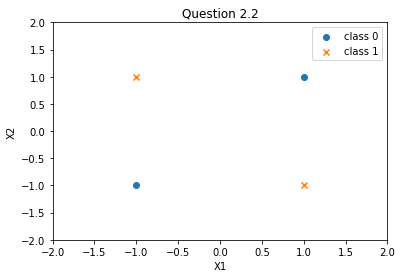

In [13]:
plt.scatter([-1, 1],[-1,1], marker='o', label="class 0")
plt.scatter([-1, 1],[1,-1], marker='x', label="class 1")
plt.legend(numpoints=1)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Question 2.2")

In [14]:
#q2.3

druns_df = pd.read_csv("Druns.txt", delim_whitespace=True, names=['x1', 'x2', 'y'])
numpy_matrix = druns_df.as_matrix()
tree = build_tree(numpy_matrix, 1000, 1)
print_tree(tree)

X1 >= 0.100 Information Gain=0.04418
X1 >= 0.000 Information Gain=0.00000
X2 >= -2.000 Information Gain=0.00000
X2 >= -1.000 Information Gain=0.04418
X2 >= 0.000 Information Gain=0.03827
X2 >= 1.000 Information Gain=0.00489
X2 >= 2.000 Information Gain=0.00108
X2 >= 3.000 Information Gain=0.01631
X2 >= 4.000 Information Gain=0.04945
X2 >= 5.000 Information Gain=0.10520
X2 >= 6.000 Information Gain=0.19959
X2 >= 7.000 Information Gain=0.03827
X2 >= 8.000 Information Gain=0.18905
X1 >= 0.000 Information Gain=0.00000
X2 >= 6.000 Information Gain=0.00000
X2 >= 7.000 Information Gain=0.25163
X2 >= 8.000 Information Gain=0.25163
X1 >= 0.000 Information Gain=0.00000
X2 >= 7.000 Information Gain=0.00000
X2 >= 8.000 Information Gain=1.00000
X1 >= 0.100 Information Gain=0.02585
X1 >= 0.000 Information Gain=0.00000
X2 >= -2.000 Information Gain=0.00000
X2 >= -1.000 Information Gain=0.02585
X2 >= 0.000 Information Gain=0.29356
X2 >= 1.000 Information Gain=0.19920
X2 >= 2.000 Information Gain=0.137

b:\tenflow\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


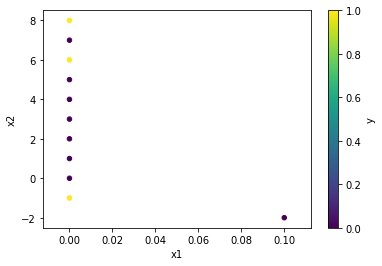

In [15]:
ax2 = druns_df.plot.scatter(x='x1',y='x2',c='y',colormap='viridis')

In [21]:
#q2.4
d3_df = pd.read_csv("D3leaves.txt", delim_whitespace=True, names=['x1', 'x2', 'y'])
numpy_matrix = d3_df.as_matrix()
tree = build_tree(numpy_matrix, 1000, 1)
print_tree(tree)

X1 >= 10.000 Information Gain=0.32193
X1 >= 1.000 Information Gain=0.00000
X2 >= 1.000 Information Gain=0.00000
X2 >= 2.000 Information Gain=0.32193
X2 >= 3.000 Information Gain=0.17095
X1 >= 1.000 Information Gain=0.00000
X2 >= 1.000 Information Gain=0.00000
X2 >= 3.000 Information Gain=1.00000
[X1 >= 10.000]
  [label = 1]
  [X2 >= 3.000]
    [label = 1]
    [label = 0]


b:\tenflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


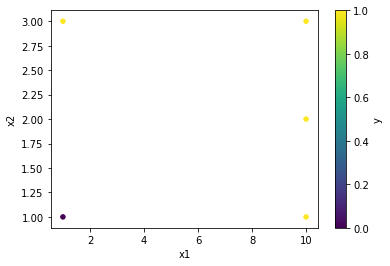

In [19]:
ax2 = d3_df.plot.scatter(x='x1',y='x2',c='y',colormap='viridis')

In [22]:
#q2.5 part1

In [24]:
d1_df = pd.read_csv("D1.txt", delim_whitespace=True, names=['x1', 'x2', 'y'])
numpy_matrix = d1_df.as_matrix()
tree = build_tree(numpy_matrix, 100, 1)
print_tree(tree)

b:\tenflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


X1 >= 0.264 Information Gain=0.00032
X1 >= 0.409 Information Gain=0.00044
X1 >= 0.926 Information Gain=0.00102
X1 >= 0.574 Information Gain=0.00011
X1 >= 0.953 Information Gain=0.00085
X1 >= 0.422 Information Gain=0.00043
X1 >= 0.734 Information Gain=0.00142
X1 >= 0.529 Information Gain=0.00013
X1 >= 0.845 Information Gain=0.00001
X1 >= 0.517 Information Gain=0.00013
X1 >= 0.613 Information Gain=0.00025
X1 >= 0.052 Information Gain=0.00068
X1 >= 0.693 Information Gain=0.00015
X1 >= 0.218 Information Gain=0.00000
X1 >= 0.463 Information Gain=0.00001
X1 >= 0.565 Information Gain=0.00015
X1 >= 0.710 Information Gain=0.00043
X1 >= 0.476 Information Gain=0.00000
X1 >= 0.429 Information Gain=0.00077
X1 >= 0.916 Information Gain=0.00020
X1 >= 0.847 Information Gain=0.00002
X1 >= 0.586 Information Gain=0.00029
X1 >= 0.484 Information Gain=0.00001
X1 >= 0.318 Information Gain=0.00005
X1 >= 0.680 Information Gain=0.00020
X1 >= 0.546 Information Gain=0.00045
X1 >= 0.699 Information Gain=0.00012
X

X1 >= 0.739 Information Gain=0.00108
X1 >= 0.140 Information Gain=0.00004
X1 >= 0.354 Information Gain=0.00001
X1 >= 0.383 Information Gain=0.00045
X1 >= 0.522 Information Gain=0.00008
X1 >= 0.843 Information Gain=0.00002
X1 >= 0.668 Information Gain=0.00036
X1 >= 0.576 Information Gain=0.00020
X1 >= 0.742 Information Gain=0.00105
X1 >= 0.683 Information Gain=0.00033
X1 >= 0.439 Information Gain=0.00023
X1 >= 0.297 Information Gain=0.00018
X1 >= 0.629 Information Gain=0.00069
X1 >= 0.545 Information Gain=0.00036
X1 >= 0.582 Information Gain=0.00017
X1 >= 0.088 Information Gain=0.00200
X1 >= 0.711 Information Gain=0.00038
X1 >= 0.581 Information Gain=0.00029
X1 >= 0.373 Information Gain=0.00031
X1 >= 0.436 Information Gain=0.00036
X1 >= 0.751 Information Gain=0.00106
X1 >= 0.333 Information Gain=0.00003
X1 >= 0.765 Information Gain=0.00017
X1 >= 0.985 Information Gain=0.00189
X1 >= 0.719 Information Gain=0.00077
X1 >= 0.116 Information Gain=0.00074
X1 >= 0.648 Information Gain=0.00014
X

X1 >= 0.235 Information Gain=0.00033
X1 >= 0.747 Information Gain=0.00108
X1 >= 0.027 Information Gain=0.00036
X1 >= 0.136 Information Gain=0.00002
X1 >= 0.058 Information Gain=0.00108
X1 >= 0.342 Information Gain=0.00001
X1 >= 0.747 Information Gain=0.00115
X1 >= 0.242 Information Gain=0.00032
X1 >= 0.002 Information Gain=0.00056
X1 >= 0.346 Information Gain=0.00000
X1 >= 0.742 Information Gain=0.00111
X1 >= 0.768 Information Gain=0.00026
X1 >= 0.635 Information Gain=0.00042
X1 >= 0.372 Information Gain=0.00029
X1 >= 0.587 Information Gain=0.00032
X1 >= 0.352 Information Gain=0.00000
X1 >= 0.540 Information Gain=0.00050
X1 >= 0.890 Information Gain=0.00001
X1 >= 0.115 Information Gain=0.00060
X1 >= 0.325 Information Gain=0.00009
X1 >= 0.904 Information Gain=0.00007
X1 >= 0.076 Information Gain=0.00305
X1 >= 0.584 Information Gain=0.00022
X1 >= 0.613 Information Gain=0.00022
X1 >= 0.261 Information Gain=0.00047
X1 >= 0.912 Information Gain=0.00005
X1 >= 0.651 Information Gain=0.00016
X

X1 >= 0.182 Information Gain=0.00078
X1 >= 0.332 Information Gain=0.00004
X1 >= 0.424 Information Gain=0.00053
X1 >= 0.554 Information Gain=0.00053
X1 >= 0.185 Information Gain=0.00077
X1 >= 0.972 Information Gain=0.00126
X1 >= 0.236 Information Gain=0.00047
X1 >= 0.022 Information Gain=0.00016
X1 >= 0.882 Information Gain=0.00004
X1 >= 0.913 Information Gain=0.00045
X1 >= 0.544 Information Gain=0.00033
X1 >= 0.578 Information Gain=0.00030
X1 >= 0.625 Information Gain=0.00046
X1 >= 0.776 Information Gain=0.00038
X1 >= 0.064 Information Gain=0.00178
X1 >= 0.336 Information Gain=0.00000
X1 >= 0.479 Information Gain=0.00001
X1 >= 0.950 Information Gain=0.00044
X1 >= 0.956 Information Gain=0.00056
X1 >= 0.989 Information Gain=0.00111
X1 >= 0.191 Information Gain=0.00095
X1 >= 0.172 Information Gain=0.00042
X1 >= 0.059 Information Gain=0.00118
X1 >= 0.659 Information Gain=0.00021
X1 >= 0.781 Information Gain=0.00056
X1 >= 0.668 Information Gain=0.00039
X1 >= 0.613 Information Gain=0.00020
X

X2 >= 0.541 Information Gain=0.18227
X2 >= 0.530 Information Gain=0.18808
X2 >= 0.827 Information Gain=0.05708
X2 >= 0.641 Information Gain=0.13013
X2 >= 0.170 Information Gain=0.50630
X2 >= 0.548 Information Gain=0.17660
X2 >= 0.493 Information Gain=0.21869
X2 >= 0.687 Information Gain=0.10615
X2 >= 0.691 Information Gain=0.10362
X2 >= 0.824 Information Gain=0.05918
X2 >= 0.480 Information Gain=0.22749
X2 >= 0.827 Information Gain=0.05778
X2 >= 0.623 Information Gain=0.13818
X2 >= 0.856 Information Gain=0.04220
X2 >= 0.382 Information Gain=0.30635
X2 >= 0.735 Information Gain=0.08661
X2 >= 0.415 Information Gain=0.27271
X2 >= 0.709 Information Gain=0.09700
X2 >= 0.640 Information Gain=0.13106
X2 >= 0.405 Information Gain=0.27942
X2 >= 0.343 Information Gain=0.34098
X2 >= 0.384 Information Gain=0.30072
X2 >= 0.288 Information Gain=0.41487
X2 >= 0.775 Information Gain=0.07215
X2 >= 0.904 Information Gain=0.02723
X2 >= 0.242 Information Gain=0.51051
X2 >= 0.301 Information Gain=0.39343
X

X2 >= 0.289 Information Gain=0.41042
X2 >= 0.940 Information Gain=0.01339
X2 >= 0.852 Information Gain=0.04451
X2 >= 0.319 Information Gain=0.37006
X2 >= 0.692 Information Gain=0.10195
X2 >= 0.906 Information Gain=0.02661
X2 >= 0.330 Information Gain=0.35450
X2 >= 0.923 Information Gain=0.01962
X2 >= 0.688 Information Gain=0.10573
X2 >= 0.243 Information Gain=0.50594
X2 >= 0.257 Information Gain=0.47251
X2 >= 0.787 Information Gain=0.06994
X2 >= 0.020 Information Gain=0.04906
X2 >= 0.976 Information Gain=0.00618
X2 >= 0.217 Information Gain=0.58269
X2 >= 0.822 Information Gain=0.06023
X2 >= 0.893 Information Gain=0.02941
X2 >= 0.824 Information Gain=0.05883
X2 >= 0.273 Information Gain=0.44017
X2 >= 0.734 Information Gain=0.08818
X2 >= 0.538 Information Gain=0.18574
X2 >= 0.679 Information Gain=0.11085
X2 >= 0.266 Information Gain=0.45219
X2 >= 0.920 Information Gain=0.02082
X2 >= 0.228 Information Gain=0.54314
X2 >= 0.081 Information Gain=0.26157
X2 >= 0.358 Information Gain=0.32203
X

X2 >= 0.942 Information Gain=0.01310
X2 >= 0.812 Information Gain=0.06271
X2 >= 0.617 Information Gain=0.14255
X2 >= 0.586 Information Gain=0.15769
X2 >= 0.880 Information Gain=0.03223
X2 >= 0.901 Information Gain=0.02785
X2 >= 0.353 Information Gain=0.32819
X2 >= 0.015 Information Gain=0.03068
X2 >= 0.659 Information Gain=0.12053
X2 >= 0.985 Information Gain=0.00448
X2 >= 0.889 Information Gain=0.03034
X2 >= 0.067 Information Gain=0.21511
X2 >= 0.225 Information Gain=0.55733
X2 >= 0.053 Information Gain=0.18974
X2 >= 0.282 Information Gain=0.43358
X2 >= 0.969 Information Gain=0.00847
X2 >= 0.872 Information Gain=0.03509
X2 >= 0.706 Information Gain=0.09864
X2 >= 0.301 Information Gain=0.38937
X2 >= 0.506 Information Gain=0.20955
X2 >= 0.637 Information Gain=0.13247
X2 >= 0.928 Information Gain=0.01723
X2 >= 0.202 Information Gain=0.66902
X2 >= 0.301 Information Gain=0.39207
X2 >= 0.829 Information Gain=0.05569
X2 >= 0.939 Information Gain=0.01398
X2 >= 0.922 Information Gain=0.01992
X

X2 >= 0.713 Information Gain=0.09619
X2 >= 0.547 Information Gain=0.17772
X2 >= 0.077 Information Gain=0.24466
X2 >= 0.087 Information Gain=0.27887
X2 >= 0.855 Information Gain=0.04253
X2 >= 0.892 Information Gain=0.02972
X2 >= 0.773 Information Gain=0.07289
X2 >= 0.737 Information Gain=0.08466
X2 >= 0.234 Information Gain=0.52491
X2 >= 0.957 Information Gain=0.01077
X2 >= 0.514 Information Gain=0.20136
X2 >= 0.226 Information Gain=0.55440
[X2 >= 0.202]
  [label = 1.0]
  [label = 0.0]


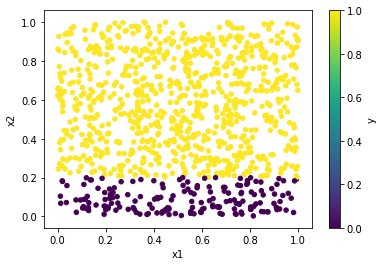

In [25]:
ax2 = d1_df.plot.scatter(x='x1',y='x2',c='y',colormap='viridis')

In [26]:
#q2.5 part2  D2

In [27]:
#p5
d2_df = pd.read_csv("D2.txt", delim_whitespace=True, names=['x1', 'x2', 'y'])
numpy_matrix = d2_df.as_matrix()
tree = build_tree(numpy_matrix, 1000, 1)
print_tree(tree)

b:\tenflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


X1 >= 0.316 Information Gain=0.14923
X1 >= 0.345 Information Gain=0.16071
X1 >= 0.398 Information Gain=0.18448
X1 >= 0.347 Information Gain=0.16064
X1 >= 0.986 Information Gain=0.01657
X1 >= 0.709 Information Gain=0.18207
X1 >= 0.830 Information Gain=0.12662
X1 >= 0.979 Information Gain=0.01988
X1 >= 0.922 Information Gain=0.06928
X1 >= 0.518 Information Gain=0.21326
X1 >= 0.402 Information Gain=0.18673
X1 >= 0.308 Information Gain=0.14282
X1 >= 0.301 Information Gain=0.13578
X1 >= 0.412 Information Gain=0.18474
X1 >= 0.142 Information Gain=0.08041
X1 >= 0.710 Information Gain=0.18381
X1 >= 0.286 Information Gain=0.13689
X1 >= 0.469 Information Gain=0.19857
X1 >= 0.262 Information Gain=0.12419
X1 >= 0.851 Information Gain=0.11013
X1 >= 0.099 Information Gain=0.06551
X1 >= 0.362 Information Gain=0.17230
X1 >= 0.401 Information Gain=0.18395
X1 >= 0.036 Information Gain=0.02996
X1 >= 0.137 Information Gain=0.07735
X1 >= 0.718 Information Gain=0.17790
X1 >= 0.189 Information Gain=0.10307
X

X1 >= 0.387 Information Gain=0.18671
X1 >= 0.271 Information Gain=0.12679
X1 >= 0.280 Information Gain=0.13431
X1 >= 0.697 Information Gain=0.17661
X1 >= 0.395 Information Gain=0.18695
X1 >= 0.057 Information Gain=0.02838
X1 >= 0.196 Information Gain=0.10332
X1 >= 0.693 Information Gain=0.17183
X1 >= 0.287 Information Gain=0.13718
X1 >= 0.268 Information Gain=0.12773
X1 >= 0.454 Information Gain=0.20695
X1 >= 0.096 Information Gain=0.06345
X1 >= 0.751 Information Gain=0.17433
X1 >= 0.219 Information Gain=0.10941
X1 >= 0.455 Information Gain=0.21004
X1 >= 0.869 Information Gain=0.10306
X1 >= 0.085 Information Gain=0.05432
X1 >= 0.666 Information Gain=0.18959
X1 >= 0.886 Information Gain=0.09243
X1 >= 0.286 Information Gain=0.13806
X1 >= 0.799 Information Gain=0.14025
X1 >= 0.482 Information Gain=0.20365
X1 >= 0.045 Information Gain=0.02675
X1 >= 0.562 Information Gain=0.20945
X1 >= 0.766 Information Gain=0.16620
X1 >= 0.311 Information Gain=0.14323
X1 >= 0.716 Information Gain=0.18197
X

X1 >= 0.288 Information Gain=0.13834
X1 >= 0.417 Information Gain=0.18811
X1 >= 0.837 Information Gain=0.12778
X1 >= 0.755 Information Gain=0.16643
X1 >= 0.340 Information Gain=0.15638
X1 >= 0.875 Information Gain=0.10052
X1 >= 0.414 Information Gain=0.18571
X1 >= 0.954 Information Gain=0.04479
X1 >= 0.347 Information Gain=0.16257
X1 >= 0.640 Information Gain=0.19797
X1 >= 0.121 Information Gain=0.06730
X1 >= 0.810 Information Gain=0.13587
X1 >= 0.701 Information Gain=0.17884
X1 >= 0.193 Information Gain=0.10240
X1 >= 0.791 Information Gain=0.14623
X1 >= 0.412 Information Gain=0.18195
X1 >= 0.509 Information Gain=0.21364
X1 >= 0.066 Information Gain=0.03393
X1 >= 0.884 Information Gain=0.09469
X1 >= 0.699 Information Gain=0.17733
X1 >= 0.437 Information Gain=0.20222
X1 >= 0.582 Information Gain=0.20264
X1 >= 0.349 Information Gain=0.16702
X1 >= 0.984 Information Gain=0.01972
X1 >= 0.677 Information Gain=0.17407
X1 >= 0.912 Information Gain=0.08020
X1 >= 0.874 Information Gain=0.09851
X

X1 >= 0.753 Information Gain=0.16904
X1 >= 0.428 Information Gain=0.19409
X1 >= 0.365 Information Gain=0.17628
X1 >= 0.182 Information Gain=0.09177
X1 >= 0.850 Information Gain=0.11244
X1 >= 0.299 Information Gain=0.13655
X1 >= 0.734 Information Gain=0.18428
X1 >= 0.945 Information Gain=0.05543
X1 >= 0.518 Information Gain=0.20991
X1 >= 0.514 Information Gain=0.21002
X1 >= 0.799 Information Gain=0.13903
X1 >= 0.686 Information Gain=0.17588
X1 >= 0.145 Information Gain=0.08351
X1 >= 0.255 Information Gain=0.12085
X1 >= 0.476 Information Gain=0.19613
X1 >= 0.937 Information Gain=0.06554
X1 >= 0.656 Information Gain=0.19712
X1 >= 0.865 Information Gain=0.10571
X1 >= 0.413 Information Gain=0.18430
X1 >= 0.760 Information Gain=0.16755
X1 >= 0.309 Information Gain=0.14520
X1 >= 0.761 Information Gain=0.16882
X1 >= 0.528 Information Gain=0.21662
X1 >= 0.214 Information Gain=0.10730
X1 >= 0.663 Information Gain=0.19045
X1 >= 0.930 Information Gain=0.07211
X1 >= 0.314 Information Gain=0.14682
X

X2 >= 0.350 Information Gain=0.14232
X2 >= 0.721 Information Gain=0.13947
X2 >= 0.922 Information Gain=0.07328
X2 >= 0.220 Information Gain=0.11049
X2 >= 0.850 Information Gain=0.10554
X2 >= 0.670 Information Gain=0.16191
X2 >= 0.264 Information Gain=0.11750
X2 >= 0.337 Information Gain=0.14338
X2 >= 0.243 Information Gain=0.11662
X2 >= 0.042 Information Gain=0.02652
X2 >= 0.556 Information Gain=0.16845
X2 >= 0.200 Information Gain=0.10120
X2 >= 0.369 Information Gain=0.15220
X2 >= 0.544 Information Gain=0.16581
X2 >= 0.905 Information Gain=0.08311
X2 >= 0.609 Information Gain=0.15981
X2 >= 0.410 Information Gain=0.16500
X2 >= 0.107 Information Gain=0.05966
X2 >= 0.904 Information Gain=0.08424
X2 >= 0.499 Information Gain=0.17918
X2 >= 0.456 Information Gain=0.16628
X2 >= 0.550 Information Gain=0.16789
X2 >= 0.165 Information Gain=0.09312
X2 >= 0.976 Information Gain=0.02606
X2 >= 0.912 Information Gain=0.07521
X2 >= 0.271 Information Gain=0.11561
X2 >= 0.659 Information Gain=0.16321
X

X2 >= 0.293 Information Gain=0.12603
X2 >= 0.335 Information Gain=0.13627
X2 >= 0.222 Information Gain=0.11048
X2 >= 0.492 Information Gain=0.18236
X2 >= 0.043 Information Gain=0.02750
X2 >= 0.862 Information Gain=0.09851
X2 >= 0.048 Information Gain=0.03845
X2 >= 0.638 Information Gain=0.16751
X2 >= 0.499 Information Gain=0.17764
X2 >= 0.438 Information Gain=0.16832
X2 >= 0.531 Information Gain=0.17101
X2 >= 0.477 Information Gain=0.17222
X2 >= 0.545 Information Gain=0.17056
X2 >= 0.659 Information Gain=0.16452
X2 >= 0.666 Information Gain=0.16453
X2 >= 0.913 Information Gain=0.07409
X2 >= 0.074 Information Gain=0.05033
X2 >= 0.501 Information Gain=0.18075
X2 >= 0.066 Information Gain=0.04671
X2 >= 0.889 Information Gain=0.10050
X2 >= 0.864 Information Gain=0.09513
X2 >= 0.938 Information Gain=0.06090
X2 >= 0.368 Information Gain=0.15143
X2 >= 0.219 Information Gain=0.10514
X2 >= 0.717 Information Gain=0.13786
X2 >= 0.390 Information Gain=0.16882
X2 >= 0.001 Information Gain=0.00000
X

X2 >= 0.069 Information Gain=0.04870
X2 >= 0.858 Information Gain=0.10571
X2 >= 0.922 Information Gain=0.07442
X2 >= 0.803 Information Gain=0.10488
X2 >= 0.601 Information Gain=0.16566
X2 >= 0.085 Information Gain=0.04658
X2 >= 0.060 Information Gain=0.04536
X2 >= 0.917 Information Gain=0.07334
X2 >= 0.156 Information Gain=0.08931
X2 >= 0.521 Information Gain=0.17363
X2 >= 0.352 Information Gain=0.14419
X2 >= 0.272 Information Gain=0.11206
X2 >= 0.997 Information Gain=0.00514
X2 >= 0.038 Information Gain=0.02554
X2 >= 0.582 Information Gain=0.16580
X2 >= 0.750 Information Gain=0.12359
X2 >= 0.191 Information Gain=0.09836
X2 >= 0.124 Information Gain=0.06732
X2 >= 0.226 Information Gain=0.11373
X2 >= 0.728 Information Gain=0.13309
X2 >= 0.335 Information Gain=0.13862
X2 >= 0.282 Information Gain=0.11569
X2 >= 0.983 Information Gain=0.01447
X2 >= 0.483 Information Gain=0.17351
X2 >= 0.778 Information Gain=0.11203
X2 >= 0.570 Information Gain=0.16589
X2 >= 0.307 Information Gain=0.12788
X

X1 >= 0.769 Information Gain=0.06592
X1 >= 0.756 Information Gain=0.05688
X1 >= 0.700 Information Gain=0.03965
X1 >= 0.567 Information Gain=0.00431
X1 >= 0.576 Information Gain=0.00642
X1 >= 0.983 Information Gain=0.01579
X1 >= 0.603 Information Gain=0.01227
X1 >= 0.989 Information Gain=0.00780
X1 >= 0.624 Information Gain=0.02141
X1 >= 0.703 Information Gain=0.04228
X1 >= 0.653 Information Gain=0.03177
X1 >= 0.598 Information Gain=0.01045
X1 >= 0.724 Information Gain=0.05647
X1 >= 0.949 Information Gain=0.03780
X1 >= 0.731 Information Gain=0.06915
X1 >= 0.667 Information Gain=0.02906
X1 >= 0.669 Information Gain=0.02594
X1 >= 0.534 Information Gain=0.00232
X1 >= 0.598 Information Gain=0.00979
X1 >= 0.996 Information Gain=0.00388
X1 >= 0.769 Information Gain=0.06969
X1 >= 0.693 Information Gain=0.03073
X1 >= 0.730 Information Gain=0.06773
X1 >= 0.618 Information Gain=0.01052
X1 >= 0.976 Information Gain=0.01357
X1 >= 0.536 Information Gain=0.00388
X1 >= 0.605 Information Gain=0.01199
X

X2 >= 0.153 Information Gain=0.24765
X2 >= 0.168 Information Gain=0.26530
X2 >= 0.908 Information Gain=0.03324
X2 >= 0.221 Information Gain=0.30572
X2 >= 0.757 Information Gain=0.09514
X2 >= 0.841 Information Gain=0.06085
X2 >= 0.608 Information Gain=0.17970
X2 >= 0.151 Information Gain=0.24159
X2 >= 0.500 Information Gain=0.27072
X2 >= 0.829 Information Gain=0.06838
X2 >= 0.721 Information Gain=0.11430
X2 >= 0.922 Information Gain=0.02399
X2 >= 0.220 Information Gain=0.29865
X2 >= 0.850 Information Gain=0.05808
X2 >= 0.670 Information Gain=0.14777
X2 >= 0.264 Information Gain=0.29670
X2 >= 0.243 Information Gain=0.30105
X2 >= 0.369 Information Gain=0.34421
X2 >= 0.410 Information Gain=0.34295
X2 >= 0.456 Information Gain=0.31266
X2 >= 0.165 Information Gain=0.26164
X2 >= 0.976 Information Gain=0.01097
X2 >= 0.912 Information Gain=0.03154
X2 >= 0.271 Information Gain=0.29949
X2 >= 0.659 Information Gain=0.15267
X2 >= 0.263 Information Gain=0.28926
X2 >= 0.658 Information Gain=0.15391
X

X2 >= 0.699 Information Gain=0.13002
X2 >= 0.506 Information Gain=0.26894
X2 >= 0.890 Information Gain=0.03841
X2 >= 0.947 Information Gain=0.01660
X2 >= 0.313 Information Gain=0.32805
X2 >= 0.129 Information Gain=0.21289
X2 >= 0.347 Information Gain=0.33390
X2 >= 0.380 Information Gain=0.34564
X2 >= 0.623 Information Gain=0.17306
X2 >= 0.228 Information Gain=0.31961
X2 >= 0.717 Information Gain=0.11760
X2 >= 0.787 Information Gain=0.08198
X2 >= 0.350 Information Gain=0.33117
X2 >= 0.895 Information Gain=0.03754
X2 >= 0.722 Information Gain=0.11320
X2 >= 0.803 Information Gain=0.07608
X2 >= 0.560 Information Gain=0.21970
X2 >= 0.541 Information Gain=0.23369
X2 >= 0.951 Information Gain=0.01498
X2 >= 0.306 Information Gain=0.32789
X2 >= 0.456 Information Gain=0.31470
X2 >= 0.128 Information Gain=0.20163
X2 >= 0.529 Information Gain=0.24174
X2 >= 0.497 Information Gain=0.27613
X2 >= 0.201 Information Gain=0.28742
X2 >= 0.780 Information Gain=0.08698
X2 >= 0.512 Information Gain=0.25847
X

X1 >= 0.753 Information Gain=0.00741
X1 >= 0.850 Information Gain=0.00360
X1 >= 0.734 Information Gain=0.00861
X1 >= 0.945 Information Gain=0.00138
X1 >= 0.799 Information Gain=0.00520
X1 >= 0.686 Information Gain=0.01084
X1 >= 0.656 Information Gain=0.01375
X1 >= 0.865 Information Gain=0.00331
X1 >= 0.760 Information Gain=0.00706
X1 >= 0.761 Information Gain=0.00699
X1 >= 0.706 Information Gain=0.01016
X1 >= 0.913 Information Gain=0.00205
X1 >= 0.751 Information Gain=0.00777
X1 >= 0.599 Information Gain=0.01900
X1 >= 0.628 Information Gain=0.01603
X1 >= 0.970 Information Gain=0.00083
X1 >= 0.660 Information Gain=0.01361
X1 >= 0.547 Information Gain=0.00886
X1 >= 0.648 Information Gain=0.01460
X1 >= 0.533 Information Gain=0.00000
X1 >= 0.830 Information Gain=0.00424
X1 >= 0.975 Information Gain=0.00072
X1 >= 0.828 Information Gain=0.00439
X1 >= 0.822 Information Gain=0.00460
X1 >= 0.662 Information Gain=0.01335
X1 >= 0.559 Information Gain=0.02624
X1 >= 0.721 Information Gain=0.00918
X

X1 >= 0.874 Information Gain=0.22529
X1 >= 0.858 Information Gain=0.24011
X1 >= 0.592 Information Gain=0.07744
X1 >= 0.757 Information Gain=0.30112
X1 >= 0.961 Information Gain=0.08265
X1 >= 0.978 Information Gain=0.04815
X1 >= 0.611 Information Gain=0.11254
X1 >= 0.958 Information Gain=0.09725
X1 >= 0.731 Information Gain=0.27402
X1 >= 0.769 Information Gain=0.30819
X1 >= 0.576 Information Gain=0.06301
X1 >= 0.983 Information Gain=0.06309
X1 >= 0.603 Information Gain=0.10739
X1 >= 0.703 Information Gain=0.23515
X1 >= 0.996 Information Gain=0.00676
X1 >= 0.769 Information Gain=0.31774
X1 >= 0.693 Information Gain=0.19581
X1 >= 0.618 Information Gain=0.11773
X1 >= 0.777 Information Gain=0.31319
X1 >= 0.630 Information Gain=0.16099
X1 >= 0.671 Information Gain=0.20577
X1 >= 0.876 Information Gain=0.23759
X1 >= 0.816 Information Gain=0.25038
X1 >= 0.763 Information Gain=0.30418
X1 >= 0.904 Information Gain=0.21229
X1 >= 0.599 Information Gain=0.09222
X1 >= 0.850 Information Gain=0.25035
X

X1 >= 0.965 Information Gain=0.14611
X1 >= 0.794 Information Gain=0.09820
X2 >= 0.168 Information Gain=0.00076
X2 >= 0.151 Information Gain=0.00222
X2 >= 0.165 Information Gain=0.00169
X2 >= 0.054 Information Gain=0.06748
X2 >= 0.036 Information Gain=0.16558
X2 >= 0.053 Information Gain=0.10854
X2 >= 0.168 Information Gain=0.00120
X2 >= 0.083 Information Gain=0.12846
X2 >= 0.110 Information Gain=0.05112
X2 >= 0.070 Information Gain=0.10767
X2 >= 0.175 Information Gain=0.00036
X2 >= 0.135 Information Gain=0.01021
X2 >= 0.169 Information Gain=0.00963
X2 >= 0.016 Information Gain=0.07728
X2 >= 0.071 Information Gain=0.07703
X2 >= 0.102 Information Gain=0.07085
X2 >= 0.004 Information Gain=0.00000
X2 >= 0.072 Information Gain=0.09542
X2 >= 0.145 Information Gain=0.00864
X2 >= 0.076 Information Gain=0.11581
X2 >= 0.062 Information Gain=0.08513
X2 >= 0.084 Information Gain=0.09923
X2 >= 0.066 Information Gain=0.05466
X2 >= 0.142 Information Gain=0.00934
X2 >= 0.091 Information Gain=0.05391
X

X1 >= 0.441 Information Gain=0.02017
X1 >= 0.486 Information Gain=0.00685
X1 >= 0.438 Information Gain=0.02335
X1 >= 0.159 Information Gain=0.03175
X1 >= 0.077 Information Gain=0.02114
X1 >= 0.456 Information Gain=0.02010
X1 >= 0.283 Information Gain=0.02861
X1 >= 0.173 Information Gain=0.03231
X1 >= 0.392 Information Gain=0.03348
X1 >= 0.391 Information Gain=0.03267
X1 >= 0.207 Information Gain=0.03311
X1 >= 0.055 Information Gain=0.01198
X1 >= 0.018 Information Gain=0.00664
X1 >= 0.384 Information Gain=0.03030
X1 >= 0.265 Information Gain=0.03036
X1 >= 0.114 Information Gain=0.03530
X1 >= 0.469 Information Gain=0.00887
X1 >= 0.436 Information Gain=0.02085
X1 >= 0.186 Information Gain=0.03371
X1 >= 0.129 Information Gain=0.02627
X1 >= 0.156 Information Gain=0.03048
X1 >= 0.506 Information Gain=0.00413
X1 >= 0.094 Information Gain=0.03203
X1 >= 0.372 Information Gain=0.02848
X1 >= 0.137 Information Gain=0.03005
X1 >= 0.318 Information Gain=0.02575
X1 >= 0.280 Information Gain=0.03162
X

X1 >= 0.521 Information Gain=0.00023
X1 >= 0.352 Information Gain=0.02879
X1 >= 0.480 Information Gain=0.00549
X1 >= 0.418 Information Gain=0.01981
X1 >= 0.095 Information Gain=0.03346
X1 >= 0.183 Information Gain=0.03118
X1 >= 0.428 Information Gain=0.01931
X1 >= 0.365 Information Gain=0.02907
X1 >= 0.182 Information Gain=0.02994
X1 >= 0.299 Information Gain=0.02391
X1 >= 0.518 Information Gain=0.00003
X1 >= 0.514 Information Gain=0.00030
X1 >= 0.145 Information Gain=0.03465
X1 >= 0.255 Information Gain=0.02736
X1 >= 0.476 Information Gain=0.00530
X1 >= 0.413 Information Gain=0.01820
X1 >= 0.309 Information Gain=0.02732
X1 >= 0.528 Information Gain=0.00021
X1 >= 0.214 Information Gain=0.02947
X1 >= 0.314 Information Gain=0.02719
X1 >= 0.136 Information Gain=0.02753
X1 >= 0.372 Information Gain=0.03054
X1 >= 0.460 Information Gain=0.01897
X1 >= 0.510 Information Gain=0.00429
X1 >= 0.346 Information Gain=0.02605
X1 >= 0.072 Information Gain=0.01861
X1 >= 0.409 Information Gain=0.02019
X

X2 >= 0.683 Information Gain=0.33239
X2 >= 0.598 Information Gain=0.33887
X2 >= 0.052 Information Gain=0.01802
X2 >= 0.128 Information Gain=0.04202
X2 >= 0.473 Information Gain=0.27618
X2 >= 0.038 Information Gain=0.00964
X2 >= 0.175 Information Gain=0.06256
X2 >= 0.046 Information Gain=0.01419
X2 >= 0.784 Information Gain=0.25289
X2 >= 0.171 Information Gain=0.06080
X2 >= 0.691 Information Gain=0.34782
X2 >= 0.965 Information Gain=0.10330
X2 >= 0.895 Information Gain=0.21552
X2 >= 0.111 Information Gain=0.03464
X2 >= 0.827 Information Gain=0.23158
X2 >= 0.572 Information Gain=0.33746
X2 >= 0.418 Information Gain=0.22317
X2 >= 0.825 Information Gain=0.23294
X2 >= 0.368 Information Gain=0.18009
X2 >= 0.088 Information Gain=0.02662
X2 >= 0.855 Information Gain=0.23668
X2 >= 0.037 Information Gain=0.00814
X2 >= 0.215 Information Gain=0.07792
X2 >= 0.654 Information Gain=0.33880
X2 >= 0.781 Information Gain=0.24250
X2 >= 0.336 Information Gain=0.15579
X2 >= 0.685 Information Gain=0.33540
X

X1 >= 0.311 Information Gain=0.21059
X1 >= 0.328 Information Gain=0.20844
X1 >= 0.079 Information Gain=0.10143
X1 >= 0.471 Information Gain=0.06660
X1 >= 0.411 Information Gain=0.14362
X1 >= 0.148 Information Gain=0.19072
X1 >= 0.322 Information Gain=0.21443
X1 >= 0.191 Information Gain=0.24902
X1 >= 0.316 Information Gain=0.22667
X1 >= 0.104 Information Gain=0.26597
X1 >= 0.108 Information Gain=0.26249
X1 >= 0.215 Information Gain=0.22528
X1 >= 0.097 Information Gain=0.21663
X1 >= 0.301 Information Gain=0.20306
X1 >= 0.177 Information Gain=0.20143
X1 >= 0.254 Information Gain=0.25310
X1 >= 0.279 Information Gain=0.22484
X1 >= 0.440 Information Gain=0.10587
X1 >= 0.177 Information Gain=0.21036
X1 >= 0.404 Information Gain=0.15856
X1 >= 0.227 Information Gain=0.24793
X1 >= 0.528 Information Gain=0.00368
X1 >= 0.191 Information Gain=0.24003
X1 >= 0.469 Information Gain=0.07081
X1 >= 0.267 Information Gain=0.24581
X1 >= 0.514 Information Gain=0.01488
X1 >= 0.242 Information Gain=0.25792
X

X2 >= 0.781 Information Gain=0.08576
X2 >= 0.685 Information Gain=0.05965
X2 >= 0.851 Information Gain=0.16316
X2 >= 0.803 Information Gain=0.14371
X2 >= 0.695 Information Gain=0.06843
X2 >= 0.700 Information Gain=0.05086
X2 >= 0.924 Information Gain=0.08619
X2 >= 0.640 Information Gain=0.00231
X2 >= 0.973 Information Gain=0.02916
X2 >= 0.889 Information Gain=0.15061
X2 >= 0.784 Information Gain=0.17007
X2 >= 0.697 Information Gain=0.05614
X2 >= 0.763 Information Gain=0.05728
X2 >= 0.754 Information Gain=0.06909
X2 >= 0.958 Information Gain=0.05901
X2 >= 0.884 Information Gain=0.16732
X2 >= 0.783 Information Gain=0.10326
X2 >= 0.925 Information Gain=0.08303
X2 >= 0.657 Information Gain=0.01169
X2 >= 0.922 Information Gain=0.09262
X2 >= 0.803 Information Gain=0.13886
X2 >= 0.946 Information Gain=0.06776
X2 >= 0.731 Information Gain=0.09392
X2 >= 0.971 Information Gain=0.03434
X2 >= 0.793 Information Gain=0.16450
X2 >= 0.889 Information Gain=0.14659
X2 >= 0.680 Information Gain=0.05239
X

X1 >= 0.196 Information Gain=0.01780
X1 >= 0.287 Information Gain=0.03041
X1 >= 0.268 Information Gain=0.02614
X1 >= 0.454 Information Gain=0.03389
X1 >= 0.219 Information Gain=0.01988
X1 >= 0.286 Information Gain=0.03016
X1 >= 0.045 Information Gain=0.00336
X1 >= 0.283 Information Gain=0.02918
X1 >= 0.278 Information Gain=0.02846
X1 >= 0.090 Information Gain=0.00645
X1 >= 0.197 Information Gain=0.01817
X1 >= 0.279 Information Gain=0.02870
X1 >= 0.182 Information Gain=0.01479
X1 >= 0.193 Information Gain=0.01762
X1 >= 0.254 Information Gain=0.02373
X1 >= 0.003 Information Gain=0.00012
X1 >= 0.171 Information Gain=0.01394
X1 >= 0.241 Information Gain=0.02227
X1 >= 0.183 Information Gain=0.01513
X1 >= 0.193 Information Gain=0.01744
X1 >= 0.028 Information Gain=0.00158
X1 >= 0.152 Information Gain=0.01198
X1 >= 0.028 Information Gain=0.00146
X1 >= 0.417 Information Gain=0.04449
X1 >= 0.171 Information Gain=0.01378
X1 >= 0.463 Information Gain=0.02597
X1 >= 0.508 Information Gain=0.01320
X

X2 >= 0.414 Information Gain=0.04186
X2 >= 0.505 Information Gain=0.06948
X2 >= 0.381 Information Gain=0.03689
X2 >= 0.537 Information Gain=0.05581
X2 >= 0.414 Information Gain=0.04153
X2 >= 0.011 Information Gain=0.00012
X2 >= 0.364 Information Gain=0.03168
X2 >= 0.277 Information Gain=0.02047
X2 >= 0.608 Information Gain=0.01385
X2 >= 0.057 Information Gain=0.00310
X2 >= 0.636 Information Gain=0.00060
X2 >= 0.100 Information Gain=0.00535
X2 >= 0.638 Information Gain=0.00012
X2 >= 0.032 Information Gain=0.00097
X2 >= 0.545 Information Gain=0.05859
X2 >= 0.266 Information Gain=0.01969
X2 >= 0.214 Information Gain=0.01311
X2 >= 0.434 Information Gain=0.04639
X2 >= 0.138 Information Gain=0.00773
X2 >= 0.289 Information Gain=0.02186
X2 >= 0.120 Information Gain=0.00631
X2 >= 0.036 Information Gain=0.00109
X2 >= 0.219 Information Gain=0.01378
X2 >= 0.063 Information Gain=0.00375
X2 >= 0.355 Information Gain=0.03016
X2 >= 0.134 Information Gain=0.00730
X2 >= 0.477 Information Gain=0.05681
X

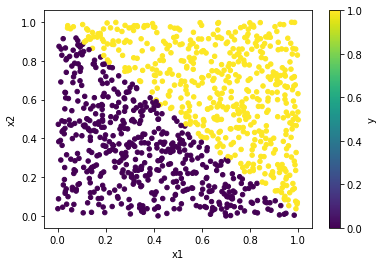

In [28]:
ax2 = d2_df.plot.scatter(x='x1',y='x2',c='y',colormap='viridis')

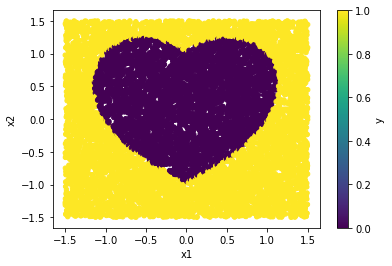

In [29]:
#q2.7
dbig_df = pd.read_csv("Dbig.txt", delim_whitespace=True, names=['x1', 'x2', 'y'])
ax2 = dbig_df.plot.scatter(x='x1',y='x2',c='y',colormap='viridis')

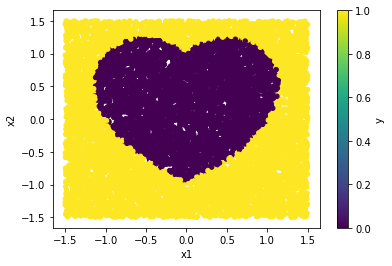

In [32]:
df_perm = dbig_df.sample(frac=1)
df_perm.to_csv('Dbig_perm.csv', index=False)
ax2 = df_perm.plot.scatter(x='x1',y='x2',c='y',colormap='viridis')

In [33]:
#perm = np.random.permutation(10000)
#perm[0:32]
numpy_matrix = df_perm.as_matrix()
d32 = numpy_matrix[ 0:32]
d128 = numpy_matrix[ 0:128]
d512 = numpy_matrix[ 0:512]
d2048 = numpy_matrix[ 0:2048]
d8192 = numpy_matrix[ 0:8192]
dtest = numpy_matrix[ 8192:]

b:\tenflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [71]:
def test_accuracy1(tree, xx, yy):
    arr=[]
    for x1,x2 in zip (xx,yy):
        row = [x1,x2]
        prediction = predict(tree, row)
        arr.append([prediction])
       #print('Expected=%d, Got=%d' % (row[-1], prediction))
    return arr

In [34]:
dtest.shape

(1808, 3)

In [35]:
d32

array([[-0.984086, -0.977469,  1.      ],
       [-0.70348 , -0.107561,  0.      ],
       [ 0.376408, -0.514436,  0.      ],
       [ 0.400492,  1.18704 ,  0.      ],
       [ 0.535238, -0.088082,  0.      ],
       [-1.329203, -0.047892,  1.      ],
       [ 1.262899, -0.273608,  1.      ],
       [-1.089261, -1.460134,  1.      ],
       [ 0.15644 ,  1.329709,  1.      ],
       [-0.561759, -0.873386,  1.      ],
       [-0.26281 , -1.494543,  1.      ],
       [ 0.350553, -0.94135 ,  1.      ],
       [-0.283934,  0.511803,  0.      ],
       [-0.923198, -0.785011,  1.      ],
       [-0.454007,  1.226116,  0.      ],
       [-0.809032, -0.700238,  1.      ],
       [-0.513107, -1.434058,  1.      ],
       [-0.840853,  0.143983,  0.      ],
       [ 1.206852,  0.248296,  1.      ],
       [ 0.729006,  1.154976,  0.      ],
       [ 0.497511, -1.307278,  1.      ],
       [ 0.42656 , -0.189369,  0.      ],
       [-0.740684,  0.295134,  0.      ],
       [-1.180166, -0.193333,  1. 

In [55]:
tree32 = build_tree(d32, 10000, 1)
print_tree(tree32)

X1 >= -0.984 Information Gain=0.06771
X1 >= -0.703 Information Gain=0.04544
X1 >= 0.376 Information Gain=0.01010
X1 >= 0.400 Information Gain=0.00087
X1 >= 0.535 Information Gain=0.00125
X1 >= -1.329 Information Gain=0.00000
X1 >= 1.263 Information Gain=0.04417
X1 >= -1.089 Information Gain=0.04417
X1 >= 0.156 Information Gain=0.00170
X1 >= -0.562 Information Gain=0.00323
X1 >= -0.263 Information Gain=0.00000
X1 >= 0.351 Information Gain=0.00319
X1 >= -0.284 Information Gain=0.00473
X1 >= -0.923 Information Gain=0.09236
X1 >= -0.454 Information Gain=0.01934
X1 >= -0.809 Information Gain=0.03398
X1 >= -0.513 Information Gain=0.00964
X1 >= -0.841 Information Gain=0.11821
X1 >= 1.207 Information Gain=0.06771
X1 >= 0.729 Information Gain=0.01888
X1 >= 0.498 Information Gain=0.00707
X1 >= 0.427 Information Gain=0.00211
X1 >= -0.741 Information Gain=0.09512
X1 >= -1.180 Information Gain=0.02162
X1 >= -0.785 Information Gain=0.07230
X1 >= -0.679 Information Gain=0.01729
X1 >= 0.172 Informatio

In [58]:
test_accuracy(tree32 ,dtest)

prediction error
298


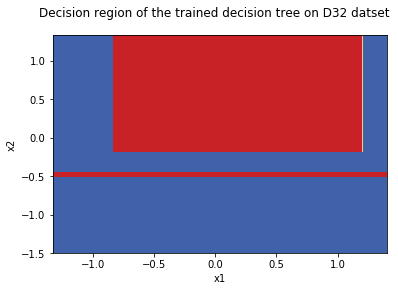

In [79]:
plot_step = 0.002
x_min, x_max = numpy_matrix[0:32, 0].min() , numpy_matrix[0:32, 0].max() 
y_min, y_max = numpy_matrix[0:32, 1].min() , numpy_matrix[0:32, 1].max() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
positions = np.vstack([xx.ravel(), yy.ravel()])
Z = test_accuracy1(tree32, xx.ravel(), yy.ravel())
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)


cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel('x1')
plt.ylabel('x2')

plt.suptitle("Decision region of the trained decision tree on D32 datset")
#plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

#labels = ['blue = label 1', 'red = label 0']

#plt.legend(loc='upper right', labels)
#plt.legend(labels)
plt.savefig('f3_d32_1.png')
plt.show()


In [47]:
#nodes = 13

In [60]:
tree128 = build_tree(d128, 10000, 1)
print_tree(tree128)

X1 >= -0.984 Information Gain=0.08416
X1 >= -0.703 Information Gain=0.07726
X1 >= 0.376 Information Gain=0.00023
X1 >= 0.400 Information Gain=0.00032
X1 >= 0.535 Information Gain=0.01590
X1 >= -1.329 Information Gain=0.02461
X1 >= 1.263 Information Gain=0.05031
X1 >= -1.089 Information Gain=0.09822
X1 >= 0.156 Information Gain=0.00003
X1 >= -0.562 Information Gain=0.05071
X1 >= -0.263 Information Gain=0.00499
X1 >= 0.351 Information Gain=0.00038
X1 >= -0.284 Information Gain=0.01427
X1 >= -0.923 Information Gain=0.10482
X1 >= -0.454 Information Gain=0.03759
X1 >= -0.809 Information Gain=0.07407
X1 >= -0.513 Information Gain=0.03608
X1 >= -0.841 Information Gain=0.10224
X1 >= 1.207 Information Gain=0.07036
X1 >= 0.729 Information Gain=0.03133
X1 >= 0.498 Information Gain=0.00991
X1 >= 0.427 Information Gain=0.00748
X1 >= -0.741 Information Gain=0.08443
X1 >= -1.180 Information Gain=0.06360
X1 >= -0.785 Information Gain=0.07826
X1 >= -0.679 Information Gain=0.06543
X1 >= 0.172 Informatio

X1 >= 0.632 Information Gain=0.03347
X1 >= 0.980 Information Gain=0.07797
X1 >= 0.424 Information Gain=0.00299
X1 >= 0.990 Information Gain=0.11801
X1 >= 0.441 Information Gain=0.00781
X1 >= -0.295 Information Gain=0.05189
X1 >= -0.015 Information Gain=0.00608
X1 >= -1.164 Information Gain=0.20337
X1 >= -0.809 Information Gain=0.16814
X1 >= -0.548 Information Gain=0.13389
X1 >= -1.240 Information Gain=0.14786
X1 >= 1.375 Information Gain=0.04657
X1 >= 1.060 Information Gain=0.14855
X1 >= -1.294 Information Gain=0.07081
X1 >= -0.129 Information Gain=0.01488
X2 >= -0.108 Information Gain=0.02028
X2 >= -0.514 Information Gain=0.00871
X2 >= 1.187 Information Gain=0.00682
X2 >= -0.088 Information Gain=0.01598
X2 >= -0.048 Information Gain=0.00905
X2 >= -0.274 Information Gain=0.00781
X2 >= 0.512 Information Gain=0.03228
X2 >= 1.226 Information Gain=0.00690
X2 >= -0.700 Information Gain=0.01391
X2 >= 0.144 Information Gain=0.01754
X2 >= 0.248 Information Gain=0.01870
X2 >= 1.155 Information 

In [59]:
test_accuracy(tree128 ,dtest)

prediction error
159


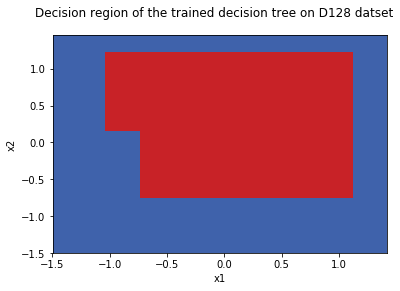

In [77]:
plot_step = 0.002
x_min, x_max = numpy_matrix[0:128, 0].min() , numpy_matrix[0:128, 0].max() 
y_min, y_max = numpy_matrix[0:128, 1].min() , numpy_matrix[0:128, 1].max() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
positions = np.vstack([xx.ravel(), yy.ravel()])
Z = test_accuracy1(tree128, xx.ravel(), yy.ravel())
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)


cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel('x1')
plt.ylabel('x2')

plt.suptitle("Decision region of the trained decision tree on D128 datset")
#plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

#labels = ['blue = label 1', 'red = label 0']

#plt.legend(loc='upper right', labels)
#plt.legend(labels)
plt.savefig('f3_d128_1.png')
plt.show()


In [ ]:
#nodes = 17

In [50]:
tree512 = build_tree(d512, 10000, 1)
print_tree(tree512)

X1 >= -0.984 Information Gain=0.09120
X1 >= -0.703 Information Gain=0.06184
X1 >= 0.376 Information Gain=0.00058
X1 >= 0.400 Information Gain=0.00170
X1 >= 0.535 Information Gain=0.01071
X1 >= -1.329 Information Gain=0.04461
X1 >= 1.263 Information Gain=0.06998
X1 >= -1.089 Information Gain=0.08607
X1 >= 0.156 Information Gain=0.00013
X1 >= -0.562 Information Gain=0.04532
X1 >= -0.263 Information Gain=0.01660
X1 >= 0.351 Information Gain=0.00092
X1 >= -0.284 Information Gain=0.01972
X1 >= -0.923 Information Gain=0.10029
X1 >= -0.454 Information Gain=0.03421
X1 >= -0.809 Information Gain=0.07817
X1 >= -0.513 Information Gain=0.03952
X1 >= -0.841 Information Gain=0.08797
X1 >= 1.207 Information Gain=0.08397
X1 >= 0.729 Information Gain=0.03081
X1 >= 0.498 Information Gain=0.00843
X1 >= 0.427 Information Gain=0.00488
X1 >= -0.741 Information Gain=0.06547
X1 >= -1.180 Information Gain=0.07868
X1 >= -0.785 Information Gain=0.07130
X1 >= -0.679 Information Gain=0.05336
X1 >= 0.172 Informatio

X1 >= -0.003 Information Gain=0.00160
X1 >= 0.934 Information Gain=0.06768
X1 >= 0.537 Information Gain=0.01103
X1 >= -0.539 Information Gain=0.04336
X1 >= -0.983 Information Gain=0.09295
X1 >= 0.362 Information Gain=0.00047
X1 >= -0.903 Information Gain=0.10385
X1 >= 0.333 Information Gain=0.00058
X1 >= -1.249 Information Gain=0.06825
X1 >= -0.575 Information Gain=0.04635
X1 >= -1.223 Information Gain=0.07344
X1 >= 1.282 Information Gain=0.06481
X1 >= -0.020 Information Gain=0.00203
X1 >= 0.398 Information Gain=0.00195
X1 >= 1.496 Information Gain=0.00308
X1 >= 1.320 Information Gain=0.05463
X1 >= -0.519 Information Gain=0.04153
X1 >= 0.826 Information Gain=0.04967
X1 >= 1.083 Information Gain=0.10744
X1 >= 1.044 Information Gain=0.09692
X1 >= 0.191 Information Gain=0.00015
X1 >= -1.085 Information Gain=0.08783
X1 >= -1.034 Information Gain=0.09336
X1 >= 0.473 Information Gain=0.00745
X1 >= -0.097 Information Gain=0.00451
X1 >= 0.437 Information Gain=0.00611
X1 >= -0.193 Information G

X2 >= -0.433 Information Gain=0.15707
X2 >= 0.760 Information Gain=0.00188
X2 >= -1.487 Information Gain=0.00617
X2 >= 0.621 Information Gain=0.00265
X2 >= -1.498 Information Gain=0.00000
X2 >= -0.374 Information Gain=0.15052
X2 >= 1.414 Information Gain=0.02668
X2 >= -0.500 Information Gain=0.15320
X2 >= 1.441 Information Gain=0.01713
X2 >= -0.381 Information Gain=0.15888
X2 >= -1.207 Information Gain=0.11485
X2 >= -0.768 Information Gain=0.20191
X2 >= -0.556 Information Gain=0.17350
X2 >= 1.002 Information Gain=0.02424
X2 >= -0.702 Information Gain=0.19029
X2 >= 1.302 Information Gain=0.05970
X2 >= -0.025 Information Gain=0.05377
X2 >= 1.386 Information Gain=0.03152
X2 >= -1.308 Information Gain=0.08220
X2 >= -0.322 Information Gain=0.13034
X2 >= -1.322 Information Gain=0.07868
X2 >= -1.448 Information Gain=0.01713
X2 >= -1.456 Information Gain=0.01555
X2 >= -0.347 Information Gain=0.13693
X2 >= -0.433 Information Gain=0.15917
X2 >= 0.347 Information Gain=0.02092
X2 >= -0.219 Informa

X2 >= -0.353 Information Gain=0.13871
X2 >= -0.367 Information Gain=0.14255
X2 >= 0.257 Information Gain=0.03135
X2 >= 1.182 Information Gain=0.05843
X2 >= -0.969 Information Gain=0.19258
X2 >= -0.781 Information Gain=0.20608
X2 >= 1.146 Information Gain=0.05468
X2 >= 1.479 Information Gain=0.00772
X2 >= 0.673 Information Gain=0.00000
X2 >= 0.080 Information Gain=0.04716
X2 >= -1.093 Information Gain=0.14944
X2 >= 0.575 Information Gain=0.00473
X2 >= 0.198 Information Gain=0.03027
X2 >= 0.870 Information Gain=0.01086
X2 >= -0.976 Information Gain=0.18621
X2 >= 1.201 Information Gain=0.07735
X2 >= 1.274 Information Gain=0.06998
X2 >= 0.708 Information Gain=0.00011
X2 >= 0.259 Information Gain=0.03240
X2 >= 0.413 Information Gain=0.01248
X2 >= -0.000 Information Gain=0.05589
X2 >= -1.184 Information Gain=0.12236
X2 >= -0.019 Information Gain=0.05510
X2 >= 0.845 Information Gain=0.00896
X2 >= -1.402 Information Gain=0.04296
X2 >= 1.137 Information Gain=0.04672
X2 >= -1.193 Information Gai

X1 >= -0.427 Information Gain=0.03119
X1 >= 0.683 Information Gain=0.06088
X1 >= -0.061 Information Gain=0.00135
X1 >= 0.751 Information Gain=0.05939
X1 >= -0.050 Information Gain=0.00108
X1 >= -0.642 Information Gain=0.05814
X1 >= 0.332 Information Gain=0.00306
X1 >= 1.218 Information Gain=0.13262
X1 >= 0.641 Information Gain=0.06024
X1 >= 0.335 Information Gain=0.00255
X1 >= 0.606 Information Gain=0.04232
X1 >= 0.521 Information Gain=0.02027
X1 >= 0.579 Information Gain=0.03488
X1 >= 1.182 Information Gain=0.14692
X1 >= 0.335 Information Gain=0.00297
X1 >= 0.086 Information Gain=0.00034
X1 >= 0.039 Information Gain=0.00071
X1 >= -0.149 Information Gain=0.00798
X1 >= 0.049 Information Gain=0.00035
X1 >= 1.462 Information Gain=0.02104
X1 >= -0.351 Information Gain=0.02973
X1 >= -0.276 Information Gain=0.02014
X1 >= -0.951 Information Gain=0.10927
X1 >= 1.330 Information Gain=0.07803
X1 >= 1.030 Information Gain=0.15155
X1 >= -0.973 Information Gain=0.10272
X1 >= 1.448 Information Gain=

X2 >= 1.164 Information Gain=0.13893
X2 >= 0.598 Information Gain=0.01271
X2 >= 0.850 Information Gain=0.06355
X2 >= 0.380 Information Gain=0.00420
X2 >= 0.446 Information Gain=0.00686
X2 >= -0.550 Information Gain=0.01456
X2 >= -0.244 Information Gain=0.01098
X2 >= 0.412 Information Gain=0.00516
X2 >= 0.550 Information Gain=0.01024
X2 >= 0.650 Information Gain=0.02133
X2 >= 1.277 Information Gain=0.13617
X2 >= 1.259 Information Gain=0.15054
X2 >= 0.967 Information Gain=0.08004
X2 >= 1.334 Information Gain=0.09466
X2 >= 0.182 Information Gain=0.00108
X2 >= 0.799 Information Gain=0.05279
X2 >= -0.759 Information Gain=0.01157
X2 >= 1.207 Information Gain=0.15963
X2 >= -0.420 Information Gain=0.01638
X2 >= 1.336 Information Gain=0.09130
X2 >= 0.298 Information Gain=0.00238
X2 >= 0.968 Information Gain=0.08348
X2 >= 0.850 Information Gain=0.06598
X2 >= -0.835 Information Gain=0.00004
X2 >= 0.337 Information Gain=0.00321
X2 >= 0.144 Information Gain=0.00001
X2 >= 1.422 Information Gain=0.03

X1 >= -0.314 Information Gain=0.08309
X1 >= -0.003 Information Gain=0.03320
X1 >= 0.934 Information Gain=0.00111
X1 >= 0.537 Information Gain=0.00399
X1 >= -0.539 Information Gain=0.11740
X1 >= -0.983 Information Gain=0.17198
X1 >= -0.903 Information Gain=0.19963
X1 >= -0.575 Information Gain=0.12375
X1 >= -1.223 Information Gain=0.13049
X1 >= -0.020 Information Gain=0.03347
X1 >= 0.398 Information Gain=0.01458
X1 >= -0.519 Information Gain=0.11931
X1 >= 0.826 Information Gain=0.00046
X1 >= 1.044 Information Gain=0.00003
X1 >= 0.191 Information Gain=0.03171
X1 >= -1.085 Information Gain=0.16418
X1 >= -1.034 Information Gain=0.17777
X1 >= 0.473 Information Gain=0.00590
X1 >= -0.097 Information Gain=0.04397
X1 >= -0.193 Information Gain=0.06297
X1 >= -1.487 Information Gain=0.00867
X1 >= 0.111 Information Gain=0.04041
X1 >= 0.490 Information Gain=0.00586
X1 >= 0.970 Information Gain=0.00040
X1 >= 0.656 Information Gain=0.00031
X1 >= 0.368 Information Gain=0.02182
X1 >= -0.257 Information

X2 >= 1.288 Information Gain=0.18261
X2 >= 0.199 Information Gain=0.00246
X2 >= -0.732 Information Gain=0.02156
X2 >= 0.847 Information Gain=0.09635
X2 >= 0.593 Information Gain=0.02579
X2 >= 0.773 Information Gain=0.07240
X2 >= -0.488 Information Gain=0.02233
X2 >= -0.104 Information Gain=0.00262
X2 >= -0.766 Information Gain=0.01283
X2 >= -0.701 Information Gain=0.01549
X2 >= 0.909 Information Gain=0.10495
X2 >= -0.725 Information Gain=0.02479
X2 >= 1.338 Information Gain=0.12046
X2 >= 0.917 Information Gain=0.11225
X2 >= 0.794 Information Gain=0.07792
X2 >= -0.781 Information Gain=0.00504
X2 >= 1.314 Information Gain=0.15613
X2 >= -0.793 Information Gain=0.00100
X2 >= 0.369 Information Gain=0.01028
X2 >= -0.128 Information Gain=0.00537
X2 >= -0.264 Information Gain=0.01397
X2 >= 0.279 Information Gain=0.00482
X2 >= -0.099 Information Gain=0.00247
X2 >= -0.806 Information Gain=0.00243
X2 >= -0.059 Information Gain=0.00109
X2 >= -0.075 Information Gain=0.00290
X2 >= 0.277 Information 

X1 >= -0.741 Information Gain=0.22219
X1 >= -1.180 Information Gain=0.22004
X1 >= -0.785 Information Gain=0.23151
X1 >= -0.679 Information Gain=0.20271
X1 >= 0.318 Information Gain=0.02072
X1 >= -0.790 Information Gain=0.22254
X1 >= -1.273 Information Gain=0.17793
X1 >= 0.521 Information Gain=0.00318
X1 >= -1.047 Information Gain=0.26078
X1 >= -0.101 Information Gain=0.06859
X1 >= 0.981 Information Gain=0.00134
X1 >= 0.235 Information Gain=0.02814
X1 >= -0.079 Information Gain=0.05981
X1 >= -1.276 Information Gain=0.16976
X1 >= -0.526 Information Gain=0.16796
X1 >= 0.085 Information Gain=0.04590
X1 >= -0.232 Information Gain=0.09764
X1 >= 0.524 Information Gain=0.00238
X1 >= 0.402 Information Gain=0.01140
X1 >= -0.409 Information Gain=0.13447
X1 >= -0.596 Information Gain=0.18433
X1 >= -0.236 Information Gain=0.09998
X1 >= -0.409 Information Gain=0.13756
X1 >= 0.988 Information Gain=0.00242
X1 >= -0.496 Information Gain=0.16043
X1 >= 0.834 Information Gain=0.00566
X1 >= -0.328 Informat

X2 >= 1.221 Information Gain=0.00133
X2 >= 1.016 Information Gain=0.00566
X2 >= -0.311 Information Gain=0.06435
X2 >= -0.652 Information Gain=0.04741
X2 >= 0.635 Information Gain=0.00265
X2 >= 0.760 Information Gain=0.00011
X2 >= 0.621 Information Gain=0.00345
X2 >= -0.374 Information Gain=0.07841
X2 >= -0.500 Information Gain=0.06661
X2 >= -0.381 Information Gain=0.08480
X2 >= -0.768 Information Gain=0.02292
X2 >= -0.556 Information Gain=0.06507
X2 >= 1.002 Information Gain=0.00393
X2 >= -0.702 Information Gain=0.04301
X2 >= -0.322 Information Gain=0.06180
X2 >= -0.347 Information Gain=0.06693
X2 >= -0.433 Information Gain=0.07995
X2 >= 0.347 Information Gain=0.01369
X2 >= -0.219 Information Gain=0.05807
X2 >= 1.082 Information Gain=0.00219
X2 >= -0.585 Information Gain=0.05779
X2 >= 0.358 Information Gain=0.01213
X2 >= -0.830 Information Gain=0.00133
X2 >= -0.161 Information Gain=0.05050
X2 >= 0.347 Information Gain=0.01138
X2 >= 1.164 Information Gain=0.00373
X2 >= 0.598 Information

X1 >= -0.526 Information Gain=0.00866
X1 >= 0.085 Information Gain=0.00032
X1 >= -0.232 Information Gain=0.00189
X1 >= 0.524 Information Gain=0.01646
X1 >= 0.402 Information Gain=0.00785
X1 >= -0.409 Information Gain=0.00457
X1 >= -0.596 Information Gain=0.00960
X1 >= -0.236 Information Gain=0.00217
X1 >= -0.409 Information Gain=0.00506
X1 >= 0.988 Information Gain=0.01112
X1 >= -0.496 Information Gain=0.00722
X1 >= 0.834 Information Gain=0.03813
X1 >= -0.328 Information Gain=0.00485
X1 >= -0.279 Information Gain=0.00249
X1 >= 0.129 Information Gain=0.00038
X1 >= 0.603 Information Gain=0.02956
X1 >= -0.264 Information Gain=0.00387
X1 >= 0.308 Information Gain=0.00406
X1 >= 0.406 Information Gain=0.00837
X1 >= -0.885 Information Gain=0.00173
X1 >= -0.528 Information Gain=0.00520
X1 >= 0.397 Information Gain=0.00686
X1 >= 0.827 Information Gain=0.03401
X1 >= -0.545 Information Gain=0.00647
X1 >= -0.805 Information Gain=0.00966
X1 >= 0.149 Information Gain=0.00050
X1 >= -0.249 Information

X2 >= 0.259 Information Gain=0.04775
X2 >= 0.413 Information Gain=0.02572
X2 >= -0.000 Information Gain=0.07932
X2 >= 1.137 Information Gain=0.00817
X2 >= 0.991 Information Gain=0.00444
X2 >= -0.121 Information Gain=0.10655
X2 >= 0.272 Information Gain=0.04545
X2 >= 0.539 Information Gain=0.01511
X2 >= 0.391 Information Gain=0.02832
X2 >= -0.149 Information Gain=0.11317
X2 >= 0.720 Information Gain=0.00297
X2 >= 0.842 Information Gain=0.00002
X2 >= -0.603 Information Gain=0.08709
X2 >= 0.704 Information Gain=0.00366
X2 >= -0.635 Information Gain=0.06996
X2 >= 0.923 Information Gain=0.00235
X2 >= 0.658 Information Gain=0.00658
X2 >= 0.844 Information Gain=0.00007
X2 >= -0.512 Information Gain=0.12173
X2 >= 0.221 Information Gain=0.04892
X2 >= -0.098 Information Gain=0.09246
X2 >= -0.805 Information Gain=0.00921
X2 >= 0.643 Information Gain=0.00856
X2 >= 0.341 Information Gain=0.03587
X2 >= -0.087 Information Gain=0.08692
X2 >= -0.110 Information Gain=0.10235
X2 >= 1.042 Information Gain

X2 >= 0.991 Information Gain=0.05090
X2 >= -0.121 Information Gain=0.00100
X2 >= 0.272 Information Gain=0.00058
X2 >= 0.539 Information Gain=0.00774
X2 >= 0.391 Information Gain=0.00313
X2 >= -0.149 Information Gain=0.00161
X2 >= 0.720 Information Gain=0.01865
X2 >= 0.842 Information Gain=0.03224
X2 >= 0.704 Information Gain=0.01749
X2 >= 0.923 Information Gain=0.04488
X2 >= 0.658 Information Gain=0.01383
X2 >= 0.844 Information Gain=0.03321
X2 >= 0.221 Information Gain=0.00033
X2 >= -0.098 Information Gain=0.00018
X2 >= 0.643 Information Gain=0.01199
X2 >= 0.341 Information Gain=0.00168
X2 >= -0.087 Information Gain=0.00004
X2 >= -0.110 Information Gain=0.00069
X2 >= 1.042 Information Gain=0.06226
X2 >= -0.328 Information Gain=0.00160
X2 >= 0.499 Information Gain=0.00616
X2 >= 1.182 Information Gain=0.02305
X2 >= 0.819 Information Gain=0.03038
X2 >= 0.916 Information Gain=0.04221
X2 >= -0.220 Information Gain=0.00003
X2 >= 0.792 Information Gain=0.02617
X2 >= 0.783 Information Gain=0.

X1 >= 0.447 Information Gain=0.15946
X1 >= -0.729 Information Gain=0.13671
X1 >= -0.832 Information Gain=0.04257
X1 >= -0.695 Information Gain=0.16247
X1 >= -0.332 Information Gain=0.13411
X2 >= -0.514 Information Gain=0.00007
X2 >= -0.700 Information Gain=0.00332
X2 >= -0.576 Information Gain=0.00262
X2 >= -0.442 Information Gain=0.00489
X2 >= -0.756 Information Gain=0.02449
X2 >= -0.652 Information Gain=0.00290
X2 >= -0.500 Information Gain=0.01048
X2 >= -0.768 Information Gain=0.00138
X2 >= -0.556 Information Gain=0.00262
X2 >= -0.702 Information Gain=0.00917
X2 >= -0.433 Information Gain=0.00001
X2 >= -0.830 Information Gain=0.00001
X2 >= -0.550 Information Gain=0.00266
X2 >= -0.759 Information Gain=0.01410
X2 >= -0.557 Information Gain=0.00798
X2 >= -0.732 Information Gain=0.02165
X2 >= -0.488 Information Gain=0.01609
X2 >= -0.725 Information Gain=0.03344
X2 >= -0.781 Information Gain=0.00007
X2 >= -0.793 Information Gain=0.00005
X2 >= -0.806 Information Gain=0.00489
X2 >= -0.670 

In [61]:
test_accuracy(tree512 ,dtest)

prediction error
72


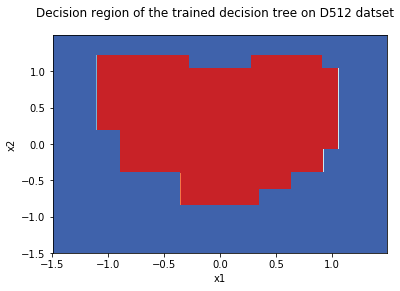

In [75]:
plot_step = 0.002
x_min, x_max = numpy_matrix[0:512, 0].min() , numpy_matrix[0:512, 0].max() 
y_min, y_max = numpy_matrix[0:512, 1].min() , numpy_matrix[0:512, 1].max() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
positions = np.vstack([xx.ravel(), yy.ravel()])
Z = test_accuracy1(tree512, xx.ravel(), yy.ravel())
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)


cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel('x1')
plt.ylabel('x2')

plt.suptitle("Decision region of the trained decision tree on D512 datset")
#plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

#labels = ['blue = label 1', 'red = label 0']

#plt.legend(loc='upper right', labels)
#plt.legend(labels)
plt.savefig('f3_d512_1.png')
plt.show()


In [ ]:
#nodes = 43

In [51]:
tree2048 = build_tree(d2048, 10000, 1)
print_tree(tree2048)

X1 >= -0.984 Information Gain=0.08300
X1 >= -0.703 Information Gain=0.04470
X1 >= 0.376 Information Gain=0.00667
X1 >= 0.400 Information Gain=0.00930
X1 >= 0.535 Information Gain=0.02433
X1 >= -1.329 Information Gain=0.04596
X1 >= 1.263 Information Gain=0.05836
X1 >= -1.089 Information Gain=0.09426
X1 >= 0.156 Information Gain=0.00077
X1 >= -0.562 Information Gain=0.03288
X1 >= -0.263 Information Gain=0.00817
X1 >= 0.351 Information Gain=0.00619
X1 >= -0.284 Information Gain=0.00951
X1 >= -0.923 Information Gain=0.07310
X1 >= -0.454 Information Gain=0.02107
X1 >= -0.809 Information Gain=0.06204
X1 >= -0.513 Information Gain=0.02801
X1 >= -0.841 Information Gain=0.06266
X1 >= 1.207 Information Gain=0.07588
X1 >= 0.729 Information Gain=0.04653
X1 >= 0.498 Information Gain=0.01997
X1 >= 0.427 Information Gain=0.01287
X1 >= -0.741 Information Gain=0.04787
X1 >= -1.180 Information Gain=0.08733
X1 >= -0.785 Information Gain=0.05621
X1 >= -0.679 Information Gain=0.04001
X1 >= 0.172 Informatio

X1 >= -1.433 Information Gain=0.01939
X1 >= -1.281 Information Gain=0.06072
X1 >= 0.143 Information Gain=0.00036
X1 >= -0.711 Information Gain=0.04592
X1 >= 0.203 Information Gain=0.00174
X1 >= -0.314 Information Gain=0.01030
X1 >= 1.427 Information Gain=0.01757
X1 >= -0.003 Information Gain=0.00088
X1 >= 0.934 Information Gain=0.08095
X1 >= 0.537 Information Gain=0.02429
X1 >= -0.539 Information Gain=0.03002
X1 >= -0.983 Information Gain=0.08378
X1 >= 0.362 Information Gain=0.00568
X1 >= -0.903 Information Gain=0.07421
X1 >= 0.333 Information Gain=0.00530
X1 >= -1.249 Information Gain=0.07266
X1 >= -0.575 Information Gain=0.03378
X1 >= -1.223 Information Gain=0.07872
X1 >= 1.282 Information Gain=0.05446
X1 >= -0.020 Information Gain=0.00105
X1 >= 0.398 Information Gain=0.00935
X1 >= 1.496 Information Gain=0.00141
X1 >= 1.320 Information Gain=0.04443
X1 >= -0.519 Information Gain=0.02820
X1 >= 0.826 Information Gain=0.05840
X1 >= 1.083 Information Gain=0.10171
X1 >= 1.044 Information G

X1 >= 1.448 Information Gain=0.01321
X1 >= -0.437 Information Gain=0.01977
X1 >= -0.832 Information Gain=0.06261
X1 >= -1.175 Information Gain=0.09023
X1 >= 0.927 Information Gain=0.07926
X1 >= -0.877 Information Gain=0.06673
X1 >= 0.567 Information Gain=0.02871
X1 >= 0.856 Information Gain=0.06674
X1 >= -0.812 Information Gain=0.06154
X1 >= 0.429 Information Gain=0.01333
X1 >= -0.110 Information Gain=0.00321
X1 >= -0.326 Information Gain=0.01150
X1 >= -0.203 Information Gain=0.00652
X1 >= 1.315 Information Gain=0.04634
X1 >= -0.695 Information Gain=0.04376
X1 >= 0.117 Information Gain=0.00003
X1 >= -0.750 Information Gain=0.04902
X1 >= 0.906 Information Gain=0.07605
X1 >= 1.190 Information Gain=0.08035
X1 >= 0.746 Information Gain=0.04902
X1 >= -0.332 Information Gain=0.01252
X1 >= 1.487 Information Gain=0.00248
X1 >= -0.314 Information Gain=0.01008
X1 >= -1.324 Information Gain=0.04865
X1 >= 0.834 Information Gain=0.06257
X1 >= -0.511 Information Gain=0.02724
X1 >= -1.431 Information

X1 >= -0.779 Information Gain=0.05609
X1 >= -0.614 Information Gain=0.03785
X1 >= 0.651 Information Gain=0.04357
X1 >= 0.925 Information Gain=0.07844
X1 >= -0.742 Information Gain=0.04859
X1 >= 1.049 Information Gain=0.09281
X1 >= -0.584 Information Gain=0.03492
X1 >= 0.498 Information Gain=0.02044
X1 >= 1.462 Information Gain=0.00997
X1 >= 1.353 Information Gain=0.03835
X1 >= -0.128 Information Gain=0.00351
X1 >= -0.066 Information Gain=0.00193
X1 >= 0.793 Information Gain=0.05569
X1 >= 0.728 Information Gain=0.04741
X1 >= 1.402 Information Gain=0.02453
X1 >= 0.655 Information Gain=0.04359
X1 >= -1.194 Information Gain=0.08568
X1 >= -0.324 Information Gain=0.01103
X1 >= -0.680 Information Gain=0.03947
X1 >= 0.535 Information Gain=0.02396
X1 >= 1.457 Information Gain=0.01069
X1 >= 0.144 Information Gain=0.00034
X1 >= -0.642 Information Gain=0.03888
X1 >= 1.498 Information Gain=0.00071
X1 >= 1.196 Information Gain=0.07954
X1 >= 0.873 Information Gain=0.06831
X1 >= 1.420 Information Gain

X1 >= 0.803 Information Gain=0.05486
X1 >= 0.765 Information Gain=0.05336
X1 >= 0.731 Information Gain=0.04781
X1 >= 0.807 Information Gain=0.05454
X1 >= -1.481 Information Gain=0.00532
X1 >= -0.768 Information Gain=0.05326
X1 >= -0.843 Information Gain=0.06536
X1 >= 0.588 Information Gain=0.03210
X1 >= 0.465 Information Gain=0.01701
X1 >= 1.309 Information Gain=0.04749
X1 >= -0.622 Information Gain=0.03862
X1 >= 1.116 Information Gain=0.09413
X1 >= -0.724 Information Gain=0.04518
X1 >= 1.346 Information Gain=0.03948
X1 >= 0.260 Information Gain=0.00280
X1 >= 0.534 Information Gain=0.02359
X1 >= -0.404 Information Gain=0.01554
X1 >= -0.270 Information Gain=0.00865
X1 >= 0.494 Information Gain=0.01936
X1 >= -0.842 Information Gain=0.06355
X1 >= -0.962 Information Gain=0.07763
X1 >= -0.662 Information Gain=0.03835
X1 >= -0.975 Information Gain=0.08141
X1 >= 0.673 Information Gain=0.04308
X1 >= -0.870 Information Gain=0.06646
X1 >= 0.466 Information Gain=0.01666
X1 >= 0.071 Information Ga

X1 >= 0.074 Information Gain=0.00000
X1 >= -1.229 Information Gain=0.07791
X1 >= 0.895 Information Gain=0.07390
X1 >= -1.436 Information Gain=0.01866
X1 >= -0.085 Information Gain=0.00207
X1 >= -0.927 Information Gain=0.07200
X1 >= -0.384 Information Gain=0.01507
X1 >= 0.623 Information Gain=0.03810
X1 >= 1.400 Information Gain=0.02564
X1 >= 0.996 Information Gain=0.08798
X1 >= -0.470 Information Gain=0.02274
X1 >= 0.118 Information Gain=0.00004
X1 >= 0.296 Information Gain=0.00418
X1 >= -1.251 Information Gain=0.07105
X1 >= 0.105 Information Gain=0.00001
X1 >= -0.098 Information Gain=0.00293
X1 >= 0.009 Information Gain=0.00059
X1 >= 0.913 Information Gain=0.07797
X1 >= -0.863 Information Gain=0.06725
X1 >= 1.136 Information Gain=0.09565
X1 >= 0.848 Information Gain=0.06382
X1 >= -0.806 Information Gain=0.06221
X1 >= 1.254 Information Gain=0.06309
X1 >= 0.202 Information Gain=0.00180
X1 >= 0.705 Information Gain=0.04449
X1 >= -1.094 Information Gain=0.09343
X1 >= 0.301 Information Gai

X1 >= 0.045 Information Gain=0.00015
X1 >= 0.791 Information Gain=0.05525
X1 >= -1.375 Information Gain=0.03458
X1 >= -0.423 Information Gain=0.01844
X1 >= -0.714 Information Gain=0.04563
X1 >= 0.331 Information Gain=0.00503
X1 >= 0.276 Information Gain=0.00415
X1 >= 0.568 Information Gain=0.02890
X1 >= -0.800 Information Gain=0.05894
X1 >= 0.272 Information Gain=0.00382
X1 >= 0.294 Information Gain=0.00426
X1 >= 1.130 Information Gain=0.09204
X1 >= -1.082 Information Gain=0.09115
X1 >= -1.233 Information Gain=0.07710
X1 >= -1.114 Information Gain=0.10128
X1 >= -0.738 Information Gain=0.04658
X1 >= -0.990 Information Gain=0.08222
X1 >= 0.589 Information Gain=0.03186
X1 >= -0.036 Information Gain=0.00122
X1 >= 1.145 Information Gain=0.09356
X1 >= -1.245 Information Gain=0.07386
X1 >= 0.028 Information Gain=0.00027
X1 >= 1.408 Information Gain=0.02232
X1 >= -0.200 Information Gain=0.00635
X1 >= 0.503 Information Gain=0.02053
X1 >= 1.145 Information Gain=0.09314
X1 >= 0.126 Information Ga

X1 >= 0.477 Information Gain=0.01825
X1 >= 0.501 Information Gain=0.02025
X1 >= -0.891 Information Gain=0.06827
X1 >= -1.189 Information Gain=0.08609
X1 >= 1.355 Information Gain=0.03797
X1 >= 0.567 Information Gain=0.02848
X1 >= -0.862 Information Gain=0.06630
X1 >= 0.548 Information Gain=0.02654
X1 >= -0.282 Information Gain=0.00930
X1 >= 0.513 Information Gain=0.02190
X1 >= 1.255 Information Gain=0.06269
X1 >= 0.041 Information Gain=0.00021
X1 >= 0.376 Information Gain=0.00678
X1 >= 0.750 Information Gain=0.04842
X1 >= -0.188 Information Gain=0.00551
X1 >= 0.651 Information Gain=0.04329
X1 >= -0.668 Information Gain=0.03998
X1 >= -0.282 Information Gain=0.00909
X1 >= 1.050 Information Gain=0.09444
X1 >= -1.277 Information Gain=0.06269
X1 >= 1.384 Information Gain=0.03083
X1 >= 0.505 Information Gain=0.02121
X1 >= -0.386 Information Gain=0.01519
X1 >= 0.332 Information Gain=0.00515
X1 >= -0.882 Information Gain=0.06735
X1 >= 0.136 Information Gain=0.00028
X1 >= -0.616 Information Gai

X2 >= -0.219 Information Gain=0.10928
X2 >= 1.082 Information Gain=0.03432
X2 >= -0.585 Information Gain=0.16843
X2 >= 0.358 Information Gain=0.02263
X2 >= -0.830 Information Gain=0.17279
X2 >= -0.161 Information Gain=0.09900
X2 >= 1.446 Information Gain=0.01575
X2 >= -1.399 Information Gain=0.02823
X2 >= 0.347 Information Gain=0.02259
X2 >= 1.324 Information Gain=0.04634
X2 >= -0.975 Information Gain=0.15352
X2 >= 1.164 Information Gain=0.05547
X2 >= 0.598 Information Gain=0.00433
X2 >= -1.412 Information Gain=0.02453
X2 >= -0.952 Information Gain=0.15961
X2 >= 0.850 Information Gain=0.00448
X2 >= 0.380 Information Gain=0.02089
X2 >= 0.446 Information Gain=0.01567
X2 >= -1.473 Information Gain=0.00710
X2 >= -0.550 Information Gain=0.15724
X2 >= -0.244 Information Gain=0.11972
X2 >= 0.412 Information Gain=0.01845
X2 >= 0.550 Information Gain=0.00782
X2 >= 0.650 Information Gain=0.00145
X2 >= 1.277 Information Gain=0.05915
X2 >= 1.259 Information Gain=0.06427
X2 >= 0.967 Information Gai

X2 >= 0.287 Information Gain=0.02988
X2 >= -0.324 Information Gain=0.12923
X2 >= 0.021 Information Gain=0.06620
X2 >= 0.148 Information Gain=0.05206
X2 >= -1.119 Information Gain=0.11010
X2 >= -1.223 Information Gain=0.07913
X2 >= 1.129 Information Gain=0.03842
X2 >= -0.449 Information Gain=0.14652
X2 >= 0.664 Information Gain=0.00078
X2 >= 0.833 Information Gain=0.00304
X2 >= 0.733 Information Gain=0.00001
X2 >= 1.049 Information Gain=0.02594
X2 >= -0.072 Information Gain=0.08402
X2 >= -1.064 Information Gain=0.12804
X2 >= 0.036 Information Gain=0.06366
X2 >= -0.983 Information Gain=0.14981
X2 >= 0.071 Information Gain=0.06095
X2 >= 1.467 Information Gain=0.01105
X2 >= -0.549 Information Gain=0.15391
X2 >= -0.666 Information Gain=0.16884
X2 >= 0.255 Information Gain=0.03427
X2 >= 0.157 Information Gain=0.04944
X2 >= -0.969 Information Gain=0.15539
X2 >= 0.168 Information Gain=0.04809
X2 >= 0.771 Information Gain=0.00073
X2 >= -0.734 Information Gain=0.17754
X2 >= -1.253 Information Ga

X2 >= -0.930 Information Gain=0.16672
X2 >= -0.101 Information Gain=0.09083
X2 >= 0.711 Information Gain=0.00004
X2 >= 0.316 Information Gain=0.02551
X2 >= -1.000 Information Gain=0.14337
X2 >= -1.333 Information Gain=0.04481
X2 >= -0.720 Information Gain=0.17804
X2 >= -1.497 Information Gain=0.00071
X2 >= 0.656 Information Gain=0.00103
X2 >= 0.238 Information Gain=0.03604
X2 >= -0.744 Information Gain=0.17758
X2 >= -0.039 Information Gain=0.07545
X2 >= 0.752 Information Gain=0.00027
X2 >= -1.180 Information Gain=0.09273
X2 >= -1.218 Information Gain=0.08158
X2 >= -0.913 Information Gain=0.16658
X2 >= 1.014 Information Gain=0.02157
X2 >= -0.140 Information Gain=0.09604
X2 >= -0.570 Information Gain=0.16534
X2 >= 0.017 Information Gain=0.06714
X2 >= 0.391 Information Gain=0.02013
X2 >= 0.598 Information Gain=0.00423
X2 >= 1.215 Information Gain=0.06240
X2 >= -1.326 Information Gain=0.04865
X2 >= 0.339 Information Gain=0.02309
X2 >= 0.619 Information Gain=0.00278
X2 >= 0.843 Information 

X2 >= 0.659 Information Gain=0.00089
X2 >= 1.262 Information Gain=0.06309
X2 >= 0.970 Information Gain=0.01295
X2 >= 0.683 Information Gain=0.00040
X2 >= 1.402 Information Gain=0.02638
X2 >= -1.479 Information Gain=0.00568
X2 >= 0.903 Information Gain=0.00695
X2 >= -0.387 Information Gain=0.14658
X2 >= -0.213 Information Gain=0.10616
X2 >= 0.879 Information Gain=0.00535
X2 >= 1.183 Information Gain=0.06144
X2 >= -0.970 Information Gain=0.15445
X2 >= 1.348 Information Gain=0.03872
X2 >= 0.245 Information Gain=0.03488
X2 >= 0.346 Information Gain=0.02238
X2 >= -0.705 Information Gain=0.17675
X2 >= -0.018 Information Gain=0.07122
X2 >= 0.279 Information Gain=0.02995
X2 >= -0.509 Information Gain=0.14872
X2 >= -0.820 Information Gain=0.17573
X2 >= -0.161 Information Gain=0.09972
X2 >= -0.539 Information Gain=0.15285
X2 >= -0.857 Information Gain=0.17588
X2 >= 0.868 Information Gain=0.00529
X2 >= 1.479 Information Gain=0.00639
X2 >= 1.480 Information Gain=0.00603
X2 >= 0.522 Information Gai

X2 >= -0.045 Information Gain=0.07710
X2 >= -0.263 Information Gain=0.11918
X2 >= 1.053 Information Gain=0.02689
X2 >= 0.257 Information Gain=0.03454
X2 >= 0.413 Information Gain=0.01790
X2 >= -0.002 Information Gain=0.07132
X2 >= -1.456 Information Gain=0.01141
X2 >= 1.049 Information Gain=0.02628
X2 >= -0.816 Information Gain=0.17622
X2 >= -0.142 Information Gain=0.09564
X2 >= -0.938 Information Gain=0.16482
X2 >= -0.583 Information Gain=0.16603
X2 >= -0.208 Information Gain=0.10709
X2 >= -0.851 Information Gain=0.16840
X2 >= 0.979 Information Gain=0.01442
X2 >= 1.102 Information Gain=0.03685
X2 >= 1.115 Information Gain=0.03708
X2 >= 0.390 Information Gain=0.02042
X2 >= 0.554 Information Gain=0.00673
X2 >= -1.156 Information Gain=0.10156
X2 >= -0.930 Information Gain=0.16625
X2 >= -0.579 Information Gain=0.16567
X2 >= -0.986 Information Gain=0.14796
X2 >= 0.236 Information Gain=0.03643
X2 >= 1.394 Information Gain=0.02860
X2 >= -0.380 Information Gain=0.14286
X2 >= 0.125 Information

X2 >= -0.468 Information Gain=0.14877
X2 >= -0.915 Information Gain=0.16610
X2 >= -1.417 Information Gain=0.02232
X2 >= -0.118 Information Gain=0.09528
X2 >= -0.588 Information Gain=0.16988
X2 >= -0.856 Information Gain=0.17686
X2 >= -0.277 Information Gain=0.12211
X2 >= -0.494 Information Gain=0.14809
X2 >= 0.192 Information Gain=0.04460
X2 >= -0.847 Information Gain=0.16937
X2 >= 0.652 Information Gain=0.00128
X2 >= 0.408 Information Gain=0.01910
X2 >= -1.079 Information Gain=0.12185
X2 >= 0.569 Information Gain=0.00535
X2 >= 1.159 Information Gain=0.05583
X2 >= 0.768 Information Gain=0.00071
X2 >= -0.907 Information Gain=0.16946
X2 >= 1.159 Information Gain=0.05302
X2 >= -0.176 Information Gain=0.10257
X2 >= 1.271 Information Gain=0.06072
X2 >= -0.104 Information Gain=0.09138
X2 >= 0.826 Information Gain=0.00307
X2 >= -0.459 Information Gain=0.14891
X2 >= 0.003 Information Gain=0.06941
X2 >= -0.741 Information Gain=0.17808
X2 >= -0.432 Information Gain=0.14595
X2 >= 1.331 Informatio

X2 >= 0.055 Information Gain=0.06081
X2 >= 0.628 Information Gain=0.00202
X2 >= 1.467 Information Gain=0.01033
X2 >= -1.144 Information Gain=0.10453
X2 >= 1.393 Information Gain=0.02897
X2 >= 0.173 Information Gain=0.04675
X2 >= -0.626 Information Gain=0.16400
X2 >= -1.278 Information Gain=0.06546
X2 >= -1.239 Information Gain=0.07548
X2 >= -0.092 Information Gain=0.08908
X2 >= 1.137 Information Gain=0.04122
X2 >= -1.103 Information Gain=0.11485
X2 >= -0.674 Information Gain=0.17292
X2 >= -1.079 Information Gain=0.12141
X2 >= 0.764 Information Gain=0.00056
X2 >= -1.171 Information Gain=0.09649
X2 >= -0.648 Information Gain=0.16692
X2 >= -1.330 Information Gain=0.04634
X2 >= -0.821 Information Gain=0.17475
X2 >= 0.303 Information Gain=0.02626
X2 >= 0.459 Information Gain=0.01494
X2 >= 0.961 Information Gain=0.01143
X2 >= 0.836 Information Gain=0.00301
X2 >= -0.518 Information Gain=0.15108
X2 >= 0.382 Information Gain=0.02110
X2 >= 0.279 Information Gain=0.03066
X2 >= 1.296 Information G

X1 >= -1.041 Information Gain=0.12659
X1 >= -0.809 Information Gain=0.09152
X1 >= -0.548 Information Gain=0.04313
X1 >= -1.240 Information Gain=0.10417
X1 >= 1.375 Information Gain=0.05591
X1 >= 1.060 Information Gain=0.16035
X1 >= -0.826 Information Gain=0.09386
X1 >= -1.294 Information Gain=0.08081
X1 >= -0.129 Information Gain=0.00256
X1 >= -0.261 Information Gain=0.00763
X1 >= -0.337 Information Gain=0.01449
X1 >= -1.202 Information Gain=0.12241
X1 >= 0.966 Information Gain=0.13812
X1 >= 0.271 Information Gain=0.00688
X1 >= 1.461 Information Gain=0.01791
X1 >= 0.993 Information Gain=0.14495
X1 >= -0.125 Information Gain=0.00245
X1 >= 0.540 Information Gain=0.04251
X1 >= -0.868 Information Gain=0.09908
X1 >= -0.754 Information Gain=0.07372
X1 >= -1.091 Information Gain=0.13854
X1 >= 0.814 Information Gain=0.09667
X1 >= -0.107 Information Gain=0.00207
X1 >= -1.169 Information Gain=0.13085
X1 >= -0.298 Information Gain=0.01040
X1 >= -0.604 Information Gain=0.05118
X1 >= -1.069 Informa

X1 >= 0.416 Information Gain=0.01976
X1 >= -0.803 Information Gain=0.08930
X1 >= -1.305 Information Gain=0.07687
X1 >= -0.690 Information Gain=0.06120
X1 >= 0.937 Information Gain=0.13659
X1 >= 0.911 Information Gain=0.13077
X1 >= 0.863 Information Gain=0.11505
X1 >= 1.065 Information Gain=0.16449
X1 >= 0.271 Information Gain=0.00670
X1 >= 0.327 Information Gain=0.00917
X1 >= 0.053 Information Gain=0.00000
X1 >= 0.305 Information Gain=0.00838
X1 >= 0.060 Information Gain=0.00000
X1 >= 0.454 Information Gain=0.02724
X1 >= 0.742 Information Gain=0.08476
X1 >= 0.935 Information Gain=0.13569
X1 >= 0.878 Information Gain=0.11726
X1 >= 1.045 Information Gain=0.15498
X1 >= 0.073 Information Gain=0.00003
X1 >= 0.678 Information Gain=0.07614
X1 >= -1.469 Information Gain=0.00998
X1 >= 0.701 Information Gain=0.07941
X1 >= 1.428 Information Gain=0.02888
X1 >= -0.670 Information Gain=0.05805
X1 >= 0.447 Information Gain=0.02608
X1 >= -0.619 Information Gain=0.05383
X1 >= 1.073 Information Gain=0.1

X1 >= 0.504 Information Gain=0.03631
X1 >= 0.967 Information Gain=0.13728
X1 >= -0.908 Information Gain=0.11020
X1 >= -0.338 Information Gain=0.01478
X1 >= -0.113 Information Gain=0.00215
X1 >= 1.211 Information Gain=0.12241
X1 >= 0.688 Information Gain=0.07966
X1 >= 0.002 Information Gain=0.00025
X1 >= -0.846 Information Gain=0.09900
X1 >= 0.269 Information Gain=0.00600
X1 >= -0.844 Information Gain=0.09657
X1 >= -0.166 Information Gain=0.00321
X1 >= 0.123 Information Gain=0.00031
X1 >= -0.124 Information Gain=0.00235
X1 >= 1.371 Information Gain=0.05744
X1 >= -0.785 Information Gain=0.08385
X1 >= 1.283 Information Gain=0.08718
X1 >= 1.379 Information Gain=0.05361
X1 >= -0.411 Information Gain=0.02077
X1 >= -0.725 Information Gain=0.06680
X1 >= -1.002 Information Gain=0.11905
X1 >= 1.155 Information Gain=0.14806
X1 >= 0.024 Information Gain=0.00008
X1 >= 1.430 Information Gain=0.02667
X1 >= -0.318 Information Gain=0.01159
X1 >= -0.618 Information Gain=0.05318
X1 >= 1.062 Information G

X1 >= 0.848 Information Gain=0.10825
X1 >= -0.806 Information Gain=0.09144
X1 >= 1.254 Information Gain=0.10253
X1 >= -1.094 Information Gain=0.13768
X1 >= -0.459 Information Gain=0.02888
X1 >= -0.354 Information Gain=0.01684
X1 >= 0.631 Information Gain=0.06808
X1 >= -1.425 Information Gain=0.03036
X1 >= 0.746 Information Gain=0.08501
X1 >= -0.811 Information Gain=0.09081
X1 >= 0.311 Information Gain=0.00877
X1 >= -0.727 Information Gain=0.06760
X1 >= -0.629 Information Gain=0.05340
X1 >= 0.994 Information Gain=0.14708
X1 >= -0.743 Information Gain=0.07113
X1 >= -1.397 Information Gain=0.04002
X1 >= 0.393 Information Gain=0.01581
X1 >= 1.311 Information Gain=0.07765
X1 >= 0.632 Information Gain=0.07107
X1 >= -0.032 Information Gain=0.00044
X1 >= -0.586 Information Gain=0.04854
X1 >= -0.688 Information Gain=0.06047
X1 >= 0.236 Information Gain=0.00447
X1 >= 0.378 Information Gain=0.01363
X1 >= -0.742 Information Gain=0.07239
X1 >= 0.566 Information Gain=0.04864
X1 >= -0.304 Information

X1 >= -0.787 Information Gain=0.08349
X1 >= -1.163 Information Gain=0.13426
X1 >= 1.188 Information Gain=0.13256
X1 >= -0.365 Information Gain=0.01777
X1 >= 0.619 Information Gain=0.06227
X1 >= 1.369 Information Gain=0.05897
X1 >= 0.477 Information Gain=0.03051
X1 >= 0.501 Information Gain=0.03536
X1 >= -0.891 Information Gain=0.10127
X1 >= -1.189 Information Gain=0.12493
X1 >= 1.355 Information Gain=0.06360
X1 >= 0.567 Information Gain=0.04922
X1 >= 0.548 Information Gain=0.04572
X1 >= -0.282 Information Gain=0.00906
X1 >= 1.255 Information Gain=0.10171
X1 >= 0.041 Information Gain=0.00001
X1 >= 0.750 Information Gain=0.08526
X1 >= -0.188 Information Gain=0.00412
X1 >= 0.651 Information Gain=0.07432
X1 >= 1.050 Information Gain=0.15605
X1 >= -1.277 Information Gain=0.08558
X1 >= 1.384 Information Gain=0.05133
X1 >= 0.505 Information Gain=0.03678
X1 >= -0.386 Information Gain=0.01841
X1 >= 0.332 Information Gain=0.00957
X1 >= -0.882 Information Gain=0.10089
X1 >= -0.616 Information Gai

X2 >= 0.380 Information Gain=0.00127
X2 >= 0.446 Information Gain=0.00255
X2 >= -0.550 Information Gain=0.01071
X2 >= -0.244 Information Gain=0.01333
X2 >= 0.412 Information Gain=0.00182
X2 >= 0.550 Information Gain=0.00642
X2 >= 0.650 Information Gain=0.01632
X2 >= 1.277 Information Gain=0.12241
X2 >= 1.259 Information Gain=0.13341
X2 >= 0.967 Information Gain=0.06337
X2 >= 1.334 Information Gain=0.08638
X2 >= 0.182 Information Gain=0.00048
X2 >= 0.799 Information Gain=0.03853
X2 >= 1.207 Information Gain=0.13998
X2 >= -0.420 Information Gain=0.01585
X2 >= 1.336 Information Gain=0.08558
X2 >= 0.298 Information Gain=0.00055
X2 >= 0.968 Information Gain=0.06496
X2 >= 0.850 Information Gain=0.04889
X2 >= 0.337 Information Gain=0.00107
X2 >= 0.144 Information Gain=0.00117
X2 >= 1.422 Information Gain=0.04227
X2 >= 0.894 Information Gain=0.05353
X2 >= 0.615 Information Gain=0.01204
X2 >= -0.557 Information Gain=0.01136
X2 >= -0.131 Information Gain=0.00816
X2 >= 0.732 Information Gain=0.02

X2 >= 1.218 Information Gain=0.13570
X2 >= 1.010 Information Gain=0.08276
X2 >= 0.683 Information Gain=0.02105
X2 >= 1.001 Information Gain=0.07917
X2 >= 1.362 Information Gain=0.07294
X2 >= -0.228 Information Gain=0.01079
X2 >= 0.820 Information Gain=0.04405
X2 >= 0.298 Information Gain=0.00050
X2 >= 0.263 Information Gain=0.00001
X2 >= -0.514 Information Gain=0.00989
X2 >= -0.713 Information Gain=0.00012
X2 >= 1.013 Information Gain=0.08310
X2 >= 1.106 Information Gain=0.10628
X2 >= 1.399 Information Gain=0.05438
X2 >= 1.176 Information Gain=0.13337
X2 >= -0.097 Information Gain=0.00724
X2 >= 0.942 Information Gain=0.06362
X2 >= -0.055 Information Gain=0.00479
X2 >= -0.155 Information Gain=0.00795
X2 >= 1.155 Information Gain=0.13023
X2 >= 1.232 Information Gain=0.14545
X2 >= -0.640 Information Gain=0.00511
X2 >= 1.030 Information Gain=0.08771
X2 >= 1.457 Information Gain=0.02741
X2 >= 1.090 Information Gain=0.11089
X2 >= 1.388 Information Gain=0.06128
X2 >= 1.145 Information Gain=0.

X2 >= 0.185 Information Gain=0.00049
X2 >= 0.433 Information Gain=0.00258
X2 >= 0.556 Information Gain=0.00790
X2 >= -0.679 Information Gain=0.00423
X2 >= 0.975 Information Gain=0.06932
X2 >= 1.480 Information Gain=0.01141
X2 >= -0.602 Information Gain=0.01069
X2 >= -0.232 Information Gain=0.01140
X2 >= -0.219 Information Gain=0.01043
X2 >= -0.702 Information Gain=0.00097
X2 >= -0.478 Information Gain=0.01266
X2 >= -0.462 Information Gain=0.01428
X2 >= -0.074 Information Gain=0.00603
X2 >= 0.202 Information Gain=0.00016
X2 >= -0.460 Information Gain=0.01418
X2 >= 1.193 Information Gain=0.14069
X2 >= -0.643 Information Gain=0.00337
X2 >= 1.428 Information Gain=0.03703
X2 >= 1.126 Information Gain=0.10692
X2 >= 0.062 Information Gain=0.00164
X2 >= 0.152 Information Gain=0.00105
X2 >= 0.003 Information Gain=0.00323
X2 >= 1.376 Information Gain=0.06592
X2 >= 0.822 Information Gain=0.04461
X2 >= -0.240 Information Gain=0.01268
X2 >= -0.576 Information Gain=0.01213
X2 >= 0.356 Information Ga

X2 >= 0.155 Information Gain=0.00091
X2 >= 1.024 Information Gain=0.08663
X2 >= 0.359 Information Gain=0.00117
X2 >= 0.185 Information Gain=0.00044
X2 >= 0.788 Information Gain=0.03602
X2 >= 0.331 Information Gain=0.00101
X2 >= 1.141 Information Gain=0.11667
X2 >= -0.280 Information Gain=0.01370
X2 >= 1.133 Information Gain=0.11151
X2 >= 0.182 Information Gain=0.00058
X2 >= 1.078 Information Gain=0.10260
X2 >= -0.304 Information Gain=0.01366
X2 >= -0.014 Information Gain=0.00320
X2 >= -0.659 Information Gain=0.00292
X2 >= 1.376 Information Gain=0.06670
X2 >= 1.373 Information Gain=0.06747
X2 >= 0.190 Information Gain=0.00040
X2 >= 0.556 Information Gain=0.00771
X2 >= 0.506 Information Gain=0.00403
X2 >= 0.443 Information Gain=0.00233
X2 >= 0.714 Information Gain=0.02579
X2 >= -0.702 Information Gain=0.00106
X2 >= 0.277 Information Gain=0.00012
X2 >= 0.724 Information Gain=0.02697
X2 >= 1.255 Information Gain=0.13512
X2 >= -0.038 Information Gain=0.00357
X2 >= 0.766 Information Gain=0.0

X2 >= 0.297 Information Gain=0.00046
X2 >= 1.500 Information Gain=0.00071
X2 >= 1.088 Information Gain=0.10733
X2 >= -0.583 Information Gain=0.01004
X2 >= 1.130 Information Gain=0.10992
X2 >= 0.582 Information Gain=0.00909
X2 >= 1.306 Information Gain=0.10335
X2 >= 1.079 Information Gain=0.10185
X2 >= 0.045 Information Gain=0.00210
X2 >= 1.282 Information Gain=0.11822
X2 >= 1.280 Information Gain=0.12073
X2 >= 0.759 Information Gain=0.03295
X2 >= 0.011 Information Gain=0.00285
X2 >= 1.246 Information Gain=0.14027
X2 >= 1.148 Information Gain=0.12255
X2 >= 1.448 Information Gain=0.03110
X2 >= 0.142 Information Gain=0.00125
X2 >= 0.984 Information Gain=0.07550
X2 >= 0.559 Information Gain=0.00850
X2 >= -0.619 Information Gain=0.00541
X2 >= 0.413 Information Gain=0.00191
X2 >= 0.671 Information Gain=0.02038
X2 >= 1.282 Information Gain=0.11905
X2 >= 1.476 Information Gain=0.01647
X2 >= -0.259 Information Gain=0.01246
X2 >= 0.824 Information Gain=0.04418
X2 >= -0.431 Information Gain=0.014

X1 >= 0.129 Information Gain=0.02850
X1 >= 0.603 Information Gain=0.00011
X1 >= -0.264 Information Gain=0.06339
X1 >= 0.308 Information Gain=0.01163
X1 >= 0.406 Information Gain=0.00543
X1 >= -1.497 Information Gain=0.00000
X1 >= -0.885 Information Gain=0.19294
X1 >= -0.974 Information Gain=0.20607
X1 >= -1.124 Information Gain=0.22861
X1 >= 0.363 Information Gain=0.00976
X1 >= 0.397 Information Gain=0.00615
X1 >= 0.827 Information Gain=0.00242
X1 >= -0.545 Information Gain=0.12432
X1 >= -1.325 Information Gain=0.10599
X1 >= -0.805 Information Gain=0.18609
X1 >= 0.149 Information Gain=0.02712
X1 >= -0.249 Information Gain=0.06068
X1 >= 0.632 Information Gain=0.00110
X1 >= 0.980 Information Gain=0.00301
X1 >= 0.424 Information Gain=0.00403
X1 >= -0.926 Information Gain=0.20078
X1 >= -0.730 Information Gain=0.15527
X1 >= 0.990 Information Gain=0.00381
X1 >= -0.859 Information Gain=0.19251
X1 >= 0.441 Information Gain=0.00314
X1 >= -0.295 Information Gain=0.06753
X1 >= -0.015 Information 

X1 >= -0.547 Information Gain=0.12523
X1 >= 0.340 Information Gain=0.01068
X1 >= 0.525 Information Gain=0.00037
X1 >= 0.419 Information Gain=0.00448
X1 >= -1.404 Information Gain=0.05526
X1 >= -0.177 Information Gain=0.05128
X1 >= -1.151 Information Gain=0.21966
X1 >= -0.749 Information Gain=0.16244
X1 >= 0.887 Information Gain=0.00522
X1 >= 1.015 Information Gain=0.00374
X1 >= -0.715 Information Gain=0.15803
X1 >= 0.294 Information Gain=0.01198
X1 >= 0.583 Information Gain=0.00003
X1 >= 0.614 Information Gain=0.00028
X1 >= 0.093 Information Gain=0.03273
X1 >= -0.342 Information Gain=0.07994
X1 >= -1.000 Information Gain=0.21067
X1 >= 0.482 Information Gain=0.00169
X1 >= -1.440 Information Gain=0.03717
X1 >= -1.444 Information Gain=0.03493
X1 >= 0.014 Information Gain=0.03569
X1 >= -0.119 Information Gain=0.04722
X1 >= -0.042 Information Gain=0.04049
X1 >= -1.089 Information Gain=0.22653
X1 >= -0.442 Information Gain=0.09757
X1 >= -1.058 Information Gain=0.21915
X1 >= -0.674 Informatio

X1 >= -0.417 Information Gain=0.09020
X1 >= -1.100 Information Gain=0.22751
X1 >= -0.472 Information Gain=0.10652
X1 >= -1.379 Information Gain=0.07026
X1 >= -0.428 Information Gain=0.09390
X1 >= 0.015 Information Gain=0.03636
X1 >= 0.153 Information Gain=0.02544
X1 >= 0.470 Information Gain=0.00168
X1 >= -0.686 Information Gain=0.14703
X1 >= 0.997 Information Gain=0.00485
X1 >= -0.803 Information Gain=0.18312
X1 >= -1.218 Information Gain=0.17725
X1 >= 0.572 Information Gain=0.00000
X1 >= -1.445 Information Gain=0.03271
X1 >= -1.031 Information Gain=0.20969
X1 >= -0.059 Information Gain=0.04275
X1 >= 0.449 Information Gain=0.00241
X1 >= 0.898 Information Gain=0.00625
X1 >= 0.998 Information Gain=0.00428
X1 >= 0.521 Information Gain=0.00054
X1 >= 0.760 Information Gain=0.00221
X1 >= 0.392 Information Gain=0.00724
X1 >= -0.809 Information Gain=0.18506
X1 >= 0.187 Information Gain=0.02209
X1 >= -1.145 Information Gain=0.22672
X1 >= 0.817 Information Gain=0.00236
X1 >= -0.822 Information 

X1 >= -0.152 Information Gain=0.05258
X1 >= -0.136 Information Gain=0.04954
X1 >= -1.031 Information Gain=0.21227
X1 >= -1.313 Information Gain=0.11332
X1 >= 0.541 Information Gain=0.00023
X1 >= -0.575 Information Gain=0.13028
X1 >= -0.261 Information Gain=0.06284
X1 >= -1.239 Information Gain=0.16536
X1 >= 0.440 Information Gain=0.00327
X1 >= -1.439 Information Gain=0.03941
X1 >= 0.350 Information Gain=0.01041
X1 >= 0.797 Information Gain=0.00251
X1 >= -0.511 Information Gain=0.11610
X1 >= 0.198 Information Gain=0.02056
X1 >= 0.571 Information Gain=0.00000
X1 >= -1.065 Information Gain=0.22728
X1 >= 0.271 Information Gain=0.01423
X1 >= 0.018 Information Gain=0.03693
X1 >= -0.604 Information Gain=0.13934
X1 >= 0.744 Information Gain=0.00141
X1 >= -1.452 Information Gain=0.02166
X1 >= 0.261 Information Gain=0.01578
X1 >= -0.775 Information Gain=0.17822
X1 >= -0.376 Information Gain=0.08426
X1 >= -1.371 Information Gain=0.07611
X1 >= 0.517 Information Gain=0.00056
X1 >= 0.726 Information

X2 >= 1.338 Information Gain=0.10355
X2 >= 0.917 Information Gain=0.07529
X2 >= 0.794 Information Gain=0.04570
X2 >= 1.314 Information Gain=0.12321
X2 >= 0.369 Information Gain=0.00097
X2 >= -0.128 Information Gain=0.01096
X2 >= -0.264 Information Gain=0.01656
X2 >= 0.279 Information Gain=0.00010
X2 >= -0.099 Information Gain=0.00945
X2 >= -0.059 Information Gain=0.00744
X2 >= -0.075 Information Gain=0.00908
X2 >= 0.277 Information Gain=0.00006
X2 >= 1.169 Information Gain=0.17678
X2 >= -0.118 Information Gain=0.01064
X2 >= -0.313 Information Gain=0.01821
X2 >= -0.099 Information Gain=0.00921
X2 >= -0.224 Information Gain=0.01416
X2 >= 1.488 Information Gain=0.00859
X2 >= 1.461 Information Gain=0.03271
X2 >= -0.039 Information Gain=0.00616
X2 >= -0.610 Information Gain=0.01123
X2 >= -0.076 Information Gain=0.00876
X2 >= 1.247 Information Gain=0.17592
X2 >= 0.182 Information Gain=0.00111
X2 >= -0.670 Information Gain=0.00429
X2 >= -0.088 Information Gain=0.00914
X2 >= 1.017 Information 

X2 >= 0.618 Information Gain=0.01405
X2 >= -0.456 Information Gain=0.02293
X2 >= -0.583 Information Gain=0.01681
X2 >= 0.924 Information Gain=0.07685
X2 >= 0.922 Information Gain=0.07520
X2 >= 1.469 Information Gain=0.02386
X2 >= -0.639 Information Gain=0.00831
X2 >= 1.201 Information Gain=0.18216
X2 >= -0.661 Information Gain=0.00376
X2 >= -0.577 Information Gain=0.01949
X2 >= -0.017 Information Gain=0.00470
X2 >= -0.332 Information Gain=0.01722
X2 >= -0.192 Information Gain=0.01416
X2 >= 0.021 Information Gain=0.00440
X2 >= 0.809 Information Gain=0.05019
X2 >= 0.094 Information Gain=0.00345
X2 >= -0.585 Information Gain=0.01836
X2 >= -0.421 Information Gain=0.02280
X2 >= -0.319 Information Gain=0.01760
X2 >= 0.047 Information Gain=0.00335
X2 >= -0.403 Information Gain=0.02414
X2 >= 0.288 Information Gain=0.00014
X2 >= 0.068 Information Gain=0.00351
X2 >= 0.321 Information Gain=0.00059
X2 >= 1.484 Information Gain=0.01293
X2 >= 1.128 Information Gain=0.13998
X2 >= 1.344 Information Ga

X2 >= -0.582 Information Gain=0.01749
X2 >= -0.263 Information Gain=0.01619
X2 >= -0.456 Information Gain=0.02231
X2 >= 1.178 Information Gain=0.17281
X2 >= -0.088 Information Gain=0.00891
X2 >= 0.406 Information Gain=0.00137
X2 >= 1.058 Information Gain=0.12447
X2 >= -0.484 Information Gain=0.02026
X2 >= -0.678 Information Gain=0.00584
X2 >= 0.181 Information Gain=0.00126
X2 >= 1.341 Information Gain=0.09992
X2 >= -0.225 Information Gain=0.01449
X2 >= 0.619 Information Gain=0.01458
X2 >= -0.482 Information Gain=0.01970
X2 >= 0.279 Information Gain=0.00011
X2 >= 1.384 Information Gain=0.07611
X2 >= -0.521 Information Gain=0.01633
X2 >= -0.355 Information Gain=0.01867
X2 >= 0.197 Information Gain=0.00070
X2 >= 0.242 Information Gain=0.00006
X2 >= -0.441 Information Gain=0.02136
X2 >= -0.227 Information Gain=0.01362
X2 >= 0.856 Information Gain=0.06239
X2 >= -0.442 Information Gain=0.02185
X2 >= 1.331 Information Gain=0.10965
X2 >= 1.240 Information Gain=0.18260
X2 >= 0.661 Information G

X2 >= 0.001 Information Gain=0.00462
X2 >= 0.216 Information Gain=0.00037
X2 >= 0.074 Information Gain=0.00371
X2 >= -0.178 Information Gain=0.01284
X2 >= -0.619 Information Gain=0.00765
X2 >= 0.547 Information Gain=0.00612
X2 >= 0.139 Information Gain=0.00264
X2 >= 1.475 Information Gain=0.02056
X2 >= 0.032 Information Gain=0.00382
X2 >= 1.389 Information Gain=0.07026
X2 >= 0.577 Information Gain=0.01008
X2 >= 0.667 Information Gain=0.02320
X2 >= -0.468 Information Gain=0.02152
X2 >= 0.843 Information Gain=0.05670
X2 >= 0.522 Information Gain=0.00558
X2 >= 0.552 Information Gain=0.00745
X2 >= 0.297 Information Gain=0.00033
X2 >= 1.500 Information Gain=0.00107
X2 >= 1.088 Information Gain=0.13903
X2 >= -0.583 Information Gain=0.01615
X2 >= 1.130 Information Gain=0.14356
X2 >= 1.306 Information Gain=0.12695
X2 >= 1.079 Information Gain=0.13270
X2 >= 1.282 Information Gain=0.14849
X2 >= 1.280 Information Gain=0.15235
X2 >= 0.759 Information Gain=0.03806
X2 >= 0.011 Information Gain=0.004

X1 >= 0.937 Information Gain=0.01895
X1 >= 0.911 Information Gain=0.02270
X1 >= 0.863 Information Gain=0.02131
X1 >= 0.271 Information Gain=0.00075
X1 >= 0.327 Information Gain=0.00095
X1 >= 0.053 Information Gain=0.00044
X1 >= 0.305 Information Gain=0.00099
X1 >= 0.060 Information Gain=0.00046
X1 >= 0.454 Information Gain=0.00643
X1 >= 0.742 Information Gain=0.01704
X1 >= 0.935 Information Gain=0.01927
X1 >= 0.878 Information Gain=0.01980
X1 >= 1.045 Information Gain=0.00236
X1 >= 0.073 Information Gain=0.00037
X1 >= 0.678 Information Gain=0.01885
X1 >= 0.701 Information Gain=0.01849
X1 >= -0.670 Information Gain=0.02125
X1 >= 0.447 Information Gain=0.00616
X1 >= -0.619 Information Gain=0.02213
X1 >= 0.577 Information Gain=0.01252
X1 >= 0.272 Information Gain=0.00092
X1 >= -0.209 Information Gain=0.00195
X1 >= 0.482 Information Gain=0.00697
X1 >= -0.437 Information Gain=0.00927
X1 >= -0.832 Information Gain=0.02582
X1 >= 0.927 Information Gain=0.01992
X1 >= -0.877 Information Gain=0.0

X1 >= -0.663 Information Gain=0.02208
X1 >= -0.693 Information Gain=0.02338
X1 >= 0.563 Information Gain=0.01188
X1 >= 0.506 Information Gain=0.00934
X1 >= 0.772 Information Gain=0.01939
X1 >= -0.225 Information Gain=0.00217
X1 >= 0.719 Information Gain=0.01771
X1 >= -0.557 Information Gain=0.01901
X1 >= 0.870 Information Gain=0.01958
X1 >= -0.375 Information Gain=0.00650
X1 >= -0.975 Information Gain=0.01584
X1 >= -0.144 Information Gain=0.00154
X1 >= 0.626 Information Gain=0.01707
X1 >= -0.138 Information Gain=0.00166
X1 >= 0.267 Information Gain=0.00046
X1 >= -0.221 Information Gain=0.00199
X1 >= -0.665 Information Gain=0.02167
X1 >= -0.662 Information Gain=0.02168
X1 >= 0.676 Information Gain=0.01846
X1 >= 0.097 Information Gain=0.00069
X1 >= 0.557 Information Gain=0.01168
X1 >= 0.390 Information Gain=0.00249
X1 >= 0.431 Information Gain=0.00541
X1 >= -0.308 Information Gain=0.00395
X1 >= 0.400 Information Gain=0.00281
X1 >= -0.576 Information Gain=0.01927
X1 >= -0.001 Information 

X1 >= 0.042 Information Gain=0.00049
X1 >= -0.041 Information Gain=0.00064
X1 >= 0.906 Information Gain=0.02196
X1 >= -0.721 Information Gain=0.02263
X1 >= -0.808 Information Gain=0.02826
X1 >= 1.023 Information Gain=0.00864
X1 >= 0.380 Information Gain=0.00200
X1 >= 0.184 Information Gain=0.00000
X1 >= 0.810 Information Gain=0.01550
X1 >= -0.338 Information Gain=0.00572
X1 >= 0.852 Information Gain=0.02051
X1 >= -0.363 Information Gain=0.00683
X1 >= 0.229 Information Gain=0.00035
X1 >= 0.315 Information Gain=0.00072
X1 >= 0.834 Information Gain=0.01817
X1 >= -0.427 Information Gain=0.00801
X1 >= 0.570 Information Gain=0.01236
X1 >= 0.436 Information Gain=0.00557
X1 >= 0.544 Information Gain=0.01016
X1 >= -0.108 Information Gain=0.00130
X1 >= -0.676 Information Gain=0.02004
X1 >= -1.024 Information Gain=0.00853
X1 >= 0.849 Information Gain=0.01938
X1 >= -0.290 Information Gain=0.00370
X1 >= 0.275 Information Gain=0.00094
X1 >= 0.718 Information Gain=0.01732
X1 >= 0.026 Information Gain

X2 >= -0.367 Information Gain=0.02949
X2 >= 1.182 Information Gain=0.26623
X2 >= 1.146 Information Gain=0.24321
X2 >= 1.479 Information Gain=0.02424
X2 >= 0.673 Information Gain=0.04924
X2 >= 0.575 Information Gain=0.02734
X2 >= 0.198 Information Gain=0.00000
X2 >= 0.870 Information Gain=0.11591
X2 >= 1.201 Information Gain=0.27244
X2 >= 1.274 Information Gain=0.22869
X2 >= 0.708 Information Gain=0.05819
X2 >= 0.259 Information Gain=0.00060
X2 >= 0.413 Information Gain=0.00809
X2 >= -0.000 Information Gain=0.00610
X2 >= 1.137 Information Gain=0.23800
X2 >= 0.991 Information Gain=0.17216
X2 >= -0.121 Information Gain=0.01497
X2 >= 0.272 Information Gain=0.00097
X2 >= 0.539 Information Gain=0.01948
X2 >= 0.391 Information Gain=0.00661
X2 >= -0.149 Information Gain=0.01707
X2 >= 0.720 Information Gain=0.06195
X2 >= 0.842 Information Gain=0.10323
X2 >= -0.603 Information Gain=0.02058
X2 >= 0.704 Information Gain=0.05612
X2 >= -0.635 Information Gain=0.01177
X2 >= 0.923 Information Gain=0.1

X2 >= -0.277 Information Gain=0.02461
X2 >= 1.151 Information Gain=0.24958
X2 >= 0.606 Information Gain=0.03257
X2 >= 0.929 Information Gain=0.13913
X2 >= 0.970 Information Gain=0.15828
X2 >= 0.876 Information Gain=0.11680
X2 >= 0.981 Information Gain=0.16696
X2 >= 0.628 Information Gain=0.03794
X2 >= -0.157 Information Gain=0.01770
X2 >= 1.150 Information Gain=0.24913
X2 >= -0.316 Information Gain=0.02606
X2 >= 1.290 Information Gain=0.19818
X2 >= -0.212 Information Gain=0.01971
X2 >= 0.222 Information Gain=0.00016
X2 >= 0.080 Information Gain=0.00305
X2 >= 0.047 Information Gain=0.00408
X2 >= 1.264 Information Gain=0.24211
X2 >= 0.050 Information Gain=0.00357
X2 >= 1.423 Information Gain=0.07107
X2 >= -0.534 Information Gain=0.02169
X2 >= -0.641 Information Gain=0.01084
X2 >= -0.363 Information Gain=0.02993
X2 >= -0.457 Information Gain=0.03247
X2 >= 1.354 Information Gain=0.13230
X2 >= 0.514 Information Gain=0.01735
X2 >= 1.149 Information Gain=0.25146
X2 >= 0.711 Information Gain=0

X2 >= -0.462 Information Gain=0.03098
X2 >= 0.220 Information Gain=0.00012
X2 >= 1.451 Information Gain=0.05277
X2 >= 0.340 Information Gain=0.00409
X2 >= 0.802 Information Gain=0.08885
X2 >= -0.231 Information Gain=0.02181
X2 >= 0.305 Information Gain=0.00295
X2 >= 1.128 Information Gain=0.22684
X2 >= 0.739 Information Gain=0.06701
X2 >= 1.245 Information Gain=0.26498
X2 >= 1.219 Information Gain=0.26510
X2 >= -0.282 Information Gain=0.02419
X2 >= -0.221 Information Gain=0.02071
X2 >= 0.853 Information Gain=0.11240
X2 >= 0.770 Information Gain=0.07672
X2 >= -0.640 Information Gain=0.01189
X2 >= 0.939 Information Gain=0.14341
X2 >= 0.549 Information Gain=0.02174
X2 >= 1.146 Information Gain=0.24839
X2 >= 1.339 Information Gain=0.15235
X2 >= -0.082 Information Gain=0.01324
X2 >= -0.111 Information Gain=0.01384
X2 >= 0.508 Information Gain=0.01633
X2 >= -0.031 Information Gain=0.00724
X2 >= 1.004 Information Gain=0.18031
X2 >= -0.146 Information Gain=0.01676
X2 >= 0.834 Information Gain=

X2 >= 1.193 Information Gain=0.00000
X2 >= 1.428 Information Gain=0.01494
X2 >= 1.376 Information Gain=0.02799
X2 >= 1.395 Information Gain=0.02293
X2 >= 1.478 Information Gain=0.00558
X2 >= 1.290 Information Gain=0.06425
X2 >= 1.466 Information Gain=0.00964
X2 >= 1.290 Information Gain=0.06093
X2 >= 1.264 Information Gain=0.08826
X2 >= 1.423 Information Gain=0.01636
X2 >= 1.354 Information Gain=0.03423
X2 >= 1.295 Information Gain=0.05882
X2 >= 1.341 Information Gain=0.03978
X2 >= 1.331 Information Gain=0.04515
X2 >= 1.240 Information Gain=0.11239
X2 >= 1.201 Information Gain=0.00900
X2 >= 1.420 Information Gain=0.01780
X2 >= 1.394 Information Gain=0.02347
X2 >= 1.468 Information Gain=0.00798
X2 >= 1.351 Information Gain=0.03624
X2 >= 1.414 Information Gain=0.01980
X2 >= 1.457 Information Gain=0.01135
X2 >= 1.320 Information Gain=0.04934
X2 >= 1.272 Information Gain=0.08004
X2 >= 1.445 Information Gain=0.01267
X2 >= 1.486 Information Gain=0.00328
X2 >= 1.414 Information Gain=0.02031
X

X1 >= 0.642 Information Gain=0.03849
X1 >= 0.373 Information Gain=0.00540
X1 >= -0.902 Information Gain=0.03670
X1 >= 0.502 Information Gain=0.01975
X1 >= 0.529 Information Gain=0.02274
X1 >= 0.916 Information Gain=0.03435
X1 >= 0.541 Information Gain=0.02553
X1 >= 0.045 Information Gain=0.00076
X1 >= -0.669 Information Gain=0.03974
X1 >= -0.461 Information Gain=0.02446
X1 >= -0.099 Information Gain=0.00349
X1 >= 0.619 Information Gain=0.03351
X1 >= -0.768 Information Gain=0.04380
X1 >= 0.785 Information Gain=0.03920
X1 >= 0.112 Information Gain=0.00018
X1 >= 0.523 Information Gain=0.02226
X1 >= -1.036 Information Gain=0.01417
X1 >= 0.199 Information Gain=0.00031
X1 >= -0.182 Information Gain=0.00505
X1 >= -0.207 Information Gain=0.00631
X1 >= 0.271 Information Gain=0.00168
X1 >= -0.692 Information Gain=0.04013
X1 >= 0.939 Information Gain=0.02735
X1 >= -1.110 Information Gain=0.00000
X1 >= 0.893 Information Gain=0.03792
X1 >= 0.388 Information Gain=0.00658
X1 >= 0.328 Information Gain

X1 >= 0.270 Information Gain=0.00155
X1 >= 0.141 Information Gain=0.00002
X1 >= -0.581 Information Gain=0.03702
X1 >= -0.956 Information Gain=0.03285
X1 >= -0.808 Information Gain=0.04427
X1 >= 1.041 Information Gain=0.00881
X1 >= 0.520 Information Gain=0.02140
X1 >= -0.657 Information Gain=0.03696
X1 >= -0.270 Information Gain=0.00848
X1 >= -1.061 Information Gain=0.01283
X1 >= -0.339 Information Gain=0.01507
X1 >= -0.589 Information Gain=0.03460
X1 >= -0.770 Information Gain=0.04562
X1 >= -0.487 Information Gain=0.02700
X1 >= -0.409 Information Gain=0.01806
X1 >= 0.690 Information Gain=0.04063
X1 >= -0.497 Information Gain=0.02834
X1 >= -0.969 Information Gain=0.03444
X1 >= -0.055 Information Gain=0.00245
X1 >= -1.027 Information Gain=0.01473
X1 >= 0.382 Information Gain=0.00631
X1 >= 0.900 Information Gain=0.03428
X1 >= -0.145 Information Gain=0.00386
X1 >= 0.902 Information Gain=0.03508
X1 >= -0.702 Information Gain=0.04037
X1 >= -0.148 Information Gain=0.00396
X1 >= 0.586 Informat

X1 >= 0.424 Information Gain=0.01041
X1 >= -0.068 Information Gain=0.00252
X1 >= 0.526 Information Gain=0.02215
X1 >= 0.454 Information Gain=0.01375
X1 >= -1.036 Information Gain=0.01232
X1 >= 0.498 Information Gain=0.01922
X1 >= 0.257 Information Gain=0.00103
X1 >= -1.108 Information Gain=0.00027
X1 >= 0.368 Information Gain=0.00491
X1 >= 0.317 Information Gain=0.00312
X1 >= -0.422 Information Gain=0.01988
X1 >= -0.768 Information Gain=0.04321
X1 >= 0.628 Information Gain=0.03607
X1 >= -0.248 Information Gain=0.00742
X1 >= -0.740 Information Gain=0.03946
X1 >= 0.125 Information Gain=0.00011
X1 >= -0.237 Information Gain=0.00713
X1 >= -0.306 Information Gain=0.01104
X1 >= 0.912 Information Gain=0.03555
X1 >= 0.155 Information Gain=0.00001
X1 >= -1.063 Information Gain=0.01386
X1 >= 1.043 Information Gain=0.00693
X1 >= 0.122 Information Gain=0.00008
X1 >= -0.722 Information Gain=0.03989
X1 >= 0.881 Information Gain=0.03805
X1 >= -1.074 Information Gain=0.00592
X1 >= -0.004 Information G

X2 >= 0.844 Information Gain=0.00031
X2 >= -0.512 Information Gain=0.08451
X2 >= 0.221 Information Gain=0.07020
X2 >= -0.098 Information Gain=0.11592
X2 >= 0.643 Information Gain=0.01322
X2 >= 0.341 Information Gain=0.04979
X2 >= -0.087 Information Gain=0.11749
X2 >= -0.110 Information Gain=0.11157
X2 >= 1.042 Information Gain=0.00726
X2 >= -0.536 Information Gain=0.06977
X2 >= -0.627 Information Gain=0.03861
X2 >= -0.328 Information Gain=0.11677
X2 >= 0.499 Information Gain=0.03212
X2 >= 1.182 Information Gain=0.00043
X2 >= 0.819 Information Gain=0.00089
X2 >= 0.916 Information Gain=0.00019
X2 >= -0.604 Information Gain=0.05138
X2 >= -0.220 Information Gain=0.11460
X2 >= 0.792 Information Gain=0.00205
X2 >= 0.783 Information Gain=0.00250
X2 >= 0.269 Information Gain=0.06271
X2 >= -0.341 Information Gain=0.11098
X2 >= 0.837 Information Gain=0.00057
X2 >= -0.194 Information Gain=0.12643
X2 >= -0.490 Information Gain=0.08512
X2 >= 0.500 Information Gain=0.03158
X2 >= 0.386 Information Ga

X2 >= 0.157 Information Gain=0.08390
X2 >= -0.450 Information Gain=0.10266
X2 >= -0.241 Information Gain=0.11944
X2 >= 0.816 Information Gain=0.00095
X2 >= 0.425 Information Gain=0.03869
X2 >= 0.807 Information Gain=0.00142
X2 >= 1.003 Information Gain=0.00435
X2 >= -0.564 Information Gain=0.06511
X2 >= -0.329 Information Gain=0.11395
X2 >= -0.067 Information Gain=0.11670
X2 >= -0.607 Information Gain=0.04784
X2 >= -0.163 Information Gain=0.11639
X2 >= 0.984 Information Gain=0.00297
X2 >= 0.848 Information Gain=0.00018
X2 >= 1.033 Information Gain=0.00718
X2 >= 0.591 Information Gain=0.01954
X2 >= 0.216 Information Gain=0.07225
X2 >= 0.185 Information Gain=0.07720
X2 >= 0.556 Information Gain=0.02226
X2 >= 0.975 Information Gain=0.00214
X2 >= -0.602 Information Gain=0.05868
X2 >= -0.232 Information Gain=0.11482
X2 >= -0.219 Information Gain=0.11748
X2 >= -0.478 Information Gain=0.09442
X2 >= -0.462 Information Gain=0.10304
X2 >= -0.074 Information Gain=0.11612
X2 >= 0.202 Information G

X2 >= 0.770 Information Gain=0.00319
X2 >= -0.640 Information Gain=0.03191
X2 >= 0.939 Information Gain=0.00073
X2 >= 0.549 Information Gain=0.02513
X2 >= 1.146 Information Gain=0.00523
X2 >= -0.082 Information Gain=0.11993
X2 >= -0.111 Information Gain=0.11222
X2 >= 0.508 Information Gain=0.03023
X2 >= -0.031 Information Gain=0.10664
X2 >= 1.004 Information Gain=0.00455
X2 >= -0.146 Information Gain=0.11890
X2 >= 0.834 Information Gain=0.00062
X2 >= -0.094 Information Gain=0.11765
X2 >= 0.056 Information Gain=0.09852
X2 >= 0.814 Information Gain=0.00107
X2 >= 0.692 Information Gain=0.00905
X2 >= 0.917 Information Gain=0.00027
X2 >= 0.289 Information Gain=0.05749
X2 >= -0.116 Information Gain=0.11287
X2 >= 0.695 Information Gain=0.00873
X2 >= 0.552 Information Gain=0.02367
X2 >= -0.637 Information Gain=0.03191
X2 >= 0.868 Information Gain=0.00004
X2 >= 1.137 Information Gain=0.00660
X2 >= 0.518 Information Gain=0.02814
X2 >= -0.195 Information Gain=0.12413
X2 >= -0.553 Information Gain

X1 >= -0.733 Information Gain=0.02419
X1 >= 0.681 Information Gain=0.00378
X1 >= 0.569 Information Gain=0.00076
X1 >= 0.010 Information Gain=0.00492
X1 >= -0.582 Information Gain=0.01436
X1 >= 0.123 Information Gain=0.00454
X1 >= 0.918 Information Gain=0.01813
X1 >= -0.688 Information Gain=0.01988
X1 >= -0.153 Information Gain=0.00299
X1 >= -0.635 Information Gain=0.01671
X1 >= 0.631 Information Gain=0.00257
X1 >= -0.344 Information Gain=0.00468
X1 >= -0.938 Information Gain=0.05496
X1 >= 0.697 Information Gain=0.00413
X1 >= -0.893 Information Gain=0.04939
X1 >= -1.014 Information Gain=0.03025
X1 >= 0.930 Information Gain=0.01972
X1 >= -0.445 Information Gain=0.00783
X1 >= -0.405 Information Gain=0.00601
X1 >= -1.037 Information Gain=0.02211
X1 >= 0.073 Information Gain=0.00454
X1 >= -0.813 Information Gain=0.03728
X1 >= 0.442 Information Gain=0.00015
X1 >= -0.778 Information Gain=0.03138
X1 >= 0.159 Information Gain=0.00517
X1 >= -0.788 Information Gain=0.03264
X1 >= 0.175 Information

X2 >= 1.106 Information Gain=0.04344
X2 >= 1.176 Information Gain=0.00462
X2 >= -0.097 Information Gain=0.00243
X2 >= 0.942 Information Gain=0.03860
X2 >= -0.055 Information Gain=0.00597
X2 >= 1.160 Information Gain=0.01456
X2 >= 0.273 Information Gain=0.00105
X2 >= 1.124 Information Gain=0.04032
X2 >= 0.168 Information Gain=0.00349
X2 >= 0.711 Information Gain=0.01094
X2 >= 0.316 Information Gain=0.00027
X2 >= 0.656 Information Gain=0.00722
X2 >= 0.238 Information Gain=0.00189
X2 >= -0.039 Information Gain=0.00447
X2 >= 0.752 Information Gain=0.01443
X2 >= 0.017 Information Gain=0.00820
X2 >= 0.391 Information Gain=0.00000
X2 >= 0.339 Information Gain=0.00012
X2 >= 0.619 Information Gain=0.00498
X2 >= 0.843 Information Gain=0.02470
X2 >= 1.099 Information Gain=0.05861
X2 >= 0.336 Information Gain=0.00015
X2 >= 0.560 Information Gain=0.00297
X2 >= 0.618 Information Gain=0.00471
X2 >= 0.924 Information Gain=0.03590
X2 >= 0.922 Information Gain=0.03517
X2 >= -0.192 Information Gain=0.000

X1 >= -0.519 Information Gain=0.01869
X1 >= 0.826 Information Gain=0.00416
X1 >= 1.044 Information Gain=0.00190
X1 >= 0.191 Information Gain=0.00273
X1 >= -1.034 Information Gain=0.02267
X1 >= 0.473 Information Gain=0.00004
X1 >= -0.097 Information Gain=0.00592
X1 >= -0.193 Information Gain=0.00775
X1 >= 0.111 Information Gain=0.00420
X1 >= 0.970 Information Gain=0.01374
X1 >= 0.368 Information Gain=0.00094
X1 >= -0.257 Information Gain=0.00888
X1 >= 0.212 Information Gain=0.00234
X1 >= -0.427 Information Gain=0.01437
X1 >= 0.683 Information Gain=0.00144
X1 >= -0.061 Information Gain=0.00532
X1 >= 0.751 Information Gain=0.00250
X1 >= -0.050 Information Gain=0.00497
X1 >= 0.335 Information Gain=0.00106
X1 >= 0.606 Information Gain=0.00048
X1 >= 0.579 Information Gain=0.00028
X1 >= 0.335 Information Gain=0.00103
X1 >= 0.039 Information Gain=0.00554
X1 >= -0.351 Information Gain=0.01217
X1 >= -0.276 Information Gain=0.00938
X1 >= 1.030 Information Gain=0.00535
X1 >= -0.973 Information Gai

X1 >= 0.257 Information Gain=0.00198
X1 >= -1.108 Information Gain=0.00007
X1 >= 0.368 Information Gain=0.00097
X1 >= 0.317 Information Gain=0.00130
X1 >= -0.768 Information Gain=0.03407
X1 >= 0.628 Information Gain=0.00084
X1 >= -0.248 Information Gain=0.00869
X1 >= 0.912 Information Gain=0.00958
X1 >= 0.155 Information Gain=0.00326
X1 >= -1.063 Information Gain=0.02256
X1 >= 1.043 Information Gain=0.00164
X1 >= 0.122 Information Gain=0.00383
X1 >= -0.722 Information Gain=0.02982
X1 >= 0.881 Information Gain=0.00685
X1 >= -0.004 Information Gain=0.00449
X1 >= 0.004 Information Gain=0.00404
X1 >= 1.062 Information Gain=0.00007
X1 >= 0.091 Information Gain=0.00445
X1 >= 0.589 Information Gain=0.00035
X1 >= -0.898 Information Gain=0.05170
X1 >= 0.667 Information Gain=0.00124
X1 >= 0.153 Information Gain=0.00331
X1 >= -0.064 Information Gain=0.00540
X1 >= -0.578 Information Gain=0.02143
X1 >= 0.412 Information Gain=0.00053
X1 >= -1.067 Information Gain=0.00584
X1 >= 0.608 Information Gain

X2 >= 0.506 Information Gain=0.01026
X2 >= 0.909 Information Gain=0.00015
X2 >= 0.702 Information Gain=0.00251
X2 >= 1.039 Information Gain=0.00541
X2 >= 0.950 Information Gain=0.00063
X2 >= -0.169 Information Gain=0.00082
X2 >= 0.863 Information Gain=0.00000
X2 >= 0.839 Information Gain=0.00011
X2 >= 0.917 Information Gain=0.00019
X2 >= 0.790 Information Gain=0.00063
X2 >= -0.086 Information Gain=0.01939
X2 >= -0.021 Information Gain=0.02305
X2 >= 0.654 Information Gain=0.00385
X2 >= -0.058 Information Gain=0.01939
X2 >= -0.186 Information Gain=0.00037
X2 >= -0.043 Information Gain=0.01723
X2 >= 0.155 Information Gain=0.02749
X2 >= 1.024 Information Gain=0.00426
X2 >= 0.788 Information Gain=0.00066
X2 >= 0.182 Information Gain=0.02495
X2 >= -0.014 Information Gain=0.02252
X2 >= 0.190 Information Gain=0.02404
X2 >= 0.556 Information Gain=0.00745
X2 >= 0.506 Information Gain=0.01035
X2 >= 0.443 Information Gain=0.01289
X2 >= 0.714 Information Gain=0.00203
X2 >= 0.277 Information Gain=0.

X1 >= -0.351 Information Gain=0.00492
X1 >= -0.276 Information Gain=0.00588
X1 >= 1.030 Information Gain=0.01148
X1 >= -0.576 Information Gain=0.00288
X1 >= 0.414 Information Gain=0.00736
X1 >= 0.495 Information Gain=0.00955
X1 >= 0.897 Information Gain=0.02645
X1 >= 0.637 Information Gain=0.01485
X1 >= 0.761 Information Gain=0.01856
X1 >= -0.250 Information Gain=0.00612
X1 >= 0.801 Information Gain=0.01954
X1 >= 0.642 Information Gain=0.01496
X1 >= 0.373 Information Gain=0.00666
X1 >= -0.902 Information Gain=0.00019
X1 >= 0.502 Information Gain=0.00976
X1 >= 0.529 Information Gain=0.01065
X1 >= 0.541 Information Gain=0.01129
X1 >= 0.045 Information Gain=0.00297
X1 >= -0.669 Information Gain=0.00215
X1 >= -0.461 Information Gain=0.00385
X1 >= -0.099 Information Gain=0.00746
X1 >= 0.619 Information Gain=0.01377
X1 >= -0.768 Information Gain=0.00128
X1 >= 0.112 Information Gain=0.00358
X1 >= 0.523 Information Gain=0.01019
X1 >= 0.199 Information Gain=0.00476
X1 >= 0.939 Information Gain=

X1 >= 0.655 Information Gain=0.01519
X1 >= -0.892 Information Gain=0.00030
X1 >= -0.085 Information Gain=0.00763
X1 >= -0.384 Information Gain=0.00474
X1 >= 0.623 Information Gain=0.01408
X1 >= 0.996 Information Gain=0.03884
X1 >= 0.118 Information Gain=0.00372
X1 >= -0.863 Information Gain=0.00043
X1 >= -0.806 Information Gain=0.00085
X1 >= -0.459 Information Gain=0.00389
X1 >= 0.746 Information Gain=0.01751
X1 >= -0.727 Information Gain=0.00170
X1 >= 0.632 Information Gain=0.01473
X1 >= -0.032 Information Gain=0.00827
X1 >= -0.688 Information Gain=0.00200
X1 >= 0.236 Information Gain=0.00506
X1 >= 0.566 Information Gain=0.01188
X1 >= 0.552 Information Gain=0.01170
X1 >= 0.579 Information Gain=0.01250
X1 >= -0.068 Information Gain=0.00777
X1 >= 0.270 Information Gain=0.00541
X1 >= 0.141 Information Gain=0.00401
X1 >= -0.581 Information Gain=0.00282
X1 >= -0.808 Information Gain=0.00083
X1 >= -0.657 Information Gain=0.00231
X1 >= -0.270 Information Gain=0.00596
X1 >= -0.339 Information

X2 >= 0.676 Information Gain=0.00092
X2 >= 0.157 Information Gain=0.00199
X2 >= 0.425 Information Gain=0.00003
X2 >= 0.807 Information Gain=0.00296
X2 >= 1.003 Information Gain=0.01062
X2 >= -0.067 Information Gain=0.00311
X2 >= 0.984 Information Gain=0.00926
X2 >= 0.848 Information Gain=0.00403
X2 >= 1.033 Information Gain=0.01338
X2 >= 0.591 Information Gain=0.00023
X2 >= 0.216 Information Gain=0.00112
X2 >= 0.185 Information Gain=0.00156
X2 >= 0.556 Information Gain=0.00015
X2 >= 0.975 Information Gain=0.00841
X2 >= 0.202 Information Gain=0.00129
X2 >= 0.152 Information Gain=0.00209
X2 >= 0.003 Information Gain=0.00155
X2 >= 0.558 Information Gain=0.00015
X2 >= 0.466 Information Gain=0.00001
X2 >= 0.783 Information Gain=0.00242
X2 >= 0.326 Information Gain=0.00032
X2 >= 0.276 Information Gain=0.00066
X2 >= 0.776 Information Gain=0.00230
X2 >= 0.585 Information Gain=0.00020
X2 >= 0.706 Information Gain=0.00126
X2 >= 0.544 Information Gain=0.00006
X2 >= 0.107 Information Gain=0.00287


X1 >= 0.117 Information Gain=0.00174
X1 >= -0.750 Information Gain=0.00026
X1 >= 0.856 Information Gain=0.00020
X1 >= -0.754 Information Gain=0.00024
X1 >= 0.115 Information Gain=0.00176
X1 >= 0.092 Information Gain=0.00181
X1 >= 0.395 Information Gain=0.00113
X1 >= 0.467 Information Gain=0.00090
X1 >= 0.283 Information Gain=0.00132
X1 >= -0.749 Information Gain=0.00026
X1 >= 0.887 Information Gain=0.00015
X1 >= -0.715 Information Gain=0.00031
X1 >= 0.294 Information Gain=0.00131
X1 >= 0.614 Information Gain=0.00055
X1 >= 0.093 Information Gain=0.00179
X1 >= -0.342 Information Gain=0.00090
X1 >= -0.042 Information Gain=0.00143
X1 >= -0.442 Information Gain=0.00072
X1 >= 0.446 Information Gain=0.00097
X1 >= 0.875 Information Gain=0.00018
X1 >= -0.675 Information Gain=0.00037
X1 >= -0.834 Information Gain=0.00012
X1 >= -0.324 Information Gain=0.00094
X1 >= 0.017 Information Gain=0.00158
X1 >= -0.458 Information Gain=0.00069
X1 >= 0.724 Information Gain=0.00041
X1 >= -0.536 Information Ga

X2 >= 0.287 Information Gain=0.00119
X2 >= 0.021 Information Gain=0.00049
X2 >= 0.148 Information Gain=0.00075
X2 >= 0.664 Information Gain=0.00278
X2 >= 0.733 Information Gain=0.00327
X2 >= 1.049 Information Gain=0.00009
X2 >= -0.072 Information Gain=0.00026
X2 >= 0.168 Information Gain=0.00081
X2 >= 0.654 Information Gain=0.00268
X2 >= 0.755 Information Gain=0.00351
X2 >= 0.805 Information Gain=0.00397
X2 >= 0.412 Information Gain=0.00152
X2 >= 0.814 Information Gain=0.00410
X2 >= 0.665 Information Gain=0.00279
X2 >= 0.451 Information Gain=0.00169
X2 >= 0.445 Information Gain=0.00165
X2 >= 0.844 Information Gain=0.00439
X2 >= 0.939 Information Gain=0.00559
X2 >= 0.376 Information Gain=0.00144
X2 >= -0.103 Information Gain=0.00017
X2 >= 0.497 Information Gain=0.00181
X2 >= 0.642 Information Gain=0.00259
X2 >= 0.673 Information Gain=0.00285
X2 >= 0.198 Information Gain=0.00090
X2 >= 0.870 Information Gain=0.00466
X2 >= 0.708 Information Gain=0.00311
X2 >= 0.259 Information Gain=0.00108

X2 >= 1.081 Information Gain=0.01492
X2 >= 1.068 Information Gain=0.03400
X1 >= -1.047 Information Gain=0.00459
X1 >= -0.974 Information Gain=0.00616
X1 >= -1.066 Information Gain=0.00012
X1 >= -0.983 Information Gain=0.00087
X1 >= -1.034 Information Gain=0.00003
X1 >= -0.973 Information Gain=0.00012
X1 >= -1.110 Information Gain=0.00000
X1 >= -1.000 Information Gain=0.00297
X1 >= -1.089 Information Gain=0.00370
X1 >= -0.969 Information Gain=0.00117
X1 >= -1.073 Information Gain=0.00117
X1 >= -0.978 Information Gain=0.00002
X1 >= -1.054 Information Gain=0.00107
X1 >= -1.017 Information Gain=0.00185
X1 >= -1.014 Information Gain=0.00623
X1 >= -1.084 Information Gain=0.00885
X1 >= -1.064 Information Gain=0.02001
X1 >= -0.950 Information Gain=0.04072
X1 >= -0.963 Information Gain=0.00001
X1 >= -0.962 Information Gain=0.00370
X1 >= -0.975 Information Gain=0.00050
X1 >= -1.036 Information Gain=0.00035
X1 >= -1.055 Information Gain=0.00342
X1 >= -1.100 Information Gain=0.02246
X1 >= -1.031 I

X2 >= -0.535 Information Gain=0.02670
X2 >= -0.666 Information Gain=0.00344
X2 >= -0.331 Information Gain=0.02231
X2 >= -0.616 Information Gain=0.01871
X2 >= -0.260 Information Gain=0.00830
X2 >= -0.367 Information Gain=0.03393
X2 >= -0.603 Information Gain=0.03197
X2 >= -0.635 Information Gain=0.01364
X2 >= -0.512 Information Gain=0.03534
X2 >= -0.536 Information Gain=0.02427
X2 >= -0.627 Information Gain=0.01829
X2 >= -0.328 Information Gain=0.02870
X2 >= -0.604 Information Gain=0.02914
X2 >= -0.220 Information Gain=0.00002
X2 >= -0.341 Information Gain=0.02456
X2 >= -0.490 Information Gain=0.02947
X2 >= -0.708 Information Gain=0.00397
X2 >= -0.363 Information Gain=0.03328
X2 >= -0.344 Information Gain=0.02166
X2 >= -0.396 Information Gain=0.04483
X2 >= -0.475 Information Gain=0.04212
X2 >= -0.411 Information Gain=0.04438
X2 >= -0.536 Information Gain=0.02614
X2 >= -0.353 Information Gain=0.02878
X2 >= -0.221 Information Gain=0.00006
X2 >= -0.619 Information Gain=0.01644
X2 >= -0.559

X2 >= -0.536 Information Gain=0.03752
X2 >= -0.353 Information Gain=0.05954
X2 >= -0.221 Information Gain=0.00100
X2 >= -0.619 Information Gain=0.02993
X2 >= -0.559 Information Gain=0.04390
X2 >= -0.277 Information Gain=0.02202
X2 >= -0.550 Information Gain=0.04253
X2 >= -0.228 Information Gain=0.00499
X2 >= -0.514 Information Gain=0.04652
X2 >= -0.713 Information Gain=0.00032
X2 >= -0.512 Information Gain=0.05410
X2 >= -0.311 Information Gain=0.04950
X2 >= -0.491 Information Gain=0.04720
X2 >= -0.195 Information Gain=0.00734
X2 >= -0.456 Information Gain=0.07181
X2 >= -0.583 Information Gain=0.04619
X2 >= -0.639 Information Gain=0.02959
X2 >= -0.661 Information Gain=0.00811
X2 >= -0.577 Information Gain=0.05305
X2 >= -0.332 Information Gain=0.04325
X2 >= -0.585 Information Gain=0.05024
X2 >= -0.319 Information Gain=0.05681
X2 >= -0.403 Information Gain=0.07633
X2 >= -0.585 Information Gain=0.04721
X2 >= -0.446 Information Gain=0.06644
X2 >= -0.585 Information Gain=0.05341
X2 >= -0.573

X2 >= -0.426 Information Gain=0.08253
X1 >= 0.603 Information Gain=0.01438
X1 >= 0.656 Information Gain=0.07519
X1 >= 0.785 Information Gain=0.00740
X1 >= 0.701 Information Gain=0.02195
X1 >= 0.720 Information Gain=0.01093
X1 >= 0.525 Information Gain=0.00000
X1 >= 0.583 Information Gain=0.01650
X1 >= 0.698 Information Gain=0.05404
X1 >= 0.728 Information Gain=0.01177
X1 >= 0.571 Information Gain=0.00899
X1 >= 0.674 Information Gain=0.03489
X1 >= 0.728 Information Gain=0.02356
X1 >= 0.688 Information Gain=0.05250
X1 >= 0.781 Information Gain=0.02227
X1 >= 0.541 Information Gain=0.02572
X1 >= 0.575 Information Gain=0.00153
X1 >= 0.596 Information Gain=0.00607
X1 >= 0.669 Information Gain=0.05288
X1 >= 0.560 Information Gain=0.01846
X1 >= 0.685 Information Gain=0.07352
X1 >= 0.765 Information Gain=0.01606
X1 >= 0.556 Information Gain=0.00555
X1 >= 0.563 Information Gain=0.01203
X1 >= 0.676 Information Gain=0.05215
X1 >= 0.760 Information Gain=0.00416
X1 >= 0.642 Information Gain=0.07850


X1 >= -0.513 Information Gain=0.01825
X1 >= 0.498 Information Gain=0.01715
X1 >= 0.172 Information Gain=0.01079
X1 >= 0.496 Information Gain=0.01739
X1 >= 0.843 Information Gain=0.00951
X1 >= 0.235 Information Gain=0.00914
X1 >= 1.108 Information Gain=0.00472
X1 >= 0.876 Information Gain=0.00871
X1 >= 0.902 Information Gain=0.00821
X1 >= -1.389 Information Gain=0.00174
X1 >= -1.046 Information Gain=0.00782
X1 >= -1.171 Information Gain=0.00601
X1 >= -0.873 Information Gain=0.01033
X1 >= 1.115 Information Gain=0.00454
X1 >= 0.988 Information Gain=0.00629
X1 >= 0.736 Information Gain=0.01106
X1 >= 0.908 Information Gain=0.00792
X1 >= -0.181 Information Gain=0.01702
X1 >= 0.444 Information Gain=0.01838
X1 >= -0.528 Information Gain=0.01776
X1 >= -0.098 Information Gain=0.00816
X1 >= 0.882 Information Gain=0.00861
X1 >= -1.352 Information Gain=0.00260
X1 >= -0.499 Information Gain=0.01850
X1 >= 0.358 Information Gain=0.02029
X1 >= 0.954 Information Gain=0.00714
X1 >= -0.794 Information Gai

X1 >= -1.411 Information Gain=0.00149
X1 >= -0.221 Information Gain=0.02555
X1 >= -1.362 Information Gain=0.00242
X1 >= -0.336 Information Gain=0.02148
X1 >= 1.046 Information Gain=0.00564
X1 >= 0.454 Information Gain=0.01825
X1 >= 0.371 Information Gain=0.01964
X1 >= 0.211 Information Gain=0.00995
X1 >= -1.175 Information Gain=0.00582
X1 >= 1.453 Information Gain=0.00041
X1 >= -1.123 Information Gain=0.00676
X1 >= -0.791 Information Gain=0.01223
X1 >= 1.210 Information Gain=0.00320
X1 >= -0.511 Information Gain=0.01838
X1 >= -0.724 Information Gain=0.01355
X1 >= -1.345 Information Gain=0.00277
X1 >= -0.298 Information Gain=0.02339
X1 >= 0.275 Information Gain=0.01333
X1 >= -0.430 Information Gain=0.01977
X1 >= 0.976 Information Gain=0.00667
X1 >= 0.502 Information Gain=0.01691
X1 >= 0.034 Information Gain=0.00155
X1 >= 0.633 Information Gain=0.01355
X1 >= 0.538 Information Gain=0.01595
X1 >= 1.258 Information Gain=0.00268
X1 >= -1.078 Information Gain=0.00734
X1 >= -0.290 Information 

X2 >= -0.828 Information Gain=0.02639
X2 >= -1.466 Information Gain=0.00200
X2 >= -0.866 Information Gain=0.05487
X2 >= -0.852 Information Gain=0.02752
X2 >= -1.322 Information Gain=0.01300
X2 >= -0.845 Information Gain=0.02355
X2 >= -1.144 Information Gain=0.03070
X2 >= -1.278 Information Gain=0.01727
X2 >= -1.239 Information Gain=0.02042
X2 >= -1.103 Information Gain=0.03489
X2 >= -1.079 Information Gain=0.03772
X2 >= -1.171 Information Gain=0.02766
X2 >= -1.330 Information Gain=0.01170
X2 >= -0.821 Information Gain=0.02717
X2 >= -1.248 Information Gain=0.01938
X2 >= -1.389 Information Gain=0.00753
X2 >= -0.887 Information Gain=0.05910
X2 >= -1.130 Information Gain=0.03188
X2 >= -1.340 Information Gain=0.01106
X2 >= -1.262 Information Gain=0.01800
X2 >= -1.247 Information Gain=0.01964
X2 >= -1.012 Information Gain=0.04708
X2 >= -0.734 Information Gain=0.00033
X2 >= -0.881 Information Gain=0.05993
X2 >= -0.933 Information Gain=0.06239
X2 >= -1.054 Information Gain=0.04161
X2 >= -1.420

X1 >= 0.158 Information Gain=0.29169
X1 >= 0.211 Information Gain=0.16958
X2 >= -0.889 Information Gain=0.00598
X2 >= -0.873 Information Gain=0.06174
X2 >= -0.925 Information Gain=0.00000
X2 >= -0.921 Information Gain=0.30596
X2 >= -0.872 Information Gain=0.07601
X2 >= -0.906 Information Gain=0.00598
X2 >= -0.917 Information Gain=0.06174
X1 >= 0.217 Information Gain=0.04842
X1 >= -0.004 Information Gain=0.10917
X1 >= -0.146 Information Gain=0.04842
X1 >= -0.190 Information Gain=0.00000
X1 >= 0.158 Information Gain=0.19087
X1 >= 0.211 Information Gain=0.10917
X2 >= -0.889 Information Gain=0.19087
X2 >= -0.873 Information Gain=0.31669
X2 >= -0.921 Information Gain=0.00000
X2 >= -0.872 Information Gain=0.04842
X2 >= -0.906 Information Gain=0.10917
X2 >= -0.917 Information Gain=0.04842
X1 >= -0.004 Information Gain=1.00000
X1 >= -0.190 Information Gain=0.00000
X2 >= -0.873 Information Gain=0.00000
X2 >= -0.872 Information Gain=1.00000
[X2 >= -0.725]
  [X1 >= 1.065]
    [X1 >= 1.136]
      

In [62]:
test_accuracy(tree2048 ,dtest)

prediction error
60


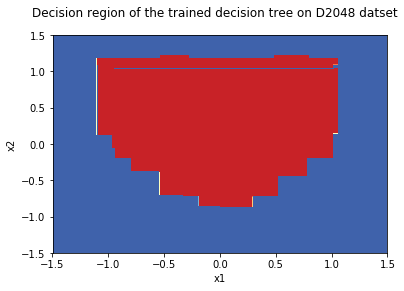

In [73]:
plot_step = 0.002
x_min, x_max = numpy_matrix[0:2048, 0].min() , numpy_matrix[0:2048, 0].max() 
y_min, y_max = numpy_matrix[0:2048, 1].min() , numpy_matrix[0:2048, 1].max() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
positions = np.vstack([xx.ravel(), yy.ravel()])
Z = test_accuracy1(tree2048, xx.ravel(), yy.ravel())
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)


cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel('x1')
plt.ylabel('x2')

plt.suptitle("Decision region of the trained decision tree on D2048 datset")
#plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

#labels = ['blue = label 1', 'red = label 0']

#plt.legend(loc='upper right', labels)
#plt.legend(labels)
plt.savefig('f3_d2048_1.png')
plt.show()

In [ ]:
#nodes = 93

In [52]:
tree8192 = build_tree(d8192, 10000, 1)
print_tree(tree8192)

X1 >= -0.984 Information Gain=0.08018
X1 >= -0.703 Information Gain=0.04040
X1 >= 0.376 Information Gain=0.01315
X1 >= 0.400 Information Gain=0.01498
X1 >= 0.535 Information Gain=0.02662
X1 >= -1.329 Information Gain=0.04218
X1 >= 1.263 Information Gain=0.06152
X1 >= -1.089 Information Gain=0.09323
X1 >= 0.156 Information Gain=0.00248
X1 >= -0.562 Information Gain=0.02370
X1 >= -0.263 Information Gain=0.00477
X1 >= 0.351 Information Gain=0.01216
X1 >= -0.284 Information Gain=0.00534
X1 >= -0.923 Information Gain=0.07150
X1 >= -0.454 Information Gain=0.01515
X1 >= -0.809 Information Gain=0.05293
X1 >= -0.513 Information Gain=0.01944
X1 >= -0.841 Information Gain=0.05827
X1 >= 1.207 Information Gain=0.07927
X1 >= 0.729 Information Gain=0.04842
X1 >= 0.498 Information Gain=0.02212
X1 >= 0.427 Information Gain=0.01720
X1 >= -0.741 Information Gain=0.04438
X1 >= -1.180 Information Gain=0.08155
X1 >= -0.785 Information Gain=0.04944
X1 >= -0.679 Information Gain=0.03666
X1 >= 0.172 Informatio

X1 >= 0.824 Information Gain=0.06034
X1 >= 0.173 Information Gain=0.00301
X1 >= 0.197 Information Gain=0.00393
X1 >= 0.264 Information Gain=0.00665
X1 >= 1.386 Information Gain=0.02968
X1 >= 0.232 Information Gain=0.00514
X1 >= -0.220 Information Gain=0.00349
X1 >= 0.073 Information Gain=0.00057
X1 >= 1.255 Information Gain=0.06432
X1 >= 0.983 Information Gain=0.08973
X1 >= -1.100 Information Gain=0.09550
X1 >= -0.764 Information Gain=0.04659
X1 >= -0.459 Information Gain=0.01592
X1 >= -0.004 Information Gain=0.00000
X1 >= 0.619 Information Gain=0.03748
X1 >= 0.393 Information Gain=0.01462
X1 >= 0.831 Information Gain=0.06207
X1 >= -1.433 Information Gain=0.01598
X1 >= -1.281 Information Gain=0.05368
X1 >= 0.143 Information Gain=0.00192
X1 >= -0.711 Information Gain=0.04091
X1 >= 0.203 Information Gain=0.00404
X1 >= -0.314 Information Gain=0.00666
X1 >= 1.427 Information Gain=0.01865
X1 >= -0.003 Information Gain=0.00000
X1 >= 0.934 Information Gain=0.08035
X1 >= 0.537 Information Gain

X1 >= 0.863 Information Gain=0.06744
X1 >= 1.065 Information Gain=0.09698
X1 >= 0.271 Information Gain=0.00704
X1 >= 0.327 Information Gain=0.01042
X1 >= 0.053 Information Gain=0.00042
X1 >= -0.724 Information Gain=0.04153
X1 >= 0.305 Information Gain=0.00873
X1 >= 0.060 Information Gain=0.00041
X1 >= 0.454 Information Gain=0.01923
X1 >= 0.742 Information Gain=0.05044
X1 >= 1.108 Information Gain=0.09705
X1 >= -0.586 Information Gain=0.02634
X1 >= -0.176 Information Gain=0.00239
X1 >= 0.935 Information Gain=0.08025
X1 >= 0.205 Information Gain=0.00414
X1 >= 0.866 Information Gain=0.06796
X1 >= 0.878 Information Gain=0.07095
X1 >= 1.045 Information Gain=0.09548
X1 >= 0.073 Information Gain=0.00056
X1 >= 0.678 Information Gain=0.04489
X1 >= -1.469 Information Gain=0.00748
X1 >= 0.701 Information Gain=0.04688
X1 >= 1.428 Information Gain=0.01856
X1 >= -0.670 Information Gain=0.03507
X1 >= 0.447 Information Gain=0.01861
X1 >= -0.619 Information Gain=0.03071
X1 >= 0.018 Information Gain=0.0

X1 >= 0.204 Information Gain=0.00411
X1 >= -1.488 Information Gain=0.00224
X1 >= 0.118 Information Gain=0.00125
X1 >= -1.159 Information Gain=0.08915
X1 >= 1.272 Information Gain=0.05952
X1 >= 1.273 Information Gain=0.05922
X1 >= 0.571 Information Gain=0.03077
X1 >= 0.151 Information Gain=0.00208
X1 >= 1.096 Information Gain=0.09709
X1 >= -0.525 Information Gain=0.02009
X1 >= -1.251 Information Gain=0.06282
X1 >= -0.864 Information Gain=0.06258
X1 >= 1.462 Information Gain=0.00975
X1 >= 0.057 Information Gain=0.00040
X1 >= 0.332 Information Gain=0.01075
X1 >= -1.459 Information Gain=0.00975
X1 >= -0.174 Information Gain=0.00222
X1 >= -0.371 Information Gain=0.00988
X1 >= 0.936 Information Gain=0.08055
X1 >= -0.146 Information Gain=0.00165
X1 >= -0.413 Information Gain=0.01261
X1 >= 1.105 Information Gain=0.09645
X1 >= -1.452 Information Gain=0.01121
X1 >= -0.521 Information Gain=0.01943
X1 >= 1.360 Information Gain=0.03709
X1 >= 0.674 Information Gain=0.04474
X1 >= 0.868 Information Ga

X1 >= 1.231 Information Gain=0.07098
X1 >= 1.388 Information Gain=0.02911
X1 >= 0.493 Information Gain=0.02165
X1 >= 1.355 Information Gain=0.03766
X1 >= 0.959 Information Gain=0.08372
X1 >= 0.226 Information Gain=0.00497
X1 >= -0.620 Information Gain=0.03059
X1 >= 1.140 Information Gain=0.09644
X1 >= -0.592 Information Gain=0.02725
X1 >= 0.575 Information Gain=0.03096
X1 >= 0.274 Information Gain=0.00732
X1 >= -0.285 Information Gain=0.00538
X1 >= 0.596 Information Gain=0.03454
X1 >= -0.102 Information Gain=0.00091
X1 >= 1.054 Information Gain=0.09551
X1 >= -0.331 Information Gain=0.00756
X1 >= 0.885 Information Gain=0.07291
X1 >= 0.669 Information Gain=0.04395
X1 >= 0.290 Information Gain=0.00815
X1 >= 0.885 Information Gain=0.07250
X1 >= -0.023 Information Gain=0.00001
X1 >= 0.225 Information Gain=0.00487
X1 >= -1.324 Information Gain=0.04314
X1 >= -1.188 Information Gain=0.07927
X1 >= -0.585 Information Gain=0.02640
X1 >= -1.106 Information Gain=0.09610
X1 >= -1.017 Information Gai

X1 >= 0.390 Information Gain=0.01412
X1 >= 0.431 Information Gain=0.01777
X1 >= 1.462 Information Gain=0.00993
X1 >= 1.084 Information Gain=0.09778
X1 >= -0.308 Information Gain=0.00654
X1 >= 0.400 Information Gain=0.01484
X1 >= 1.194 Information Gain=0.08217
X1 >= -0.576 Information Gain=0.02511
X1 >= -0.001 Information Gain=0.00001
X1 >= -0.640 Information Gain=0.03252
X1 >= -0.231 Information Gain=0.00396
X1 >= -0.307 Information Gain=0.00653
X1 >= 0.980 Information Gain=0.08750
X1 >= -0.163 Information Gain=0.00203
X1 >= 1.043 Information Gain=0.09465
X1 >= -0.507 Information Gain=0.01896
X1 >= 0.093 Information Gain=0.00092
X1 >= 0.863 Information Gain=0.06804
X1 >= -1.227 Information Gain=0.06926
X1 >= -0.369 Information Gain=0.00948
X1 >= 0.963 Information Gain=0.08500
X1 >= 1.130 Information Gain=0.09673
X1 >= -1.111 Information Gain=0.09674
X1 >= 0.673 Information Gain=0.04445
X1 >= 0.286 Information Gain=0.00798
X1 >= 1.149 Information Gain=0.09326
X1 >= 0.057 Information Gai

X1 >= -1.061 Information Gain=0.08834
X1 >= -1.054 Information Gain=0.08662
X1 >= -0.339 Information Gain=0.00785
X1 >= -0.589 Information Gain=0.02699
X1 >= -1.382 Information Gain=0.02770
X1 >= 1.381 Information Gain=0.03062
X1 >= -0.770 Information Gain=0.04788
X1 >= -0.487 Information Gain=0.01758
X1 >= -0.409 Information Gain=0.01229
X1 >= 1.293 Information Gain=0.05398
X1 >= -1.297 Information Gain=0.05005
X1 >= 0.690 Information Gain=0.04595
X1 >= -0.497 Information Gain=0.01810
X1 >= -0.969 Information Gain=0.07684
X1 >= -0.055 Information Gain=0.00019
X1 >= -1.027 Information Gain=0.08356
X1 >= -0.468 Information Gain=0.01620
X1 >= 0.382 Information Gain=0.01363
X1 >= 0.088 Information Gain=0.00081
X1 >= -1.164 Information Gain=0.08779
X1 >= 0.900 Information Gain=0.07443
X1 >= -0.145 Information Gain=0.00162
X1 >= -0.497 Information Gain=0.01806
X1 >= 0.902 Information Gain=0.07556
X1 >= 1.255 Information Gain=0.06452
X1 >= 1.144 Information Gain=0.09474
X1 >= -0.843 Informat

X1 >= 0.251 Information Gain=0.00594
X1 >= -0.476 Information Gain=0.01695
X1 >= 0.899 Information Gain=0.07419
X1 >= 0.467 Information Gain=0.02003
X1 >= -1.302 Information Gain=0.04897
X1 >= -0.376 Information Gain=0.01034
X1 >= 1.450 Information Gain=0.01276
X1 >= 1.295 Information Gain=0.05368
X1 >= -0.761 Information Gain=0.04609
X1 >= 0.900 Information Gain=0.07522
X1 >= -0.391 Information Gain=0.01097
X1 >= 0.158 Information Gain=0.00260
X1 >= -0.190 Information Gain=0.00270
X1 >= 1.107 Information Gain=0.09663
X1 >= 0.790 Information Gain=0.05791
X1 >= 0.043 Information Gain=0.00033
X1 >= 1.056 Information Gain=0.09611
X1 >= 1.225 Information Gain=0.07332
X1 >= 0.982 Information Gain=0.08837
X1 >= 1.127 Information Gain=0.09516
X1 >= 1.473 Information Gain=0.00621
X1 >= 0.422 Information Gain=0.01686
X1 >= -1.354 Information Gain=0.03547
X1 >= 0.050 Information Gain=0.00041
X1 >= 0.961 Information Gain=0.08440
X1 >= -1.235 Information Gain=0.06714
X1 >= 0.392 Information Gain=0

X1 >= 0.376 Information Gain=0.01319
X1 >= 0.750 Information Gain=0.05158
X1 >= -0.188 Information Gain=0.00267
X1 >= 0.651 Information Gain=0.04298
X1 >= -0.668 Information Gain=0.03489
X1 >= -0.282 Information Gain=0.00531
X1 >= 1.050 Information Gain=0.09553
X1 >= -1.277 Information Gain=0.05506
X1 >= 1.384 Information Gain=0.03015
X1 >= 0.505 Information Gain=0.02276
X1 >= -0.386 Information Gain=0.01059
X1 >= 0.332 Information Gain=0.01071
X1 >= -0.882 Information Gain=0.06543
X1 >= 0.136 Information Gain=0.00170
X1 >= -0.616 Information Gain=0.03016
X1 >= -0.393 Information Gain=0.01096
X1 >= -0.771 Information Gain=0.04782
X1 >= 0.723 Information Gain=0.04799
X1 >= -0.382 Information Gain=0.01046
X1 >= 0.223 Information Gain=0.00488
X1 >= -0.830 Information Gain=0.05660
X1 >= -0.793 Information Gain=0.05129
X1 >= -0.896 Information Gain=0.06695
X1 >= -0.276 Information Gain=0.00526
X1 >= 0.042 Information Gain=0.00030
X1 >= 1.173 Information Gain=0.08790
X1 >= -0.041 Information

X1 >= -0.488 Information Gain=0.01756
X1 >= -1.340 Information Gain=0.03920
X1 >= 0.934 Information Gain=0.08063
X1 >= -0.852 Information Gain=0.06097
X1 >= -1.144 Information Gain=0.09390
X1 >= 0.377 Information Gain=0.01321
X1 >= 0.497 Information Gain=0.02204
X1 >= 0.961 Information Gain=0.08385
X1 >= 0.888 Information Gain=0.07289
X1 >= -0.679 Information Gain=0.03659
X1 >= 0.345 Information Gain=0.01166
X1 >= -1.078 Information Gain=0.09194
X1 >= 1.117 Information Gain=0.09593
X1 >= 0.260 Information Gain=0.00642
X1 >= 0.867 Information Gain=0.06802
X1 >= 0.809 Information Gain=0.05928
X1 >= -0.209 Information Gain=0.00318
X1 >= 0.546 Information Gain=0.02870
X1 >= 0.190 Information Gain=0.00374
X1 >= -0.671 Information Gain=0.03545
X1 >= 0.258 Information Gain=0.00640
X1 >= -0.908 Information Gain=0.07201
X1 >= -0.441 Information Gain=0.01420
X1 >= 1.074 Information Gain=0.09787
X1 >= 1.197 Information Gain=0.08165
X1 >= -1.168 Information Gain=0.08643
X1 >= -0.032 Information Ga

X1 >= 0.881 Information Gain=0.07184
X1 >= 1.499 Information Gain=0.00018
X1 >= 1.456 Information Gain=0.01185
X1 >= -1.177 Information Gain=0.08310
X1 >= 0.493 Information Gain=0.02164
X1 >= -1.390 Information Gain=0.02536
X1 >= -0.886 Information Gain=0.06562
X1 >= 0.844 Information Gain=0.06398
X1 >= 0.523 Information Gain=0.02523
X1 >= -1.064 Information Gain=0.08973
X1 >= 1.093 Information Gain=0.09805
X1 >= 1.225 Information Gain=0.07302
X1 >= -0.851 Information Gain=0.06084
X1 >= -1.018 Information Gain=0.08253
X1 >= 0.808 Information Gain=0.05905
X1 >= 0.279 Information Gain=0.00741
X1 >= 0.075 Information Gain=0.00058
X1 >= -0.291 Information Gain=0.00557
X1 >= -0.129 Information Gain=0.00140
X1 >= -1.189 Information Gain=0.07896
X1 >= -1.440 Information Gain=0.01441
X1 >= -0.691 Information Gain=0.03886
X1 >= 0.811 Information Gain=0.05950
X1 >= 0.847 Information Gain=0.06450
X1 >= -0.625 Information Gain=0.03137
X1 >= 0.168 Information Gain=0.00290
X1 >= -0.415 Information G

X1 >= -0.995 Information Gain=0.08210
X1 >= -0.942 Information Gain=0.07118
X1 >= -1.099 Information Gain=0.09592
X1 >= 1.479 Information Gain=0.00440
X1 >= 1.434 Information Gain=0.01662
X1 >= 0.268 Information Gain=0.00681
X1 >= -1.008 Information Gain=0.08311
X1 >= 1.265 Information Gain=0.06112
X1 >= 1.058 Information Gain=0.09652
X1 >= -1.109 Information Gain=0.09641
X1 >= 0.160 Information Gain=0.00269
X1 >= 0.054 Information Gain=0.00043
X1 >= -0.725 Information Gain=0.04184
X1 >= 0.963 Information Gain=0.08510
X1 >= 0.981 Information Gain=0.08801
X1 >= 0.304 Information Gain=0.00875
X1 >= -0.440 Information Gain=0.01418
X1 >= -0.509 Information Gain=0.01924
X1 >= -0.904 Information Gain=0.07044
X1 >= 1.217 Information Gain=0.07547
X1 >= -1.458 Information Gain=0.01030
X1 >= 1.064 Information Gain=0.09719
X1 >= 0.225 Information Gain=0.00494
X1 >= -1.237 Information Gain=0.06643
X1 >= -0.765 Information Gain=0.04668
X1 >= 1.240 Information Gain=0.06875
X1 >= 0.189 Information Ga

X1 >= -1.171 Information Gain=0.08518
X1 >= 1.322 Information Gain=0.04644
X1 >= 0.770 Information Gain=0.05562
X1 >= 0.868 Information Gain=0.06862
X1 >= -1.176 Information Gain=0.08320
X1 >= -0.671 Information Gain=0.03526
X1 >= -0.252 Information Gain=0.00461
X1 >= -0.986 Information Gain=0.08027
X1 >= 0.161 Information Gain=0.00278
X1 >= 1.163 Information Gain=0.08978
X1 >= -0.502 Information Gain=0.01851
X1 >= -1.411 Information Gain=0.02088
X1 >= 1.144 Information Gain=0.09485
X1 >= -1.186 Information Gain=0.07999
X1 >= 0.156 Information Gain=0.00244
X1 >= 0.168 Information Gain=0.00292
X1 >= 0.819 Information Gain=0.05986
X1 >= 0.676 Information Gain=0.04496
X1 >= -0.502 Information Gain=0.01859
X1 >= 1.382 Information Gain=0.03043
X1 >= -0.666 Information Gain=0.03402
X1 >= -0.154 Information Gain=0.00197
X1 >= -0.002 Information Gain=0.00001
X1 >= -0.254 Information Gain=0.00469
X1 >= -1.345 Information Gain=0.03757
X1 >= -0.471 Information Gain=0.01651
X1 >= -0.062 Informatio

X1 >= -0.941 Information Gain=0.07072
X1 >= -1.235 Information Gain=0.06744
X1 >= 1.144 Information Gain=0.09495
X1 >= 0.265 Information Gain=0.00655
X1 >= -1.377 Information Gain=0.02921
X1 >= 0.427 Information Gain=0.01738
X1 >= -0.793 Information Gain=0.05112
X1 >= 0.719 Information Gain=0.04741
X1 >= -0.871 Information Gain=0.06476
X1 >= 0.381 Information Gain=0.01354
X1 >= -1.468 Information Gain=0.00775
X1 >= -0.601 Information Gain=0.02830
X1 >= -0.888 Information Gain=0.06574
X1 >= -0.220 Information Gain=0.00347
X1 >= -0.627 Information Gain=0.03148
X1 >= 0.699 Information Gain=0.04634
X1 >= -0.513 Information Gain=0.01948
X1 >= -0.125 Information Gain=0.00135
X1 >= -0.045 Information Gain=0.00012
X1 >= 1.204 Information Gain=0.07968
X1 >= -0.020 Information Gain=0.00000
X1 >= 0.903 Information Gain=0.07536
X1 >= -0.527 Information Gain=0.02038
X1 >= -1.313 Information Gain=0.04654
X1 >= -1.473 Information Gain=0.00639
X1 >= -0.628 Information Gain=0.03164
X1 >= 0.776 Informat

X1 >= -1.232 Information Gain=0.06825
X1 >= 0.461 Information Gain=0.01971
X1 >= 0.343 Information Gain=0.01154
X1 >= -1.440 Information Gain=0.01432
X1 >= 1.348 Information Gain=0.03958
X1 >= 0.653 Information Gain=0.04305
X1 >= 0.746 Information Gain=0.05079
X1 >= 0.315 Information Gain=0.00937
X1 >= -1.292 Information Gain=0.05093
X1 >= -0.388 Information Gain=0.01084
X1 >= -1.049 Information Gain=0.08693
X1 >= -0.239 Information Gain=0.00418
X1 >= 1.332 Information Gain=0.04382
X1 >= 1.315 Information Gain=0.04800
X1 >= -1.243 Information Gain=0.06442
X1 >= 0.396 Information Gain=0.01480
X1 >= 1.132 Information Gain=0.09721
X1 >= -0.420 Information Gain=0.01333
X1 >= 0.715 Information Gain=0.04724
X1 >= -1.341 Information Gain=0.03872
X1 >= -0.594 Information Gain=0.02792
X1 >= -0.702 Information Gain=0.03977
X1 >= -0.902 Information Gain=0.06984
X1 >= 0.947 Information Gain=0.08207
X1 >= 0.999 Information Gain=0.09261
X1 >= 1.228 Information Gain=0.07200
X1 >= -0.600 Information G

X1 >= -0.309 Information Gain=0.00655
X1 >= 0.022 Information Gain=0.00012
X1 >= 0.496 Information Gain=0.02210
X1 >= 1.280 Information Gain=0.05734
X1 >= 0.583 Information Gain=0.03288
X1 >= -1.418 Information Gain=0.01958
X1 >= -1.244 Information Gain=0.06422
X1 >= 1.103 Information Gain=0.09666
X1 >= 0.952 Information Gain=0.08232
X1 >= -0.549 Information Gain=0.02324
X1 >= 0.990 Information Gain=0.08932
X1 >= -1.132 Information Gain=0.09535
X1 >= 0.643 Information Gain=0.04230
X1 >= 1.006 Information Gain=0.09268
X1 >= -0.878 Information Gain=0.06475
X1 >= 0.474 Information Gain=0.02053
X1 >= 0.532 Information Gain=0.02591
X1 >= -0.387 Information Gain=0.01065
X1 >= -0.319 Information Gain=0.00684
X1 >= 0.930 Information Gain=0.07993
X1 >= 0.122 Information Gain=0.00139
X1 >= -0.557 Information Gain=0.02385
X1 >= -0.986 Information Gain=0.08086
X1 >= 0.120 Information Gain=0.00133
X1 >= -1.490 Information Gain=0.00206
X1 >= 1.261 Information Gain=0.06212
X1 >= 0.072 Information Gai

X1 >= 1.249 Information Gain=0.06643
X1 >= 1.363 Information Gain=0.03661
X1 >= 0.388 Information Gain=0.01410
X1 >= -1.363 Information Gain=0.03318
X1 >= 0.945 Information Gain=0.08134
X1 >= 0.195 Information Gain=0.00382
X1 >= 0.471 Information Gain=0.02027
X1 >= 0.168 Information Gain=0.00294
X1 >= -1.379 Information Gain=0.02855
X1 >= 0.918 Information Gain=0.07627
X1 >= 0.611 Information Gain=0.03670
X1 >= 1.146 Information Gain=0.09400
X1 >= 1.371 Information Gain=0.03432
X1 >= -0.492 Information Gain=0.01758
X1 >= -0.470 Information Gain=0.01629
X1 >= -1.346 Information Gain=0.03699
X1 >= -0.215 Information Gain=0.00342
X1 >= -0.359 Information Gain=0.00892
X1 >= -0.720 Information Gain=0.04152
X1 >= -1.046 Information Gain=0.08688
X1 >= 0.141 Information Gain=0.00189
X1 >= -0.947 Information Gain=0.07119
X1 >= -0.121 Information Gain=0.00134
X1 >= -0.694 Information Gain=0.03906
X1 >= 0.506 Information Gain=0.02284
X1 >= 1.032 Information Gain=0.09501
X1 >= 1.476 Information Ga

X1 >= 0.865 Information Gain=0.06832
X1 >= 1.267 Information Gain=0.06052
X1 >= 0.241 Information Gain=0.00579
X1 >= -0.658 Information Gain=0.03368
X1 >= -0.975 Information Gain=0.07817
X1 >= 1.028 Information Gain=0.09489
X1 >= 0.916 Information Gain=0.07592
X1 >= -0.555 Information Gain=0.02349
X1 >= 0.122 Information Gain=0.00141
X1 >= -0.741 Information Gain=0.04439
X1 >= 1.393 Information Gain=0.02798
X1 >= 1.439 Information Gain=0.01579
X1 >= 1.075 Information Gain=0.09734
X1 >= 0.042 Information Gain=0.00032
X1 >= -1.281 Information Gain=0.05437
X1 >= -1.108 Information Gain=0.09589
X1 >= -1.142 Information Gain=0.09453
X1 >= -0.250 Information Gain=0.00444
X1 >= -0.672 Information Gain=0.03576
X1 >= 0.903 Information Gain=0.07518
X1 >= -1.310 Information Gain=0.04751
X1 >= -0.592 Information Gain=0.02745
X1 >= 1.034 Information Gain=0.09506
X1 >= -0.170 Information Gain=0.00216
X1 >= 0.564 Information Gain=0.03022
X1 >= 0.346 Information Gain=0.01177
X1 >= 0.269 Information Ga

X1 >= -0.455 Information Gain=0.01529
X1 >= -1.275 Information Gain=0.05605
X1 >= 1.130 Information Gain=0.09652
X1 >= -1.369 Information Gain=0.03110
X1 >= -0.410 Information Gain=0.01217
X1 >= 0.360 Information Gain=0.01248
X1 >= 0.175 Information Gain=0.00300
X1 >= 1.208 Information Gain=0.07886
X1 >= 1.110 Information Gain=0.09662
X1 >= 1.459 Information Gain=0.01094
X1 >= -1.160 Information Gain=0.08884
X1 >= -0.985 Information Gain=0.08047
X1 >= -0.415 Information Gain=0.01285
X1 >= 0.125 Information Gain=0.00150
X1 >= 0.445 Information Gain=0.01836
X1 >= -1.195 Information Gain=0.07711
X1 >= 0.844 Information Gain=0.06355
X1 >= 1.473 Information Gain=0.00657
X1 >= 1.377 Information Gain=0.03252
X1 >= -1.033 Information Gain=0.08586
X1 >= 0.435 Information Gain=0.01790
X1 >= 0.629 Information Gain=0.03890
X1 >= -1.176 Information Gain=0.08362
X1 >= 0.933 Information Gain=0.08034
X1 >= -0.007 Information Gain=0.00000
X1 >= 0.832 Information Gain=0.06223
X1 >= -0.013 Information Ga

X1 >= -1.441 Information Gain=0.01405
X1 >= 1.258 Information Gain=0.06332
X1 >= -0.021 Information Gain=0.00001
X1 >= -1.419 Information Gain=0.01939
X1 >= 0.738 Information Gain=0.04943
X1 >= -1.431 Information Gain=0.01671
X1 >= 0.473 Information Gain=0.02034
X1 >= -0.086 Information Gain=0.00075
X1 >= 1.415 Information Gain=0.02265
X1 >= -0.906 Information Gain=0.07087
X1 >= -0.765 Information Gain=0.04660
X1 >= 0.721 Information Gain=0.04767
X1 >= 1.329 Information Gain=0.04460
X1 >= 0.957 Information Gain=0.08305
X1 >= 0.739 Information Gain=0.04960
X1 >= -0.061 Information Gain=0.00024
X1 >= -0.184 Information Gain=0.00266
X1 >= -0.950 Information Gain=0.07166
X1 >= -0.514 Information Gain=0.01934
X1 >= 0.813 Information Gain=0.05926
X1 >= 1.431 Information Gain=0.01736
X1 >= 1.441 Information Gain=0.01524
X1 >= 0.592 Information Gain=0.03334
X1 >= 0.539 Information Gain=0.02749
X1 >= 0.893 Information Gain=0.07289
X1 >= -1.417 Information Gain=0.01986
X1 >= 0.927 Information Ga

X1 >= 1.150 Information Gain=0.09316
X1 >= -0.452 Information Gain=0.01509
X1 >= 0.518 Information Gain=0.02457
X1 >= -0.662 Information Gain=0.03385
X1 >= 1.431 Information Gain=0.01727
X1 >= -0.084 Information Gain=0.00064
X1 >= 1.228 Information Gain=0.07169
X1 >= 0.928 Information Gain=0.07993
X1 >= 1.135 Information Gain=0.09783
X1 >= 0.538 Information Gain=0.02709
X1 >= -0.500 Information Gain=0.01823
X1 >= -1.212 Information Gain=0.07332
X1 >= 1.474 Information Gain=0.00594
X1 >= -1.220 Information Gain=0.07119
X1 >= 0.674 Information Gain=0.04474
X1 >= 0.983 Information Gain=0.08910
X1 >= 1.052 Information Gain=0.09511
X1 >= 1.178 Information Gain=0.08581
X1 >= 1.088 Information Gain=0.09768
X1 >= -0.412 Information Gain=0.01253
X1 >= 0.239 Information Gain=0.00563
X1 >= 0.317 Information Gain=0.00953
X1 >= -0.832 Information Gain=0.05703
X1 >= 0.969 Information Gain=0.08626
X1 >= 0.155 Information Gain=0.00242
X1 >= -0.144 Information Gain=0.00161
X1 >= -1.350 Information Gain

X1 >= -0.249 Information Gain=0.00446
X1 >= 1.405 Information Gain=0.02470
X1 >= -0.945 Information Gain=0.07100
X1 >= 0.705 Information Gain=0.04697
X1 >= 0.598 Information Gain=0.03447
X1 >= 0.284 Information Gain=0.00780
X1 >= -1.366 Information Gain=0.03223
X1 >= 0.451 Information Gain=0.01861
X1 >= 0.132 Information Gain=0.00166
X1 >= -0.569 Information Gain=0.02481
X1 >= 1.416 Information Gain=0.02218
X1 >= 0.357 Information Gain=0.01239
X1 >= 0.938 Information Gain=0.08096
X1 >= 0.887 Information Gain=0.07282
X1 >= -0.827 Information Gain=0.05621
X1 >= -0.066 Information Gain=0.00029
X1 >= 1.237 Information Gain=0.06936
X1 >= 0.454 Information Gain=0.01916
X1 >= 1.347 Information Gain=0.04016
X1 >= 0.119 Information Gain=0.00127
X1 >= -0.704 Information Gain=0.04020
X1 >= 1.182 Information Gain=0.08487
X1 >= -0.563 Information Gain=0.02378
X1 >= 0.648 Information Gain=0.04319
X1 >= -1.100 Information Gain=0.09560
X1 >= 0.252 Information Gain=0.00608
X1 >= 1.148 Information Gain=

X1 >= 0.330 Information Gain=0.01060
X1 >= 1.321 Information Gain=0.04663
X1 >= 0.131 Information Gain=0.00169
X1 >= 0.231 Information Gain=0.00511
X1 >= 1.496 Information Gain=0.00116
X1 >= -0.877 Information Gain=0.06473
X1 >= 0.282 Information Gain=0.00759
X1 >= 0.899 Information Gain=0.07436
X1 >= 0.985 Information Gain=0.08959
X1 >= -0.336 Information Gain=0.00778
X1 >= 0.619 Information Gain=0.03754
X1 >= -1.053 Information Gain=0.08649
X1 >= 0.805 Information Gain=0.05886
X1 >= 0.324 Information Gain=0.01021
X1 >= 0.665 Information Gain=0.04388
X1 >= -0.794 Information Gain=0.05139
X1 >= -0.183 Information Gain=0.00263
X1 >= 1.418 Information Gain=0.02153
X1 >= 0.713 Information Gain=0.04686
X1 >= -1.381 Information Gain=0.02817
X1 >= 0.696 Information Gain=0.04618
X1 >= 0.207 Information Gain=0.00429
X1 >= -0.894 Information Gain=0.06639
X1 >= 0.981 Information Gain=0.08811
X1 >= -1.486 Information Gain=0.00305
X1 >= 0.942 Information Gain=0.08181
X1 >= -0.779 Information Gain=

X1 >= -0.709 Information Gain=0.04077
X1 >= -0.275 Information Gain=0.00515
X1 >= -0.137 Information Gain=0.00146
X1 >= -0.068 Information Gain=0.00031
X1 >= 1.213 Information Gain=0.07670
X1 >= -0.464 Information Gain=0.01608
X1 >= -0.954 Information Gain=0.07360
X1 >= -1.455 Information Gain=0.01057
X1 >= -0.768 Information Gain=0.04734
X1 >= 0.585 Information Gain=0.03310
X1 >= 0.342 Information Gain=0.01146
X1 >= -0.828 Information Gain=0.05673
X1 >= -0.110 Information Gain=0.00100
X1 >= -0.821 Information Gain=0.05546
X1 >= 0.223 Information Gain=0.00485
X1 >= 0.941 Information Gain=0.08220
X1 >= -0.634 Information Gain=0.03184
X1 >= 1.488 Information Gain=0.00251
X1 >= -0.731 Information Gain=0.04237
X1 >= -0.510 Information Gain=0.01915
X1 >= 1.448 Information Gain=0.01331
X1 >= 0.962 Information Gain=0.08453
X1 >= -0.940 Information Gain=0.07054
X1 >= 0.486 Information Gain=0.02140
X1 >= -0.542 Information Gain=0.02171
X1 >= 0.245 Information Gain=0.00594
X1 >= -1.214 Informati

X1 >= -0.194 Information Gain=0.00283
X1 >= 0.264 Information Gain=0.00666
X1 >= -0.290 Information Gain=0.00559
X1 >= -0.899 Information Gain=0.06833
X1 >= -0.875 Information Gain=0.06467
X1 >= 0.173 Information Gain=0.00303
X1 >= 0.130 Information Gain=0.00162
X1 >= -0.854 Information Gain=0.06210
X1 >= -0.864 Information Gain=0.06241
X1 >= 0.074 Information Gain=0.00058
X1 >= 1.021 Information Gain=0.09454
X1 >= 0.507 Information Gain=0.02315
X1 >= -0.759 Information Gain=0.04601
X1 >= -0.873 Information Gain=0.06444
X1 >= 0.626 Information Gain=0.03879
X1 >= 1.162 Information Gain=0.08999
X1 >= 0.271 Information Gain=0.00712
X1 >= 0.139 Information Gain=0.00182
X1 >= 1.309 Information Gain=0.04956
X1 >= 1.491 Information Gain=0.00161
X1 >= 0.182 Information Gain=0.00338
X1 >= -1.405 Information Gain=0.02209
X1 >= -0.905 Information Gain=0.07061
X1 >= 0.285 Information Gain=0.00789
X1 >= -0.524 Information Gain=0.01988
X1 >= 0.926 Information Gain=0.07821
X1 >= -0.171 Information Ga

X1 >= -1.383 Information Gain=0.02723
X1 >= -0.834 Information Gain=0.05710
X1 >= 1.225 Information Gain=0.07343
X1 >= -0.396 Information Gain=0.01094
X1 >= -0.581 Information Gain=0.02567
X1 >= -0.069 Information Gain=0.00032
X1 >= 1.259 Information Gain=0.06252
X1 >= 0.487 Information Gain=0.02129
X1 >= -0.904 Information Gain=0.07018
X1 >= -1.316 Information Gain=0.04566
X1 >= -0.685 Information Gain=0.03698
X1 >= -0.908 Information Gain=0.07200
X1 >= 0.687 Information Gain=0.04557
X1 >= 0.276 Information Gain=0.00737
X1 >= -1.373 Information Gain=0.03025
X1 >= 0.630 Information Gain=0.03935
X1 >= 0.704 Information Gain=0.04697
X1 >= 0.518 Information Gain=0.02463
X1 >= -1.004 Information Gain=0.08196
X1 >= 1.230 Information Gain=0.07139
X1 >= 0.485 Information Gain=0.02142
X1 >= 1.342 Information Gain=0.04112
X1 >= -1.093 Information Gain=0.09390
X1 >= -0.423 Information Gain=0.01329
X1 >= 1.049 Information Gain=0.09563
X1 >= -0.825 Information Gain=0.05623
X1 >= -0.233 Information

X1 >= 0.299 Information Gain=0.00820
X1 >= -0.892 Information Gain=0.06618
X1 >= -0.443 Information Gain=0.01431
X1 >= 0.485 Information Gain=0.02147
X1 >= 0.402 Information Gain=0.01503
X1 >= -0.521 Information Gain=0.01944
X1 >= 0.092 Information Gain=0.00088
X1 >= 1.095 Information Gain=0.09730
X1 >= 0.438 Information Gain=0.01786
X1 >= -0.949 Information Gain=0.07110
X1 >= -1.130 Information Gain=0.09567
X1 >= -0.061 Information Gain=0.00023
X1 >= 0.852 Information Gain=0.06585
X1 >= -1.038 Information Gain=0.08620
X1 >= 0.281 Information Gain=0.00755
X1 >= -1.157 Information Gain=0.08978
X1 >= 0.267 Information Gain=0.00673
X1 >= -1.431 Information Gain=0.01662
X1 >= 0.903 Information Gain=0.07555
X1 >= 0.557 Information Gain=0.02979
X1 >= 0.724 Information Gain=0.04862
X1 >= -1.439 Information Gain=0.01497
X1 >= -0.347 Information Gain=0.00816
X1 >= 0.125 Information Gain=0.00152
X1 >= -1.112 Information Gain=0.09653
X1 >= 0.641 Information Gain=0.04231
X1 >= -0.848 Information G

X1 >= 0.546 Information Gain=0.02860
X1 >= 0.147 Information Gain=0.00194
X1 >= -0.562 Information Gain=0.02375
X1 >= -0.695 Information Gain=0.03927
X1 >= 0.635 Information Gain=0.04064
X1 >= -1.383 Information Gain=0.02742
X1 >= -0.521 Information Gain=0.01948
X1 >= -0.060 Information Gain=0.00022
X1 >= 0.118 Information Gain=0.00127
X1 >= 0.311 Information Gain=0.00902
X1 >= 0.392 Information Gain=0.01426
X1 >= -0.419 Information Gain=0.01341
X1 >= -0.636 Information Gain=0.03236
X1 >= -0.018 Information Gain=0.00000
X1 >= 1.371 Information Gain=0.03423
X1 >= -1.171 Information Gain=0.08528
X1 >= -0.322 Information Gain=0.00704
X1 >= -1.448 Information Gain=0.01231
X1 >= -0.925 Information Gain=0.07094
X1 >= 0.864 Information Gain=0.06818
X1 >= 1.275 Information Gain=0.05893
X1 >= -0.868 Information Gain=0.06364
X1 >= -0.542 Information Gain=0.02176
X1 >= -1.113 Information Gain=0.09621
X1 >= -1.387 Information Gain=0.02620
X1 >= 0.500 Information Gain=0.02223
X1 >= -1.076 Informati

X1 >= 0.757 Information Gain=0.05298
X1 >= 1.047 Information Gain=0.09566
X1 >= -0.984 Information Gain=0.08052
X1 >= -1.483 Information Gain=0.00431
X1 >= 1.028 Information Gain=0.09535
X1 >= 0.975 Information Gain=0.08640
X1 >= 0.938 Information Gain=0.08066
X1 >= -0.220 Information Gain=0.00351
X1 >= -0.478 Information Gain=0.01684
X1 >= -1.151 Information Gain=0.09157
X1 >= -0.786 Information Gain=0.04961
X1 >= 0.273 Information Gain=0.00732
X1 >= 0.823 Information Gain=0.06022
X1 >= 0.016 Information Gain=0.00010
X1 >= 0.214 Information Gain=0.00455
X1 >= -0.895 Information Gain=0.06713
X1 >= 0.321 Information Gain=0.01001
X1 >= 0.369 Information Gain=0.01265
X1 >= 1.390 Information Gain=0.02855
X1 >= 0.742 Information Gain=0.05027
X1 >= 0.902 Information Gain=0.07583
X1 >= -0.569 Information Gain=0.02471
X1 >= -0.033 Information Gain=0.00005
X1 >= 0.346 Information Gain=0.01189
X1 >= 0.680 Information Gain=0.04526
X1 >= 1.279 Information Gain=0.05763
X1 >= 1.462 Information Gain=

X1 >= -0.379 Information Gain=0.01050
X1 >= -0.387 Information Gain=0.01071
X1 >= -0.108 Information Gain=0.00096
X1 >= 0.976 Information Gain=0.08610
X1 >= 0.699 Information Gain=0.04641
X1 >= 0.190 Information Gain=0.00371
X1 >= -0.386 Information Gain=0.01063
X1 >= 0.963 Information Gain=0.08476
X1 >= 0.060 Information Gain=0.00042
X1 >= 0.095 Information Gain=0.00093
X1 >= 0.645 Information Gain=0.04285
X1 >= -1.408 Information Gain=0.02162
X1 >= -0.117 Information Gain=0.00118
X1 >= 0.627 Information Gain=0.03884
X1 >= 1.248 Information Gain=0.06714
X1 >= -1.066 Information Gain=0.09019
X1 >= 0.760 Information Gain=0.05328
X1 >= -0.598 Information Gain=0.02821
X1 >= -0.162 Information Gain=0.00201
X1 >= -0.873 Information Gain=0.06461
X1 >= 0.305 Information Gain=0.00876
X1 >= -0.269 Information Gain=0.00495
X1 >= -1.036 Information Gain=0.08619
X1 >= -1.089 Information Gain=0.09275
X1 >= 0.481 Information Gain=0.02081
X1 >= 1.259 Information Gain=0.06272
X1 >= -0.443 Information 

X1 >= -1.066 Information Gain=0.09069
X1 >= -0.407 Information Gain=0.01198
X1 >= 1.179 Information Gain=0.08539
X1 >= -1.445 Information Gain=0.01304
X1 >= -1.484 Information Gain=0.00377
X1 >= -1.210 Information Gain=0.07424
X1 >= 0.587 Information Gain=0.03309
X1 >= 0.821 Information Gain=0.05964
X1 >= -0.231 Information Gain=0.00393
X1 >= -0.524 Information Gain=0.01976
X1 >= -0.275 Information Gain=0.00518
X1 >= -1.256 Information Gain=0.06082
X1 >= -0.805 Information Gain=0.05264
X1 >= -1.401 Information Gain=0.02339
X1 >= -0.515 Information Gain=0.01936
X1 >= -0.835 Information Gain=0.05714
X1 >= 1.258 Information Gain=0.06282
X1 >= -0.229 Information Gain=0.00388
X1 >= -0.924 Information Gain=0.07132
X1 >= 1.033 Information Gain=0.09548
X1 >= -0.449 Information Gain=0.01486
X1 >= -1.315 Information Gain=0.04576
X1 >= -0.370 Information Gain=0.00966
X1 >= 0.032 Information Gain=0.00018
X1 >= 0.234 Information Gain=0.00516
X1 >= 0.632 Information Gain=0.04038
X1 >= -0.463 Informa

X1 >= -0.929 Information Gain=0.07065
X1 >= -1.271 Information Gain=0.05744
X1 >= -1.186 Information Gain=0.07989
X1 >= -0.742 Information Gain=0.04441
X1 >= -0.990 Information Gain=0.08147
X1 >= 0.392 Information Gain=0.01439
X1 >= -1.180 Information Gain=0.08144
X1 >= -0.364 Information Gain=0.00943
X1 >= 0.591 Information Gain=0.03341
X1 >= -0.768 Information Gain=0.04685
X1 >= 1.086 Information Gain=0.09736
X1 >= 0.300 Information Gain=0.00832
X1 >= 0.246 Information Gain=0.00603
X1 >= -1.347 Information Gain=0.03690
X1 >= -0.120 Information Gain=0.00133
X1 >= 0.510 Information Gain=0.02349
X1 >= 0.274 Information Gain=0.00737
X1 >= 0.742 Information Gain=0.05011
X1 >= 0.228 Information Gain=0.00502
X1 >= -1.474 Information Gain=0.00612
X1 >= 1.440 Information Gain=0.01552
X1 >= 1.004 Information Gain=0.09259
X1 >= 0.405 Information Gain=0.01538
X1 >= -0.749 Information Gain=0.04438
X1 >= 0.597 Information Gain=0.03459
X1 >= 1.101 Information Gain=0.09613
X1 >= -0.556 Information G

X1 >= -0.935 Information Gain=0.07091
X1 >= -0.947 Information Gain=0.07109
X1 >= -1.169 Information Gain=0.08612
X1 >= -0.427 Information Gain=0.01337
X1 >= 0.869 Information Gain=0.06850
X1 >= 1.384 Information Gain=0.02996
X1 >= 0.022 Information Gain=0.00012
X1 >= -0.506 Information Gain=0.01880
X1 >= -0.078 Information Gain=0.00044
X1 >= 0.452 Information Gain=0.01893
X1 >= 0.685 Information Gain=0.04549
X1 >= 0.421 Information Gain=0.01676
X1 >= 1.473 Information Gain=0.00666
X1 >= 0.526 Information Gain=0.02542
X1 >= 0.237 Information Gain=0.00553
X1 >= -0.049 Information Gain=0.00013
X1 >= 0.379 Information Gain=0.01334
X1 >= -0.538 Information Gain=0.02139
X1 >= -1.488 Information Gain=0.00233
X1 >= 0.649 Information Gain=0.04340
X1 >= 1.434 Information Gain=0.01644
X1 >= 1.023 Information Gain=0.09501
X1 >= 0.583 Information Gain=0.03276
X1 >= -0.212 Information Gain=0.00317
X1 >= 0.059 Information Gain=0.00040
X1 >= -1.341 Information Gain=0.03862
X1 >= -0.246 Information Ga

X1 >= 1.240 Information Gain=0.06845
X1 >= 0.486 Information Gain=0.02137
X1 >= 0.383 Information Gain=0.01391
X1 >= 1.080 Information Gain=0.09720
X1 >= -0.749 Information Gain=0.04485
X1 >= -0.538 Information Gain=0.02122
X1 >= -0.345 Information Gain=0.00811
X1 >= 0.621 Information Gain=0.03785
X1 >= -0.664 Information Gain=0.03397
X1 >= -0.228 Information Gain=0.00394
X1 >= -1.277 Information Gain=0.05526
X1 >= -0.429 Information Gain=0.01390
X1 >= -0.919 Information Gain=0.07142
X1 >= -1.006 Information Gain=0.08193
X1 >= 0.594 Information Gain=0.03432
X1 >= 0.448 Information Gain=0.01864
X1 >= 0.873 Information Gain=0.06966
X1 >= -0.471 Information Gain=0.01637
X1 >= -0.566 Information Gain=0.02430
X1 >= 0.659 Information Gain=0.04325
X1 >= -0.073 Information Gain=0.00038
X1 >= 0.936 Information Gain=0.08045
X1 >= 0.577 Information Gain=0.03161
X1 >= 0.839 Information Gain=0.06301
X1 >= -0.267 Information Gain=0.00492
X1 >= -0.696 Information Gain=0.03962
X1 >= -0.673 Information

X2 >= -1.448 Information Gain=0.01359
X2 >= -1.456 Information Gain=0.01130
X2 >= -0.347 Information Gain=0.12658
X2 >= -0.433 Information Gain=0.14353
X2 >= 0.347 Information Gain=0.02042
X2 >= -0.219 Information Gain=0.10679
X2 >= 1.082 Information Gain=0.03388
X2 >= -0.585 Information Gain=0.16486
X2 >= 0.358 Information Gain=0.01934
X2 >= -0.830 Information Gain=0.16960
X2 >= -0.161 Information Gain=0.09790
X2 >= 1.446 Information Gain=0.01460
X2 >= -1.399 Information Gain=0.02536
X2 >= 0.347 Information Gain=0.02037
X2 >= 1.324 Information Gain=0.04771
X2 >= -0.975 Information Gain=0.14833
X2 >= 1.164 Information Gain=0.05500
X2 >= 0.598 Information Gain=0.00237
X2 >= -1.412 Information Gain=0.02218
X2 >= -0.952 Information Gain=0.15486
X2 >= 0.850 Information Gain=0.00498
X2 >= 0.380 Information Gain=0.01798
X2 >= 0.446 Information Gain=0.01274
X2 >= -1.473 Information Gain=0.00621
X2 >= -0.550 Information Gain=0.16182
X2 >= -0.244 Information Gain=0.11091
X2 >= 0.412 Information

X2 >= -1.329 Information Gain=0.04199
X2 >= -1.482 Information Gain=0.00386
X2 >= 1.341 Information Gain=0.04199
X2 >= 0.286 Information Gain=0.02709
X2 >= -0.709 Information Gain=0.17789
X2 >= 0.734 Information Gain=0.00018
X2 >= -0.637 Information Gain=0.16912
X2 >= 0.901 Information Gain=0.00840
X2 >= -0.718 Information Gain=0.17691
X2 >= 1.475 Information Gain=0.00784
X2 >= -0.957 Information Gain=0.15443
X2 >= 1.166 Information Gain=0.05535
X2 >= -0.160 Information Gain=0.09801
X2 >= 0.163 Information Gain=0.04495
X2 >= 1.486 Information Gain=0.00422
X2 >= -1.252 Information Gain=0.06332
X2 >= -0.397 Information Gain=0.13833
X2 >= 1.049 Information Gain=0.02818
X2 >= -0.102 Information Gain=0.08898
X2 >= 0.340 Information Gain=0.02115
X2 >= 1.279 Information Gain=0.06082
X2 >= -1.388 Information Gain=0.02817
X2 >= -0.690 Information Gain=0.17636
X2 >= -1.403 Information Gain=0.02386
X2 >= -1.272 Information Gain=0.05922
X2 >= 1.428 Information Gain=0.01902
X2 >= -1.369 Information

X2 >= -1.000 Information Gain=0.13907
X2 >= 0.904 Information Gain=0.00851
X2 >= -0.782 Information Gain=0.16985
X2 >= -0.411 Information Gain=0.14203
X2 >= 0.374 Information Gain=0.01834
X2 >= 0.590 Information Gain=0.00267
X2 >= 0.838 Information Gain=0.00429
X2 >= 1.317 Information Gain=0.04956
X2 >= -0.481 Information Gain=0.15110
X2 >= -1.302 Information Gain=0.04936
X2 >= -1.177 Information Gain=0.08601
X2 >= 1.155 Information Gain=0.05074
X2 >= 0.552 Information Gain=0.00449
X2 >= 1.161 Information Gain=0.05469
X2 >= 0.741 Information Gain=0.00027
X2 >= -0.587 Information Gain=0.16494
X2 >= -0.536 Information Gain=0.15970
X2 >= -1.192 Information Gain=0.08030
X2 >= -1.185 Information Gain=0.08300
X2 >= -0.509 Information Gain=0.15580
X2 >= -0.353 Information Gain=0.12797
X2 >= 1.422 Information Gain=0.02069
X2 >= -1.247 Information Gain=0.06432
X2 >= 0.706 Information Gain=0.00000
X2 >= -0.987 Information Gain=0.14299
X2 >= -0.873 Information Gain=0.16861
X2 >= 0.836 Information

X2 >= -0.298 Information Gain=0.11907
X2 >= -1.464 Information Gain=0.00875
X2 >= -1.427 Information Gain=0.01856
X2 >= 1.118 Information Gain=0.04010
X2 >= 0.892 Information Gain=0.00758
X2 >= -1.498 Information Gain=0.00018
X2 >= -1.477 Information Gain=0.00522
X2 >= -0.488 Information Gain=0.15191
X2 >= -0.529 Information Gain=0.15766
X2 >= -0.813 Information Gain=0.17161
X2 >= -0.943 Information Gain=0.15795
X2 >= 0.302 Information Gain=0.02429
X2 >= -0.217 Information Gain=0.10603
X2 >= -1.496 Information Gain=0.00099
X2 >= 0.051 Information Gain=0.06083
X2 >= 0.531 Information Gain=0.00607
X2 >= -0.297 Information Gain=0.11887
X2 >= 0.304 Information Gain=0.02422
X2 >= -0.839 Information Gain=0.16700
X2 >= -0.355 Information Gain=0.12797
X2 >= 1.283 Information Gain=0.05883
X2 >= 0.442 Information Gain=0.01318
X2 >= 0.721 Information Gain=0.00007
X2 >= -1.206 Information Gain=0.07650
X2 >= 1.246 Information Gain=0.07109
X2 >= -0.939 Information Gain=0.15949
X2 >= -1.292 Informati

X2 >= -0.365 Information Gain=0.13081
X2 >= -1.325 Information Gain=0.04314
X2 >= 0.676 Information Gain=0.00018
X2 >= -1.366 Information Gain=0.03337
X2 >= 0.157 Information Gain=0.04556
X2 >= -0.450 Information Gain=0.14748
X2 >= 1.440 Information Gain=0.01589
X2 >= -1.284 Information Gain=0.05467
X2 >= -0.241 Information Gain=0.11035
X2 >= 0.816 Information Gain=0.00330
X2 >= -1.197 Information Gain=0.07927
X2 >= 0.425 Information Gain=0.01394
X2 >= -0.751 Information Gain=0.17270
X2 >= -0.858 Information Gain=0.17112
X2 >= 0.807 Information Gain=0.00254
X2 >= 1.003 Information Gain=0.02206
X2 >= -0.564 Information Gain=0.16293
X2 >= -1.252 Information Gain=0.06322
X2 >= -0.329 Information Gain=0.12376
X2 >= -0.067 Information Gain=0.08071
X2 >= 0.706 Information Gain=0.00000
X2 >= -0.607 Information Gain=0.16437
X2 >= -0.163 Information Gain=0.09820
X2 >= 0.984 Information Gain=0.01903
X2 >= 0.848 Information Gain=0.00490
X2 >= 1.201 Information Gain=0.06605
X2 >= 1.334 Information

X2 >= -0.484 Information Gain=0.15148
X2 >= -0.678 Information Gain=0.17581
X2 >= 0.181 Information Gain=0.04208
X2 >= 1.341 Information Gain=0.04179
X2 >= -0.225 Information Gain=0.10799
X2 >= 0.619 Information Gain=0.00154
X2 >= -0.482 Information Gain=0.15086
X2 >= 0.279 Information Gain=0.02816
X2 >= 1.384 Information Gain=0.03176
X2 >= -0.976 Information Gain=0.14821
X2 >= -0.906 Information Gain=0.16397
X2 >= -1.312 Information Gain=0.04663
X2 >= -0.521 Information Gain=0.15702
X2 >= -0.355 Information Gain=0.12786
X2 >= 0.197 Information Gain=0.03937
X2 >= 0.242 Information Gain=0.03311
X2 >= -0.291 Information Gain=0.11646
X2 >= 1.481 Information Gain=0.00567
X2 >= -0.441 Information Gain=0.14531
X2 >= -1.229 Information Gain=0.06885
X2 >= -1.048 Information Gain=0.12490
X2 >= -0.227 Information Gain=0.10805
X2 >= -1.464 Information Gain=0.00884
X2 >= 0.856 Information Gain=0.00530
X2 >= -0.197 Information Gain=0.10357
X2 >= -0.442 Information Gain=0.14561
X2 >= 1.331 Informati

X2 >= 1.024 Information Gain=0.02457
X2 >= 0.359 Information Gain=0.01920
X2 >= -0.965 Information Gain=0.15208
X2 >= -0.811 Information Gain=0.17198
X2 >= -1.172 Information Gain=0.08748
X2 >= -0.762 Information Gain=0.17281
X2 >= 0.185 Information Gain=0.04088
X2 >= 0.788 Information Gain=0.00182
X2 >= 0.331 Information Gain=0.02203
X2 >= 1.141 Information Gain=0.04642
X2 >= -0.280 Information Gain=0.11637
X2 >= -1.104 Information Gain=0.10620
X2 >= 1.133 Information Gain=0.04336
X2 >= -1.029 Information Gain=0.13098
X2 >= 0.182 Information Gain=0.04184
X2 >= 1.078 Information Gain=0.03250
X2 >= -1.304 Information Gain=0.04839
X2 >= -1.394 Information Gain=0.02686
X2 >= -1.205 Information Gain=0.07691
X2 >= -0.304 Information Gain=0.11968
X2 >= -1.277 Information Gain=0.05833
X2 >= -0.014 Information Gain=0.07107
X2 >= -0.659 Information Gain=0.17072
X2 >= 1.376 Information Gain=0.03375
X2 >= -0.983 Information Gain=0.14472
X2 >= 1.373 Information Gain=0.03423
X2 >= -1.001 Informatio

X2 >= 1.251 Information Gain=0.06936
X2 >= 0.853 Information Gain=0.00518
X2 >= 0.959 Information Gain=0.01543
X2 >= 0.770 Information Gain=0.00116
X2 >= -0.640 Information Gain=0.16952
X2 >= 0.939 Information Gain=0.01272
X2 >= -0.097 Information Gain=0.08816
X2 >= 0.549 Information Gain=0.00486
X2 >= -1.240 Information Gain=0.06643
X2 >= -0.387 Information Gain=0.13786
X2 >= -0.844 Information Gain=0.16603
X2 >= 0.286 Information Gain=0.02700
X2 >= -1.449 Information Gain=0.01341
X2 >= 1.146 Information Gain=0.04778
X2 >= 1.093 Information Gain=0.03670
X2 >= 1.339 Information Gain=0.04237
X2 >= 0.733 Information Gain=0.00017
X2 >= -1.146 Information Gain=0.09580
X2 >= 0.919 Information Gain=0.01052
X2 >= -1.235 Information Gain=0.06764
X2 >= -0.082 Information Gain=0.08492
X2 >= -0.111 Information Gain=0.09117
X2 >= -0.870 Information Gain=0.16839
X2 >= 0.508 Information Gain=0.00774
X2 >= 0.387 Information Gain=0.01765
X2 >= -0.031 Information Gain=0.07330
X2 >= 1.004 Information Ga

X2 >= -0.468 Information Gain=0.15002
X2 >= 0.843 Information Gain=0.00448
X2 >= 0.522 Information Gain=0.00671
X2 >= -0.266 Information Gain=0.11186
X2 >= 0.552 Information Gain=0.00439
X2 >= 0.297 Information Gain=0.02482
X2 >= 1.500 Information Gain=0.00009
X2 >= -0.734 Information Gain=0.17369
X2 >= 1.088 Information Gain=0.03521
X2 >= -0.583 Information Gain=0.16316
X2 >= -0.881 Information Gain=0.16654
X2 >= -0.933 Information Gain=0.16188
X2 >= 1.130 Information Gain=0.04263
X2 >= 0.582 Information Gain=0.00282
X2 >= 1.306 Information Gain=0.05260
X2 >= 1.079 Information Gain=0.03289
X2 >= 0.045 Information Gain=0.06305
X2 >= 1.282 Information Gain=0.05912
X2 >= 1.280 Information Gain=0.06012
X2 >= 0.759 Information Gain=0.00080
X2 >= 0.011 Information Gain=0.06761
X2 >= 1.246 Information Gain=0.07119
X2 >= 1.148 Information Gain=0.04818
X2 >= 1.448 Information Gain=0.01405
X2 >= -1.054 Information Gain=0.12267
X2 >= 0.142 Information Gain=0.04812
X2 >= -1.420 Information Gain=0

X2 >= 0.465 Information Gain=0.01097
X2 >= -0.995 Information Gain=0.14056
X2 >= -0.073 Information Gain=0.08207
X2 >= 0.838 Information Gain=0.00427
X2 >= 0.200 Information Gain=0.03844
X2 >= 1.368 Information Gain=0.03518
X2 >= 0.766 Information Gain=0.00101
X2 >= 1.355 Information Gain=0.03881
X2 >= -0.859 Information Gain=0.17087
X2 >= -1.009 Information Gain=0.13701
X2 >= -1.435 Information Gain=0.01690
X2 >= 0.694 Information Gain=0.00004
X2 >= 1.148 Information Gain=0.04798
X2 >= 1.182 Information Gain=0.06001
X2 >= 0.377 Information Gain=0.01814
X2 >= 0.707 Information Gain=0.00000
X2 >= 0.498 Information Gain=0.00886
X2 >= 1.236 Information Gain=0.07363
X2 >= -1.237 Information Gain=0.06694
X2 >= -0.884 Information Gain=0.16605
X2 >= -0.399 Information Gain=0.13834
X2 >= 1.251 Information Gain=0.06926
X2 >= -0.820 Information Gain=0.17067
X2 >= 1.365 Information Gain=0.03604
X2 >= 1.106 Information Gain=0.03791
X2 >= 1.279 Information Gain=0.06042
X2 >= 0.658 Information Gain=

X2 >= -1.487 Information Gain=0.00296
X2 >= 0.769 Information Gain=0.00111
X2 >= 1.184 Information Gain=0.06013
X2 >= 0.675 Information Gain=0.00019
X2 >= 1.433 Information Gain=0.01773
X2 >= 1.345 Information Gain=0.04121
X2 >= 0.699 Information Gain=0.00001
X2 >= -1.346 Information Gain=0.03852
X2 >= -0.829 Information Gain=0.17009
X2 >= -0.901 Information Gain=0.16252
X2 >= -1.449 Information Gain=0.01331
X2 >= 0.616 Information Gain=0.00169
X2 >= -0.793 Information Gain=0.16994
X2 >= 0.539 Information Gain=0.00578
X2 >= -0.024 Information Gain=0.07226
X2 >= 0.021 Information Gain=0.06668
X2 >= 0.103 Information Gain=0.05517
X2 >= -1.169 Information Gain=0.08842
X2 >= 0.523 Information Gain=0.00670
X2 >= 0.463 Information Gain=0.01116
X2 >= -0.941 Information Gain=0.15854
X2 >= -0.824 Information Gain=0.17110
X2 >= 0.757 Information Gain=0.00070
X2 >= 1.000 Information Gain=0.02126
X2 >= 0.653 Information Gain=0.00065
X2 >= 1.476 Information Gain=0.00739
X2 >= 0.268 Information Gain

X2 >= 0.143 Information Gain=0.04805
X2 >= 1.491 Information Gain=0.00242
X2 >= 1.193 Information Gain=0.06346
X2 >= 0.183 Information Gain=0.04119
X2 >= 0.733 Information Gain=0.00017
X2 >= 0.643 Information Gain=0.00071
X2 >= -1.492 Information Gain=0.00197
X2 >= 1.021 Information Gain=0.02436
X2 >= -0.671 Information Gain=0.17360
X2 >= -0.375 Information Gain=0.13432
X2 >= 0.664 Information Gain=0.00043
X2 >= -0.427 Information Gain=0.14290
X2 >= -0.675 Information Gain=0.17467
X2 >= -0.666 Information Gain=0.17239
X2 >= 1.420 Information Gain=0.02116
X2 >= 0.966 Information Gain=0.01595
X2 >= -1.401 Information Gain=0.02442
X2 >= 0.963 Information Gain=0.01556
X2 >= 1.204 Information Gain=0.06545
X2 >= 1.336 Information Gain=0.04382
X2 >= 1.305 Information Gain=0.05270
X2 >= -1.007 Information Gain=0.13712
X2 >= 0.263 Information Gain=0.03072
X2 >= 0.862 Information Gain=0.00557
X2 >= -0.196 Information Gain=0.10378
X2 >= -0.053 Information Gain=0.07858
X2 >= -1.415 Information Gai

X2 >= -1.269 Information Gain=0.05982
X2 >= -0.700 Information Gain=0.17671
X2 >= 0.917 Information Gain=0.01041
X2 >= 1.373 Information Gain=0.03413
X2 >= -0.744 Information Gain=0.17432
X2 >= 0.753 Information Gain=0.00057
X2 >= -0.467 Information Gain=0.14900
X2 >= 1.455 Information Gain=0.01276
X2 >= 0.151 Information Gain=0.04657
X2 >= -0.085 Information Gain=0.08610
X2 >= 0.252 Information Gain=0.03216
X2 >= -1.025 Information Gain=0.13200
X2 >= 0.885 Information Gain=0.00694
X2 >= -0.687 Information Gain=0.17668
X2 >= 1.118 Information Gain=0.04002
X2 >= 0.393 Information Gain=0.01667
X2 >= -0.807 Information Gain=0.17046
X2 >= 1.335 Information Gain=0.04401
X2 >= 0.381 Information Gain=0.01801
X2 >= -0.926 Information Gain=0.16356
X2 >= 0.920 Information Gain=0.01043
X2 >= -0.630 Information Gain=0.16718
X2 >= -0.566 Information Gain=0.16302
X2 >= -0.200 Information Gain=0.10451
X2 >= -0.846 Information Gain=0.16710
X2 >= 1.089 Information Gain=0.03552
X2 >= -0.208 Information 

X2 >= 0.071 Information Gain=0.05887
X2 >= 0.088 Information Gain=0.05733
X2 >= 1.279 Information Gain=0.06062
X2 >= -1.476 Information Gain=0.00549
X2 >= 1.402 Information Gain=0.02601
X2 >= -0.143 Information Gain=0.09457
X2 >= 0.462 Information Gain=0.01118
X2 >= 1.434 Information Gain=0.01764
X2 >= -0.551 Information Gain=0.16127
X2 >= -1.477 Information Gain=0.00531
X2 >= -1.148 Information Gain=0.09527
X2 >= -0.352 Information Gain=0.12693
X2 >= -0.242 Information Gain=0.11064
X2 >= -0.999 Information Gain=0.13941
X2 >= 1.486 Information Gain=0.00395
X2 >= -0.626 Information Gain=0.16644
X2 >= 1.133 Information Gain=0.04328
X2 >= 1.454 Information Gain=0.01286
X2 >= -1.337 Information Gain=0.04025
X2 >= -0.765 Information Gain=0.17182
X2 >= 0.614 Information Gain=0.00176
X2 >= -1.052 Information Gain=0.12412
X2 >= -0.417 Information Gain=0.14164
X2 >= -1.323 Information Gain=0.04421
X2 >= -0.969 Information Gain=0.15043
X2 >= -0.143 Information Gain=0.09478
X2 >= -1.061 Informati

X2 >= -0.313 Information Gain=0.12127
X2 >= 1.496 Information Gain=0.00099
X2 >= -0.054 Information Gain=0.07855
X2 >= 0.859 Information Gain=0.00551
X2 >= -0.450 Information Gain=0.14721
X2 >= 1.110 Information Gain=0.03808
X2 >= 0.411 Information Gain=0.01496
X2 >= -0.435 Information Gain=0.14335
X2 >= 0.600 Information Gain=0.00227
X2 >= 0.623 Information Gain=0.00136
X2 >= 0.748 Information Gain=0.00044
X2 >= -0.712 Information Gain=0.17887
X2 >= 0.109 Information Gain=0.05445
X2 >= -0.015 Information Gain=0.07164
X2 >= 1.252 Information Gain=0.06906
X2 >= -0.105 Information Gain=0.09003
X2 >= -0.006 Information Gain=0.07010
X2 >= 1.358 Information Gain=0.03776
X2 >= 0.947 Information Gain=0.01366
X2 >= 0.155 Information Gain=0.04585
X2 >= -0.382 Information Gain=0.13769
X2 >= -1.483 Information Gain=0.00350
X2 >= 0.338 Information Gain=0.02137
X2 >= -1.180 Information Gain=0.08518
X2 >= -0.611 Information Gain=0.16445
X2 >= 0.604 Information Gain=0.00220
X2 >= 0.417 Information Ga

X2 >= 0.100 Information Gain=0.05553
X2 >= -0.725 Information Gain=0.17540
X2 >= 1.020 Information Gain=0.02414
X2 >= -0.580 Information Gain=0.16312
X2 >= -0.213 Information Gain=0.10502
X2 >= -0.465 Information Gain=0.14816
X2 >= 1.285 Information Gain=0.05833
X2 >= 1.313 Information Gain=0.05064
X2 >= -1.065 Information Gain=0.11901
X2 >= 1.380 Information Gain=0.03214
X2 >= -1.299 Information Gain=0.05015
X2 >= 0.592 Information Gain=0.00255
X2 >= 0.933 Information Gain=0.01228
X2 >= -0.614 Information Gain=0.16478
X2 >= -0.094 Information Gain=0.08791
X2 >= -0.179 Information Gain=0.09989
X2 >= -0.542 Information Gain=0.16046
X2 >= 1.270 Information Gain=0.06432
X2 >= 0.145 Information Gain=0.04753
X2 >= -0.945 Information Gain=0.15759
X2 >= -0.520 Information Gain=0.15751
X2 >= 1.431 Information Gain=0.01865
X2 >= 0.306 Information Gain=0.02398
X2 >= 1.362 Information Gain=0.03690
X2 >= 1.281 Information Gain=0.05992
X2 >= -0.369 Information Gain=0.13273
X2 >= -0.365 Information 

X2 >= -1.439 Information Gain=0.01589
X2 >= -0.652 Information Gain=0.16888
X2 >= -1.297 Information Gain=0.05073
X2 >= -1.462 Information Gain=0.00948
X2 >= 1.289 Information Gain=0.05694
X2 >= 0.301 Information Gain=0.02439
X2 >= 0.113 Information Gain=0.05357
X2 >= 0.641 Information Gain=0.00080
X2 >= -1.232 Information Gain=0.06845
X2 >= -0.661 Information Gain=0.17087
X2 >= 0.879 Information Gain=0.00648
X2 >= -0.637 Information Gain=0.16759
X2 >= -1.146 Information Gain=0.09559
X2 >= -1.096 Information Gain=0.10902
X2 >= 0.984 Information Gain=0.01925
X2 >= 0.921 Information Gain=0.01047
X2 >= -1.043 Information Gain=0.12659
X2 >= -0.740 Information Gain=0.17350
X2 >= -0.078 Information Gain=0.08311
X2 >= 0.285 Information Gain=0.02728
X2 >= 1.388 Information Gain=0.03081
X2 >= -0.331 Information Gain=0.12330
X2 >= -0.011 Information Gain=0.07069
X2 >= 0.690 Information Gain=0.00007
X2 >= 1.006 Information Gain=0.02257
X2 >= 0.815 Information Gain=0.00328
X2 >= 0.281 Information 

X2 >= -0.104 Information Gain=0.08964
X2 >= -0.685 Information Gain=0.17642
X2 >= 0.399 Information Gain=0.01634
X2 >= 1.220 Information Gain=0.07164
X2 >= 1.254 Information Gain=0.06835
X2 >= 0.258 Information Gain=0.03163
X2 >= 0.506 Information Gain=0.00812
X2 >= 1.189 Information Gain=0.06172
X2 >= -0.296 Information Gain=0.11770
X2 >= -0.689 Information Gain=0.17604
X2 >= 0.257 Information Gain=0.03175
X2 >= 1.166 Information Gain=0.05543
X2 >= 0.175 Information Gain=0.04273
X2 >= 1.049 Information Gain=0.02820
X2 >= 0.145 Information Gain=0.04742
X2 >= -0.520 Information Gain=0.15764
X2 >= 0.872 Information Gain=0.00616
X2 >= -0.939 Information Gain=0.15985
X2 >= -0.904 Information Gain=0.16387
X2 >= -1.400 Information Gain=0.02517
X2 >= -0.418 Information Gain=0.14204
X2 >= 0.611 Information Gain=0.00190
X2 >= -1.208 Information Gain=0.07557
X2 >= 0.177 Information Gain=0.04224
X2 >= 0.743 Information Gain=0.00034
X2 >= 0.102 Information Gain=0.05525
X2 >= -0.841 Information Gai

X2 >= 0.347 Information Gain=0.02035
X2 >= -0.275 Information Gain=0.11445
X2 >= 1.043 Information Gain=0.02717
X2 >= 0.241 Information Gain=0.03329
X2 >= -0.614 Information Gain=0.16489
X2 >= -1.006 Information Gain=0.13758
X2 >= -0.886 Information Gain=0.16546
X2 >= -1.446 Information Gain=0.01460
X2 >= 1.355 Information Gain=0.03891
X2 >= 0.962 Information Gain=0.01533
X2 >= -1.107 Information Gain=0.10555
X2 >= -0.885 Information Gain=0.16557
X2 >= 0.958 Information Gain=0.01514
X2 >= -1.285 Information Gain=0.05407
X2 >= -0.611 Information Gain=0.16443
X2 >= 0.205 Information Gain=0.03773
X2 >= 0.213 Information Gain=0.03722
X2 >= -0.197 Information Gain=0.10376
X2 >= -1.207 Information Gain=0.07578
X2 >= 0.922 Information Gain=0.01077
X2 >= -0.058 Information Gain=0.07954
X2 >= 1.474 Information Gain=0.00802
X2 >= -1.274 Information Gain=0.05873
X2 >= -0.033 Information Gain=0.07365
X2 >= 0.407 Information Gain=0.01549
X2 >= -0.534 Information Gain=0.15868
X2 >= -0.572 Informatio

X2 >= 1.402 Information Gain=0.02573
X2 >= -1.484 Information Gain=0.00341
X2 >= 1.390 Information Gain=0.03006
X2 >= -1.494 Information Gain=0.00152
X2 >= 0.374 Information Gain=0.01839
X2 >= 1.406 Information Gain=0.02517
X2 >= 0.536 Information Gain=0.00596
X2 >= 0.814 Information Gain=0.00298
X2 >= 1.250 Information Gain=0.06956
X2 >= -0.421 Information Gain=0.14223
X2 >= -0.664 Information Gain=0.17232
X2 >= -0.472 Information Gain=0.15014
X2 >= -0.740 Information Gain=0.17363
X2 >= -1.060 Information Gain=0.12189
X2 >= 1.482 Information Gain=0.00531
X2 >= 1.338 Information Gain=0.04324
X2 >= -1.353 Information Gain=0.03709
X2 >= -0.665 Information Gain=0.17194
X2 >= 1.395 Information Gain=0.02845
X2 >= -1.197 Information Gain=0.07938
X2 >= -1.213 Information Gain=0.07404
X2 >= 0.525 Information Gain=0.00643
X2 >= -1.463 Information Gain=0.00893
X2 >= 0.299 Information Gain=0.02432
X2 >= -0.137 Information Gain=0.09497
X2 >= 0.259 Information Gain=0.03145
X2 >= 0.095 Information G

X2 >= 1.209 Information Gain=0.06721
X2 >= -0.376 Information Gain=0.13482
X2 >= 0.612 Information Gain=0.00185
X2 >= -0.739 Information Gain=0.17352
X2 >= 0.730 Information Gain=0.00014
X2 >= -0.248 Information Gain=0.11138
X2 >= 0.779 Information Gain=0.00146
X2 >= 0.050 Information Gain=0.06135
X2 >= -0.039 Information Gain=0.07656
X2 >= 1.077 Information Gain=0.03239
X2 >= 0.280 Information Gain=0.02814
X2 >= 0.635 Information Gain=0.00086
X2 >= -1.181 Information Gain=0.08456
X2 >= -0.968 Information Gain=0.15102
X2 >= -0.257 Information Gain=0.11178
X2 >= 0.836 Information Gain=0.00412
X2 >= -1.135 Information Gain=0.09836
X2 >= -0.895 Information Gain=0.16331
X2 >= -1.280 Information Gain=0.05734
X2 >= 0.808 Information Gain=0.00257
X2 >= -0.966 Information Gain=0.15172
X2 >= -1.072 Information Gain=0.11646
X2 >= -0.420 Information Gain=0.14197
X2 >= -0.596 Information Gain=0.16475
X2 >= -0.015 Information Gain=0.07169
X2 >= -0.567 Information Gain=0.16265
X2 >= 0.047 Informatio

X2 >= -1.084 Information Gain=0.11273
X2 >= 0.882 Information Gain=0.00683
X2 >= 0.903 Information Gain=0.00855
X2 >= -0.393 Information Gain=0.13779
X2 >= 0.498 Information Gain=0.00889
X2 >= -1.116 Information Gain=0.10318
X2 >= -1.270 Information Gain=0.05952
X2 >= -1.484 Information Gain=0.00332
X2 >= -1.227 Information Gain=0.06956
X2 >= 0.384 Information Gain=0.01798
X2 >= 0.406 Information Gain=0.01564
X2 >= 0.615 Information Gain=0.00178
X2 >= -1.226 Information Gain=0.07017
X2 >= -0.883 Information Gain=0.16629
X2 >= -0.251 Information Gain=0.11143
X2 >= -0.296 Information Gain=0.11802
X2 >= 0.958 Information Gain=0.01486
X2 >= 0.492 Information Gain=0.00921
X2 >= -0.467 Information Gain=0.14872
X2 >= 0.911 Information Gain=0.00968
X2 >= -1.281 Information Gain=0.05635
X2 >= -0.680 Information Gain=0.17605
X2 >= -0.788 Information Gain=0.17113
X2 >= 1.354 Information Gain=0.03900
X2 >= 1.156 Information Gain=0.05149
X2 >= 1.084 Information Gain=0.03411
X2 >= 0.634 Information 

X2 >= 1.111 Information Gain=0.03851
X2 >= 0.445 Information Gain=0.01299
X2 >= -0.135 Information Gain=0.09504
X2 >= -0.483 Information Gain=0.15119
X2 >= -0.826 Information Gain=0.17048
X2 >= -0.743 Information Gain=0.17433
X2 >= 0.319 Information Gain=0.02291
X2 >= -0.563 Information Gain=0.16251
X2 >= 0.871 Information Gain=0.00591
X2 >= 0.065 Information Gain=0.05870
X2 >= -1.497 Information Gain=0.00072
X2 >= -0.219 Information Gain=0.10668
X2 >= 0.820 Information Gain=0.00353
X2 >= 0.846 Information Gain=0.00473
X2 >= 0.498 Information Gain=0.00882
X2 >= -0.177 Information Gain=0.09974
X2 >= -0.851 Information Gain=0.16788
X2 >= 0.394 Information Gain=0.01648
X2 >= 0.468 Information Gain=0.01089
X2 >= 0.177 Information Gain=0.04203
X2 >= 0.575 Information Gain=0.00307
X2 >= -1.148 Information Gain=0.09506
X2 >= -0.517 Information Gain=0.15695
X2 >= -0.734 Information Gain=0.17382
X2 >= -0.937 Information Gain=0.16081
X2 >= 0.460 Information Gain=0.01132
X2 >= 0.129 Information G

X2 >= 0.332 Information Gain=0.02201
X2 >= 1.067 Information Gain=0.03116
X2 >= -0.460 Information Gain=0.14812
X2 >= 0.234 Information Gain=0.03421
X2 >= -1.060 Information Gain=0.12167
X2 >= -0.201 Information Gain=0.10448
X2 >= 1.306 Information Gain=0.05250
X2 >= 0.769 Information Gain=0.00116
X2 >= -1.044 Information Gain=0.12636
X2 >= 0.681 Information Gain=0.00012
X2 >= -1.358 Information Gain=0.03575
X2 >= 1.134 Information Gain=0.04361
X2 >= -0.386 Information Gain=0.13772
X2 >= 0.071 Information Gain=0.05858
X2 >= -1.468 Information Gain=0.00730
X2 >= 0.434 Information Gain=0.01358
X2 >= -0.947 Information Gain=0.15640
X2 >= 1.478 Information Gain=0.00675
X2 >= 0.580 Information Gain=0.00289
X2 >= -0.025 Information Gain=0.07245
X2 >= -0.264 Information Gain=0.11199
X2 >= 0.390 Information Gain=0.01749
X2 >= -0.634 Information Gain=0.16782
X2 >= -0.511 Information Gain=0.15573
X2 >= -0.428 Information Gain=0.14266
X2 >= 1.303 Information Gain=0.05329
X2 >= 0.660 Information G

X2 >= 1.143 Information Gain=0.04654
X2 >= 1.356 Information Gain=0.03862
X2 >= 0.694 Information Gain=0.00004
X2 >= -0.837 Information Gain=0.16798
X2 >= -0.611 Information Gain=0.16433
X2 >= 1.443 Information Gain=0.01506
X2 >= -0.877 Information Gain=0.16739
X2 >= 0.411 Information Gain=0.01509
X2 >= 0.570 Information Gain=0.00306
X2 >= -0.271 Information Gain=0.11345
X2 >= -0.827 Information Gain=0.17083
X2 >= 0.803 Information Gain=0.00239
X2 >= -1.181 Information Gain=0.08445
X2 >= -0.218 Information Gain=0.10660
X2 >= -0.848 Information Gain=0.16748
X2 >= 0.273 Information Gain=0.02940
X2 >= 0.860 Information Gain=0.00547
X2 >= 0.707 Information Gain=0.00000
X2 >= -0.877 Information Gain=0.16714
X2 >= -1.402 Information Gain=0.02405
X2 >= -1.294 Information Gain=0.05152
X2 >= -0.355 Information Gain=0.12809
X2 >= 1.456 Information Gain=0.01258
X2 >= -1.254 Information Gain=0.06302
X2 >= 1.188 Information Gain=0.06129
X2 >= -1.401 Information Gain=0.02433
X2 >= 0.779 Information 

X2 >= 0.201 Information Gain=0.03821
X2 >= -1.028 Information Gain=0.13109
X2 >= 0.161 Information Gain=0.04542
X2 >= -1.117 Information Gain=0.10264
X2 >= 0.914 Information Gain=0.01002
X2 >= 0.157 Information Gain=0.04559
X2 >= -0.612 Information Gain=0.16479
X2 >= -1.100 Information Gain=0.10750
X2 >= -1.182 Information Gain=0.08393
X2 >= 0.812 Information Gain=0.00283
X2 >= 0.230 Information Gain=0.03443
X2 >= 0.008 Information Gain=0.06785
X2 >= -1.223 Information Gain=0.07078
X2 >= 1.371 Information Gain=0.03461
X2 >= 0.120 Information Gain=0.05232
X2 >= -0.490 Information Gain=0.15272
X2 >= 0.890 Information Gain=0.00729
X2 >= -0.347 Information Gain=0.12635
X2 >= -0.378 Information Gain=0.13568
X2 >= -1.084 Information Gain=0.11229
X2 >= -0.443 Information Gain=0.14568
X2 >= 0.492 Information Gain=0.00918
X2 >= 1.477 Information Gain=0.00693
X2 >= -0.430 Information Gain=0.14245
X2 >= 1.000 Information Gain=0.02150
X2 >= 0.656 Information Gain=0.00054
X2 >= -0.020 Information G

X2 >= 0.171 Information Gain=0.04289
X2 >= 0.512 Information Gain=0.00761
X2 >= -1.156 Information Gain=0.09220
X2 >= -1.288 Information Gain=0.05309
X2 >= 0.824 Information Gain=0.00365
X2 >= -0.419 Information Gain=0.14219
X2 >= 0.828 Information Gain=0.00392
X2 >= 0.121 Information Gain=0.05216
X2 >= 0.143 Information Gain=0.04793
X2 >= 0.671 Information Gain=0.00024
X2 >= -0.006 Information Gain=0.07034
X2 >= 1.036 Information Gain=0.02615
X2 >= 0.276 Information Gain=0.02866
X2 >= 0.297 Information Gain=0.02458
X2 >= 0.454 Information Gain=0.01198
X2 >= 0.722 Information Gain=0.00008
X2 >= 0.185 Information Gain=0.04098
X2 >= -0.989 Information Gain=0.14252
X2 >= 0.871 Information Gain=0.00598
X2 >= -0.151 Information Gain=0.09643
X2 >= -0.015 Information Gain=0.07155
X2 >= -0.517 Information Gain=0.15683
X2 >= -1.429 Information Gain=0.01819
X2 >= 1.330 Information Gain=0.04576
X2 >= 0.029 Information Gain=0.06585
X2 >= 0.775 Information Gain=0.00128
X2 >= 1.266 Information Gain=

X2 >= -0.214 Information Gain=0.10521
X2 >= -1.110 Information Gain=0.10458
X2 >= -0.452 Information Gain=0.14767
X2 >= 0.485 Information Gain=0.00995
X2 >= 0.495 Information Gain=0.00900
X2 >= -0.489 Information Gain=0.15196
X2 >= -1.223 Information Gain=0.07098
X2 >= 0.176 Information Gain=0.04238
X2 >= -0.885 Information Gain=0.16570
X2 >= -0.370 Information Gain=0.13334
X2 >= 1.231 Information Gain=0.07314
X2 >= -1.405 Information Gain=0.02339
X2 >= -1.098 Information Gain=0.10804
X2 >= -0.472 Information Gain=0.15026
X2 >= 0.384 Information Gain=0.01794
X2 >= 0.990 Information Gain=0.01943
X2 >= 0.520 Information Gain=0.00685
X2 >= -1.291 Information Gain=0.05211
X2 >= 0.963 Information Gain=0.01552
X2 >= -1.057 Information Gain=0.12211
X2 >= -1.362 Information Gain=0.03451
X2 >= -0.297 Information Gain=0.11865
X2 >= -0.235 Information Gain=0.10840
X2 >= -1.404 Information Gain=0.02358
X2 >= -0.914 Information Gain=0.16278
X2 >= -0.694 Information Gain=0.17510
X2 >= -0.042 Informa

X2 >= -0.754 Information Gain=0.17194
X2 >= -0.743 Information Gain=0.17471
X2 >= 1.243 Information Gain=0.07180
X2 >= -0.377 Information Gain=0.13580
X2 >= -0.801 Information Gain=0.17017
X2 >= -0.833 Information Gain=0.16898
X2 >= -0.884 Information Gain=0.16593
X2 >= 1.062 Information Gain=0.03046
X2 >= 1.307 Information Gain=0.05201
X2 >= -0.280 Information Gain=0.11627
X2 >= 0.421 Information Gain=0.01432
X2 >= -0.412 Information Gain=0.14156
X2 >= 1.374 Information Gain=0.03385
X2 >= 0.747 Information Gain=0.00042
X2 >= 0.339 Information Gain=0.02130
X2 >= 1.091 Information Gain=0.03645
X2 >= 1.205 Information Gain=0.06629
X2 >= 1.329 Information Gain=0.04615
X2 >= -0.209 Information Gain=0.10560
X2 >= 0.324 Information Gain=0.02257
X2 >= 1.332 Information Gain=0.04498
X2 >= 0.223 Information Gain=0.03557
X2 >= 1.402 Information Gain=0.02582
X2 >= -0.113 Information Gain=0.09150
X2 >= 0.445 Information Gain=0.01288
X2 >= -1.291 Information Gain=0.05221
X2 >= 0.659 Information Gai

X2 >= -0.329 Information Gain=0.12387
X2 >= -1.077 Information Gain=0.11536
X2 >= 1.009 Information Gain=0.02265
X2 >= -0.279 Information Gain=0.11587
X2 >= 1.051 Information Gain=0.02869
X2 >= -0.999 Information Gain=0.13930
X2 >= 0.998 Information Gain=0.02095
X2 >= 0.881 Information Gain=0.00681
X2 >= 1.424 Information Gain=0.02004
X2 >= 0.199 Information Gain=0.03854
X2 >= 1.213 Information Gain=0.06932
X2 >= 1.342 Information Gain=0.04160
X2 >= -1.256 Information Gain=0.06262
X2 >= 0.665 Information Gain=0.00037
X2 >= -1.101 Information Gain=0.10718
X2 >= -1.105 Information Gain=0.10609
X2 >= -0.920 Information Gain=0.16038
X2 >= 1.483 Information Gain=0.00485
X2 >= -1.255 Information Gain=0.06272
X2 >= -1.463 Information Gain=0.00930
X2 >= -1.283 Information Gain=0.05536
X2 >= 0.315 Information Gain=0.02365
X2 >= -1.118 Information Gain=0.10253
X2 >= 1.079 Information Gain=0.03307
X2 >= 1.222 Information Gain=0.07186
X2 >= 0.802 Information Gain=0.00232
X2 >= -0.881 Information G

X2 >= 1.223 Information Gain=0.07156
X2 >= -0.244 Information Gain=0.11069
X2 >= 0.991 Information Gain=0.01983
X2 >= 0.657 Information Gain=0.00052
X2 >= -1.404 Information Gain=0.02349
X2 >= 1.457 Information Gain=0.01231
X2 >= 0.632 Information Gain=0.00093
X2 >= 0.001 Information Gain=0.06920
X2 >= -0.580 Information Gain=0.16243
X2 >= -0.242 Information Gain=0.11084
X2 >= 0.605 Information Gain=0.00212
X2 >= 1.486 Information Gain=0.00413
X2 >= -0.926 Information Gain=0.16156
X2 >= -0.550 Information Gain=0.16144
X2 >= 0.383 Information Gain=0.01784
X2 >= 1.014 Information Gain=0.02293
X2 >= -0.320 Information Gain=0.12200
X2 >= -0.105 Information Gain=0.09013
X2 >= 0.553 Information Gain=0.00432
X2 >= -0.355 Information Gain=0.12832
X2 >= 1.020 Information Gain=0.02428
X2 >= -0.947 Information Gain=0.15628
X2 >= -1.431 Information Gain=0.01745
X2 >= -1.189 Information Gain=0.08196
X2 >= -0.125 Information Gain=0.09317
X2 >= -0.498 Information Gain=0.15482
X2 >= 1.327 Information 

X2 >= -1.206 Information Gain=0.07680
X2 >= -0.235 Information Gain=0.10848
X2 >= 0.034 Information Gain=0.06433
X2 >= -1.397 Information Gain=0.02601
X2 >= 1.433 Information Gain=0.01791
X2 >= -0.702 Information Gain=0.17582
X2 >= 0.986 Information Gain=0.01953
X2 >= -1.184 Information Gain=0.08352
X2 >= 0.002 Information Gain=0.06907
X2 >= -1.458 Information Gain=0.01057
X2 >= -1.285 Information Gain=0.05398
X2 >= 1.453 Information Gain=0.01331
X2 >= 1.337 Information Gain=0.04334
X2 >= -0.002 Information Gain=0.06972
X2 >= -0.747 Information Gain=0.17345
X2 >= 0.396 Information Gain=0.01633
X2 >= 1.014 Information Gain=0.02306
X2 >= 0.182 Information Gain=0.04174
X2 >= -0.969 Information Gain=0.15055
X2 >= -0.591 Information Gain=0.16515
X2 >= 0.095 Information Gain=0.05618
X2 >= -0.829 Information Gain=0.17021
X2 >= -1.478 Information Gain=0.00512
X2 >= 0.702 Information Gain=0.00000
X2 >= 0.069 Information Gain=0.05887
X2 >= 0.602 Information Gain=0.00223
X2 >= -1.093 Information 

X2 >= -1.429 Information Gain=0.01810
X2 >= 1.336 Information Gain=0.04372
X2 >= 0.609 Information Gain=0.00202
X2 >= -1.205 Information Gain=0.07721
X2 >= -0.456 Information Gain=0.14778
X2 >= 0.504 Information Gain=0.00821
X2 >= -0.740 Information Gain=0.17375
X2 >= -0.907 Information Gain=0.16337
X2 >= 0.065 Information Gain=0.05854
X2 >= -1.355 Information Gain=0.03642
X2 >= 0.529 Information Gain=0.00615
X2 >= 0.574 Information Gain=0.00309
X2 >= -0.768 Information Gain=0.17095
X2 >= -0.538 Information Gain=0.16024
X2 >= -0.336 Information Gain=0.12352
X2 >= -0.555 Information Gain=0.16151
X2 >= 0.409 Information Gain=0.01539
X2 >= 0.682 Information Gain=0.00013
X2 >= 0.562 Information Gain=0.00330
X2 >= -0.170 Information Gain=0.09908
X2 >= 1.279 Information Gain=0.06052
X2 >= -0.570 Information Gain=0.16187
X2 >= 0.760 Information Gain=0.00088
X2 >= -1.399 Information Gain=0.02545
X2 >= -1.125 Information Gain=0.10071
X2 >= -1.244 Information Gain=0.06502
X2 >= -0.954 Informatio

X2 >= -0.231 Information Gain=0.10768
X2 >= 1.457 Information Gain=0.01203
X2 >= 0.622 Information Gain=0.00140
X2 >= 1.435 Information Gain=0.01736
X2 >= -1.184 Information Gain=0.08320
X2 >= 1.379 Information Gain=0.03252
X2 >= 0.039 Information Gain=0.06349
X2 >= 1.221 Information Gain=0.07207
X2 >= 0.739 Information Gain=0.00024
X2 >= 0.692 Information Gain=0.00007
X2 >= 0.018 Information Gain=0.06655
X2 >= -1.288 Information Gain=0.05289
X2 >= 0.478 Information Gain=0.01035
X2 >= -0.676 Information Gain=0.17484
X2 >= -0.133 Information Gain=0.09489
X2 >= 0.078 Information Gain=0.05783
X2 >= -0.861 Information Gain=0.16989
X2 >= -1.014 Information Gain=0.13450
X2 >= -1.067 Information Gain=0.11834
X2 >= 0.006 Information Gain=0.06822
X2 >= -1.107 Information Gain=0.10577
X2 >= 0.657 Information Gain=0.00054
X2 >= 0.206 Information Gain=0.03776
X2 >= 0.668 Information Gain=0.00031
X2 >= -0.927 Information Gain=0.16308
X2 >= -1.451 Information Gain=0.01267
X2 >= 0.542 Information Gai

X2 >= -0.515 Information Gain=0.15609
X2 >= 0.082 Information Gain=0.05729
X2 >= -0.196 Information Gain=0.10368
X2 >= -0.002 Information Gain=0.06958
X2 >= -0.273 Information Gain=0.11394
X2 >= 1.431 Information Gain=0.01847
X2 >= 1.020 Information Gain=0.02422
X2 >= -0.038 Information Gain=0.07566
X2 >= -0.156 Information Gain=0.09733
X2 >= 0.029 Information Gain=0.06572
X2 >= -0.707 Information Gain=0.17630
X2 >= -0.751 Information Gain=0.17257
X2 >= -0.676 Information Gain=0.17490
X2 >= 1.303 Information Gain=0.05358
X2 >= 0.629 Information Gain=0.00107
X2 >= 0.518 Information Gain=0.00708
X2 >= 0.558 Information Gain=0.00384
X2 >= 0.303 Information Gain=0.02416
X2 >= 0.751 Information Gain=0.00053
X2 >= -0.129 Information Gain=0.09389
X2 >= 1.362 Information Gain=0.03709
X2 >= -0.970 Information Gain=0.15008
X2 >= -0.693 Information Gain=0.17535
X2 >= -1.399 Information Gain=0.02526
X2 >= 0.714 Information Gain=0.00003
X2 >= -1.177 Information Gain=0.08622
X2 >= -1.084 Information

X2 >= 0.015 Information Gain=0.06697
X2 >= 0.398 Information Gain=0.01636
X2 >= -1.473 Information Gain=0.00612
X2 >= 1.456 Information Gain=0.01249
X2 >= -0.772 Information Gain=0.17098
X2 >= -0.123 Information Gain=0.09252
X2 >= -0.977 Information Gain=0.14705
X2 >= 0.192 Information Gain=0.04042
X2 >= 0.964 Information Gain=0.01580
X2 >= -1.400 Information Gain=0.02461
X2 >= -0.710 Information Gain=0.17844
X2 >= -0.853 Information Gain=0.16949
X2 >= -0.473 Information Gain=0.15047
X2 >= 0.138 Information Gain=0.04948
X2 >= 0.352 Information Gain=0.01973
X2 >= 0.784 Information Gain=0.00171
X2 >= -1.073 Information Gain=0.11635
X2 >= -0.152 Information Gain=0.09640
X2 >= 1.141 Information Gain=0.04625
X2 >= -1.197 Information Gain=0.07958
X2 >= -0.261 Information Gain=0.11213
X2 >= 0.308 Information Gain=0.02386
X2 >= 0.843 Information Gain=0.00461
X2 >= -0.601 Information Gain=0.16554
X2 >= -1.064 Information Gain=0.11967
X2 >= -0.096 Information Gain=0.08813
X2 >= 0.816 Information

X2 >= -0.914 Information Gain=0.16218
X2 >= -0.965 Information Gain=0.15231
X2 >= 0.444 Information Gain=0.01305
X2 >= -0.209 Information Gain=0.10503
X2 >= 0.230 Information Gain=0.03452
X2 >= 0.680 Information Gain=0.00013
X2 >= -1.475 Information Gain=0.00585
X2 >= -1.498 Information Gain=0.00009
X2 >= -0.060 Information Gain=0.07986
X2 >= -1.182 Information Gain=0.08403
X2 >= -0.759 Information Gain=0.17193
X2 >= 0.793 Information Gain=0.00196
X2 >= 1.479 Information Gain=0.00621
X2 >= -0.963 Information Gain=0.15302
X2 >= 0.170 Information Gain=0.04324
X2 >= 0.126 Information Gain=0.05162
X2 >= -0.101 Information Gain=0.08891
X2 >= 0.653 Information Gain=0.00065
X2 >= -1.226 Information Gain=0.06987
X2 >= -1.349 Information Gain=0.03833
X2 >= -0.410 Information Gain=0.14150
X2 >= -1.278 Information Gain=0.05783
X2 >= -0.972 Information Gain=0.14891
X2 >= -1.419 Information Gain=0.02041
X2 >= -1.498 Information Gain=0.00054
X2 >= 0.462 Information Gain=0.01123
X1 >= -0.703 Informat

X1 >= 0.751 Information Gain=0.08440
X1 >= -0.050 Information Gain=0.00002
X1 >= -0.642 Information Gain=0.04925
X1 >= 0.332 Information Gain=0.01540
X1 >= 1.218 Information Gain=0.11633
X1 >= 0.335 Information Gain=0.01560
X1 >= 0.606 Information Gain=0.05626
X1 >= 0.521 Information Gain=0.03997
X1 >= 0.579 Information Gain=0.05074
X1 >= 1.182 Information Gain=0.13035
X1 >= 0.335 Information Gain=0.01567
X1 >= 0.086 Information Gain=0.00114
X1 >= 0.039 Information Gain=0.00055
X1 >= 0.049 Information Gain=0.00074
X1 >= 1.462 Information Gain=0.01581
X1 >= -0.351 Information Gain=0.01035
X1 >= -0.276 Information Gain=0.00559
X1 >= -0.951 Information Gain=0.11184
X1 >= 1.330 Information Gain=0.06841
X1 >= 1.030 Information Gain=0.14633
X1 >= -0.973 Information Gain=0.11937
X1 >= 1.448 Information Gain=0.02010
X1 >= -0.369 Information Gain=0.01171
X1 >= 0.882 Information Gain=0.11479
X1 >= 0.076 Information Gain=0.00094
X1 >= 1.403 Information Gain=0.03770
X1 >= 1.283 Information Gain=0.

X1 >= -1.494 Information Gain=0.00127
X1 >= -0.395 Information Gain=0.01382
X1 >= 1.347 Information Gain=0.06165
X1 >= 1.306 Information Gain=0.07787
X1 >= -0.218 Information Gain=0.00317
X1 >= -0.547 Information Gain=0.03344
X1 >= 0.698 Information Gain=0.07519
X1 >= -0.834 Information Gain=0.08783
X1 >= 0.208 Information Gain=0.00613
X1 >= 0.948 Information Gain=0.12895
X1 >= 0.405 Information Gain=0.02346
X1 >= -0.324 Information Gain=0.00846
X1 >= -1.034 Information Gain=0.13025
X1 >= -1.146 Information Gain=0.13912
X1 >= 1.338 Information Gain=0.06483
X1 >= -1.073 Information Gain=0.13927
X1 >= 0.017 Information Gain=0.00028
X1 >= -0.458 Information Gain=0.02194
X1 >= 0.724 Information Gain=0.07870
X1 >= -0.536 Information Gain=0.03137
X1 >= -0.702 Information Gain=0.06121
X1 >= -1.266 Information Gain=0.08601
X1 >= -1.253 Information Gain=0.09074
X1 >= 1.345 Information Gain=0.06225
X1 >= 0.087 Information Gain=0.00114
X1 >= -0.567 Information Gain=0.03651
X1 >= -1.138 Informatio

X1 >= -1.106 Information Gain=0.14408
X1 >= -1.017 Information Gain=0.12600
X1 >= -0.741 Information Gain=0.06905
X1 >= 0.012 Information Gain=0.00024
X1 >= 0.311 Information Gain=0.01322
X1 >= 0.846 Information Gain=0.10269
X1 >= 0.560 Information Gain=0.04819
X1 >= -1.000 Information Gain=0.12523
X1 >= -0.286 Information Gain=0.00605
X1 >= 1.381 Information Gain=0.04637
X1 >= -0.520 Information Gain=0.02906
X1 >= -0.322 Information Gain=0.00811
X1 >= 1.296 Information Gain=0.08213
X1 >= -0.028 Information Gain=0.00001
X1 >= 0.334 Information Gain=0.01554
X1 >= -1.274 Information Gain=0.08213
X1 >= -1.236 Information Gain=0.09799
X1 >= 0.644 Information Gain=0.06700
X1 >= 0.428 Information Gain=0.02677
X1 >= -1.218 Information Gain=0.10531
X1 >= 1.282 Information Gain=0.08765
X1 >= 0.275 Information Gain=0.01058
X1 >= 1.020 Information Gain=0.14543
X1 >= 1.200 Information Gain=0.12428
X1 >= 1.094 Information Gain=0.15040
X1 >= -0.447 Information Gain=0.02012
X1 >= -0.707 Information G

X1 >= -0.822 Information Gain=0.08471
X1 >= -0.719 Information Gain=0.06375
X1 >= -0.464 Information Gain=0.02239
X1 >= 1.242 Information Gain=0.10573
X1 >= 1.319 Information Gain=0.07323
X1 >= -1.330 Information Gain=0.06106
X1 >= 0.942 Information Gain=0.12833
X1 >= 0.730 Information Gain=0.07953
X1 >= 1.408 Information Gain=0.03655
X1 >= 0.009 Information Gain=0.00019
X1 >= -0.505 Information Gain=0.02709
X1 >= 0.813 Information Gain=0.09531
X1 >= -0.418 Information Gain=0.01738
X1 >= -1.096 Information Gain=0.14178
X1 >= 0.023 Information Gain=0.00032
X1 >= -0.189 Information Gain=0.00215
X1 >= 0.088 Information Gain=0.00116
X1 >= 1.403 Information Gain=0.03751
X1 >= -1.214 Information Gain=0.10721
X1 >= -0.849 Information Gain=0.09345
X1 >= -1.212 Information Gain=0.10763
X1 >= -1.236 Information Gain=0.09757
X1 >= 0.655 Information Gain=0.06905
X1 >= 1.384 Information Gain=0.04501
X1 >= -0.892 Information Gain=0.10170
X1 >= -1.233 Information Gain=0.09903
X1 >= 1.482 Information 

X1 >= -0.245 Information Gain=0.00417
X1 >= 0.609 Information Gain=0.05706
X1 >= -1.246 Information Gain=0.09280
X1 >= -1.017 Information Gain=0.12621
X1 >= 1.402 Information Gain=0.03808
X1 >= -0.644 Information Gain=0.04972
X1 >= 1.203 Information Gain=0.12363
X1 >= -0.842 Information Gain=0.09063
X1 >= 1.238 Information Gain=0.10763
X1 >= 0.820 Information Gain=0.09573
X1 >= 0.251 Information Gain=0.00857
X1 >= -0.476 Information Gain=0.02377
X1 >= 0.899 Information Gain=0.11798
X1 >= 0.467 Information Gain=0.03142
X1 >= -1.302 Information Gain=0.07202
X1 >= -0.376 Information Gain=0.01272
X1 >= 1.295 Information Gain=0.08274
X1 >= -0.761 Information Gain=0.07172
X1 >= -0.391 Information Gain=0.01383
X1 >= 0.158 Information Gain=0.00350
X1 >= -0.190 Information Gain=0.00220
X1 >= 0.790 Information Gain=0.09292
X1 >= 1.056 Information Gain=0.14905
X1 >= 1.225 Information Gain=0.11399
X1 >= 0.982 Information Gain=0.13799
X1 >= 1.473 Information Gain=0.01026
X1 >= 0.422 Information Gai

X1 >= 0.469 Information Gain=0.03195
X1 >= 0.951 Information Gain=0.12937
X1 >= -0.179 Information Gain=0.00210
X1 >= -1.410 Information Gain=0.03179
X1 >= 0.498 Information Gain=0.03530
X1 >= 0.251 Information Gain=0.00852
X1 >= 0.424 Information Gain=0.02630
X1 >= -0.068 Information Gain=0.00011
X1 >= 1.276 Information Gain=0.09033
X1 >= 1.128 Information Gain=0.14835
X1 >= 0.526 Information Gain=0.04088
X1 >= 0.454 Information Gain=0.02985
X1 >= -1.306 Information Gain=0.07122
X1 >= -1.319 Information Gain=0.06622
X1 >= -1.036 Information Gain=0.13038
X1 >= 0.498 Information Gain=0.03541
X1 >= 0.257 Information Gain=0.00893
X1 >= -1.311 Information Gain=0.06941
X1 >= -1.376 Information Gain=0.04366
X1 >= -1.108 Information Gain=0.14463
X1 >= -1.267 Information Gain=0.08560
X1 >= 0.368 Information Gain=0.01882
X1 >= 0.317 Information Gain=0.01379
X1 >= -0.422 Information Gain=0.01753
X1 >= 1.464 Information Gain=0.01414
X1 >= -0.768 Information Gain=0.07311
X1 >= 0.628 Information Ga

X1 >= 0.323 Information Gain=0.01466
X1 >= -1.131 Information Gain=0.14292
X1 >= 1.079 Information Gain=0.14955
X1 >= -0.442 Information Gain=0.01920
X1 >= -0.256 Information Gain=0.00470
X1 >= 0.317 Information Gain=0.01386
X1 >= 0.059 Information Gain=0.00067
X1 >= 0.600 Information Gain=0.05558
X1 >= -1.161 Information Gain=0.13079
X1 >= -1.340 Information Gain=0.05829
X1 >= 0.934 Information Gain=0.12718
X1 >= -0.852 Information Gain=0.09394
X1 >= -1.144 Information Gain=0.14022
X1 >= 0.377 Information Gain=0.01992
X1 >= 0.497 Information Gain=0.03518
X1 >= 0.961 Information Gain=0.13179
X1 >= 0.888 Information Gain=0.11609
X1 >= -0.679 Information Gain=0.05618
X1 >= 0.345 Information Gain=0.01673
X1 >= -1.078 Information Gain=0.13918
X1 >= 1.117 Information Gain=0.14896
X1 >= 0.260 Information Gain=0.00913
X1 >= 0.867 Information Gain=0.10871
X1 >= 0.809 Information Gain=0.09507
X1 >= -0.209 Information Gain=0.00282
X1 >= 0.546 Information Gain=0.04565
X1 >= -0.671 Information Gai

X1 >= -1.366 Information Gain=0.04773
X1 >= -0.872 Information Gain=0.09936
X1 >= 1.285 Information Gain=0.08601
X1 >= 0.969 Information Gain=0.13462
X1 >= -0.377 Information Gain=0.01278
X1 >= 0.088 Information Gain=0.00114
X1 >= 0.190 Information Gain=0.00509
X1 >= 0.764 Information Gain=0.08701
X1 >= -1.438 Information Gain=0.02216
X1 >= -1.329 Information Gain=0.06264
X1 >= 0.883 Information Gain=0.11486
X1 >= -0.313 Information Gain=0.00757
X1 >= -1.005 Information Gain=0.12495
X1 >= -0.455 Information Gain=0.02124
X1 >= 0.218 Information Gain=0.00663
X1 >= 0.872 Information Gain=0.11069
X1 >= 0.157 Information Gain=0.00334
X1 >= -0.213 Information Gain=0.00287
X1 >= -0.557 Information Gain=0.03502
X1 >= 1.232 Information Gain=0.10953
X1 >= 0.691 Information Gain=0.07411
X1 >= -1.320 Information Gain=0.06582
X1 >= 0.792 Information Gain=0.09307
X1 >= 0.626 Information Gain=0.06098
X1 >= 0.219 Information Gain=0.00676
X1 >= -0.916 Information Gain=0.10878
X1 >= -0.609 Information G

X1 >= -0.471 Information Gain=0.02312
X1 >= -0.627 Information Gain=0.04692
X1 >= 1.275 Information Gain=0.09074
X1 >= -0.387 Information Gain=0.01357
X1 >= -1.315 Information Gain=0.06781
X1 >= 0.112 Information Gain=0.00158
X1 >= -1.492 Information Gain=0.00164
X1 >= -0.038 Information Gain=0.00000
X1 >= 1.198 Information Gain=0.12536
X1 >= 1.311 Information Gain=0.07625
X1 >= 0.269 Information Gain=0.00986
X1 >= 0.422 Information Gain=0.02601
X1 >= 1.029 Information Gain=0.14699
X1 >= 1.401 Information Gain=0.03827
X1 >= -1.025 Information Gain=0.12668
X1 >= -0.086 Information Gain=0.00040
X1 >= -1.015 Information Gain=0.12684
X1 >= -0.917 Information Gain=0.10858
X1 >= -0.980 Information Gain=0.12214
X1 >= -1.498 Information Gain=0.00036
X1 >= -1.024 Information Gain=0.12710
X1 >= 0.427 Information Gain=0.02668
X1 >= 0.788 Information Gain=0.09242
X1 >= -1.373 Information Gain=0.04443
X1 >= -0.165 Information Gain=0.00160
X1 >= -0.407 Information Gain=0.01566
X1 >= -0.175 Informati

X1 >= 0.626 Information Gain=0.06112
X1 >= -0.601 Information Gain=0.04248
X1 >= -1.190 Information Gain=0.11633
X1 >= -1.146 Information Gain=0.13890
X1 >= 0.393 Information Gain=0.02207
X1 >= 1.187 Information Gain=0.12861
X1 >= -0.076 Information Gain=0.00020
X1 >= 0.171 Information Gain=0.00401
X1 >= 0.899 Information Gain=0.11834
X1 >= -0.942 Information Gain=0.11026
X1 >= -0.328 Information Gain=0.00888
X1 >= 0.034 Information Gain=0.00042
X1 >= -1.471 Information Gain=0.01026
X1 >= -0.319 Information Gain=0.00796
X1 >= 1.194 Information Gain=0.12666
X1 >= -0.348 Information Gain=0.00995
X1 >= -0.183 Information Gain=0.00211
X1 >= -0.556 Information Gain=0.03466
X1 >= -0.215 Information Gain=0.00308
X1 >= 1.430 Information Gain=0.02592
X1 >= 0.359 Information Gain=0.01829
X1 >= -0.598 Information Gain=0.04194
X1 >= -0.334 Information Gain=0.00909
X1 >= -0.362 Information Gain=0.01135
X1 >= -0.067 Information Gain=0.00012
X1 >= -1.082 Information Gain=0.13868
X1 >= 0.366 Informati

X1 >= 0.990 Information Gain=0.13973
X1 >= -1.132 Information Gain=0.14269
X1 >= 0.643 Information Gain=0.06677
X1 >= 1.006 Information Gain=0.14391
X1 >= -0.878 Information Gain=0.09934
X1 >= 0.474 Information Gain=0.03217
X1 >= 0.532 Information Gain=0.04140
X1 >= -0.387 Information Gain=0.01343
X1 >= -0.319 Information Gain=0.00791
X1 >= 0.930 Information Gain=0.12623
X1 >= 0.122 Information Gain=0.00186
X1 >= -0.557 Information Gain=0.03501
X1 >= -0.986 Information Gain=0.12343
X1 >= 0.120 Information Gain=0.00182
X1 >= -1.490 Information Gain=0.00237
X1 >= 1.261 Information Gain=0.09612
X1 >= -0.079 Information Gain=0.00023
X1 >= -0.961 Information Gain=0.11619
X1 >= 0.646 Information Gain=0.06740
X1 >= 1.106 Information Gain=0.14735
X1 >= -0.846 Information Gain=0.09204
X1 >= 0.951 Information Gain=0.12916
X1 >= -1.233 Information Gain=0.09861
X1 >= -0.636 Information Gain=0.04800
X1 >= -0.258 Information Gain=0.00482
X1 >= 1.069 Information Gain=0.15221
X1 >= 1.489 Information G

X1 >= -0.998 Information Gain=0.12601
X1 >= 0.831 Information Gain=0.09907
X1 >= -0.354 Information Gain=0.01058
X1 >= -0.697 Information Gain=0.06089
X1 >= 0.777 Information Gain=0.09153
X1 >= 0.370 Information Gain=0.01905
X1 >= 0.310 Information Gain=0.01297
X1 >= 0.982 Information Gain=0.13848
X1 >= 0.251 Information Gain=0.00873
X1 >= -0.633 Information Gain=0.04762
X1 >= -1.096 Information Gain=0.14326
X1 >= 0.806 Information Gain=0.09394
X1 >= -1.357 Information Gain=0.05162
X1 >= 0.740 Information Gain=0.08141
X1 >= 0.318 Information Gain=0.01393
X1 >= 1.085 Information Gain=0.14998
X1 >= -0.297 Information Gain=0.00665
X1 >= 1.241 Information Gain=0.10594
X1 >= -0.432 Information Gain=0.01880
X1 >= 0.026 Information Gain=0.00038
X1 >= 1.304 Information Gain=0.07827
X1 >= -1.477 Information Gain=0.00805
X1 >= 0.079 Information Gain=0.00096
X1 >= -0.706 Information Gain=0.06184
X1 >= 1.279 Information Gain=0.08868
X1 >= -0.479 Information Gain=0.02414
X1 >= -1.138 Information Ga

X1 >= 0.679 Information Gain=0.07240
X1 >= -0.700 Information Gain=0.06096
X1 >= -0.027 Information Gain=0.00002
X1 >= -0.199 Information Gain=0.00257
X1 >= 1.477 Information Gain=0.00860
X1 >= 0.599 Information Gain=0.05540
X1 >= -1.049 Information Gain=0.13225
X1 >= -0.147 Information Gain=0.00119
X1 >= -1.232 Information Gain=0.09945
X1 >= -1.154 Information Gain=0.13407
X1 >= -1.414 Information Gain=0.03046
X1 >= 0.001 Information Gain=0.00013
X1 >= -1.141 Information Gain=0.14155
X1 >= 1.256 Information Gain=0.09882
X1 >= 1.379 Information Gain=0.04812
X1 >= 0.127 Information Gain=0.00206
X1 >= 0.865 Information Gain=0.10897
X1 >= 1.267 Information Gain=0.09363
X1 >= 0.241 Information Gain=0.00829
X1 >= -0.658 Information Gain=0.05088
X1 >= -0.975 Information Gain=0.11946
X1 >= 1.028 Information Gain=0.14682
X1 >= 0.916 Information Gain=0.12070
X1 >= -0.555 Information Gain=0.03464
X1 >= 0.122 Information Gain=0.00189
X1 >= 1.439 Information Gain=0.02347
X1 >= 1.075 Information Ga

X1 >= 0.950 Information Gain=0.12895
X1 >= 1.315 Information Gain=0.07484
X1 >= -0.548 Information Gain=0.03414
X1 >= -0.517 Information Gain=0.02874
X1 >= 0.436 Information Gain=0.02745
X1 >= -1.450 Information Gain=0.01730
X1 >= 0.748 Information Gain=0.08406
X1 >= 1.136 Information Gain=0.15046
X1 >= -0.504 Information Gain=0.02719
X1 >= 1.431 Information Gain=0.02517
X1 >= -1.240 Information Gain=0.09487
X1 >= 1.042 Information Gain=0.14679
X1 >= 0.277 Information Gain=0.01051
X1 >= 0.680 Information Gain=0.07212
X1 >= 1.059 Information Gain=0.15002
X1 >= 1.325 Information Gain=0.07102
X1 >= -0.690 Information Gain=0.05843
X1 >= -0.174 Information Gain=0.00179
X1 >= 1.185 Information Gain=0.12948
X1 >= 1.259 Information Gain=0.09695
X1 >= 1.354 Information Gain=0.05829
X1 >= -1.379 Information Gain=0.04250
X1 >= 0.588 Information Gain=0.05256
X1 >= 1.010 Information Gain=0.14505
X1 >= -1.487 Information Gain=0.00346
X1 >= -0.137 Information Gain=0.00100
X1 >= 0.026 Information Gain

X1 >= -0.816 Information Gain=0.08306
X1 >= -1.147 Information Gain=0.13824
X1 >= 0.958 Information Gain=0.13068
X1 >= 0.474 Information Gain=0.03228
X1 >= 0.034 Information Gain=0.00040
X1 >= 1.002 Information Gain=0.14282
X1 >= 1.286 Information Gain=0.08519
X1 >= 1.001 Information Gain=0.14326
X1 >= 0.964 Information Gain=0.13428
X1 >= 1.335 Information Gain=0.06662
X1 >= -0.269 Information Gain=0.00524
X1 >= 0.108 Information Gain=0.00154
X1 >= 0.385 Information Gain=0.02115
X1 >= 0.427 Information Gain=0.02658
X1 >= 0.765 Information Gain=0.08737
X1 >= -1.230 Information Gain=0.10070
X1 >= 0.267 Information Gain=0.00954
X1 >= 1.095 Information Gain=0.14906
X1 >= -1.343 Information Gain=0.05633
X1 >= -0.335 Information Gain=0.00919
X1 >= 0.665 Information Gain=0.07011
X1 >= 0.351 Information Gain=0.01746
X1 >= 0.070 Information Gain=0.00082
X1 >= 1.467 Information Gain=0.01266
X1 >= 1.045 Information Gain=0.14786
X1 >= -1.454 Information Gain=0.01581
X1 >= 0.324 Information Gain=0.

X1 >= -0.829 Information Gain=0.08730
X1 >= 0.677 Information Gain=0.07178
X1 >= 0.474 Information Gain=0.03217
X1 >= -0.402 Information Gain=0.01465
X1 >= 0.249 Information Gain=0.00858
X1 >= 0.862 Information Gain=0.10751
X1 >= -0.227 Information Gain=0.00354
X1 >= 0.499 Information Gain=0.03553
X1 >= 0.330 Information Gain=0.01520
X1 >= 0.131 Information Gain=0.00223
X1 >= -0.877 Information Gain=0.09928
X1 >= 0.282 Information Gain=0.01085
X1 >= 0.985 Information Gain=0.14024
X1 >= -0.336 Information Gain=0.00930
X1 >= 0.619 Information Gain=0.05941
X1 >= -1.053 Information Gain=0.13214
X1 >= 0.805 Information Gain=0.09368
X1 >= 0.324 Information Gain=0.01466
X1 >= -0.794 Information Gain=0.07941
X1 >= -0.183 Information Gain=0.00213
X1 >= 1.418 Information Gain=0.03217
X1 >= 0.713 Information Gain=0.07630
X1 >= 0.696 Information Gain=0.07459
X1 >= 0.207 Information Gain=0.00604
X1 >= 0.981 Information Gain=0.13772
X1 >= -1.486 Information Gain=0.00383
X1 >= 0.942 Information Gain=

X1 >= -0.145 Information Gain=0.00114
X1 >= 1.064 Information Gain=0.15138
X1 >= -0.296 Information Gain=0.00652
X1 >= 0.613 Information Gain=0.05804
X1 >= -1.045 Information Gain=0.13179
X1 >= 0.609 Information Gain=0.05722
X1 >= 0.013 Information Gain=0.00025
X1 >= -0.531 Information Gain=0.03080
X1 >= -1.113 Information Gain=0.14432
X1 >= 1.200 Information Gain=0.12450
X1 >= -0.194 Information Gain=0.00235
X1 >= -0.290 Information Gain=0.00626
X1 >= -0.899 Information Gain=0.10456
X1 >= -0.875 Information Gain=0.09935
X1 >= 0.173 Information Gain=0.00405
X1 >= 0.130 Information Gain=0.00216
X1 >= -0.854 Information Gain=0.09531
X1 >= -0.864 Information Gain=0.09618
X1 >= 0.074 Information Gain=0.00093
X1 >= 0.507 Information Gain=0.03693
X1 >= -0.873 Information Gain=0.09904
X1 >= 1.162 Information Gain=0.13846
X1 >= 0.139 Information Gain=0.00244
X1 >= 1.309 Information Gain=0.07645
X1 >= 0.182 Information Gain=0.00453
X1 >= -0.905 Information Gain=0.10773
X1 >= 0.285 Information G

X1 >= 1.201 Information Gain=0.12385
X1 >= -0.251 Information Gain=0.00460
X1 >= -0.869 Information Gain=0.09912
X1 >= -1.079 Information Gain=0.13925
X1 >= -0.847 Information Gain=0.09260
X1 >= -0.820 Information Gain=0.08430
X1 >= 0.258 Information Gain=0.00908
X1 >= -0.723 Information Gain=0.06417
X1 >= 0.901 Information Gain=0.11915
X1 >= 0.594 Information Gain=0.05365
X1 >= 0.364 Information Gain=0.01851
X1 >= -0.113 Information Gain=0.00065
X1 >= 1.028 Information Gain=0.14704
X1 >= 0.288 Information Gain=0.01132
X1 >= -1.334 Information Gain=0.05967
X1 >= 0.299 Information Gain=0.01189
X1 >= -0.892 Information Gain=0.10138
X1 >= -0.443 Information Gain=0.01945
X1 >= 0.485 Information Gain=0.03371
X1 >= 0.092 Information Gain=0.00128
X1 >= 0.438 Information Gain=0.02764
X1 >= -0.949 Information Gain=0.10995
X1 >= -1.130 Information Gain=0.14336
X1 >= -0.061 Information Gain=0.00008
X1 >= 0.852 Information Gain=0.10485
X1 >= -1.038 Information Gain=0.13073
X1 >= 0.281 Information 

X1 >= -0.731 Information Gain=0.06607
X1 >= 0.502 Information Gain=0.03587
X1 >= -1.484 Information Gain=0.00529
X1 >= -0.033 Information Gain=0.00000
X1 >= 0.346 Information Gain=0.01680
X1 >= -0.477 Information Gain=0.02386
X1 >= 1.326 Information Gain=0.07042
X1 >= 0.337 Information Gain=0.01602
X1 >= 1.423 Information Gain=0.02970
X1 >= 0.582 Information Gain=0.05162
X1 >= -0.487 Information Gain=0.02510
X1 >= 0.157 Information Gain=0.00331
X1 >= 1.498 Information Gain=0.00091
X1 >= 1.431 Information Gain=0.02535
X1 >= 1.168 Information Gain=0.13626
X1 >= 0.339 Information Gain=0.01630
X1 >= -0.712 Information Gain=0.06299
X1 >= -0.321 Information Gain=0.00800
X1 >= -0.084 Information Gain=0.00032
X1 >= 1.241 Information Gain=0.10615
X1 >= 1.017 Information Gain=0.14514
X1 >= -1.472 Information Gain=0.00989
X1 >= -1.452 Information Gain=0.01674
X1 >= -0.802 Information Gain=0.08081
X1 >= -0.955 Information Gain=0.11438
X1 >= -1.134 Information Gain=0.14158
X1 >= 0.084 Information G

X1 >= 0.800 Information Gain=0.09365
X1 >= 0.680 Information Gain=0.07208
X1 >= 0.098 Information Gain=0.00141
X1 >= -0.324 Information Gain=0.00836
X1 >= -1.468 Information Gain=0.01100
X1 >= 1.283 Information Gain=0.08642
X1 >= 0.004 Information Gain=0.00018
X1 >= -0.059 Information Gain=0.00007
X1 >= 0.946 Information Gain=0.12832
X1 >= 0.469 Information Gain=0.03185
X1 >= -1.378 Information Gain=0.04270
X1 >= 0.337 Information Gain=0.01609
X1 >= 0.720 Information Gain=0.07730
X1 >= -0.061 Information Gain=0.00007
X1 >= -1.236 Information Gain=0.09716
X1 >= 0.919 Information Gain=0.12174
X1 >= 0.520 Information Gain=0.03972
X1 >= 0.832 Information Gain=0.09917
X1 >= -0.302 Information Gain=0.00692
X1 >= -0.900 Information Gain=0.10537
X1 >= -1.281 Information Gain=0.07848
X1 >= 1.185 Information Gain=0.12970
X1 >= 1.315 Information Gain=0.07464
X1 >= 0.797 Information Gain=0.09337
X1 >= 0.343 Information Gain=0.01666
X1 >= -0.989 Information Gain=0.12462
X1 >= 0.161 Information Gain

X1 >= -1.363 Information Gain=0.04909
X1 >= 0.444 Information Gain=0.02843
X1 >= -1.211 Information Gain=0.10784
X1 >= -0.857 Information Gain=0.09618
X1 >= -1.492 Information Gain=0.00146
X1 >= 0.772 Information Gain=0.09094
X1 >= 1.358 Information Gain=0.05731
X1 >= -1.110 Information Gain=0.14521
X1 >= -1.330 Information Gain=0.06126
X1 >= -0.749 Information Gain=0.06964
X1 >= 0.538 Information Gain=0.04271
X1 >= -1.280 Information Gain=0.07949
X1 >= -1.361 Information Gain=0.05026
X1 >= -1.093 Information Gain=0.14102
X1 >= 1.364 Information Gain=0.05554
X1 >= -0.157 Information Gain=0.00150
X1 >= 0.014 Information Gain=0.00026
X1 >= -0.544 Information Gain=0.03251
X1 >= -1.214 Information Gain=0.10700
X1 >= -0.887 Information Gain=0.10105
X1 >= -0.416 Information Gain=0.01699
X1 >= -0.645 Information Gain=0.04987
X1 >= 0.261 Information Gain=0.00922
X1 >= -0.536 Information Gain=0.03136
X1 >= 1.029 Information Gain=0.14677
X1 >= 0.755 Information Gain=0.08543
X1 >= 1.264 Informati

X1 >= 0.701 Information Gain=0.07523
X1 >= 0.403 Information Gain=0.02302
X1 >= -1.341 Information Gain=0.05810
X1 >= -0.574 Information Gain=0.03705
X1 >= -0.819 Information Gain=0.08322
X1 >= 0.458 Information Gain=0.03068
X1 >= 1.422 Information Gain=0.03046
X1 >= 0.103 Information Gain=0.00146
X1 >= 1.035 Information Gain=0.14728
X1 >= -0.237 Information Gain=0.00400
X1 >= 0.921 Information Gain=0.12266
X1 >= 0.177 Information Gain=0.00421
X1 >= -0.217 Information Gain=0.00314
X1 >= 0.304 Information Gain=0.01262
X1 >= -0.005 Information Gain=0.00010
X1 >= 0.706 Information Gain=0.07633
X1 >= -0.508 Information Gain=0.02770
X1 >= -0.791 Information Gain=0.07851
X1 >= -1.310 Information Gain=0.06961
X1 >= -0.537 Information Gain=0.03170
X1 >= 1.086 Information Gain=0.15040
X1 >= 1.067 Information Gain=0.15110
X1 >= 0.629 Information Gain=0.06153
X1 >= 0.335 Information Gain=0.01553
X1 >= -0.075 Information Gain=0.00019
X1 >= -0.764 Information Gain=0.07279
X1 >= -1.041 Information G

X1 >= 1.488 Information Gain=0.00346
X1 >= -1.047 Information Gain=0.13252
X1 >= 0.369 Information Gain=0.01897
X1 >= -0.229 Information Gain=0.00370
X1 >= -1.191 Information Gain=0.11569
X1 >= 0.953 Information Gain=0.12980
X1 >= -0.603 Information Gain=0.04331
X1 >= 0.884 Information Gain=0.11480
X1 >= -1.458 Information Gain=0.01525
X1 >= -0.380 Information Gain=0.01311
X1 >= 0.176 Information Gain=0.00418
X1 >= -0.143 Information Gain=0.00113
X1 >= 0.059 Information Gain=0.00068
X1 >= 0.194 Information Gain=0.00529
X1 >= 0.130 Information Gain=0.00219
X1 >= 0.635 Information Gain=0.06419
X1 >= 0.097 Information Gain=0.00139
X1 >= 0.797 Information Gain=0.09312
X1 >= -0.857 Information Gain=0.09648
X1 >= -1.145 Information Gain=0.13934
X1 >= -1.073 Information Gain=0.13999
X1 >= 0.252 Information Gain=0.00867
X1 >= -0.455 Information Gain=0.02141
X1 >= -0.567 Information Gain=0.03638
X1 >= 1.444 Information Gain=0.02141
X1 >= -1.092 Information Gain=0.14124
X1 >= -0.195 Information 

X2 >= 1.365 Information Gain=0.07443
X2 >= 0.296 Information Gain=0.00154
X2 >= 1.387 Information Gain=0.06423
X2 >= 0.735 Information Gain=0.03413
X2 >= -0.060 Information Gain=0.00372
X2 >= 1.248 Information Gain=0.14777
X2 >= -0.378 Information Gain=0.01207
X2 >= -0.546 Information Gain=0.01079
X2 >= 1.161 Information Gain=0.13479
X2 >= -0.273 Information Gain=0.00846
X2 >= 1.197 Information Gain=0.14922
X2 >= 0.171 Information Gain=0.00001
X2 >= -0.334 Information Gain=0.00907
X2 >= 0.596 Information Gain=0.01646
X2 >= 1.176 Information Gain=0.13691
X2 >= 1.227 Information Gain=0.15613
X2 >= 0.352 Information Gain=0.00281
X2 >= -0.331 Information Gain=0.00898
X2 >= 1.290 Information Gain=0.11890
X2 >= 0.023 Information Gain=0.00191
X2 >= 1.006 Information Gain=0.09101
X2 >= 0.780 Information Gain=0.04265
X2 >= 0.047 Information Gain=0.00134
X2 >= 0.140 Information Gain=0.00018
X2 >= 0.476 Information Gain=0.00686
X2 >= -0.239 Information Gain=0.00824
X2 >= -0.214 Information Gain=0

X2 >= -0.481 Information Gain=0.01154
X2 >= 1.155 Information Gain=0.12974
X2 >= 0.552 Information Gain=0.01289
X2 >= 1.161 Information Gain=0.13544
X2 >= 0.741 Information Gain=0.03470
X2 >= -0.587 Information Gain=0.00800
X2 >= -0.536 Information Gain=0.01108
X2 >= -0.509 Information Gain=0.01162
X2 >= -0.353 Information Gain=0.00987
X2 >= 1.422 Information Gain=0.04250
X2 >= 0.706 Information Gain=0.02936
X2 >= 0.836 Information Gain=0.05210
X2 >= -0.221 Information Gain=0.00814
X2 >= 1.316 Information Gain=0.10447
X2 >= -0.619 Information Gain=0.00474
X2 >= -0.559 Information Gain=0.00996
X2 >= 0.952 Information Gain=0.07490
X2 >= -0.277 Information Gain=0.00866
X2 >= -0.525 Information Gain=0.01049
X2 >= 0.933 Information Gain=0.07108
X2 >= 1.062 Information Gain=0.10356
X2 >= 1.063 Information Gain=0.10418
X2 >= -0.078 Information Gain=0.00431
X2 >= 0.799 Information Gain=0.04594
X2 >= -0.550 Information Gain=0.01075
X2 >= 0.035 Information Gain=0.00154
X2 >= 0.628 Information Ga

X2 >= 0.601 Information Gain=0.01694
X2 >= -0.646 Information Gain=0.00320
X2 >= 0.607 Information Gain=0.01734
X2 >= 1.163 Information Gain=0.13503
X2 >= 0.163 Information Gain=0.00005
X2 >= 0.659 Information Gain=0.02313
X2 >= 1.262 Information Gain=0.13978
X2 >= 0.970 Information Gain=0.07921
X2 >= 0.683 Information Gain=0.02627
X2 >= 1.402 Information Gain=0.05397
X2 >= 0.903 Information Gain=0.06272
X2 >= -0.387 Information Gain=0.01228
X2 >= -0.213 Information Gain=0.00748
X2 >= 0.879 Information Gain=0.05791
X2 >= 1.183 Information Gain=0.14149
X2 >= 1.348 Information Gain=0.08438
X2 >= 0.245 Information Gain=0.00044
X2 >= 0.346 Information Gain=0.00266
X2 >= -0.705 Information Gain=0.00011
X2 >= -0.018 Information Gain=0.00265
X2 >= 0.279 Information Gain=0.00097
X2 >= -0.509 Information Gain=0.01143
X2 >= -0.161 Information Gain=0.00675
X2 >= -0.539 Information Gain=0.01103
X2 >= 0.868 Information Gain=0.05599
X2 >= 1.479 Information Gain=0.01247
X2 >= 1.480 Information Gain=0

X2 >= -0.263 Information Gain=0.00810
X2 >= 1.053 Information Gain=0.10134
X2 >= 0.257 Information Gain=0.00049
X2 >= 0.413 Information Gain=0.00460
X2 >= -0.002 Information Gain=0.00230
X2 >= 1.049 Information Gain=0.10002
X2 >= -0.142 Information Gain=0.00609
X2 >= -0.583 Information Gain=0.00787
X2 >= -0.208 Information Gain=0.00771
X2 >= 0.979 Information Gain=0.08271
X2 >= 1.102 Information Gain=0.11243
X2 >= 1.115 Information Gain=0.11394
X2 >= 0.390 Information Gain=0.00346
X2 >= 0.554 Information Gain=0.01352
X2 >= -0.579 Information Gain=0.00783
X2 >= 0.236 Information Gain=0.00033
X2 >= 1.394 Information Gain=0.05987
X2 >= -0.380 Information Gain=0.01218
X2 >= 0.125 Information Gain=0.00044
X2 >= 0.080 Information Gain=0.00087
X2 >= 1.468 Information Gain=0.01842
X2 >= 1.351 Information Gain=0.08274
X2 >= 0.706 Information Gain=0.02976
X2 >= 1.414 Information Gain=0.04753
X2 >= 1.457 Information Gain=0.02498
X2 >= 1.320 Information Gain=0.10175
X2 >= 0.055 Information Gain=0.

X2 >= 0.178 Information Gain=0.00000
X2 >= 0.518 Information Gain=0.00972
X2 >= -0.195 Information Gain=0.00758
X2 >= -0.553 Information Gain=0.01035
X2 >= 0.136 Information Gain=0.00028
X2 >= 0.786 Information Gain=0.04412
X2 >= 0.076 Information Gain=0.00095
X2 >= -0.314 Information Gain=0.00914
X2 >= 0.948 Information Gain=0.07455
X2 >= 0.139 Information Gain=0.00020
X2 >= 1.497 Information Gain=0.00146
X2 >= 0.423 Information Gain=0.00490
X2 >= -0.186 Information Gain=0.00735
X2 >= -0.375 Information Gain=0.01141
X2 >= 0.469 Information Gain=0.00661
X2 >= 1.333 Information Gain=0.09322
X2 >= 1.063 Information Gain=0.10411
X2 >= -0.617 Information Gain=0.00495
X2 >= 0.916 Information Gain=0.06688
X2 >= 0.841 Information Gain=0.05252
X2 >= 0.019 Information Gain=0.00189
X2 >= -0.578 Information Gain=0.00792
X2 >= 0.968 Information Gain=0.07859
X2 >= 1.182 Information Gain=0.14171
X2 >= 0.901 Information Gain=0.06227
X2 >= -0.553 Information Gain=0.01020
X2 >= -0.179 Information Gain=

X2 >= 1.236 Information Gain=0.15585
X2 >= -0.399 Information Gain=0.01181
X2 >= 1.251 Information Gain=0.14621
X2 >= 1.365 Information Gain=0.07464
X2 >= 1.106 Information Gain=0.11234
X2 >= 1.279 Information Gain=0.12688
X2 >= 0.658 Information Gain=0.02323
X2 >= -0.145 Information Gain=0.00624
X2 >= 1.214 Information Gain=0.15264
X2 >= 0.291 Information Gain=0.00137
X2 >= 1.132 Information Gain=0.11926
X2 >= 0.751 Information Gain=0.03701
X2 >= 0.572 Information Gain=0.01536
X2 >= 0.020 Information Gain=0.00198
X2 >= 0.503 Information Gain=0.00856
X2 >= 0.705 Information Gain=0.02936
X2 >= -0.414 Information Gain=0.01237
X2 >= -0.125 Information Gain=0.00612
X2 >= 0.571 Information Gain=0.01551
X2 >= 0.539 Information Gain=0.01089
X2 >= 0.605 Information Gain=0.01714
X2 >= -0.710 Information Gain=0.00004
X2 >= 0.196 Information Gain=0.00001
X2 >= 0.645 Information Gain=0.02233
X2 >= 1.480 Information Gain=0.01192
X2 >= 0.209 Information Gain=0.00007
X2 >= 1.248 Information Gain=0.14

X2 >= -0.586 Information Gain=0.00816
X2 >= 1.107 Information Gain=0.11289
X2 >= 0.096 Information Gain=0.00080
X2 >= 0.448 Information Gain=0.00556
X2 >= 0.433 Information Gain=0.00516
X2 >= 0.592 Information Gain=0.01618
X2 >= 0.826 Information Gain=0.05119
X2 >= 0.346 Information Gain=0.00266
X2 >= -0.575 Information Gain=0.00821
X2 >= 0.318 Information Gain=0.00190
X2 >= 0.840 Information Gain=0.05279
X2 >= 0.502 Information Gain=0.00852
X2 >= -0.173 Information Gain=0.00702
X2 >= 0.143 Information Gain=0.00016
X2 >= 1.491 Information Gain=0.00493
X2 >= 1.193 Information Gain=0.14663
X2 >= 0.183 Information Gain=0.00000
X2 >= 0.733 Information Gain=0.03369
X2 >= 0.643 Information Gain=0.02216
X2 >= 1.021 Information Gain=0.09385
X2 >= -0.671 Information Gain=0.00230
X2 >= -0.375 Information Gain=0.01140
X2 >= 0.664 Information Gain=0.02338
X2 >= -0.427 Information Gain=0.01189
X2 >= -0.675 Information Gain=0.00235
X2 >= -0.666 Information Gain=0.00232
X2 >= 1.420 Information Gain=0

X2 >= 0.042 Information Gain=0.00151
X2 >= 0.569 Information Gain=0.01539
X2 >= 1.207 Information Gain=0.15014
X2 >= 0.149 Information Gain=0.00012
X2 >= 0.295 Information Gain=0.00147
X2 >= 0.896 Information Gain=0.06150
X2 >= 0.809 Information Gain=0.04779
X2 >= -0.196 Information Gain=0.00764
X2 >= 1.406 Information Gain=0.05143
X2 >= -0.298 Information Gain=0.00919
X2 >= 0.547 Information Gain=0.01193
X2 >= 0.288 Information Gain=0.00116
X2 >= -0.192 Information Gain=0.00753
X2 >= 0.140 Information Gain=0.00019
X2 >= -0.710 Information Gain=0.00000
X2 >= -0.027 Information Gain=0.00250
X2 >= 0.660 Information Gain=0.02322
X2 >= 1.378 Information Gain=0.06841
X2 >= 1.132 Information Gain=0.11967
X2 >= -0.671 Information Gain=0.00194
X2 >= 0.809 Information Gain=0.04793
X2 >= 0.167 Information Gain=0.00002
X2 >= 0.253 Information Gain=0.00046
X2 >= 0.139 Information Gain=0.00022
X2 >= 0.975 Information Gain=0.08137
X2 >= 1.425 Information Gain=0.04077
X2 >= -0.173 Information Gain=0.

X2 >= 0.308 Information Gain=0.00181
X2 >= 0.746 Information Gain=0.03607
X2 >= 1.466 Information Gain=0.01973
X2 >= 0.694 Information Gain=0.02749
X2 >= 0.367 Information Gain=0.00305
X2 >= -0.696 Information Gain=0.00056
X2 >= 0.619 Information Gain=0.01899
X2 >= 1.486 Information Gain=0.00786
X2 >= 0.294 Information Gain=0.00144
X2 >= 0.216 Information Gain=0.00011
X2 >= -0.462 Information Gain=0.01160
X2 >= 0.091 Information Gain=0.00077
X2 >= 0.656 Information Gain=0.02254
X2 >= 1.439 Information Gain=0.03293
X2 >= 0.296 Information Gain=0.00160
X2 >= -0.314 Information Gain=0.00921
X2 >= -0.187 Information Gain=0.00730
X2 >= -0.468 Information Gain=0.01165
X2 >= 0.816 Information Gain=0.04960
X2 >= 0.208 Information Gain=0.00007
X2 >= 0.657 Information Gain=0.02271
X2 >= 1.237 Information Gain=0.15495
X2 >= 0.515 Information Gain=0.00952
X2 >= 0.072 Information Gain=0.00099
X2 >= 1.499 Information Gain=0.00073
X2 >= 0.155 Information Gain=0.00007
X2 >= 0.202 Information Gain=0.00

X2 >= -0.235 Information Gain=0.00792
X2 >= 1.378 Information Gain=0.06861
X2 >= 0.887 Information Gain=0.05906
X2 >= 0.059 Information Gain=0.00097
X2 >= -0.556 Information Gain=0.01000
X2 >= 0.154 Information Gain=0.00008
X2 >= -0.564 Information Gain=0.00966
X2 >= 0.490 Information Gain=0.00754
X2 >= 0.471 Information Gain=0.00665
X2 >= 1.448 Information Gain=0.02932
X2 >= -0.113 Information Gain=0.00589
X2 >= 1.334 Information Gain=0.09198
X2 >= 0.680 Information Gain=0.02608
X2 >= 1.306 Information Gain=0.10911
X2 >= 1.458 Information Gain=0.02329
X2 >= 1.416 Information Gain=0.04579
X2 >= -0.203 Information Gain=0.00765
X2 >= -0.654 Information Gain=0.00289
X2 >= -0.411 Information Gain=0.01265
X2 >= 0.401 Information Gain=0.00396
X2 >= -0.070 Information Gain=0.00390
X2 >= 0.912 Information Gain=0.06640
X2 >= 0.048 Information Gain=0.00130
X2 >= 1.276 Information Gain=0.12948
X2 >= 0.128 Information Gain=0.00036
X2 >= 0.350 Information Gain=0.00279
X2 >= -0.483 Information Gain=

X2 >= 0.391 Information Gain=0.00359
X2 >= 1.078 Information Gain=0.10521
X2 >= -0.066 Information Gain=0.00375
X2 >= 0.711 Information Gain=0.03048
X2 >= -0.406 Information Gain=0.01247
X2 >= 1.425 Information Gain=0.04058
X2 >= 0.244 Information Gain=0.00042
X2 >= 0.859 Information Gain=0.05605
X2 >= 0.653 Information Gain=0.02239
X2 >= -0.317 Information Gain=0.00894
X2 >= -0.598 Information Gain=0.00768
X2 >= -0.109 Information Gain=0.00594
X2 >= 0.499 Information Gain=0.00808
X2 >= 0.285 Information Gain=0.00111
X2 >= 0.733 Information Gain=0.03358
X2 >= -0.676 Information Gain=0.00243
X2 >= 1.458 Information Gain=0.02347
X2 >= 0.680 Information Gain=0.02627
X2 >= 0.689 Information Gain=0.02712
X2 >= -0.043 Information Gain=0.00336
X2 >= 1.288 Information Gain=0.12040
X2 >= 1.138 Information Gain=0.12302
X2 >= 0.928 Information Gain=0.06925
X2 >= 0.833 Information Gain=0.05174
X2 >= 1.108 Information Gain=0.11209
X2 >= 0.975 Information Gain=0.08166
X2 >= 0.979 Information Gain=0.

X2 >= -0.289 Information Gain=0.00879
X2 >= -0.047 Information Gain=0.00335
X2 >= 1.210 Information Gain=0.15114
X2 >= -0.324 Information Gain=0.00900
X2 >= 0.848 Information Gain=0.05432
X2 >= 1.271 Information Gain=0.13472
X2 >= -0.295 Information Gain=0.00876
X2 >= -0.044 Information Gain=0.00332
X2 >= 0.068 Information Gain=0.00099
X2 >= 1.387 Information Gain=0.06383
X2 >= -0.481 Information Gain=0.01145
X2 >= 0.569 Information Gain=0.01546
X2 >= 1.304 Information Gain=0.11059
X2 >= 0.880 Information Gain=0.05824
X2 >= 0.620 Information Gain=0.01898
X2 >= -0.309 Information Gain=0.00882
X2 >= -0.412 Information Gain=0.01267
X2 >= -0.343 Information Gain=0.00913
X2 >= 0.280 Information Gain=0.00095
X2 >= -0.467 Information Gain=0.01131
X2 >= -0.528 Information Gain=0.01081
X2 >= 0.672 Information Gain=0.02489
X2 >= 0.805 Information Gain=0.04692
X2 >= 0.648 Information Gain=0.02214
X2 >= -0.482 Information Gain=0.01147
X2 >= 0.027 Information Gain=0.00184
X2 >= -0.107 Information G

X2 >= 1.038 Information Gain=0.09774
X2 >= 1.088 Information Gain=0.10986
X2 >= 0.370 Information Gain=0.00310
X2 >= -0.041 Information Gain=0.00326
X2 >= 0.656 Information Gain=0.02263
X2 >= 1.248 Information Gain=0.14822
X2 >= 1.242 Information Gain=0.15203
X2 >= -0.671 Information Gain=0.00221
X2 >= 1.206 Information Gain=0.15059
X2 >= 0.724 Information Gain=0.03259
X2 >= -0.422 Information Gain=0.01224
X2 >= 1.292 Information Gain=0.11805
X2 >= 0.871 Information Gain=0.05652
X2 >= 0.253 Information Gain=0.00047
X2 >= -0.272 Information Gain=0.00832
X2 >= 1.049 Information Gain=0.10031
X2 >= 0.290 Information Gain=0.00131
X2 >= -0.501 Information Gain=0.01192
X2 >= 1.497 Information Gain=0.00164
X2 >= 0.167 Information Gain=0.00002
X2 >= 0.119 Information Gain=0.00049
X2 >= 0.710 Information Gain=0.03007
X2 >= 1.036 Information Gain=0.09660
X2 >= 1.308 Information Gain=0.10848
X2 >= -0.568 Information Gain=0.00911
X2 >= 0.390 Information Gain=0.00343
X2 >= -0.506 Information Gain=0.

X2 >= -0.281 Information Gain=0.00889
X2 >= 1.399 Information Gain=0.05574
X2 >= 1.324 Information Gain=0.09903
X2 >= -0.105 Information Gain=0.00571
X2 >= 0.637 Information Gain=0.02159
X2 >= -0.568 Information Gain=0.00920
X2 >= 0.341 Information Gain=0.00243
X2 >= -0.051 Information Gain=0.00335
X2 >= 1.360 Information Gain=0.07746
X2 >= 0.955 Information Gain=0.07547
X2 >= 1.086 Information Gain=0.10833
X2 >= -0.258 Information Gain=0.00828
X2 >= -0.173 Information Gain=0.00696
X2 >= 1.221 Information Gain=0.15639
X2 >= -0.529 Information Gain=0.01065
X2 >= 0.925 Information Gain=0.06859
X2 >= 1.176 Information Gain=0.13669
X2 >= 0.013 Information Gain=0.00195
X2 >= 0.116 Information Gain=0.00059
X2 >= -0.059 Information Gain=0.00361
X2 >= 0.240 Information Gain=0.00036
X2 >= 1.033 Information Gain=0.09567
X2 >= 1.160 Information Gain=0.13403
X2 >= 0.741 Information Gain=0.03481
X2 >= 0.025 Information Gain=0.00176
X2 >= -0.310 Information Gain=0.00903
X2 >= -0.188 Information Gain

X2 >= -0.296 Information Gain=0.00869
X2 >= 1.141 Information Gain=0.12335
X2 >= 0.109 Information Gain=0.00062
X2 >= 0.297 Information Gain=0.00173
X2 >= 0.981 Information Gain=0.08412
X2 >= -0.161 Information Gain=0.00670
X2 >= 0.616 Information Gain=0.01831
X2 >= 0.405 Information Gain=0.00409
X2 >= 1.009 Information Gain=0.09159
X2 >= 1.416 Information Gain=0.04540
X2 >= 0.440 Information Gain=0.00525
X2 >= -0.243 Information Gain=0.00832
X2 >= -0.563 Information Gain=0.00985
X2 >= 1.099 Information Gain=0.11176
X2 >= 0.693 Information Gain=0.02701
X2 >= 1.072 Information Gain=0.10376
X2 >= -0.203 Information Gain=0.00776
X2 >= 0.257 Information Gain=0.00051
X2 >= 1.400 Information Gain=0.05456
X2 >= 1.346 Information Gain=0.08519
X2 >= 0.946 Information Gain=0.07425
X2 >= 1.362 Information Gain=0.07625
X2 >= 0.096 Information Gain=0.00080
X2 >= 1.349 Information Gain=0.08376
X2 >= 0.684 Information Gain=0.02626
X2 >= 1.143 Information Gain=0.12405
X2 >= -0.397 Information Gain=0.0

X2 >= 0.336 Information Gain=0.00224
X2 >= 0.794 Information Gain=0.04497
X2 >= 0.459 Information Gain=0.00641
X2 >= 0.992 Information Gain=0.08613
X2 >= 0.632 Information Gain=0.02110
X2 >= 0.569 Information Gain=0.01539
X2 >= 1.113 Information Gain=0.11416
X2 >= 0.341 Information Gain=0.00246
X2 >= -0.254 Information Gain=0.00827
X2 >= 0.527 Information Gain=0.01055
X2 >= 1.053 Information Gain=0.10164
X2 >= 0.796 Information Gain=0.04565
X2 >= 1.388 Information Gain=0.06324
X2 >= 1.399 Information Gain=0.05633
X2 >= 0.446 Information Gain=0.00557
X2 >= 0.244 Information Gain=0.00044
X2 >= 1.045 Information Gain=0.09931
X2 >= 0.658 Information Gain=0.02331
X2 >= -0.674 Information Gain=0.00209
X2 >= 0.005 Information Gain=0.00210
X2 >= 0.934 Information Gain=0.07152
X2 >= -0.540 Information Gain=0.01094
X2 >= 0.844 Information Gain=0.05406
X2 >= -0.103 Information Gain=0.00562
X2 >= -0.508 Information Gain=0.01154
X2 >= 1.295 Information Gain=0.11527
X2 >= 0.694 Information Gain=0.02

X2 >= 0.023 Information Gain=0.00188
X2 >= 0.310 Information Gain=0.00178
X2 >= -0.300 Information Gain=0.00892
X2 >= -0.643 Information Gain=0.00397
X2 >= -0.608 Information Gain=0.00599
X2 >= 1.283 Information Gain=0.12363
X2 >= 1.222 Information Gain=0.15571
X2 >= 1.087 Information Gain=0.10868
X2 >= 1.476 Information Gain=0.01488
X2 >= -0.650 Information Gain=0.00285
X2 >= -0.229 Information Gain=0.00803
X2 >= 0.005 Information Gain=0.00213
X2 >= -0.512 Information Gain=0.01106
X2 >= 1.004 Information Gain=0.09059
X2 >= 0.249 Information Gain=0.00041
X2 >= 0.413 Information Gain=0.00461
X2 >= -0.083 Information Gain=0.00485
X2 >= 0.173 Information Gain=0.00000
X2 >= 0.759 Information Gain=0.03917
X2 >= -0.551 Information Gain=0.01046
X2 >= 0.008 Information Gain=0.00208
X2 >= 0.683 Information Gain=0.02617
X2 >= 0.731 Information Gain=0.03347
X2 >= 0.661 Information Gain=0.02321
X2 >= 0.533 Information Gain=0.01062
X2 >= 0.172 Information Gain=0.00000
X2 >= -0.527 Information Gain=

X2 >= 0.871 Information Gain=0.05685
X2 >= -0.336 Information Gain=0.00880
X2 >= -0.186 Information Gain=0.00730
X2 >= -0.428 Information Gain=0.01165
X2 >= 0.829 Information Gain=0.05180
X2 >= 0.236 Information Gain=0.00035
X2 >= 0.965 Information Gain=0.07837
X2 >= 0.104 Information Gain=0.00070
X2 >= 1.336 Information Gain=0.09094
X2 >= 0.609 Information Gain=0.01742
X2 >= -0.456 Information Gain=0.01190
X2 >= 0.504 Information Gain=0.00860
X2 >= 0.065 Information Gain=0.00089
X2 >= 0.529 Information Gain=0.01059
X2 >= 0.574 Information Gain=0.01528
X2 >= -0.538 Information Gain=0.01101
X2 >= -0.336 Information Gain=0.00879
X2 >= -0.555 Information Gain=0.01009
X2 >= 0.409 Information Gain=0.00435
X2 >= 0.682 Information Gain=0.02617
X2 >= 0.562 Information Gain=0.01515
X2 >= -0.170 Information Gain=0.00685
X2 >= 1.279 Information Gain=0.12709
X2 >= -0.570 Information Gain=0.00866
X2 >= 0.760 Information Gain=0.03966
X2 >= -0.413 Information Gain=0.01234
X2 >= 0.788 Information Gain

X2 >= 0.003 Information Gain=0.00212
X2 >= 1.438 Information Gain=0.03369
X2 >= 0.480 Information Gain=0.00712
X2 >= -0.023 Information Gain=0.00248
X2 >= -0.563 Information Gain=0.00998
X2 >= 0.746 Information Gain=0.03596
X2 >= 0.620 Information Gain=0.01907
X2 >= 0.957 Information Gain=0.07616
X2 >= 1.161 Information Gain=0.13436
X2 >= 0.700 Information Gain=0.02866
X2 >= -0.300 Information Gain=0.00885
X2 >= 0.083 Information Gain=0.00086
X2 >= -0.079 Information Gain=0.00443
X2 >= 1.368 Information Gain=0.07343
X2 >= 0.410 Information Gain=0.00437
X2 >= 0.610 Information Gain=0.01756
X2 >= -0.426 Information Gain=0.01176
X2 >= -0.248 Information Gain=0.00852
X2 >= 1.064 Information Gain=0.10404
X2 >= 0.955 Information Gain=0.07569
X2 >= -0.229 Information Gain=0.00797
X2 >= -0.491 Information Gain=0.01184
X2 >= 1.073 Information Gain=0.10364
X2 >= 0.011 Information Gain=0.00203
X2 >= 0.176 Information Gain=0.00000
X2 >= 0.261 Information Gain=0.00057
X2 >= 0.188 Information Gain=0

X2 >= -0.101 Information Gain=0.00548
X2 >= 0.653 Information Gain=0.02221
X2 >= -0.410 Information Gain=0.01262
X2 >= 0.462 Information Gain=0.00639
X1 >= -0.703 Information Gain=0.08746
X1 >= 0.376 Information Gain=0.02419
X1 >= 0.400 Information Gain=0.02802
X1 >= 0.535 Information Gain=0.05434
X1 >= -1.329 Information Gain=0.07768
X1 >= 1.263 Information Gain=0.12299
X1 >= -0.284 Information Gain=0.01075
X1 >= -0.454 Information Gain=0.03405
X1 >= -0.809 Information Gain=0.11178
X1 >= -0.841 Information Gain=0.12242
X1 >= 1.207 Information Gain=0.15669
X1 >= 0.729 Information Gain=0.10136
X1 >= 0.427 Information Gain=0.03292
X1 >= -0.741 Information Gain=0.09623
X1 >= -1.180 Information Gain=0.15542
X1 >= -0.785 Information Gain=0.10632
X1 >= -0.679 Information Gain=0.08054
X1 >= 1.408 Information Gain=0.04543
X1 >= 0.318 Information Gain=0.01636
X1 >= -0.790 Information Gain=0.10797
X1 >= -1.273 Information Gain=0.10532
X1 >= 0.521 Information Gain=0.05089
X1 >= -1.047 Information

X1 >= 0.856 Information Gain=0.13530
X1 >= -1.209 Information Gain=0.13889
X1 >= -0.754 Information Gain=0.09960
X1 >= -0.962 Information Gain=0.15343
X1 >= -0.925 Information Gain=0.14537
X1 >= -1.446 Information Gain=0.02427
X1 >= 1.333 Information Gain=0.08544
X1 >= 0.115 Information Gain=0.00147
X1 >= -0.889 Information Gain=0.13457
X1 >= 1.037 Information Gain=0.18787
X1 >= 0.216 Information Gain=0.00695
X1 >= 1.216 Information Gain=0.15102
X1 >= 0.092 Information Gain=0.00108
X1 >= -1.285 Information Gain=0.09825
X1 >= 1.080 Information Gain=0.19123
X1 >= 0.622 Information Gain=0.07654
X1 >= 0.395 Information Gain=0.02736
X1 >= -1.095 Information Gain=0.18103
X1 >= 0.467 Information Gain=0.03950
X1 >= -1.419 Information Gain=0.03614
X1 >= 0.025 Information Gain=0.00009
X1 >= -1.213 Information Gain=0.13734
X1 >= 0.720 Information Gain=0.09929
X1 >= 0.283 Information Gain=0.01226
X1 >= -1.115 Information Gain=0.18435
X1 >= -0.547 Information Gain=0.05067
X1 >= 0.525 Information Ga

X1 >= 0.086 Information Gain=0.00089
X1 >= 0.347 Information Gain=0.02047
X1 >= -1.064 Information Gain=0.17678
X1 >= -0.347 Information Gain=0.01732
X1 >= 0.459 Information Gain=0.03834
X1 >= 0.245 Information Gain=0.00912
X1 >= 0.153 Information Gain=0.00289
X1 >= -0.930 Information Gain=0.14555
X1 >= -0.668 Information Gain=0.07670
X1 >= 1.155 Information Gain=0.17814
X1 >= -1.071 Information Gain=0.17957
X1 >= -0.950 Information Gain=0.14721
X1 >= 0.463 Information Gain=0.03891
X1 >= 0.128 Information Gain=0.00197
X1 >= -0.777 Information Gain=0.10495
X1 >= 0.423 Information Gain=0.03240
X1 >= -0.564 Information Gain=0.05411
X1 >= -0.501 Information Gain=0.04169
X1 >= 1.058 Information Gain=0.19041
X1 >= -1.332 Information Gain=0.07539
X1 >= 0.442 Information Gain=0.03528
X1 >= -1.198 Information Gain=0.14540
X1 >= 0.047 Information Gain=0.00033
X1 >= 0.917 Information Gain=0.15492
X1 >= 1.038 Information Gain=0.18795
X1 >= -0.535 Information Gain=0.04803
X1 >= -1.179 Information G

X1 >= -1.349 Information Gain=0.06688
X1 >= 0.010 Information Gain=0.00002
X1 >= 1.418 Information Gain=0.03968
X1 >= -0.582 Information Gain=0.05824
X1 >= 1.261 Information Gain=0.12420
X1 >= 0.123 Information Gain=0.00178
X1 >= 0.918 Information Gain=0.15485
X1 >= 0.701 Information Gain=0.09612
X1 >= -0.688 Information Gain=0.08228
X1 >= -0.153 Information Gain=0.00305
X1 >= -0.054 Information Gain=0.00040
X1 >= -0.635 Information Gain=0.07031
X1 >= 0.631 Information Gain=0.08050
X1 >= -0.344 Information Gain=0.01710
X1 >= 1.395 Information Gain=0.05150
X1 >= -0.873 Information Gain=0.13293
X1 >= -0.938 Information Gain=0.14665
X1 >= 0.697 Information Gain=0.09500
X1 >= 1.082 Information Gain=0.18990
X1 >= -1.461 Information Gain=0.01707
X1 >= -0.893 Information Gain=0.13586
X1 >= -1.395 Information Gain=0.04681
X1 >= -1.014 Information Gain=0.16595
X1 >= 0.863 Information Gain=0.13742
X1 >= 1.436 Information Gain=0.03100
X1 >= 0.930 Information Gain=0.16058
X1 >= 1.220 Information G

X1 >= -0.793 Information Gain=0.10909
X1 >= -0.896 Information Gain=0.13641
X1 >= -0.276 Information Gain=0.01034
X1 >= 0.042 Information Gain=0.00026
X1 >= 1.173 Information Gain=0.16974
X1 >= -0.041 Information Gain=0.00019
X1 >= 0.906 Information Gain=0.15331
X1 >= -1.403 Information Gain=0.04406
X1 >= -0.808 Information Gain=0.11203
X1 >= 1.023 Information Gain=0.18674
X1 >= 0.380 Information Gain=0.02463
X1 >= 0.184 Information Gain=0.00472
X1 >= 0.810 Information Gain=0.12212
X1 >= -0.338 Information Gain=0.01645
X1 >= 0.852 Information Gain=0.13361
X1 >= -0.363 Information Gain=0.01967
X1 >= -1.375 Information Gain=0.05483
X1 >= 1.376 Information Gain=0.06322
X1 >= 0.229 Information Gain=0.00782
X1 >= 0.315 Information Gain=0.01573
X1 >= 0.834 Information Gain=0.12750
X1 >= 0.570 Information Gain=0.06225
X1 >= 0.544 Information Gain=0.05758
X1 >= -0.108 Information Gain=0.00155
X1 >= -0.676 Information Gain=0.07996
X1 >= -1.024 Information Gain=0.16577
X1 >= 0.849 Information Ga

X1 >= -0.299 Information Gain=0.01212
X1 >= -0.638 Information Gain=0.07082
X1 >= -0.452 Information Gain=0.03373
X1 >= 1.394 Information Gain=0.05206
X1 >= 0.551 Information Gain=0.05936
X1 >= -0.750 Information Gain=0.09788
X1 >= 0.760 Information Gain=0.11193
X1 >= -0.718 Information Gain=0.08959
X1 >= -1.281 Information Gain=0.09942
X1 >= -1.471 Information Gain=0.01257
X1 >= 0.527 Information Gain=0.05220
X1 >= 0.701 Information Gain=0.09587
X1 >= 0.670 Information Gain=0.08978
X1 >= -0.869 Information Gain=0.13358
X1 >= 0.318 Information Gain=0.01650
X1 >= 0.431 Information Gain=0.03388
X1 >= 0.743 Information Gain=0.10576
X1 >= 1.219 Information Gain=0.14820
X1 >= -0.317 Information Gain=0.01394
X1 >= -1.381 Information Gain=0.05095
X1 >= -0.218 Information Gain=0.00632
X1 >= 1.106 Information Gain=0.18794
X1 >= -0.795 Information Gain=0.10884
X1 >= 0.241 Information Gain=0.00892
X1 >= 0.196 Information Gain=0.00549
X1 >= -0.018 Information Gain=0.00002
X1 >= 0.329 Information G

X1 >= 1.485 Information Gain=0.00626
X1 >= -0.974 Information Gain=0.15732
X1 >= -0.755 Information Gain=0.10035
X1 >= 0.408 Information Gain=0.02938
X1 >= -0.428 Information Gain=0.03008
X1 >= -0.695 Information Gain=0.08473
X1 >= 0.721 Information Gain=0.09999
X1 >= -0.733 Information Gain=0.09342
X1 >= 0.247 Information Gain=0.00933
X1 >= -0.228 Information Gain=0.00715
X1 >= -0.685 Information Gain=0.08105
X1 >= 0.288 Information Gain=0.01281
X1 >= 1.466 Information Gain=0.01654
X1 >= 0.873 Information Gain=0.14171
X1 >= 0.119 Information Gain=0.00158
X1 >= 1.080 Information Gain=0.19189
X1 >= -1.381 Information Gain=0.05150
X1 >= -1.194 Information Gain=0.14727
X1 >= 0.616 Information Gain=0.07473
X1 >= 1.318 Information Gain=0.09444
X1 >= -1.202 Information Gain=0.14260
X1 >= 0.340 Information Gain=0.01961
X1 >= -0.530 Information Gain=0.04727
X1 >= -0.358 Information Gain=0.01881
X1 >= -0.072 Information Gain=0.00065
X1 >= 1.397 Information Gain=0.05040
X1 >= -1.202 Information 

X1 >= 0.968 Information Gain=0.17181
X1 >= 0.971 Information Gain=0.17276
X1 >= -1.118 Information Gain=0.18304
X1 >= -0.295 Information Gain=0.01165
X1 >= 0.868 Information Gain=0.13936
X1 >= -1.103 Information Gain=0.18485
X1 >= 1.095 Information Gain=0.18929
X1 >= -0.872 Information Gain=0.13314
X1 >= 0.585 Information Gain=0.06625
X1 >= -0.050 Information Gain=0.00031
X1 >= 0.766 Information Gain=0.11248
X1 >= 0.588 Information Gain=0.06692
X1 >= 0.595 Information Gain=0.06948
X1 >= -1.232 Information Gain=0.12693
X1 >= 0.461 Information Gain=0.03857
X1 >= 0.343 Information Gain=0.02000
X1 >= -1.440 Information Gain=0.02695
X1 >= 1.348 Information Gain=0.07682
X1 >= 0.653 Information Gain=0.08695
X1 >= 0.746 Information Gain=0.10651
X1 >= 0.315 Information Gain=0.01580
X1 >= -0.388 Information Gain=0.02300
X1 >= -1.049 Information Gain=0.17251
X1 >= 1.332 Information Gain=0.08631
X1 >= -1.243 Information Gain=0.11906
X1 >= 0.396 Information Gain=0.02755
X1 >= -1.341 Information Gai

X1 >= 0.806 Information Gain=0.12091
X1 >= -1.357 Information Gain=0.06350
X1 >= 0.740 Information Gain=0.10427
X1 >= 0.318 Information Gain=0.01629
X1 >= 1.085 Information Gain=0.19053
X1 >= -0.297 Information Gain=0.01194
X1 >= 1.241 Information Gain=0.13642
X1 >= -0.432 Information Gain=0.03069
X1 >= 0.026 Information Gain=0.00011
X1 >= 1.304 Information Gain=0.10090
X1 >= -1.477 Information Gain=0.00994
X1 >= 0.079 Information Gain=0.00071
X1 >= -0.706 Information Gain=0.08744
X1 >= 1.279 Information Gain=0.11456
X1 >= -0.479 Information Gain=0.03833
X1 >= -1.138 Information Gain=0.18237
X1 >= -1.058 Information Gain=0.17458
X1 >= 1.141 Information Gain=0.18761
X1 >= 1.485 Information Gain=0.00652
X1 >= -1.178 Information Gain=0.15795
X1 >= -0.587 Information Gain=0.05926
X1 >= -0.086 Information Gain=0.00109
X1 >= 0.058 Information Gain=0.00038
X1 >= -0.030 Information Gain=0.00009
X1 >= 1.376 Information Gain=0.06238
X1 >= -0.161 Information Gain=0.00333
X1 >= -1.300 Information 

X1 >= -1.179 Information Gain=0.15637
X1 >= 0.236 Information Gain=0.00823
X1 >= -0.625 Information Gain=0.06813
X1 >= -0.111 Information Gain=0.00166
X1 >= 1.024 Information Gain=0.18611
X1 >= 0.901 Information Gain=0.15289
X1 >= 0.444 Information Gain=0.03572
X1 >= -1.138 Information Gain=0.18270
X1 >= -0.031 Information Gain=0.00010
X1 >= 0.729 Information Gain=0.10160
X1 >= -1.079 Information Gain=0.17953
X1 >= 1.138 Information Gain=0.18925
X1 >= 0.343 Information Gain=0.01992
X1 >= -0.648 Information Gain=0.07339
X1 >= -0.172 Information Gain=0.00372
X1 >= 0.467 Information Gain=0.03962
X1 >= 1.190 Information Gain=0.16112
X1 >= 0.507 Information Gain=0.04672
X1 >= -0.273 Information Gain=0.01014
X1 >= 0.408 Information Gain=0.02947
X1 >= -1.458 Information Gain=0.01893
X1 >= -0.773 Information Gain=0.10391
X1 >= 0.918 Information Gain=0.15443
X1 >= 0.456 Information Gain=0.03788
X1 >= 0.771 Information Gain=0.11575
X1 >= -0.747 Information Gain=0.09643
X1 >= 0.038 Information Ga

X1 >= 1.117 Information Gain=0.18731
X1 >= 1.338 Information Gain=0.08284
X1 >= -1.294 Information Gain=0.09415
X1 >= 0.240 Information Gain=0.00877
X1 >= -1.154 Information Gain=0.17328
X1 >= 0.624 Information Gain=0.07748
X1 >= 0.996 Information Gain=0.18008
X1 >= -0.136 Information Gain=0.00237
X1 >= -0.324 Information Gain=0.01473
X1 >= 0.381 Information Gain=0.02498
X1 >= 1.150 Information Gain=0.18139
X1 >= -0.662 Information Gain=0.07462
X1 >= -0.084 Information Gain=0.00101
X1 >= 1.228 Information Gain=0.14322
X1 >= 1.135 Information Gain=0.19156
X1 >= 0.538 Information Gain=0.05535
X1 >= -0.500 Information Gain=0.04157
X1 >= 1.474 Information Gain=0.01231
X1 >= -1.220 Information Gain=0.13273
X1 >= 0.674 Information Gain=0.09082
X1 >= 0.983 Information Gain=0.17677
X1 >= 1.052 Information Gain=0.18756
X1 >= 1.178 Information Gain=0.16654
X1 >= -0.412 Information Gain=0.02696
X1 >= 0.239 Information Gain=0.00867
X1 >= 0.317 Information Gain=0.01601
X1 >= -0.832 Information Gain

X1 >= -0.072 Information Gain=0.00066
X1 >= -0.815 Information Gain=0.11329
X1 >= -0.709 Information Gain=0.08832
X1 >= -0.137 Information Gain=0.00242
X1 >= -0.068 Information Gain=0.00059
X1 >= 1.213 Information Gain=0.15228
X1 >= -0.464 Information Gain=0.03600
X1 >= -0.954 Information Gain=0.15125
X1 >= -1.455 Information Gain=0.02027
X1 >= -0.768 Information Gain=0.10211
X1 >= 0.342 Information Gain=0.01984
X1 >= -0.828 Information Gain=0.11883
X1 >= -0.821 Information Gain=0.11577
X1 >= 0.223 Information Gain=0.00731
X1 >= -0.634 Information Gain=0.06959
X1 >= 1.488 Information Gain=0.00469
X1 >= -0.731 Information Gain=0.09274
X1 >= 0.962 Information Gain=0.16926
X1 >= -0.940 Information Gain=0.14588
X1 >= -0.542 Information Gain=0.04955
X1 >= 0.245 Information Gain=0.00918
X1 >= -0.466 Information Gain=0.03630
X1 >= 0.544 Information Gain=0.05788
X1 >= 0.851 Information Gain=0.13356
X1 >= 1.238 Information Gain=0.13827
X1 >= 1.135 Information Gain=0.19189
X1 >= 1.188 Informatio

X1 >= 1.319 Information Gain=0.09386
X1 >= 0.147 Information Gain=0.00249
X1 >= -0.581 Information Gain=0.05793
X1 >= -0.891 Information Gain=0.13503
X1 >= 1.286 Information Gain=0.10948
X1 >= -1.150 Information Gain=0.17555
X1 >= 0.740 Information Gain=0.10427
X1 >= -1.428 Information Gain=0.03316
X1 >= -0.762 Information Gain=0.10060
X1 >= 0.091 Information Gain=0.00100
X1 >= 0.962 Information Gain=0.16977
X1 >= -0.483 Information Gain=0.03880
X1 >= 0.075 Information Gain=0.00063
X1 >= 0.280 Information Gain=0.01202
X1 >= 0.062 Information Gain=0.00043
X1 >= 1.128 Information Gain=0.18653
X1 >= -0.912 Information Gain=0.14449
X1 >= -1.172 Information Gain=0.16207
X1 >= -0.714 Information Gain=0.08873
X1 >= -0.402 Information Gain=0.02485
X1 >= 1.099 Information Gain=0.18830
X1 >= -0.819 Information Gain=0.11536
X1 >= 1.073 Information Gain=0.19240
X1 >= -0.713 Information Gain=0.08896
X1 >= 1.297 Information Gain=0.10414
X1 >= -1.321 Information Gain=0.08227
X1 >= 1.080 Information G

X1 >= 0.565 Information Gain=0.06118
X1 >= -0.971 Information Gain=0.15670
X1 >= -0.974 Information Gain=0.15782
X1 >= -0.562 Information Gain=0.05382
X1 >= 1.228 Information Gain=0.14353
X1 >= 0.351 Information Gain=0.02111
X1 >= 1.419 Information Gain=0.03941
X1 >= 1.433 Information Gain=0.03154
X1 >= -0.515 Information Gain=0.04472
X1 >= 1.361 Information Gain=0.07141
X1 >= -0.498 Information Gain=0.04132
X1 >= 1.071 Information Gain=0.19406
X1 >= -0.993 Information Gain=0.16373
X1 >= -0.592 Information Gain=0.06065
X1 >= -0.702 Information Gain=0.08704
X1 >= 0.095 Information Gain=0.00114
X1 >= 0.259 Information Gain=0.01010
X1 >= -0.964 Information Gain=0.15458
X1 >= 0.237 Information Gain=0.00832
X1 >= 1.417 Information Gain=0.04105
X1 >= -1.217 Information Gain=0.13550
X1 >= 1.398 Information Gain=0.04984
X1 >= 0.599 Information Gain=0.07069
X1 >= -1.089 Information Gain=0.18022
X1 >= -0.777 Information Gain=0.10496
X1 >= -0.474 Information Gain=0.03755
X1 >= -0.588 Information 

X1 >= -1.210 Information Gain=0.13858
X1 >= 0.587 Information Gain=0.06658
X1 >= 0.821 Information Gain=0.12290
X1 >= -0.524 Information Gain=0.04585
X1 >= -0.275 Information Gain=0.01023
X1 >= -0.805 Information Gain=0.11168
X1 >= 1.258 Information Gain=0.12632
X1 >= 1.033 Information Gain=0.18773
X1 >= -1.315 Information Gain=0.08515
X1 >= -0.370 Information Gain=0.02054
X1 >= 0.032 Information Gain=0.00013
X1 >= 0.234 Information Gain=0.00803
X1 >= 0.632 Information Gain=0.08108
X1 >= -0.463 Information Gain=0.03567
X1 >= 0.595 Information Gain=0.06913
X1 >= -1.148 Information Gain=0.17716
X1 >= 1.494 Information Gain=0.00234
X1 >= 0.954 Information Gain=0.16554
X1 >= -1.005 Information Gain=0.16322
X1 >= 0.837 Information Gain=0.12850
X1 >= -1.263 Information Gain=0.11067
X1 >= 1.126 Information Gain=0.18719
X1 >= -1.313 Information Gain=0.08631
X1 >= 1.132 Information Gain=0.19025
X1 >= 0.901 Information Gain=0.15299
X1 >= 1.394 Information Gain=0.05178
X1 >= -1.436 Information Ga

X1 >= 0.458 Information Gain=0.03822
X1 >= 1.422 Information Gain=0.03777
X1 >= 0.103 Information Gain=0.00128
X1 >= 1.035 Information Gain=0.18714
X1 >= -0.237 Information Gain=0.00763
X1 >= 0.921 Information Gain=0.15625
X1 >= 0.177 Information Gain=0.00429
X1 >= -0.217 Information Gain=0.00623
X1 >= 0.304 Information Gain=0.01433
X1 >= -0.005 Information Gain=0.00000
X1 >= -0.508 Information Gain=0.04331
X1 >= -0.791 Information Gain=0.10798
X1 >= -1.310 Information Gain=0.08804
X1 >= -0.537 Information Gain=0.04871
X1 >= 1.086 Information Gain=0.19087
X1 >= 1.067 Information Gain=0.19235
X1 >= 0.629 Information Gain=0.07899
X1 >= 0.335 Information Gain=0.01846
X1 >= -0.075 Information Gain=0.00073
X1 >= -0.764 Information Gain=0.10135
X1 >= -1.041 Information Gain=0.17013
X1 >= 0.827 Information Gain=0.12520
X1 >= 1.353 Information Gain=0.07539
X1 >= -1.056 Information Gain=0.17314
X1 >= 0.142 Information Gain=0.00238
X1 >= -1.316 Information Gain=0.08486
X1 >= -0.494 Information G

X1 >= 0.884 Information Gain=0.14655
X1 >= -1.458 Information Gain=0.01973
X1 >= -0.380 Information Gain=0.02210
X1 >= 0.176 Information Gain=0.00426
X1 >= -0.143 Information Gain=0.00260
X1 >= 0.059 Information Gain=0.00038
X1 >= 0.194 Information Gain=0.00539
X1 >= 0.130 Information Gain=0.00206
X1 >= 0.635 Information Gain=0.08202
X1 >= 0.097 Information Gain=0.00119
X1 >= 0.797 Information Gain=0.11902
X1 >= -0.857 Information Gain=0.13027
X1 >= -1.145 Information Gain=0.18041
X1 >= -1.073 Information Gain=0.18057
X1 >= 0.252 Information Gain=0.00956
X1 >= -0.455 Information Gain=0.03438
X1 >= -0.567 Information Gain=0.05515
X1 >= 1.444 Information Gain=0.02722
X1 >= -1.092 Information Gain=0.18140
X1 >= -0.195 Information Gain=0.00513
X1 >= -0.126 Information Gain=0.00207
X1 >= 1.379 Information Gain=0.06069
X1 >= 0.090 Information Gain=0.00095
X1 >= 0.876 Information Gain=0.14288
X1 >= 0.133 Information Gain=0.00211
X1 >= 0.035 Information Gain=0.00015
X1 >= -0.281 Information Ga

X2 >= 0.361 Information Gain=0.00761
X2 >= 0.516 Information Gain=0.00363
X2 >= 0.268 Information Gain=0.01159
X2 >= 0.848 Information Gain=0.00121
X2 >= 0.645 Information Gain=0.00048
X2 >= -0.074 Information Gain=0.02860
X2 >= 0.033 Information Gain=0.02376
X2 >= 0.425 Information Gain=0.00630
X2 >= -0.398 Information Gain=0.03267
X2 >= 0.204 Information Gain=0.01449
X2 >= 0.997 Information Gain=0.00514
X2 >= -0.524 Information Gain=0.02502
X2 >= 0.282 Information Gain=0.01075
X2 >= 1.038 Information Gain=0.00653
X2 >= 0.759 Information Gain=0.00021
X2 >= -0.368 Information Gain=0.03191
X2 >= 0.014 Information Gain=0.02442
X2 >= 0.144 Information Gain=0.01813
X2 >= 0.045 Information Gain=0.02376
X2 >= 0.495 Information Gain=0.00442
X2 >= 0.666 Information Gain=0.00038
X2 >= 0.535 Information Gain=0.00324
X2 >= 0.159 Information Gain=0.01776
X2 >= -0.163 Information Gain=0.03181
X2 >= 0.286 Information Gain=0.01031
X2 >= -0.709 Information Gain=0.00014
X2 >= 0.734 Information Gain=0.0

X2 >= 0.238 Information Gain=0.01250
X2 >= -0.039 Information Gain=0.02712
X2 >= 0.752 Information Gain=0.00009
X2 >= 1.014 Information Gain=0.00581
X2 >= -0.140 Information Gain=0.03116
X2 >= -0.570 Information Gain=0.01968
X2 >= 0.017 Information Gain=0.02452
X2 >= 0.391 Information Gain=0.00729
X2 >= 0.598 Information Gain=0.00138
X2 >= 1.215 Information Gain=0.00339
X2 >= 0.339 Information Gain=0.00833
X2 >= 0.619 Information Gain=0.00095
X2 >= 0.843 Information Gain=0.00115
X2 >= 1.136 Information Gain=0.00532
X2 >= 1.099 Information Gain=0.00609
X2 >= 0.336 Information Gain=0.00851
X2 >= 0.560 Information Gain=0.00170
X2 >= -0.464 Information Gain=0.02799
X2 >= 0.618 Information Gain=0.00103
X2 >= -0.456 Information Gain=0.02985
X2 >= -0.583 Information Gain=0.01756
X2 >= -0.324 Information Gain=0.03003
X2 >= 0.924 Information Gain=0.00246
X2 >= 0.922 Information Gain=0.00249
X2 >= -0.639 Information Gain=0.00990
X2 >= 1.201 Information Gain=0.00539
X2 >= -0.075 Information Gain=

X2 >= -0.263 Information Gain=0.03087
X2 >= 1.053 Information Gain=0.00692
X2 >= 0.257 Information Gain=0.01202
X2 >= 0.413 Information Gain=0.00632
X2 >= -0.002 Information Gain=0.02531
X2 >= 1.049 Information Gain=0.00674
X2 >= -0.142 Information Gain=0.03087
X2 >= -0.583 Information Gain=0.01757
X2 >= -0.208 Information Gain=0.03228
X2 >= 0.979 Information Gain=0.00450
X2 >= 1.102 Information Gain=0.00572
X2 >= 1.115 Information Gain=0.00524
X2 >= 0.390 Information Gain=0.00743
X2 >= 0.554 Information Gain=0.00207
X2 >= -0.579 Information Gain=0.01778
X2 >= 0.236 Information Gain=0.01258
X2 >= -0.380 Information Gain=0.03370
X2 >= 0.125 Information Gain=0.02045
X2 >= 0.080 Information Gain=0.02179
X2 >= 0.706 Information Gain=0.00004
X2 >= 0.055 Information Gain=0.02243
X2 >= -0.511 Information Gain=0.02662
X2 >= -0.334 Information Gain=0.02957
X2 >= 0.365 Information Gain=0.00756
X2 >= 0.541 Information Gain=0.00309
X2 >= -0.642 Information Gain=0.00879
X2 >= 0.427 Information Gain

X2 >= -0.549 Information Gain=0.02401
X2 >= 0.936 Information Gain=0.00292
X2 >= 1.061 Information Gain=0.00709
X2 >= 0.669 Information Gain=0.00032
X2 >= 0.446 Information Gain=0.00586
X2 >= 0.744 Information Gain=0.00004
X2 >= -0.248 Information Gain=0.03240
X2 >= 1.148 Information Gain=0.00531
X2 >= 0.015 Information Gain=0.02416
X2 >= -0.620 Information Gain=0.01111
X2 >= -0.325 Information Gain=0.02999
X2 >= -0.035 Information Gain=0.02594
X2 >= 0.896 Information Gain=0.00172
X2 >= -0.663 Information Gain=0.00604
X2 >= -0.675 Information Gain=0.00513
X2 >= 0.887 Information Gain=0.00144
X2 >= 0.500 Information Gain=0.00429
X2 >= -0.705 Information Gain=0.00019
X2 >= 0.424 Information Gain=0.00634
X2 >= 1.128 Information Gain=0.00516
X2 >= -0.672 Information Gain=0.00438
X2 >= -0.077 Information Gain=0.02896
X2 >= -0.022 Information Gain=0.02524
X2 >= -0.257 Information Gain=0.03145
X2 >= 0.055 Information Gain=0.02255
X2 >= 0.628 Information Gain=0.00075
X2 >= 0.173 Information Ga

X2 >= 0.886 Information Gain=0.00137
X2 >= -0.624 Information Gain=0.01119
X2 >= 0.732 Information Gain=0.00001
X2 >= -0.131 Information Gain=0.03267
X2 >= 1.096 Information Gain=0.00666
X2 >= -0.688 Information Gain=0.00316
X2 >= -0.610 Information Gain=0.01330
X2 >= 1.001 Information Gain=0.00568
X2 >= 0.297 Information Gain=0.00910
X2 >= 0.210 Information Gain=0.01447
X2 >= -0.555 Information Gain=0.02270
X2 >= -0.291 Information Gain=0.03038
X2 >= 0.035 Information Gain=0.02354
X2 >= -0.381 Information Gain=0.03415
X2 >= 0.548 Information Gain=0.00258
X2 >= -0.330 Information Gain=0.02980
X2 >= 0.948 Information Gain=0.00338
X2 >= -0.331 Information Gain=0.02978
X2 >= 0.677 Information Gain=0.00021
X2 >= 0.937 Information Gain=0.00296
X2 >= 0.051 Information Gain=0.02236
X2 >= 0.694 Information Gain=0.00012
X2 >= 0.958 Information Gain=0.00380
X2 >= 0.574 Information Gain=0.00167
X2 >= 0.745 Information Gain=0.00005
X2 >= -0.136 Information Gain=0.03173
X2 >= 0.182 Information Gain

X2 >= 0.903 Information Gain=0.00185
X2 >= 0.687 Information Gain=0.00016
X2 >= 0.902 Information Gain=0.00189
X2 >= 1.123 Information Gain=0.00566
X2 >= 0.031 Information Gain=0.02411
X2 >= 0.911 Information Gain=0.00225
X2 >= 1.104 Information Gain=0.00571
X2 >= 0.281 Information Gain=0.01072
X2 >= 0.228 Information Gain=0.01333
X2 >= 0.671 Information Gain=0.00029
X2 >= 0.001 Information Gain=0.02477
X2 >= -0.236 Information Gain=0.03174
X2 >= 0.981 Information Gain=0.00483
X2 >= 0.723 Information Gain=0.00000
X2 >= -0.505 Information Gain=0.02691
X2 >= 0.125 Information Gain=0.02056
X2 >= 0.513 Information Gain=0.00383
X2 >= 0.021 Information Gain=0.02488
X2 >= 0.042 Information Gain=0.02368
X2 >= 0.569 Information Gain=0.00152
X2 >= 1.207 Information Gain=0.00436
X2 >= 0.149 Information Gain=0.01810
X2 >= 0.295 Information Gain=0.00950
X2 >= 0.896 Information Gain=0.00169
X2 >= 0.809 Information Gain=0.00082
X2 >= -0.196 Information Gain=0.03256
X2 >= -0.298 Information Gain=0.031

X2 >= 0.623 Information Gain=0.00091
X2 >= 0.748 Information Gain=0.00005
X2 >= 0.109 Information Gain=0.02132
X2 >= -0.015 Information Gain=0.02575
X2 >= -0.105 Information Gain=0.03124
X2 >= -0.006 Information Gain=0.02532
X2 >= 0.947 Information Gain=0.00347
X2 >= 0.155 Information Gain=0.01761
X2 >= -0.382 Information Gain=0.03398
X2 >= 0.338 Information Gain=0.00842
X2 >= -0.611 Information Gain=0.01315
X2 >= 0.604 Information Gain=0.00138
X2 >= 0.417 Information Gain=0.00654
X2 >= 0.477 Information Gain=0.00508
X2 >= 0.514 Information Gain=0.00360
X2 >= 0.975 Information Gain=0.00432
X2 >= -0.303 Information Gain=0.03080
X2 >= -0.434 Information Gain=0.02982
X2 >= 0.467 Information Gain=0.00522
X2 >= -0.459 Information Gain=0.02967
X2 >= -0.397 Information Gain=0.03268
X2 >= 0.809 Information Gain=0.00082
X2 >= 0.302 Information Gain=0.00900
X2 >= 0.835 Information Gain=0.00104
X2 >= 0.546 Information Gain=0.00275
X2 >= 0.065 Information Gain=0.02150
X2 >= 0.528 Information Gain=

X2 >= -0.339 Information Gain=0.02899
X2 >= -0.470 Information Gain=0.02899
X2 >= 0.715 Information Gain=0.00001
X2 >= 0.055 Information Gain=0.02247
X2 >= -0.370 Information Gain=0.03202
X2 >= 0.432 Information Gain=0.00613
X2 >= 1.060 Information Gain=0.00714
X2 >= 0.116 Information Gain=0.02115
X2 >= -0.036 Information Gain=0.02632
X2 >= 0.508 Information Gain=0.00389
X2 >= 0.538 Information Gain=0.00324
X2 >= 0.328 Information Gain=0.00890
X2 >= -0.255 Information Gain=0.03153
X2 >= 1.081 Information Gain=0.00608
X2 >= -0.052 Information Gain=0.02731
X2 >= -0.547 Information Gain=0.02431
X2 >= 1.072 Information Gain=0.00573
X2 >= 1.073 Information Gain=0.00570
X2 >= -0.293 Information Gain=0.03059
X2 >= -0.422 Information Gain=0.03172
X2 >= 1.093 Information Gain=0.00639
X2 >= 0.091 Information Gain=0.02181
X2 >= -0.479 Information Gain=0.02832
X2 >= 1.224 Information Gain=0.00156
X2 >= -0.235 Information Gain=0.03164
X2 >= 0.887 Information Gain=0.00141
X2 >= 0.059 Information Gai

X2 >= -0.116 Information Gain=0.03153
X2 >= 0.717 Information Gain=0.00000
X2 >= -0.574 Information Gain=0.01940
X2 >= -0.653 Information Gain=0.00725
X2 >= 0.359 Information Gain=0.00758
X2 >= 0.739 Information Gain=0.00001
X2 >= 0.418 Information Gain=0.00639
X2 >= 1.152 Information Gain=0.00565
X2 >= -0.445 Information Gain=0.03022
X2 >= 0.378 Information Gain=0.00747
X2 >= 0.213 Information Gain=0.01435
X2 >= -0.311 Information Gain=0.03105
X2 >= 0.423 Information Gain=0.00625
X2 >= 0.899 Information Gain=0.00172
X2 >= 0.894 Information Gain=0.00152
X2 >= -0.234 Information Gain=0.03173
X2 >= 0.544 Information Gain=0.00284
X2 >= -0.363 Information Gain=0.03079
X2 >= 1.195 Information Gain=0.00556
X2 >= 0.672 Information Gain=0.00029
X2 >= 0.698 Information Gain=0.00011
X2 >= -0.147 Information Gain=0.03118
X2 >= 1.133 Information Gain=0.00527
X2 >= 0.930 Information Gain=0.00272
X2 >= -0.650 Information Gain=0.00686
X2 >= -0.667 Information Gain=0.00539
X2 >= 0.972 Information Gain

X2 >= 0.565 Information Gain=0.00156
X2 >= -0.298 Information Gain=0.03139
X2 >= 0.235 Information Gain=0.01276
X2 >= 0.819 Information Gain=0.00097
X2 >= 0.099 Information Gain=0.02188
X2 >= -0.227 Information Gain=0.03250
X2 >= 0.814 Information Gain=0.00091
X2 >= 0.267 Information Gain=0.01158
X2 >= -0.708 Information Gain=0.00016
X2 >= 0.730 Information Gain=0.00000
X2 >= 1.093 Information Gain=0.00668
X2 >= 0.238 Information Gain=0.01241
X2 >= -0.082 Information Gain=0.02967
X2 >= -0.465 Information Gain=0.02816
X2 >= -0.444 Information Gain=0.03039
X2 >= 0.907 Information Gain=0.00183
X2 >= -0.338 Information Gain=0.02903
X2 >= -0.293 Information Gain=0.03056
X2 >= 0.648 Information Gain=0.00055
X2 >= -0.014 Information Gain=0.02557
X2 >= 0.725 Information Gain=0.00000
X2 >= -0.644 Information Gain=0.00803
X2 >= 0.184 Information Gain=0.01579
X2 >= 0.844 Information Gain=0.00124
X2 >= -0.089 Information Gain=0.03110
X2 >= -0.472 Information Gain=0.02849
X2 >= 0.858 Information Ga

X2 >= 0.081 Information Gain=0.02179
X2 >= -0.428 Information Gain=0.03051
X2 >= -0.307 Information Gain=0.03027
X2 >= 0.657 Information Gain=0.00046
X2 >= -0.376 Information Gain=0.03253
X2 >= 0.277 Information Gain=0.01078
X2 >= -0.287 Information Gain=0.03147
X2 >= 0.521 Information Gain=0.00348
X2 >= -0.419 Information Gain=0.03209
X2 >= 0.901 Information Gain=0.00181
X2 >= 0.221 Information Gain=0.01363
X2 >= -0.524 Information Gain=0.02519
X2 >= -0.324 Information Gain=0.02985
X2 >= 0.971 Information Gain=0.00391
X2 >= 0.332 Information Gain=0.00875
X2 >= 1.067 Information Gain=0.00632
X2 >= -0.460 Information Gain=0.02900
X2 >= 0.234 Information Gain=0.01294
X2 >= -0.201 Information Gain=0.03280
X2 >= 0.769 Information Gain=0.00033
X2 >= 0.681 Information Gain=0.00017
X2 >= 1.134 Information Gain=0.00514
X2 >= -0.386 Information Gain=0.03345
X2 >= 0.071 Information Gain=0.02233
X2 >= 0.434 Information Gain=0.00623
X2 >= 0.580 Information Gain=0.00162
X2 >= -0.025 Information Gai

X2 >= -0.168 Information Gain=0.03153
X2 >= 0.168 Information Gain=0.01674
X2 >= 0.277 Information Gain=0.01072
X2 >= 0.002 Information Gain=0.02506
X2 >= 0.755 Information Gain=0.00013
X2 >= 0.071 Information Gain=0.02225
X2 >= 0.346 Information Gain=0.00800
X2 >= 0.882 Information Gain=0.00147
X2 >= 0.768 Information Gain=0.00031
X2 >= -0.431 Information Gain=0.03034
X2 >= -0.241 Information Gain=0.03207
X2 >= 0.871 Information Gain=0.00125
X2 >= -0.491 Information Gain=0.02821
X2 >= 0.855 Information Gain=0.00131
X2 >= 0.628 Information Gain=0.00074
X2 >= -0.684 Information Gain=0.00388
X2 >= 0.627 Information Gain=0.00079
X2 >= -0.283 Information Gain=0.03218
X2 >= 0.430 Information Gain=0.00617
X2 >= 0.025 Information Gain=0.02439
X2 >= 0.580 Information Gain=0.00164
X2 >= -0.664 Information Gain=0.00606
X2 >= 1.189 Information Gain=0.00576
X2 >= -0.444 Information Gain=0.03023
X2 >= -0.663 Information Gain=0.00620
X2 >= 1.024 Information Gain=0.00613
X2 >= -0.634 Information Gain

X2 >= 0.622 Information Gain=0.00094
X2 >= 0.606 Information Gain=0.00129
X2 >= 1.074 Information Gain=0.00569
X2 >= 1.036 Information Gain=0.00650
X2 >= 0.803 Information Gain=0.00068
X2 >= 0.529 Information Gain=0.00329
X2 >= 0.326 Information Gain=0.00910
X2 >= 1.215 Information Gain=0.00357
X2 >= 0.504 Information Gain=0.00402
X2 >= -0.349 Information Gain=0.03024
X2 >= 0.993 Information Gain=0.00491
X2 >= 1.179 Information Gain=0.00477
X2 >= -0.692 Information Gain=0.00224
X2 >= 0.277 Information Gain=0.01056
X2 >= 1.150 Information Gain=0.00553
X2 >= -0.582 Information Gain=0.01806
X2 >= 0.992 Information Gain=0.00501
X2 >= 0.054 Information Gain=0.02227
X2 >= 0.071 Information Gain=0.02229
X2 >= 0.894 Information Gain=0.00157
X2 >= 0.381 Information Gain=0.00748
X2 >= 0.963 Information Gain=0.00385
X2 >= 0.052 Information Gain=0.02219
X2 >= -0.706 Information Gain=0.00011
X2 >= -0.487 Information Gain=0.02766
X2 >= 0.216 Information Gain=0.01426
X2 >= 0.903 Information Gain=0.00

X2 >= 0.137 Information Gain=0.01953
X2 >= 1.116 Information Gain=0.00533
X2 >= 1.182 Information Gain=0.00577
X2 >= 0.798 Information Gain=0.00059
X2 >= 1.205 Information Gain=0.00439
X2 >= 0.709 Information Gain=0.00003
X2 >= 0.172 Information Gain=0.01610
X2 >= -0.399 Information Gain=0.03250
X2 >= -0.217 Information Gain=0.03192
X2 >= -0.382 Information Gain=0.03380
X2 >= 0.793 Information Gain=0.00057
X2 >= 1.157 Information Gain=0.00512
X2 >= 0.733 Information Gain=0.00001
X2 >= 1.206 Information Gain=0.00466
X2 >= -0.353 Information Gain=0.03058
X2 >= 0.929 Information Gain=0.00262
X2 >= 0.865 Information Gain=0.00126
X2 >= 0.434 Information Gain=0.00611
X2 >= -0.153 Information Gain=0.03149
X2 >= 1.140 Information Gain=0.00515
X2 >= 1.076 Information Gain=0.00572
X2 >= 1.009 Information Gain=0.00576
X2 >= 0.872 Information Gain=0.00133
X2 >= 0.506 Information Gain=0.00407
X2 >= -0.326 Information Gain=0.03049
X2 >= -0.318 Information Gain=0.03050
X2 >= -0.624 Information Gain=0

X2 >= 0.348 Information Gain=0.00803
X2 >= 0.933 Information Gain=0.00297
X2 >= 0.543 Information Gain=0.00285
X2 >= 0.294 Information Gain=0.00949
X2 >= 1.072 Information Gain=0.00583
X2 >= 0.656 Information Gain=0.00049
X2 >= 0.736 Information Gain=0.00001
X2 >= 0.132 Information Gain=0.02002
X2 >= 0.318 Information Gain=0.00891
X2 >= 0.329 Information Gain=0.00876
X2 >= -0.546 Information Gain=0.02393
X2 >= 1.124 Information Gain=0.00555
X2 >= 0.694 Information Gain=0.00015
X2 >= 0.807 Information Gain=0.00075
X2 >= -0.287 Information Gain=0.03177
X2 >= 1.183 Information Gain=0.00515
X2 >= -0.117 Information Gain=0.03135
X2 >= 0.369 Information Gain=0.00769
X2 >= -0.577 Information Gain=0.01792
X2 >= -0.648 Information Gain=0.00730
X2 >= 0.859 Information Gain=0.00134
X2 >= 0.626 Information Gain=0.00082
X2 >= -0.332 Information Gain=0.02961
X2 >= 0.292 Information Gain=0.00944
X2 >= -0.580 Information Gain=0.01797
X2 >= 1.024 Information Gain=0.00606
X2 >= 0.469 Information Gain=0.

X2 >= 0.957 Information Gain=0.00361
X2 >= 1.161 Information Gain=0.00553
X2 >= 0.700 Information Gain=0.00008
X2 >= -0.300 Information Gain=0.03076
X2 >= 0.083 Information Gain=0.02186
X2 >= -0.079 Information Gain=0.02905
X2 >= 0.410 Information Gain=0.00651
X2 >= 0.610 Information Gain=0.00127
X2 >= -0.426 Information Gain=0.03104
X2 >= -0.248 Information Gain=0.03227
X2 >= 1.064 Information Gain=0.00681
X2 >= 0.955 Information Gain=0.00353
X2 >= -0.229 Information Gain=0.03202
X2 >= -0.491 Information Gain=0.02820
X2 >= 1.073 Information Gain=0.00562
X2 >= 0.011 Information Gain=0.02478
X2 >= 0.176 Information Gain=0.01614
X2 >= 0.261 Information Gain=0.01181
X2 >= 0.188 Information Gain=0.01560
X2 >= -0.515 Information Gain=0.02580
X2 >= 0.082 Information Gain=0.02195
X2 >= -0.196 Information Gain=0.03253
X2 >= -0.002 Information Gain=0.02513
X2 >= -0.273 Information Gain=0.03105
X2 >= 1.020 Information Gain=0.00597
X2 >= -0.038 Information Gain=0.02662
X2 >= -0.156 Information Ga

X2 >= 0.648 Information Gain=0.00053
X2 >= 0.269 Information Gain=0.01162
X2 >= 1.156 Information Gain=0.00551
X2 >= 1.149 Information Gain=0.00541
X2 >= -0.076 Information Gain=0.02886
X2 >= 0.703 Information Gain=0.00006
X2 >= 0.939 Information Gain=0.00315
X2 >= -0.523 Information Gain=0.02501
X2 >= 1.000 Information Gain=0.00558
X2 >= -0.210 Information Gain=0.03261
X2 >= 1.229 Information Gain=0.00026
X2 >= 0.515 Information Gain=0.00371
X2 >= 0.765 Information Gain=0.00028
X2 >= 0.171 Information Gain=0.01623
X2 >= 1.048 Information Gain=0.00660
X2 >= -0.257 Information Gain=0.03163
X2 >= 0.589 Information Gain=0.00158
X2 >= 0.526 Information Gain=0.00320
X2 >= -0.301 Information Gain=0.03061
X2 >= 0.766 Information Gain=0.00027
X2 >= 0.157 Information Gain=0.01761
X2 >= 0.166 Information Gain=0.01695
X2 >= 0.035 Information Gain=0.02346
X2 >= 0.192 Information Gain=0.01571
X2 >= 0.146 Information Gain=0.01810
X2 >= 1.131 Information Gain=0.00553
X2 >= 1.150 Information Gain=0.00

X1 >= 1.173 Information Gain=0.05802
X1 >= 1.376 Information Gain=0.01388
X1 >= 1.249 Information Gain=0.03708
X1 >= 1.329 Information Gain=0.02095
X1 >= 1.175 Information Gain=0.05683
X1 >= 1.208 Information Gain=0.04869
X1 >= 1.167 Information Gain=0.05949
X1 >= 1.359 Information Gain=0.01619
X1 >= 1.214 Information Gain=0.04633
X1 >= 1.276 Information Gain=0.03050
X1 >= 1.128 Information Gain=0.05364
X1 >= 1.464 Information Gain=0.00358
X1 >= 1.105 Information Gain=0.02676
X1 >= 1.179 Information Gain=0.05523
X1 >= 1.395 Information Gain=0.01090
X1 >= 1.246 Information Gain=0.03805
X1 >= 1.482 Information Gain=0.00146
X1 >= 1.251 Information Gain=0.03641
X1 >= 1.335 Information Gain=0.01982
X1 >= 1.273 Information Gain=0.03130
X1 >= 1.289 Information Gain=0.02755
X1 >= 1.176 Information Gain=0.05636
X1 >= 1.123 Information Gain=0.04273
X1 >= 1.296 Information Gain=0.02652
X1 >= 1.322 Information Gain=0.02201
X1 >= 1.216 Information Gain=0.04616
X1 >= 1.082 Information Gain=0.00539
X

X1 >= 1.175 Information Gain=0.05659
X1 >= 1.230 Information Gain=0.04142
X1 >= 1.373 Information Gain=0.01424
X1 >= 1.330 Information Gain=0.02051
X1 >= 1.137 Information Gain=0.07689
X1 >= 1.382 Information Gain=0.01240
X1 >= 1.307 Information Gain=0.02443
X1 >= 1.358 Information Gain=0.01627
X1 >= 1.364 Information Gain=0.01566
X1 >= 1.264 Information Gain=0.03260
X1 >= 1.499 Information Gain=0.00015
X1 >= 1.452 Information Gain=0.00496
X1 >= 1.404 Information Gain=0.00979
X1 >= 1.086 Information Gain=0.01133
X1 >= 1.101 Information Gain=0.01926
X1 >= 1.426 Information Gain=0.00730
X1 >= 1.384 Information Gain=0.01226
X1 >= 1.145 Information Gain=0.07092
X1 >= 1.158 Information Gain=0.06376
X1 >= 1.481 Information Gain=0.00161
X1 >= 1.484 Information Gain=0.00136
X1 >= 1.336 Information Gain=0.01966
X1 >= 1.365 Information Gain=0.01551
X1 >= 1.292 Information Gain=0.02703
X1 >= 1.294 Information Gain=0.02682
X1 >= 1.263 Information Gain=0.03297
X1 >= 1.134 Information Gain=0.08029
X

X2 >= 1.097 Information Gain=0.00303
X2 >= -0.581 Information Gain=0.00187
X2 >= 1.128 Information Gain=0.00219
X2 >= 1.065 Information Gain=0.00379
X2 >= -0.236 Information Gain=0.01051
X2 >= -0.605 Information Gain=0.00151
X2 >= -0.138 Information Gain=0.01275
X2 >= -0.060 Information Gain=0.01439
X2 >= 0.369 Information Gain=0.00370
X2 >= -0.711 Information Gain=0.00000
X2 >= 0.904 Information Gain=0.00730
X2 >= -0.504 Information Gain=0.00385
X2 >= 0.086 Information Gain=0.01882
X2 >= -0.393 Information Gain=0.00688
X2 >= 0.634 Information Gain=0.00140
X2 >= 0.054 Information Gain=0.01768
X2 >= -0.412 Information Gain=0.00634
X2 >= 1.153 Information Gain=0.00146
X2 >= 0.278 Information Gain=0.02511
X2 >= 0.370 Information Gain=0.00374
X2 >= 0.253 Information Gain=0.02377
X2 >= -0.272 Information Gain=0.00979
X2 >= 1.049 Information Gain=0.00451
X2 >= -0.568 Information Gain=0.00229
X2 >= 0.345 Information Gain=0.00777
X2 >= 0.833 Information Gain=0.00953
X2 >= 0.070 Information Gai

X2 >= 0.572 Information Gain=0.00151
X2 >= 0.718 Information Gain=0.03040
X2 >= 0.775 Information Gain=0.05333
X2 >= -0.013 Information Gain=0.16584
X2 >= -0.536 Information Gain=0.02655
X2 >= 0.015 Information Gain=0.18556
X2 >= 0.320 Information Gain=0.13999
X2 >= -0.523 Information Gain=0.03054
X2 >= 1.229 Information Gain=0.00365
X1 >= 1.073 Information Gain=0.04278
X1 >= 1.105 Information Gain=0.02175
X1 >= 1.097 Information Gain=0.01491
X1 >= 1.074 Information Gain=0.06532
X1 >= 1.083 Information Gain=0.00005
X1 >= 1.082 Information Gain=0.00415
X1 >= 1.130 Information Gain=0.02776
X1 >= 1.123 Information Gain=0.04047
X1 >= 1.079 Information Gain=0.04344
X1 >= 1.117 Information Gain=0.00842
X1 >= 1.093 Information Gain=0.00066
X1 >= 1.091 Information Gain=0.00011
X1 >= 1.079 Information Gain=0.02702
X1 >= 1.095 Information Gain=0.00728
X1 >= 1.072 Information Gain=0.02103
X1 >= 1.114 Information Gain=0.01995
X1 >= 1.124 Information Gain=0.02237
X1 >= 1.106 Information Gain=0.0353

X1 >= 0.577 Information Gain=0.00000
X1 >= 0.272 Information Gain=0.01679
X1 >= -1.447 Information Gain=0.03686
X1 >= 0.482 Information Gain=0.00160
X1 >= -0.437 Information Gain=0.13792
X1 >= -0.832 Information Gain=0.25559
X1 >= -1.175 Information Gain=0.25519
X1 >= 0.927 Information Gain=0.00835
X1 >= -0.877 Information Gain=0.26975
X1 >= 0.856 Information Gain=0.00579
X1 >= 0.429 Information Gain=0.00356
X1 >= -0.110 Information Gain=0.06281
X1 >= -0.326 Information Gain=0.10435
X1 >= -0.203 Information Gain=0.07807
X1 >= -0.695 Information Gain=0.21732
X1 >= 0.117 Information Gain=0.03529
X1 >= -0.750 Information Gain=0.23417
X1 >= -0.332 Information Gain=0.10615
X1 >= -0.511 Information Gain=0.16094
X1 >= -1.431 Information Gain=0.04767
X1 >= 0.947 Information Gain=0.00784
X1 >= -0.472 Information Gain=0.14945
X1 >= 0.856 Information Gain=0.00594
X1 >= -1.209 Information Gain=0.22021
X1 >= -0.754 Information Gain=0.23594
X1 >= -0.962 Information Gain=0.28702
X1 >= -0.925 Informat

X1 >= -0.663 Information Gain=0.20561
X1 >= -1.341 Information Gain=0.11055
X1 >= -0.693 Information Gain=0.21833
X1 >= 0.563 Information Gain=0.00001
X1 >= 0.506 Information Gain=0.00093
X1 >= 0.772 Information Gain=0.00460
X1 >= -0.225 Information Gain=0.08264
X1 >= -0.557 Information Gain=0.17589
X1 >= 0.870 Information Gain=0.00652
X1 >= -0.375 Information Gain=0.11812
X1 >= -0.975 Information Gain=0.28954
X1 >= -1.265 Information Gain=0.17251
X1 >= 0.626 Information Gain=0.00061
X1 >= -0.138 Information Gain=0.06692
X1 >= 0.267 Information Gain=0.01739
X1 >= -0.221 Information Gain=0.08138
X1 >= -1.159 Information Gain=0.27190
X1 >= -0.665 Information Gain=0.20565
X1 >= -1.276 Information Gain=0.16147
X1 >= -1.217 Information Gain=0.21308
X1 >= -0.662 Information Gain=0.20532
X1 >= 0.676 Information Gain=0.00183
X1 >= 0.097 Information Gain=0.03632
X1 >= 0.557 Information Gain=0.00001
X1 >= 0.390 Information Gain=0.00630
X1 >= 0.431 Information Gain=0.00343
X1 >= -0.308 Informatio

X1 >= -0.136 Information Gain=0.06630
X1 >= -1.031 Information Gain=0.29668
X1 >= -1.313 Information Gain=0.13517
X1 >= 0.541 Information Gain=0.00009
X1 >= -0.575 Information Gain=0.17948
X1 >= -0.261 Information Gain=0.08983
X1 >= -1.239 Information Gain=0.19304
X1 >= 0.440 Information Gain=0.00319
X1 >= -1.439 Information Gain=0.04308
X1 >= 0.350 Information Gain=0.00907
X1 >= -0.511 Information Gain=0.16116
X1 >= 0.198 Information Gain=0.02454
X1 >= 0.571 Information Gain=0.00000
X1 >= -1.065 Information Gain=0.30068
X1 >= 0.271 Information Gain=0.01718
X1 >= 0.018 Information Gain=0.04566
X1 >= -0.604 Information Gain=0.19187
X1 >= 0.744 Information Gain=0.00340
X1 >= -1.452 Information Gain=0.03314
X1 >= 0.261 Information Gain=0.01784
X1 >= -0.775 Information Gain=0.24124
X1 >= -0.376 Information Gain=0.11883
X1 >= -1.371 Information Gain=0.08836
X1 >= 0.517 Information Gain=0.00056
X1 >= 0.726 Information Gain=0.00274
X1 >= 0.193 Information Gain=0.02516
X1 >= 0.927 Information 

X1 >= 0.638 Information Gain=0.00114
X1 >= -0.261 Information Gain=0.08968
X1 >= 0.227 Information Gain=0.02123
X1 >= -1.366 Information Gain=0.09143
X1 >= -0.872 Information Gain=0.27130
X1 >= 0.969 Information Gain=0.00784
X1 >= -0.377 Information Gain=0.11919
X1 >= 0.088 Information Gain=0.03780
X1 >= 0.190 Information Gain=0.02539
X1 >= -1.438 Information Gain=0.04433
X1 >= -1.329 Information Gain=0.12186
X1 >= 0.883 Information Gain=0.00786
X1 >= -0.455 Information Gain=0.14396
X1 >= 0.218 Information Gain=0.02217
X1 >= 0.872 Information Gain=0.00678
X1 >= 0.157 Information Gain=0.02980
X1 >= -0.213 Information Gain=0.07944
X1 >= -0.557 Information Gain=0.17587
X1 >= 0.691 Information Gain=0.00197
X1 >= 0.792 Information Gain=0.00467
X1 >= 0.626 Information Gain=0.00063
X1 >= 0.219 Information Gain=0.02195
X1 >= -1.322 Information Gain=0.12643
X1 >= 0.296 Information Gain=0.01502
X1 >= 0.932 Information Gain=0.00863
X1 >= -1.290 Information Gain=0.15010
X1 >= -1.003 Information Ga

X1 >= 0.228 Information Gain=0.02109
X1 >= -1.240 Information Gain=0.19106
X1 >= 0.062 Information Gain=0.04103
X1 >= -0.819 Information Gain=0.24989
X1 >= -0.047 Information Gain=0.05317
X1 >= -0.613 Information Gain=0.19403
X1 >= -1.074 Information Gain=0.30282
X1 >= -0.861 Information Gain=0.26737
X1 >= -1.438 Information Gain=0.04392
X1 >= -0.010 Information Gain=0.04821
X1 >= -1.344 Information Gain=0.10651
X1 >= 0.620 Information Gain=0.00048
X1 >= -0.666 Information Gain=0.20653
X1 >= 0.304 Information Gain=0.01388
X1 >= 0.319 Information Gain=0.01205
X1 >= 0.355 Information Gain=0.00864
X1 >= -1.114 Information Gain=0.30255
X1 >= 0.638 Information Gain=0.00112
X1 >= 0.215 Information Gain=0.02253
X1 >= -1.122 Information Gain=0.29574
X1 >= -1.377 Information Gain=0.08311
X1 >= 0.385 Information Gain=0.00663
X1 >= -1.194 Information Gain=0.23361
X1 >= 0.205 Information Gain=0.02386
X1 >= -0.695 Information Gain=0.21795
X1 >= -0.147 Information Gain=0.06796
X1 >= -1.429 Informati

X1 >= 1.060 Information Gain=0.00181
X1 >= -1.344 Information Gain=0.10696
X1 >= 0.295 Information Gain=0.01508
X1 >= -0.598 Information Gain=0.18843
X1 >= 0.600 Information Gain=0.00018
X1 >= 0.959 Information Gain=0.00748
X1 >= -0.293 Information Gain=0.09501
X1 >= 0.029 Information Gain=0.04461
X1 >= 0.419 Information Gain=0.00416
X1 >= 0.284 Information Gain=0.01566
X1 >= 0.353 Information Gain=0.00873
X1 >= -0.521 Information Gain=0.16338
X1 >= 0.120 Information Gain=0.03483
X1 >= -0.986 Information Gain=0.29332
X1 >= -0.828 Information Gain=0.25448
X1 >= -0.842 Information Gain=0.26120
X1 >= -1.484 Information Gain=0.00957
X1 >= -0.372 Information Gain=0.11759
X1 >= 0.142 Information Gain=0.03242
X1 >= -0.085 Information Gain=0.05963
X1 >= -0.961 Information Gain=0.28637
X1 >= -0.686 Information Gain=0.21359
X1 >= -0.306 Information Gain=0.09906
X1 >= 0.054 Information Gain=0.04162
X1 >= -0.819 Information Gain=0.25071
X1 >= 0.026 Information Gain=0.04453
X1 >= -1.181 Information

X1 >= -1.194 Information Gain=0.23517
X1 >= 0.542 Information Gain=0.00008
X1 >= -0.656 Information Gain=0.20383
X1 >= 0.965 Information Gain=0.00860
X1 >= -0.691 Information Gain=0.21708
X1 >= -0.326 Information Gain=0.10468
X1 >= -0.732 Information Gain=0.22898
X1 >= 0.624 Information Gain=0.00057
X1 >= 0.992 Information Gain=0.00786
X1 >= -0.117 Information Gain=0.06405
X1 >= -0.738 Information Gain=0.23115
X1 >= -0.932 Information Gain=0.28182
X1 >= 0.514 Information Gain=0.00066
X1 >= 0.703 Information Gain=0.00215
X1 >= -0.951 Information Gain=0.28161
X1 >= -0.224 Information Gain=0.08208
X1 >= -0.370 Information Gain=0.11653
X1 >= 0.531 Information Gain=0.00033
X1 >= -0.749 Information Gain=0.23207
X1 >= -1.119 Information Gain=0.29857
X1 >= -0.415 Information Gain=0.13168
X1 >= -0.054 Information Gain=0.05450
X1 >= -0.012 Information Gain=0.04831
X1 >= -1.288 Information Gain=0.15151
X1 >= -0.369 Information Gain=0.11618
X1 >= 0.359 Information Gain=0.00845
X1 >= 1.003 Informat

X1 >= 1.041 Information Gain=0.00309
X1 >= -1.302 Information Gain=0.14353
X1 >= 0.403 Information Gain=0.00537
X1 >= -1.049 Information Gain=0.29970
X1 >= 0.761 Information Gain=0.00417
X1 >= -1.217 Information Gain=0.21409
X1 >= 0.164 Information Gain=0.02857
X1 >= -1.356 Information Gain=0.09938
X1 >= -0.617 Information Gain=0.19487
X1 >= 0.169 Information Gain=0.02831
X1 >= -1.119 Information Gain=0.29800
X1 >= -0.051 Information Gain=0.05405
X1 >= -0.650 Information Gain=0.20404
X1 >= -0.531 Information Gain=0.16628
X1 >= -1.136 Information Gain=0.29613
X1 >= -0.539 Information Gain=0.16927
X1 >= -0.414 Information Gain=0.13092
X1 >= 0.950 Information Gain=0.00751
X1 >= -0.548 Information Gain=0.17349
X1 >= -0.517 Information Gain=0.16224
X1 >= 0.436 Information Gain=0.00331
X1 >= -1.450 Information Gain=0.03397
X1 >= 0.748 Information Gain=0.00368
X1 >= -0.504 Information Gain=0.15871
X1 >= 0.277 Information Gain=0.01628
X1 >= 0.680 Information Gain=0.00184
X1 >= -0.690 Informati

X1 >= 0.648 Information Gain=0.00137
X1 >= 0.252 Information Gain=0.01865
X1 >= 0.216 Information Gain=0.02239
X1 >= -1.266 Information Gain=0.17106
X1 >= -0.622 Information Gain=0.19572
X1 >= 0.539 Information Gain=0.00014
X1 >= -0.077 Information Gain=0.05778
X1 >= 0.644 Information Gain=0.00115
X1 >= 0.272 Information Gain=0.01667
X1 >= -0.312 Information Gain=0.10032
X1 >= -1.164 Information Gain=0.26918
X1 >= -0.927 Information Gain=0.28133
X1 >= 0.670 Information Gain=0.00164
X1 >= -0.163 Information Gain=0.07071
X1 >= 1.035 Information Gain=0.00348
X1 >= 0.534 Information Gain=0.00029
X1 >= -0.095 Information Gain=0.06151
X1 >= -0.002 Information Gain=0.04773
X1 >= -1.437 Information Gain=0.04475
X1 >= 0.769 Information Gain=0.00438
X1 >= 0.234 Information Gain=0.02066
X1 >= -0.583 Information Gain=0.18352
X1 >= 0.773 Information Gain=0.00460
X1 >= 0.767 Information Gain=0.00422
X1 >= -0.166 Information Gain=0.07101
X1 >= -1.183 Information Gain=0.24459
X1 >= -0.753 Information 

X1 >= -0.768 Information Gain=0.23727
X1 >= 0.298 Information Gain=0.01490
X1 >= 0.996 Information Gain=0.00717
X1 >= -0.500 Information Gain=0.15672
X1 >= -1.270 Information Gain=0.16769
X1 >= -1.318 Information Gain=0.13056
X1 >= 0.024 Information Gain=0.04493
X1 >= -1.291 Information Gain=0.14916
X1 >= -0.618 Information Gain=0.19542
X1 >= -0.154 Information Gain=0.06977
X1 >= 0.535 Information Gain=0.00023
X1 >= -1.289 Information Gain=0.15057
X1 >= -0.546 Information Gain=0.17110
X1 >= 0.019 Information Gain=0.04545
X1 >= -1.096 Information Gain=0.30291
X1 >= 0.183 Information Gain=0.02664
X1 >= -0.821 Information Gain=0.25064
X1 >= -0.380 Information Gain=0.11990
X1 >= -1.461 Information Gain=0.02535
X1 >= -0.987 Information Gain=0.29478
X1 >= 0.641 Information Gain=0.00126
X1 >= -0.807 Information Gain=0.24865
X1 >= -0.585 Information Gain=0.18352
X1 >= -0.689 Information Gain=0.21607
X1 >= -1.190 Information Gain=0.23830
X1 >= 0.147 Information Gain=0.03216
X1 >= -0.581 Informa

X1 >= -0.498 Information Gain=0.15650
X1 >= -0.993 Information Gain=0.29580
X1 >= -0.592 Information Gain=0.18608
X1 >= -0.702 Information Gain=0.22090
X1 >= 0.095 Information Gain=0.03669
X1 >= 0.259 Information Gain=0.01805
X1 >= -0.964 Information Gain=0.28777
X1 >= 0.237 Information Gain=0.02031
X1 >= -1.217 Information Gain=0.21460
X1 >= 0.599 Information Gain=0.00017
X1 >= -1.089 Information Gain=0.30116
X1 >= -0.777 Information Gain=0.24196
X1 >= -0.474 Information Gain=0.14988
X1 >= -0.588 Information Gain=0.18505
X1 >= -1.383 Information Gain=0.07703
X1 >= -0.822 Information Gain=0.25156
X1 >= 0.017 Information Gain=0.04557
X1 >= -1.411 Information Gain=0.06117
X1 >= -0.945 Information Gain=0.27992
X1 >= 0.036 Information Gain=0.04370
X1 >= 0.089 Information Gain=0.03771
X1 >= -1.201 Information Gain=0.22739
X1 >= 0.927 Information Gain=0.00824
X1 >= -1.139 Information Gain=0.29566
X1 >= -0.545 Information Gain=0.17039
X1 >= -1.275 Information Gain=0.16290
X1 >= -0.622 Informa

X1 >= -0.237 Information Gain=0.08497
X1 >= 0.921 Information Gain=0.00781
X1 >= 0.177 Information Gain=0.02735
X1 >= -0.217 Information Gain=0.08068
X1 >= 0.304 Information Gain=0.01394
X1 >= -0.005 Information Gain=0.04767
X1 >= -0.508 Information Gain=0.16004
X1 >= -0.791 Information Gain=0.24421
X1 >= -1.310 Information Gain=0.13748
X1 >= -0.537 Information Gain=0.16884
X1 >= 1.067 Information Gain=0.00018
X1 >= 0.629 Information Gain=0.00072
X1 >= 0.335 Information Gain=0.01064
X1 >= -0.075 Information Gain=0.05732
X1 >= -0.764 Information Gain=0.23803
X1 >= -1.041 Information Gain=0.29701
X1 >= 0.827 Information Gain=0.00438
X1 >= -1.056 Information Gain=0.29797
X1 >= 0.142 Information Gain=0.03250
X1 >= -1.316 Information Gain=0.13240
X1 >= -0.494 Information Gain=0.15476
X1 >= -0.715 Information Gain=0.22235
X1 >= -1.052 Information Gain=0.29708
X1 >= 0.803 Information Gain=0.00428
X1 >= 0.534 Information Gain=0.00027
X1 >= 0.567 Information Gain=0.00001
X1 >= 0.295 Information

X1 >= 0.577 Information Gain=0.00000
X1 >= -0.267 Information Gain=0.09042
X1 >= -0.696 Information Gain=0.21858
X1 >= -0.673 Information Gain=0.21139
X1 >= 0.558 Information Gain=0.00001
X1 >= -0.545 Information Gain=0.17063
X1 >= -1.099 Information Gain=0.30433
X1 >= 0.829 Information Gain=0.00444
X1 >= -0.389 Information Gain=0.12235
X1 >= -0.206 Information Gain=0.07862
X1 >= -0.363 Information Gain=0.11514
X1 >= -0.193 Information Gain=0.07627
X1 >= 1.043 Information Gain=0.00258
X1 >= -0.854 Information Gain=0.26739
X1 >= -1.357 Information Gain=0.09894
X1 >= -0.889 Information Gain=0.27040
X1 >= -0.206 Information Gain=0.07848
X1 >= 1.067 Information Gain=0.00004
X1 >= -1.201 Information Gain=0.22894
X1 >= -1.230 Information Gain=0.20250
X1 >= -0.470 Information Gain=0.14798
X1 >= -0.783 Information Gain=0.24230
X1 >= -0.317 Information Gain=0.10128
X1 >= 0.668 Information Gain=0.00176
X1 >= 0.318 Information Gain=0.01216
X1 >= -0.379 Information Gain=0.11954
X1 >= -0.742 Inform

X2 >= 0.499 Information Gain=0.00793
X2 >= 1.182 Information Gain=0.00796
X2 >= 0.776 Information Gain=0.00003
X2 >= 0.819 Information Gain=0.00041
X2 >= 0.916 Information Gain=0.00251
X2 >= -0.604 Information Gain=0.02553
X2 >= 0.376 Information Gain=0.01249
X2 >= -0.220 Information Gain=0.04803
X2 >= 0.792 Information Gain=0.00010
X2 >= 0.783 Information Gain=0.00005
X2 >= 0.269 Information Gain=0.01768
X2 >= -0.341 Information Gain=0.04240
X2 >= 0.837 Information Gain=0.00068
X2 >= -0.194 Information Gain=0.04810
X2 >= -0.490 Information Gain=0.04107
X2 >= 0.500 Information Gain=0.00776
X2 >= 0.386 Information Gain=0.01242
X2 >= -0.708 Information Gain=0.00004
X2 >= -0.363 Information Gain=0.04427
X2 >= -0.269 Information Gain=0.04418
X2 >= -0.344 Information Gain=0.04219
X2 >= 1.225 Information Gain=0.00143
X2 >= 0.217 Information Gain=0.02171
X2 >= 0.045 Information Gain=0.03642
X2 >= 0.165 Information Gain=0.02541
X2 >= 1.229 Information Gain=0.00012
X2 >= -0.396 Information Gain

X2 >= -0.355 Information Gain=0.04308
X2 >= 0.197 Information Gain=0.02324
X2 >= 0.242 Information Gain=0.01968
X2 >= -0.441 Information Gain=0.04583
X2 >= -0.227 Information Gain=0.04786
X2 >= 0.856 Information Gain=0.00106
X2 >= -0.442 Information Gain=0.04565
X2 >= 0.661 Information Gain=0.00159
X2 >= 0.643 Information Gain=0.00185
X2 >= 0.633 Information Gain=0.00201
X2 >= -0.500 Information Gain=0.04174
X2 >= 1.201 Information Gain=0.00700
X2 >= -0.222 Information Gain=0.04820
X2 >= -0.181 Information Gain=0.04733
X2 >= -0.701 Information Gain=0.00147
X2 >= 0.915 Information Gain=0.00258
X2 >= 1.001 Information Gain=0.00657
X2 >= 0.749 Information Gain=0.00005
X2 >= -0.550 Information Gain=0.03643
X2 >= -0.434 Information Gain=0.04496
X2 >= 0.149 Information Gain=0.02704
X2 >= -0.045 Information Gain=0.04163
X2 >= -0.263 Information Gain=0.04509
X2 >= 1.053 Information Gain=0.00822
X2 >= 0.257 Information Gain=0.01885
X2 >= -0.002 Information Gain=0.03913
X2 >= 1.049 Information G

X2 >= 0.289 Information Gain=0.01569
X2 >= -0.116 Information Gain=0.04658
X2 >= 0.695 Information Gain=0.00074
X2 >= -0.488 Information Gain=0.04208
X2 >= 0.552 Information Gain=0.00505
X2 >= 0.772 Information Gain=0.00002
X2 >= -0.637 Information Gain=0.01449
X2 >= 0.868 Information Gain=0.00102
X2 >= -0.005 Information Gain=0.03911
X2 >= 1.213 Information Gain=0.00578
X2 >= 1.137 Information Gain=0.00765
X2 >= 0.178 Information Gain=0.02415
X2 >= 0.518 Information Gain=0.00681
X2 >= -0.195 Information Gain=0.04812
X2 >= -0.553 Information Gain=0.03538
X2 >= 0.136 Information Gain=0.02947
X2 >= 0.076 Information Gain=0.03439
X2 >= -0.314 Information Gain=0.04380
X2 >= 0.139 Information Gain=0.02872
X2 >= -0.186 Information Gain=0.04816
X2 >= 0.469 Information Gain=0.00883
X2 >= 1.063 Information Gain=0.00867
X2 >= -0.617 Information Gain=0.01921
X2 >= 0.841 Information Gain=0.00075
X2 >= 0.019 Information Gain=0.03777
X2 >= -0.578 Information Gain=0.02930
X2 >= 0.968 Information Gain

X2 >= -0.288 Information Gain=0.04498
X2 >= 0.122 Information Gain=0.03055
X2 >= 0.323 Information Gain=0.01426
X2 >= 0.329 Information Gain=0.01426
X2 >= -0.619 Information Gain=0.01799
X2 >= -0.427 Information Gain=0.04543
X2 >= 0.661 Information Gain=0.00161
X2 >= 1.160 Information Gain=0.00789
X2 >= 0.405 Information Gain=0.01138
X2 >= -0.352 Information Gain=0.04334
X2 >= -0.184 Information Gain=0.04762
X2 >= 0.325 Information Gain=0.01446
X2 >= 0.501 Information Gain=0.00774
X2 >= 0.839 Information Gain=0.00073
X2 >= -0.414 Information Gain=0.04712
X2 >= 0.260 Information Gain=0.01851
X2 >= 0.762 Information Gain=0.00000
X2 >= 0.008 Information Gain=0.03841
X2 >= 0.730 Information Gain=0.00021
X2 >= -0.016 Information Gain=0.03962
X2 >= 0.046 Information Gain=0.03637
X2 >= 0.808 Information Gain=0.00025
X2 >= 1.032 Information Gain=0.00715
X2 >= -0.035 Information Gain=0.04076
X2 >= 0.725 Information Gain=0.00020
X2 >= 0.561 Information Gain=0.00408
X2 >= -0.392 Information Gain=

X2 >= -0.214 Information Gain=0.04702
X2 >= 1.132 Information Gain=0.00788
X2 >= 0.624 Information Gain=0.00257
X2 >= -0.161 Information Gain=0.04681
X2 >= 0.600 Information Gain=0.00337
X2 >= 1.064 Information Gain=0.00827
X2 >= 0.212 Information Gain=0.02198
X2 >= -0.322 Information Gain=0.04335
X2 >= 0.536 Information Gain=0.00631
X2 >= 0.968 Information Gain=0.00434
X2 >= 0.392 Information Gain=0.01176
X2 >= -0.486 Information Gain=0.04195
X2 >= -0.417 Information Gain=0.04665
X2 >= 0.068 Information Gain=0.03491
X2 >= 1.022 Information Gain=0.00676
X2 >= 0.185 Information Gain=0.02392
X2 >= 0.310 Information Gain=0.01455
X2 >= 0.699 Information Gain=0.00073
X2 >= -0.216 Information Gain=0.04718
X2 >= -0.113 Information Gain=0.04633
X2 >= 1.106 Information Gain=0.00659
X2 >= -0.123 Information Gain=0.04696
X2 >= 0.104 Information Gain=0.03288
X2 >= 0.525 Information Gain=0.00645
X2 >= 1.108 Information Gain=0.00653
X2 >= -0.358 Information Gain=0.04436
X2 >= 1.082 Information Gain=

X2 >= 0.991 Information Gain=0.00571
X2 >= -0.105 Information Gain=0.04634
X2 >= 0.907 Information Gain=0.00197
X2 >= -0.017 Information Gain=0.03982
X2 >= -0.038 Information Gain=0.04126
X2 >= -0.634 Information Gain=0.01617
X2 >= -0.693 Information Gain=0.00313
X2 >= -0.086 Information Gain=0.04617
X2 >= -0.354 Information Gain=0.04344
X2 >= 0.005 Information Gain=0.03868
X2 >= 0.886 Information Gain=0.00130
X2 >= 0.739 Information Gain=0.00017
X2 >= 1.157 Information Gain=0.00777
X2 >= 0.784 Information Gain=0.00006
X2 >= 1.123 Information Gain=0.00697
X2 >= 0.499 Information Gain=0.00802
X2 >= 0.795 Information Gain=0.00011
X2 >= 1.139 Information Gain=0.00757
X2 >= 0.024 Information Gain=0.03788
X2 >= 0.193 Information Gain=0.02384
X2 >= 0.887 Information Gain=0.00134
X2 >= -0.404 Information Gain=0.04771
X2 >= -0.647 Information Gain=0.01167
X2 >= -0.154 Information Gain=0.04690
X2 >= 0.219 Information Gain=0.02160
X2 >= 0.551 Information Gain=0.00513
X2 >= -0.034 Information Gai

X2 >= 1.210 Information Gain=0.00578
X2 >= -0.324 Information Gain=0.04303
X2 >= -0.295 Information Gain=0.04398
X2 >= 0.068 Information Gain=0.03479
X2 >= -0.481 Information Gain=0.04228
X2 >= 0.880 Information Gain=0.00122
X2 >= 0.620 Information Gain=0.00275
X2 >= -0.309 Information Gain=0.04315
X2 >= -0.412 Information Gain=0.04797
X2 >= -0.343 Information Gain=0.04271
X2 >= 0.280 Information Gain=0.01659
X2 >= -0.467 Information Gain=0.04284
X2 >= -0.528 Information Gain=0.03893
X2 >= 0.672 Information Gain=0.00119
X2 >= 0.805 Information Gain=0.00019
X2 >= -0.482 Information Gain=0.04220
X2 >= -0.107 Information Gain=0.04608
X2 >= 0.400 Information Gain=0.01153
X2 >= -0.240 Information Gain=0.04747
X2 >= 0.418 Information Gain=0.01071
X2 >= -0.629 Information Gain=0.01738
X2 >= 0.866 Information Gain=0.00102
X2 >= 0.027 Information Gain=0.03780
X2 >= -0.281 Information Gain=0.04550
X2 >= -0.695 Information Gain=0.00255
X2 >= -0.357 Information Gain=0.04404
X2 >= -0.536 Informatio

X2 >= 0.959 Information Gain=0.00456
X2 >= 0.536 Information Gain=0.00628
X2 >= -0.105 Information Gain=0.04659
X2 >= 0.637 Information Gain=0.00196
X2 >= -0.568 Information Gain=0.03231
X2 >= 0.341 Information Gain=0.01349
X2 >= -0.051 Information Gain=0.04148
X2 >= 0.955 Information Gain=0.00397
X2 >= 1.086 Information Gain=0.00765
X2 >= -0.258 Information Gain=0.04554
X2 >= -0.173 Information Gain=0.04765
X2 >= 1.221 Information Gain=0.00352
X2 >= -0.529 Information Gain=0.03829
X2 >= 0.925 Information Gain=0.00258
X2 >= 1.176 Information Gain=0.00699
X2 >= 0.013 Information Gain=0.03802
X2 >= 0.116 Information Gain=0.03168
X2 >= -0.059 Information Gain=0.04247
X2 >= 0.240 Information Gain=0.01988
X2 >= 1.033 Information Gain=0.00723
X2 >= 1.160 Information Gain=0.00805
X2 >= 0.741 Information Gain=0.00013
X2 >= -0.310 Information Gain=0.04359
X2 >= -0.188 Information Gain=0.04804
X2 >= 0.741 Information Gain=0.00012
X2 >= 1.212 Information Gain=0.00639
X2 >= 1.126 Information Gain=

X2 >= 1.036 Information Gain=0.00748
X2 >= 0.243 Information Gain=0.01947
X2 >= -0.094 Information Gain=0.04626
X2 >= 0.561 Information Gain=0.00411
X2 >= -0.315 Information Gain=0.04395
X2 >= -0.689 Information Gain=0.00468
X2 >= 0.643 Information Gain=0.00183
X2 >= 0.819 Information Gain=0.00038
X2 >= -0.267 Information Gain=0.04452
X2 >= -0.074 Information Gain=0.04441
X2 >= 0.702 Information Gain=0.00070
X2 >= -0.437 Information Gain=0.04572
X2 >= 1.063 Information Gain=0.00864
X2 >= -0.038 Information Gain=0.04105
X2 >= 0.643 Information Gain=0.00179
X2 >= 0.465 Information Gain=0.00873
X2 >= -0.079 Information Gain=0.04498
X2 >= 0.936 Information Gain=0.00315
X2 >= 1.135 Information Gain=0.00754
X2 >= 1.067 Information Gain=0.00825
X2 >= -0.080 Information Gain=0.04497
X2 >= -0.216 Information Gain=0.04704
X2 >= 0.362 Information Gain=0.01259
X2 >= 1.084 Information Gain=0.00746
X2 >= 0.060 Information Gain=0.03422
X2 >= 0.907 Information Gain=0.00194
X2 >= -0.284 Information Gai

X2 >= -0.036 Information Gain=0.04087
X2 >= 0.728 Information Gain=0.00021
X2 >= 0.396 Information Gain=0.01124
X2 >= 0.673 Information Gain=0.00114
X2 >= -0.253 Information Gain=0.04572
X2 >= 0.438 Information Gain=0.00975
X2 >= 0.736 Information Gain=0.00015
X2 >= -0.671 Information Gain=0.00761
X2 >= 0.818 Information Gain=0.00040
X2 >= 0.038 Information Gain=0.03690
X2 >= 0.197 Information Gain=0.02316
X2 >= -0.356 Information Gain=0.04372
X2 >= 0.726 Information Gain=0.00023
X2 >= 1.008 Information Gain=0.00687
X2 >= 0.574 Information Gain=0.00403
X2 >= -0.585 Information Gain=0.02887
X2 >= 0.859 Information Gain=0.00109
X2 >= -0.336 Information Gain=0.04262
X2 >= -0.685 Information Gain=0.00557
X2 >= -0.239 Information Gain=0.04716
X2 >= -0.280 Information Gain=0.04584
X2 >= 0.393 Information Gain=0.01150
X2 >= -0.209 Information Gain=0.04839
X2 >= 1.065 Information Gain=0.00829
X2 >= 1.038 Information Gain=0.00767
X2 >= 0.106 Information Gain=0.03260
X2 >= -0.027 Information Gai

X2 >= 0.455 Information Gain=0.00913
X2 >= -0.318 Information Gain=0.04388
X2 >= 0.881 Information Gain=0.00124
X2 >= -0.439 Information Gain=0.04573
X2 >= -0.027 Information Gain=0.03937
X2 >= 1.025 Information Gain=0.00713
X2 >= 0.939 Information Gain=0.00318
X2 >= 0.616 Information Gain=0.00281
X2 >= 0.893 Information Gain=0.00151
X2 >= 0.872 Information Gain=0.00106
X2 >= 0.781 Information Gain=0.00004
X2 >= -0.623 Information Gain=0.01826
X2 >= 0.446 Information Gain=0.00961
X2 >= 0.478 Information Gain=0.00843
X2 >= -0.676 Information Gain=0.00740
X2 >= 0.276 Information Gain=0.01688
X2 >= 0.328 Information Gain=0.01432
X2 >= 0.407 Information Gain=0.01120
X2 >= -0.651 Information Gain=0.01051
X2 >= 0.405 Information Gain=0.01128
X2 >= 0.194 Information Gain=0.02361
X2 >= 1.093 Information Gain=0.00810
X2 >= 0.974 Information Gain=0.00482
X2 >= 0.836 Information Gain=0.00065
X2 >= -0.008 Information Gain=0.03929
X2 >= 0.871 Information Gain=0.00109
X2 >= -0.336 Information Gain=0

X2 >= -0.181 Information Gain=0.04747
X2 >= -0.532 Information Gain=0.03837
X2 >= 1.071 Information Gain=0.00749
X2 >= 0.775 Information Gain=0.00002
X2 >= -0.325 Information Gain=0.04337
X2 >= -0.174 Information Gain=0.04766
X2 >= 1.060 Information Gain=0.00841
X2 >= -0.021 Information Gain=0.03923
X2 >= 0.668 Information Gain=0.00127
X2 >= 0.606 Information Gain=0.00327
X2 >= 0.277 Information Gain=0.01669
X2 >= 1.070 Information Gain=0.00740
X2 >= -0.093 Information Gain=0.04638
X2 >= -0.625 Information Gain=0.01784
X2 >= 1.075 Information Gain=0.00704
X2 >= 0.187 Information Gain=0.02395
X2 >= -0.069 Information Gain=0.04336
X2 >= 1.137 Information Gain=0.00770
X2 >= 1.092 Information Gain=0.00786
X2 >= -0.142 Information Gain=0.04597
X2 >= -0.554 Information Gain=0.03509
X2 >= 1.169 Information Gain=0.00769
X2 >= -0.114 Information Gain=0.04658
X2 >= 1.226 Information Gain=0.00143
X2 >= 0.003 Information Gain=0.03856
X2 >= 0.480 Information Gain=0.00834
X2 >= -0.023 Information Ga

X2 >= -0.403 Information Gain=0.04708
X2 >= 0.778 Information Gain=0.00002
X2 >= 1.137 Information Gain=0.00758
X2 >= -0.301 Information Gain=0.04351
X2 >= -0.356 Information Gain=0.04356
X2 >= 1.081 Information Gain=0.00738
X2 >= 0.449 Information Gain=0.00962
X2 >= 0.547 Information Gain=0.00550
X2 >= -0.618 Information Gain=0.01911
X2 >= -0.258 Information Gain=0.04540
X2 >= 1.140 Information Gain=0.00731
X2 >= 0.624 Information Gain=0.00254
X2 >= 0.809 Information Gain=0.00024
X2 >= 0.614 Information Gain=0.00298
X2 >= -0.480 Information Gain=0.04264
X2 >= -0.064 Information Gain=0.04328
X2 >= 0.261 Information Gain=0.01854
X2 >= 0.720 Information Gain=0.00026
X2 >= 0.957 Information Gain=0.00411
X2 >= -0.520 Information Gain=0.03935
X2 >= 1.018 Information Gain=0.00708
X2 >= -0.541 Information Gain=0.03787
X2 >= -0.541 Information Gain=0.03729
X2 >= -0.711 Information Gain=0.00011
X2 >= 0.408 Information Gain=0.01110
X2 >= -0.218 Information Gain=0.04759
X2 >= -0.703 Information G

X1 >= 0.869 Information Gain=0.03389
X1 >= -0.789 Information Gain=0.04088
X1 >= 0.464 Information Gain=0.01351
X1 >= 0.086 Information Gain=0.00000
X1 >= 0.347 Information Gain=0.00567
X1 >= -1.064 Information Gain=0.01074
X1 >= -0.347 Information Gain=0.00952
X1 >= 0.459 Information Gain=0.01318
X1 >= 0.245 Information Gain=0.00174
X1 >= 0.153 Information Gain=0.00013
X1 >= -0.930 Information Gain=0.03523
X1 >= -0.668 Information Gain=0.03582
X1 >= -1.071 Information Gain=0.00946
X1 >= -0.950 Information Gain=0.03059
X1 >= 0.463 Information Gain=0.01345
X1 >= 0.128 Information Gain=0.00003
X1 >= -0.777 Information Gain=0.04138
X1 >= 0.423 Information Gain=0.01075
X1 >= -0.564 Information Gain=0.02830
X1 >= -0.501 Information Gain=0.02317
X1 >= 1.058 Information Gain=0.00460
X1 >= 0.442 Information Gain=0.01207
X1 >= 0.047 Information Gain=0.00006
X1 >= 0.917 Information Gain=0.03194
X1 >= 1.038 Information Gain=0.00979
X1 >= -0.535 Information Gain=0.02631
X1 >= 0.685 Information Gai

X1 >= 0.619 Information Gain=0.02826
X1 >= 0.477 Information Gain=0.01474
X1 >= 0.501 Information Gain=0.01634
X1 >= -0.891 Information Gain=0.03651
X1 >= 0.567 Information Gain=0.02230
X1 >= 0.548 Information Gain=0.02200
X1 >= -0.282 Information Gain=0.00582
X1 >= 0.041 Information Gain=0.00009
X1 >= 0.750 Information Gain=0.03522
X1 >= -0.188 Information Gain=0.00275
X1 >= 0.651 Information Gain=0.03240
X1 >= 1.050 Information Gain=0.00500
X1 >= 0.505 Information Gain=0.01664
X1 >= 0.332 Information Gain=0.00473
X1 >= -0.882 Information Gain=0.03787
X1 >= -0.616 Information Gain=0.03289
X1 >= -0.393 Information Gain=0.01304
X1 >= -0.771 Information Gain=0.04170
X1 >= 0.723 Information Gain=0.03351
X1 >= -0.382 Information Gain=0.01214
X1 >= 0.223 Information Gain=0.00122
X1 >= -0.793 Information Gain=0.03999
X1 >= -0.896 Information Gain=0.03574
X1 >= -0.276 Information Gain=0.00572
X1 >= 0.042 Information Gain=0.00008
X1 >= -0.041 Information Gain=0.00041
X1 >= 0.906 Information Ga

X1 >= 0.225 Information Gain=0.00128
X1 >= -0.413 Information Gain=0.01517
X1 >= -0.446 Information Gain=0.01832
X1 >= 0.503 Information Gain=0.01671
X1 >= 0.763 Information Gain=0.03576
X1 >= -0.399 Information Gain=0.01350
X1 >= -0.867 Information Gain=0.04093
X1 >= -0.180 Information Gain=0.00260
X1 >= 0.503 Information Gain=0.01678
X1 >= -0.900 Information Gain=0.03698
X1 >= -0.622 Information Gain=0.03306
X1 >= -0.331 Information Gain=0.00861
X1 >= -0.947 Information Gain=0.03025
X1 >= -0.628 Information Gain=0.03339
X1 >= 0.258 Information Gain=0.00196
X1 >= -0.435 Information Gain=0.01727
X1 >= 0.517 Information Gain=0.01825
X1 >= -0.983 Information Gain=0.02913
X1 >= 0.932 Information Gain=0.03218
X1 >= -0.973 Information Gain=0.03029
X1 >= 0.535 Information Gain=0.01995
X1 >= -0.110 Information Gain=0.00124
X1 >= -0.001 Information Gain=0.00021
X1 >= 0.352 Information Gain=0.00597
X1 >= -1.013 Information Gain=0.02201
X1 >= 0.608 Information Gain=0.02722
X1 >= -0.993 Informati

X1 >= 0.751 Information Gain=0.03561
X1 >= 0.409 Information Gain=0.00947
X1 >= 0.388 Information Gain=0.00792
X1 >= 0.945 Information Gain=0.02859
X1 >= 0.195 Information Gain=0.00069
X1 >= 0.471 Information Gain=0.01406
X1 >= 0.918 Information Gain=0.03119
X1 >= -0.492 Information Gain=0.02216
X1 >= -0.470 Information Gain=0.02037
X1 >= -0.215 Information Gain=0.00358
X1 >= -0.359 Information Gain=0.01052
X1 >= -0.720 Information Gain=0.03809
X1 >= -1.046 Information Gain=0.01693
X1 >= -0.947 Information Gain=0.03121
X1 >= -0.121 Information Gain=0.00144
X1 >= -0.694 Information Gain=0.03754
X1 >= 0.506 Information Gain=0.01670
X1 >= 1.032 Information Gain=0.01170
X1 >= 0.663 Information Gain=0.03282
X1 >= -1.049 Information Gain=0.01545
X1 >= -0.055 Information Gain=0.00061
X1 >= 0.107 Information Gain=0.00001
X1 >= 0.638 Information Gain=0.03181
X1 >= -0.631 Information Gain=0.03315
X1 >= 0.242 Information Gain=0.00171
X1 >= -0.058 Information Gain=0.00056
X1 >= -0.354 Information 

X1 >= 0.607 Information Gain=0.02695
X1 >= -1.029 Information Gain=0.01805
X1 >= 0.636 Information Gain=0.03119
X1 >= -0.046 Information Gain=0.00045
X1 >= 0.240 Information Gain=0.00161
X1 >= -0.630 Information Gain=0.03284
X1 >= -1.002 Information Gain=0.02401
X1 >= -0.570 Information Gain=0.02866
X1 >= 0.983 Information Gain=0.02528
X1 >= 0.741 Information Gain=0.03402
X1 >= 0.648 Information Gain=0.03229
X1 >= 1.017 Information Gain=0.01727
X1 >= -0.348 Information Gain=0.00969
X1 >= 0.784 Information Gain=0.03577
X1 >= 0.443 Information Gain=0.01218
X1 >= 0.427 Information Gain=0.01108
X1 >= 0.403 Information Gain=0.00891
X1 >= 0.117 Information Gain=0.00002
X1 >= -0.524 Information Gain=0.02553
X1 >= -0.984 Information Gain=0.02937
X1 >= 0.925 Information Gain=0.03115
X1 >= 0.630 Information Gain=0.03031
X1 >= 0.559 Information Gain=0.02324
X1 >= -0.217 Information Gain=0.00363
X1 >= -0.105 Information Gain=0.00129
X1 >= 0.705 Information Gain=0.03247
X1 >= -1.055 Information Gai

X1 >= -0.186 Information Gain=0.00273
X1 >= -0.385 Information Gain=0.01238
X1 >= -0.540 Information Gain=0.02696
X1 >= 0.006 Information Gain=0.00016
X1 >= -0.949 Information Gain=0.03066
X1 >= 0.251 Information Gain=0.00190
X1 >= -0.402 Information Gain=0.01371
X1 >= -0.735 Information Gain=0.03951
X1 >= -0.778 Information Gain=0.04078
X1 >= -0.046 Information Gain=0.00044
X1 >= -0.098 Information Gain=0.00123
X1 >= -0.407 Information Gain=0.01435
X1 >= 0.322 Information Gain=0.00424
X1 >= -0.853 Information Gain=0.04185
X1 >= -0.847 Information Gain=0.04086
X1 >= -1.006 Information Gain=0.02226
X1 >= -0.222 Information Gain=0.00376
X1 >= 0.436 Information Gain=0.01162
X1 >= -0.805 Information Gain=0.03971
X1 >= -0.483 Information Gain=0.02124
X1 >= -0.764 Information Gain=0.04074
X1 >= 0.106 Information Gain=0.00001
X1 >= -0.762 Information Gain=0.04033
X1 >= 0.611 Information Gain=0.02777
X1 >= -0.829 Information Gain=0.03946
X1 >= 0.677 Information Gain=0.03336
X1 >= 0.474 Informa

X1 >= 0.955 Information Gain=0.02689
X1 >= 0.550 Information Gain=0.02239
X1 >= 1.042 Information Gain=0.00829
X1 >= 0.840 Information Gain=0.03063
X1 >= -1.054 Information Gain=0.01278
X1 >= 0.667 Information Gain=0.03336
X1 >= -0.878 Information Gain=0.03855
X1 >= 0.961 Information Gain=0.02672
X1 >= 0.637 Information Gain=0.03149
X1 >= 0.386 Information Gain=0.00784
X1 >= -0.961 Information Gain=0.03184
X1 >= -0.373 Information Gain=0.01168
X1 >= -1.071 Information Gain=0.00894
X1 >= -0.376 Information Gain=0.01192
X1 >= 0.218 Information Gain=0.00115
X1 >= -0.009 Information Gain=0.00021
X1 >= 0.644 Information Gain=0.03134
X1 >= 0.294 Information Gain=0.00287
X1 >= 0.544 Information Gain=0.02185
X1 >= -0.231 Information Gain=0.00423
X1 >= 0.519 Information Gain=0.01838
X1 >= 0.629 Information Gain=0.03001
X1 >= -0.567 Information Gain=0.02882
X1 >= -0.448 Information Gain=0.01851
X1 >= 0.413 Information Gain=0.00987
X1 >= 0.009 Information Gain=0.00019
X1 >= 0.373 Information Gain

X1 >= 0.455 Information Gain=0.01315
X1 >= 0.561 Information Gain=0.02317
X1 >= -0.868 Information Gain=0.04100
X1 >= 0.076 Information Gain=0.00001
X1 >= 0.979 Information Gain=0.02454
X1 >= 0.004 Information Gain=0.00018
X1 >= 1.044 Information Gain=0.00713
X1 >= -0.446 Information Gain=0.01826
X1 >= 0.765 Information Gain=0.03519
X1 >= -0.548 Information Gain=0.02753
X1 >= 0.788 Information Gain=0.03490
X1 >= 0.169 Information Gain=0.00031
X1 >= -1.066 Information Gain=0.01031
X1 >= -0.407 Information Gain=0.01419
X1 >= 0.587 Information Gain=0.02433
X1 >= 0.821 Information Gain=0.03111
X1 >= -0.524 Information Gain=0.02545
X1 >= -0.275 Information Gain=0.00565
X1 >= -0.805 Information Gain=0.03985
X1 >= 1.033 Information Gain=0.01199
X1 >= -0.370 Information Gain=0.01140
X1 >= 0.032 Information Gain=0.00014
X1 >= 0.234 Information Gain=0.00138
X1 >= 0.632 Information Gain=0.03074
X1 >= -0.463 Information Gain=0.01998
X1 >= 0.595 Information Gain=0.02561
X1 >= 0.954 Information Gain

X2 >= 0.019 Information Gain=0.07820
X2 >= 0.296 Information Gain=0.03220
X2 >= 0.735 Information Gain=0.00007
X2 >= -0.060 Information Gain=0.08649
X2 >= -0.378 Information Gain=0.08691
X2 >= -0.546 Information Gain=0.06390
X2 >= -0.273 Information Gain=0.09116
X2 >= 0.171 Information Gain=0.05273
X2 >= -0.334 Information Gain=0.08250
X2 >= 0.596 Information Gain=0.00478
X2 >= 1.227 Information Gain=0.00143
X2 >= 0.352 Information Gain=0.02569
X2 >= 0.023 Information Gain=0.07794
X2 >= 1.006 Information Gain=0.01649
X2 >= 0.780 Information Gain=0.00021
X2 >= 0.047 Information Gain=0.07354
X2 >= 0.140 Information Gain=0.05857
X2 >= -0.239 Information Gain=0.09726
X2 >= -0.214 Information Gain=0.09782
X2 >= 0.112 Information Gain=0.06450
X2 >= -0.427 Information Gain=0.08186
X2 >= -0.051 Information Gain=0.08615
X2 >= -0.065 Information Gain=0.08717
X2 >= 0.179 Information Gain=0.05126
X2 >= 0.662 Information Gain=0.00166
X2 >= 0.331 Information Gain=0.02826
X2 >= 0.111 Information Gain

X2 >= 0.711 Information Gain=0.00033
X2 >= -0.545 Information Gain=0.06421
X2 >= 1.016 Information Gain=0.01774
X2 >= 0.985 Information Gain=0.01415
X2 >= -0.441 Information Gain=0.08257
X2 >= 1.134 Information Gain=0.01995
X2 >= -0.073 Information Gain=0.08896
X2 >= 0.382 Information Gain=0.02301
X2 >= 0.589 Information Gain=0.00507
X2 >= 0.969 Information Gain=0.01182
X2 >= 0.039 Information Gain=0.07529
X2 >= -0.582 Information Gain=0.04983
X2 >= -0.263 Information Gain=0.09139
X2 >= 1.178 Information Gain=0.01634
X2 >= 0.406 Information Gain=0.02064
X2 >= 1.058 Information Gain=0.02148
X2 >= -0.484 Information Gain=0.07309
X2 >= -0.678 Information Gain=0.01148
X2 >= 0.181 Information Gain=0.05107
X2 >= -0.225 Information Gain=0.09929
X2 >= 0.619 Information Gain=0.00353
X2 >= -0.482 Information Gain=0.07296
X2 >= 0.279 Information Gain=0.03530
X2 >= -0.521 Information Gain=0.06865
X2 >= -0.355 Information Gain=0.08231
X2 >= 0.197 Information Gain=0.04804
X2 >= 0.242 Information Gai

X2 >= 0.398 Information Gain=0.02132
X2 >= 1.016 Information Gain=0.01764
X2 >= 0.710 Information Gain=0.00035
X2 >= -0.312 Information Gain=0.08772
X2 >= 0.254 Information Gain=0.03972
X2 >= 0.598 Information Gain=0.00467
X2 >= 0.563 Information Gain=0.00604
X2 >= 0.172 Information Gain=0.05236
X2 >= 0.884 Information Gain=0.00420
X2 >= -0.293 Information Gain=0.08807
X2 >= 0.015 Information Gain=0.07834
X2 >= 0.769 Information Gain=0.00009
X2 >= 1.184 Information Gain=0.01796
X2 >= 0.675 Information Gain=0.00121
X2 >= 0.699 Information Gain=0.00059
X2 >= 0.616 Information Gain=0.00373
X2 >= 0.539 Information Gain=0.00863
X2 >= -0.024 Information Gain=0.08288
X2 >= 0.103 Information Gain=0.06620
X2 >= 0.523 Information Gain=0.00979
X2 >= 0.463 Information Gain=0.01506
X2 >= 0.757 Information Gain=0.00001
X2 >= 1.000 Information Gain=0.01568
X2 >= 0.653 Information Gain=0.00205
X2 >= 0.268 Information Gain=0.03755
X2 >= -0.460 Information Gain=0.07711
X2 >= 1.002 Information Gain=0.016

X2 >= 0.116 Information Gain=0.06387
X2 >= -0.036 Information Gain=0.08554
X2 >= 0.508 Information Gain=0.01109
X2 >= 0.328 Information Gain=0.02859
X2 >= -0.255 Information Gain=0.09348
X2 >= -0.052 Information Gain=0.08642
X2 >= -0.547 Information Gain=0.06417
X2 >= 1.072 Information Gain=0.01975
X2 >= -0.293 Information Gain=0.08867
X2 >= -0.422 Information Gain=0.08254
X2 >= 1.093 Information Gain=0.02015
X2 >= 0.091 Information Gain=0.06770
X2 >= -0.479 Information Gain=0.07481
X2 >= 1.224 Information Gain=0.00340
X2 >= 0.887 Information Gain=0.00434
X2 >= 0.059 Information Gain=0.07113
X2 >= -0.556 Information Gain=0.05773
X2 >= 0.154 Information Gain=0.05604
X2 >= -0.564 Information Gain=0.05558
X2 >= 0.490 Information Gain=0.01305
X2 >= 0.471 Information Gain=0.01443
X2 >= -0.113 Information Gain=0.09271
X2 >= 0.680 Information Gain=0.00109
X2 >= -0.203 Information Gain=0.09909
X2 >= -0.411 Information Gain=0.08624
X2 >= -0.070 Information Gain=0.08813
X2 >= 0.912 Information G

X2 >= -0.116 Information Gain=0.09331
X2 >= 0.717 Information Gain=0.00023
X2 >= -0.574 Information Gain=0.05214
X2 >= -0.653 Information Gain=0.02105
X2 >= 0.359 Information Gain=0.02488
X2 >= 0.739 Information Gain=0.00005
X2 >= 0.418 Information Gain=0.01899
X2 >= 1.152 Information Gain=0.01934
X2 >= 0.378 Information Gain=0.02337
X2 >= -0.311 Information Gain=0.08740
X2 >= 0.423 Information Gain=0.01846
X2 >= 0.899 Information Gain=0.00528
X2 >= 0.894 Information Gain=0.00488
X2 >= -0.234 Information Gain=0.09689
X2 >= 0.544 Information Gain=0.00815
X2 >= -0.363 Information Gain=0.08248
X2 >= 1.195 Information Gain=0.01699
X2 >= 0.672 Information Gain=0.00129
X2 >= 0.698 Information Gain=0.00064
X2 >= -0.147 Information Gain=0.09376
X2 >= 0.930 Information Gain=0.00818
X2 >= -0.650 Information Gain=0.02076
X2 >= -0.667 Information Gain=0.01522
X2 >= 0.972 Information Gain=0.01207
X2 >= 0.391 Information Gain=0.02201
X2 >= 0.705 Information Gain=0.00050
X2 >= 0.350 Information Gain=

X2 >= 0.510 Information Gain=0.01100
X2 >= 0.458 Information Gain=0.01544
X2 >= 0.059 Information Gain=0.07125
X2 >= 0.455 Information Gain=0.01589
X2 >= -0.438 Information Gain=0.08166
X2 >= 0.022 Information Gain=0.07806
X2 >= -0.133 Information Gain=0.09568
X2 >= -0.325 Information Gain=0.08590
X2 >= 0.767 Information Gain=0.00007
X2 >= 0.563 Information Gain=0.00608
X2 >= -0.508 Information Gain=0.07123
X2 >= 0.096 Information Gain=0.06672
X2 >= 0.542 Information Gain=0.00845
X2 >= -0.556 Information Gain=0.05739
X2 >= -0.339 Information Gain=0.08168
X2 >= -0.238 Information Gain=0.09709
X2 >= 0.643 Information Gain=0.00237
X2 >= 0.842 Information Gain=0.00203
X2 >= 0.566 Information Gain=0.00598
X2 >= 1.095 Information Gain=0.01993
X2 >= 0.411 Information Gain=0.01970
X2 >= 0.456 Information Gain=0.01569
X2 >= -0.566 Information Gain=0.05472
X2 >= 0.754 Information Gain=0.00000
X2 >= -0.236 Information Gain=0.09667
X2 >= 0.678 Information Gain=0.00113
X2 >= 0.292 Information Gain=

X2 >= -0.188 Information Gain=0.09861
X2 >= 0.741 Information Gain=0.00003
X2 >= 1.212 Information Gain=0.01258
X2 >= 1.126 Information Gain=0.02039
X2 >= 0.290 Information Gain=0.03333
X2 >= 0.065 Information Gain=0.07125
X2 >= 1.157 Information Gain=0.01828
X2 >= -0.448 Information Gain=0.08117
X2 >= -0.271 Information Gain=0.09054
X2 >= 0.059 Information Gain=0.07147
X2 >= 0.089 Information Gain=0.06803
X2 >= 1.161 Information Gain=0.01856
X2 >= -0.194 Information Gain=0.09916
X2 >= -0.661 Information Gain=0.01890
X2 >= -0.042 Information Gain=0.08575
X2 >= 0.907 Information Gain=0.00584
X2 >= 1.111 Information Gain=0.01905
X2 >= 0.461 Information Gain=0.01520
X2 >= 0.176 Information Gain=0.05180
X2 >= -0.056 Information Gain=0.08675
X2 >= -0.093 Information Gain=0.09226
X2 >= -0.338 Information Gain=0.08150
X2 >= -0.167 Information Gain=0.09549
X2 >= 0.390 Information Gain=0.02225
X2 >= 0.394 Information Gain=0.02144
X2 >= 0.274 Information Gain=0.03641
X2 >= 0.877 Information Gain

X2 >= 0.689 Information Gain=0.00087
X2 >= 0.199 Information Gain=0.04751
X2 >= 0.869 Information Gain=0.00320
X2 >= -0.442 Information Gain=0.08243
X2 >= -0.633 Information Gain=0.03069
X2 >= 1.057 Information Gain=0.02148
X2 >= -0.437 Information Gain=0.08158
X2 >= -0.686 Information Gain=0.01040
X2 >= 1.075 Information Gain=0.01939
X2 >= 1.221 Information Gain=0.00539
X2 >= 0.553 Information Gain=0.00713
X2 >= 0.225 Information Gain=0.04343
X2 >= 1.078 Information Gain=0.01928
X2 >= -0.302 Information Gain=0.08838
X2 >= -0.256 Information Gain=0.09305
X2 >= 0.934 Information Gain=0.00857
X2 >= 0.430 Information Gain=0.01798
X2 >= -0.180 Information Gain=0.09744
X2 >= -0.036 Information Gain=0.08540
X2 >= 0.673 Information Gain=0.00125
X2 >= -0.253 Information Gain=0.09375
X2 >= 0.438 Information Gain=0.01725
X2 >= -0.671 Information Gain=0.01402
X2 >= 0.197 Information Gain=0.04795
X2 >= -0.356 Information Gain=0.08307
X2 >= 0.726 Information Gain=0.00014
X2 >= 1.008 Information Gai

X2 >= 0.156 Information Gain=0.05556
X2 >= -0.311 Information Gain=0.08722
X2 >= 0.943 Information Gain=0.00916
X2 >= -0.452 Information Gain=0.07973
X2 >= 0.750 Information Gain=0.00000
X2 >= -0.686 Information Gain=0.00988
X2 >= 0.775 Information Gain=0.00016
X2 >= -0.107 Information Gain=0.09229
X2 >= -0.238 Information Gain=0.09691
X2 >= 0.035 Information Gain=0.07554
X2 >= -0.513 Information Gain=0.07016
X2 >= 0.003 Information Gain=0.08056
X2 >= 1.219 Information Gain=0.00740
X2 >= -0.440 Information Gain=0.08234
X2 >= 0.468 Information Gain=0.01467
X2 >= 0.210 Information Gain=0.04579
X2 >= -0.443 Information Gain=0.08184
X2 >= 0.263 Information Gain=0.03801
X2 >= 0.523 Information Gain=0.00975
X2 >= -0.610 Information Gain=0.03964
X2 >= 0.076 Information Gain=0.07002
X2 >= 0.263 Information Gain=0.03793
X2 >= 1.177 Information Gain=0.01610
X2 >= 0.296 Information Gain=0.03227
X2 >= 0.315 Information Gain=0.02999
X2 >= -0.413 Information Gain=0.08548
X2 >= 1.071 Information Gain

X1 >= 0.400 Information Gain=0.00053
X1 >= -0.576 Information Gain=0.00446
X1 >= -0.001 Information Gain=0.00000
X1 >= -0.231 Information Gain=0.00002
X1 >= -0.307 Information Gain=0.00000
X1 >= -0.507 Information Gain=0.00229
X1 >= 0.093 Information Gain=0.00006
X1 >= 0.863 Information Gain=0.02084
X1 >= 0.673 Information Gain=0.01017
X1 >= -1.055 Information Gain=0.01281
X1 >= 1.058 Information Gain=0.00605
X1 >= 0.305 Information Gain=0.00000
X1 >= -0.058 Information Gain=0.00009
X1 >= 0.116 Information Gain=0.00017
X1 >= -0.472 Information Gain=0.00164
X1 >= -0.428 Information Gain=0.00083
X1 >= 0.015 Information Gain=0.00002
X1 >= 0.153 Information Gain=0.00025
X1 >= 0.470 Information Gain=0.00176
X1 >= -0.686 Information Gain=0.00910
X1 >= 0.572 Information Gain=0.00502
X1 >= -1.031 Information Gain=0.01909
X1 >= -0.059 Information Gain=0.00013
X1 >= 0.998 Information Gain=0.02375
X1 >= 0.392 Information Gain=0.00045
X1 >= 0.187 Information Gain=0.00009
X1 >= -0.719 Information G

X1 >= -1.003 Information Gain=0.02045
X1 >= -0.153 Information Gain=0.00019
X1 >= 0.148 Information Gain=0.00029
X1 >= 0.362 Information Gain=0.00022
X1 >= -0.205 Information Gain=0.00010
X1 >= -0.907 Information Gain=0.02643
X1 >= -0.607 Information Gain=0.00597
X1 >= 0.457 Information Gain=0.00152
X1 >= -0.419 Information Gain=0.00071
X1 >= 0.811 Information Gain=0.01775
X1 >= -0.213 Information Gain=0.00008
X1 >= -0.587 Information Gain=0.00513
X1 >= -0.237 Information Gain=0.00003
X1 >= 0.948 Information Gain=0.02505
X1 >= -0.037 Information Gain=0.00006
X1 >= -0.957 Information Gain=0.02436
X1 >= 0.823 Information Gain=0.01676
X1 >= -0.548 Information Gain=0.00350
X1 >= -0.067 Information Gain=0.00014
X1 >= -0.920 Information Gain=0.02680
X1 >= -0.425 Information Gain=0.00076
X1 >= 0.661 Information Gain=0.01003
X1 >= 0.842 Information Gain=0.01836
X1 >= -0.021 Information Gain=0.00004
X1 >= -0.673 Information Gain=0.00883
X1 >= -0.768 Information Gain=0.01474
X1 >= 0.992 Informat

X1 >= 0.531 Information Gain=0.00340
X1 >= -0.749 Information Gain=0.01305
X1 >= -0.415 Information Gain=0.00064
X1 >= -0.012 Information Gain=0.00002
X1 >= 0.359 Information Gain=0.00021
X1 >= 1.003 Information Gain=0.02228
X1 >= 0.410 Information Gain=0.00068
X1 >= 0.341 Information Gain=0.00011
X1 >= 1.066 Information Gain=0.00267
X1 >= 0.028 Information Gain=0.00008
X1 >= 0.808 Information Gain=0.01758
X1 >= 0.872 Information Gain=0.02209
X1 >= 0.409 Information Gain=0.00067
X1 >= 1.008 Information Gain=0.02063
X1 >= 0.721 Information Gain=0.01245
X1 >= 0.042 Information Gain=0.00010
X1 >= -0.027 Information Gain=0.00009
X1 >= 0.818 Information Gain=0.01762
X1 >= 0.780 Information Gain=0.01646
X1 >= -0.081 Information Gain=0.00012
X1 >= -0.696 Information Gain=0.00963
X1 >= 0.232 Information Gain=0.00001
X1 >= 0.880 Information Gain=0.02380
X1 >= 0.009 Information Gain=0.00002
X1 >= 0.540 Information Gain=0.00386
X1 >= -0.341 Information Gain=0.00004
X1 >= 0.632 Information Gain=0.

X1 >= -0.954 Information Gain=0.02543
X1 >= -0.768 Information Gain=0.01453
X1 >= 0.342 Information Gain=0.00012
X1 >= -0.828 Information Gain=0.02017
X1 >= -0.821 Information Gain=0.01913
X1 >= -0.634 Information Gain=0.00718
X1 >= -0.731 Information Gain=0.01170
X1 >= 0.962 Information Gain=0.02704
X1 >= -0.940 Information Gain=0.02409
X1 >= -0.466 Information Gain=0.00151
X1 >= -0.428 Information Gain=0.00082
X1 >= -0.506 Information Gain=0.00225
X1 >= 0.177 Information Gain=0.00014
X1 >= 0.217 Information Gain=0.00003
X1 >= 0.046 Information Gain=0.00008
X1 >= -1.006 Information Gain=0.02088
X1 >= 0.139 Information Gain=0.00033
X1 >= 0.736 Information Gain=0.01351
X1 >= -0.993 Information Gain=0.02196
X1 >= -0.176 Information Gain=0.00017
X1 >= -0.537 Information Gain=0.00302
X1 >= 0.010 Information Gain=0.00001
X1 >= 0.146 Information Gain=0.00031
X1 >= -0.119 Information Gain=0.00017
X1 >= -0.961 Information Gain=0.02470
X1 >= 0.138 Information Gain=0.00035
X1 >= -0.292 Informati

X1 >= 0.225 Information Gain=0.00001
X1 >= -0.868 Information Gain=0.02238
X1 >= 0.979 Information Gain=0.02647
X1 >= 1.044 Information Gain=0.00956
X1 >= -0.446 Information Gain=0.00108
X1 >= 0.765 Information Gain=0.01458
X1 >= 0.788 Information Gain=0.01694
X1 >= -1.066 Information Gain=0.01165
X1 >= -0.407 Information Gain=0.00050
X1 >= 0.587 Information Gain=0.00570
X1 >= 0.821 Information Gain=0.01650
X1 >= -0.370 Information Gain=0.00020
X1 >= 0.032 Information Gain=0.00011
X1 >= 0.234 Information Gain=0.00002
X1 >= 0.632 Information Gain=0.00838
X1 >= 0.595 Information Gain=0.00616
X1 >= 0.954 Information Gain=0.02598
X1 >= 0.901 Information Gain=0.02628
X1 >= 0.365 Information Gain=0.00023
X1 >= 0.163 Information Gain=0.00015
X1 >= 0.571 Information Gain=0.00499
X1 >= 0.846 Information Gain=0.01895
X1 >= -0.456 Information Gain=0.00133
X1 >= -0.895 Information Gain=0.02498
X1 >= -0.925 Information Gain=0.02625
X1 >= 0.562 Information Gain=0.00471
X1 >= 0.549 Information Gain=0

X2 >= 0.451 Information Gain=0.00820
X2 >= 0.445 Information Gain=0.00768
X2 >= 0.844 Information Gain=0.05730
X2 >= 0.939 Information Gain=0.07742
X2 >= 0.376 Information Gain=0.00440
X2 >= -0.103 Information Gain=0.00190
X2 >= 0.497 Information Gain=0.01069
X2 >= 0.642 Information Gain=0.02482
X2 >= 1.182 Information Gain=0.04859
X2 >= 1.146 Information Gain=0.06085
X2 >= 0.673 Information Gain=0.02865
X2 >= 0.198 Information Gain=0.00003
X2 >= 0.870 Information Gain=0.06142
X2 >= 1.201 Information Gain=0.03851
X2 >= 0.708 Information Gain=0.03319
X2 >= 0.259 Information Gain=0.00065
X2 >= 0.413 Information Gain=0.00623
X2 >= -0.000 Information Gain=0.00315
X2 >= 1.137 Information Gain=0.06732
X2 >= 0.991 Information Gain=0.08813
X2 >= -0.121 Information Gain=0.00217
X2 >= 0.272 Information Gain=0.00094
X2 >= 0.539 Information Gain=0.01437
X2 >= 0.391 Information Gain=0.00500
X2 >= -0.149 Information Gain=0.00046
X2 >= 0.720 Information Gain=0.03488
X2 >= 0.842 Information Gain=0.056

X2 >= 1.130 Information Gain=0.07073
X2 >= 1.079 Information Gain=0.08148
X2 >= 0.759 Information Gain=0.04121
X2 >= 0.011 Information Gain=0.00284
X2 >= 1.148 Information Gain=0.06093
X2 >= 0.142 Information Gain=0.00034
X2 >= 0.984 Information Gain=0.08740
X2 >= 0.559 Information Gain=0.01704
X2 >= 0.413 Information Gain=0.00620
X2 >= 0.824 Information Gain=0.05323
X2 >= 1.081 Information Gain=0.08096
X2 >= 1.146 Information Gain=0.06117
X2 >= 0.421 Information Gain=0.00656
X2 >= 1.117 Information Gain=0.07170
X2 >= 0.359 Information Gain=0.00385
X2 >= 0.686 Information Gain=0.02985
X2 >= 0.550 Information Gain=0.01561
X2 >= 0.116 Information Gain=0.00090
X2 >= 0.811 Information Gain=0.05029
X2 >= 0.149 Information Gain=0.00022
X2 >= 0.784 Information Gain=0.04578
X2 >= 0.194 Information Gain=0.00001
X2 >= 0.229 Information Gain=0.00028
X2 >= 0.550 Information Gain=0.01574
X2 >= 0.219 Information Gain=0.00017
X2 >= 0.394 Information Gain=0.00525
X2 >= -0.079 Information Gain=0.00321


X2 >= 0.616 Information Gain=0.02170
X2 >= 0.235 Information Gain=0.00032
X2 >= -0.175 Information Gain=0.00043
X2 >= 0.890 Information Gain=0.06609
X2 >= -0.162 Information Gain=0.00068
X2 >= 1.006 Information Gain=0.09256
X2 >= 0.350 Information Gain=0.00355
X2 >= 0.724 Information Gain=0.03538
X2 >= 0.094 Information Gain=0.00131
X2 >= 0.776 Information Gain=0.04430
X2 >= 1.101 Information Gain=0.07473
X2 >= 0.164 Information Gain=0.00009
X2 >= 1.068 Information Gain=0.08884
X2 >= 1.018 Information Gain=0.09336
X2 >= 0.972 Information Gain=0.08409
X2 >= -0.162 Information Gain=0.00072
X2 >= 1.218 Information Gain=0.01958
X2 >= 1.118 Information Gain=0.07077
X2 >= -0.143 Information Gain=0.00043
X2 >= 0.547 Information Gain=0.01522
X2 >= 0.474 Information Gain=0.00937
X2 >= 0.282 Information Gain=0.00129
X2 >= 0.120 Information Gain=0.00077
X2 >= -0.134 Information Gain=0.00199
X2 >= 0.999 Information Gain=0.09002
X2 >= 0.344 Information Gain=0.00328
X2 >= 0.507 Information Gain=0.01

X2 >= 1.162 Information Gain=0.05230
X2 >= 1.124 Information Gain=0.07178
X2 >= 0.161 Information Gain=0.00011
X2 >= 1.038 Information Gain=0.09761
X2 >= 1.088 Information Gain=0.08322
X2 >= -0.041 Information Gain=0.00289
X2 >= 0.656 Information Gain=0.02616
X2 >= 1.206 Information Gain=0.03453
X2 >= 0.724 Information Gain=0.03531
X2 >= 0.871 Information Gain=0.06189
X2 >= 0.290 Information Gain=0.00156
X2 >= 0.167 Information Gain=0.00006
X2 >= 0.119 Information Gain=0.00081
X2 >= 0.710 Information Gain=0.03347
X2 >= 1.036 Information Gain=0.09628
X2 >= 0.390 Information Gain=0.00485
X2 >= 0.580 Information Gain=0.01873
X2 >= -0.061 Information Gain=0.00240
X2 >= 0.710 Information Gain=0.03354
X2 >= 0.620 Information Gain=0.02218
X2 >= 0.432 Information Gain=0.00711
X2 >= 1.181 Information Gain=0.04775
X2 >= 0.165 Information Gain=0.00008
X2 >= -0.128 Information Gain=0.00270
X2 >= 0.297 Information Gain=0.00190
X2 >= 1.082 Information Gain=0.08170
X2 >= 0.138 Information Gain=0.0004

X2 >= 0.628 Information Gain=0.02337
X2 >= -0.158 Information Gain=0.00089
X2 >= 0.410 Information Gain=0.00598
X2 >= 0.062 Information Gain=0.00164
X2 >= 0.647 Information Gain=0.02523
X2 >= 0.228 Information Gain=0.00025
X2 >= 0.524 Information Gain=0.01327
X2 >= 0.380 Information Gain=0.00452
X2 >= 0.192 Information Gain=0.00000
X2 >= 0.126 Information Gain=0.00065
X2 >= 1.062 Information Gain=0.09542
X2 >= 0.421 Information Gain=0.00659
X2 >= 0.747 Information Gain=0.03898
X2 >= 0.339 Information Gain=0.00308
X2 >= 1.091 Information Gain=0.07900
X2 >= 1.205 Information Gain=0.03466
X2 >= 0.324 Information Gain=0.00262
X2 >= 0.223 Information Gain=0.00022
X2 >= -0.113 Information Gain=0.00173
X2 >= 0.810 Information Gain=0.05019
X2 >= 0.941 Information Gain=0.07757
X2 >= -0.028 Information Gain=0.00327
X2 >= 0.199 Information Gain=0.00003
X2 >= 0.558 Information Gain=0.01690
X2 >= 0.770 Information Gain=0.04328
X2 >= 1.134 Information Gain=0.06764
X2 >= 0.728 Information Gain=0.0358

X2 >= 0.236 Information Gain=0.00036
X2 >= 0.758 Information Gain=0.04096
X2 >= 0.428 Information Gain=0.00691
X2 >= 0.049 Information Gain=0.00199
X2 >= 1.186 Information Gain=0.04914
X2 >= 0.932 Information Gain=0.07655
X2 >= -0.080 Information Gain=0.00333
X2 >= 1.151 Information Gain=0.06119
X2 >= 0.451 Information Gain=0.00814
X2 >= 0.154 Information Gain=0.00017
X2 >= 0.631 Information Gain=0.02403
X2 >= -0.051 Information Gain=0.00270
X2 >= 0.665 Information Gain=0.02736
X2 >= -0.097 Information Gain=0.00222
X2 >= 0.991 Information Gain=0.08831
X2 >= 0.743 Information Gain=0.03806
X2 >= 0.964 Information Gain=0.08393
X2 >= 1.216 Information Gain=0.01846
X2 >= 1.138 Information Gain=0.06826
X2 >= 0.268 Information Gain=0.00086
X2 >= 0.108 Information Gain=0.00113
X2 >= 1.175 Information Gain=0.04973
X2 >= 0.535 Information Gain=0.01404
X2 >= -0.105 Information Gain=0.00186
X2 >= 0.599 Information Gain=0.01996
X2 >= 1.004 Information Gain=0.09217
X2 >= 0.554 Information Gain=0.016

X2 >= 1.090 Information Gain=0.00434
X2 >= 1.141 Information Gain=0.02691
X2 >= 1.057 Information Gain=0.00042
X2 >= 1.227 Information Gain=0.00385
X2 >= 1.151 Information Gain=0.03397
X2 >= 1.129 Information Gain=0.02022
X2 >= 1.105 Information Gain=0.00920
X2 >= 1.182 Information Gain=0.04402
X2 >= 1.146 Information Gain=0.02389
X2 >= 1.201 Information Gain=0.04840
X2 >= 1.137 Information Gain=0.02446
X2 >= 1.227 Information Gain=0.00619
X2 >= 1.182 Information Gain=0.04604
X2 >= 1.225 Information Gain=0.00783
X2 >= 1.229 Information Gain=0.00042
X2 >= 1.155 Information Gain=0.03322
X2 >= 1.161 Information Gain=0.04303
X2 >= 1.062 Information Gain=0.00193
X2 >= 1.063 Information Gain=0.00357
X2 >= 1.218 Information Gain=0.02312
X2 >= 1.106 Information Gain=0.00865
X2 >= 1.176 Information Gain=0.03419
X2 >= 1.160 Information Gain=0.04202
X2 >= 1.124 Information Gain=0.01912
X2 >= 1.215 Information Gain=0.02527
X2 >= 1.099 Information Gain=0.00871
X2 >= 1.128 Information Gain=0.01920
X

X1 >= -0.660 Information Gain=0.04421
X1 >= -0.371 Information Gain=0.00008
X1 >= -0.387 Information Gain=0.00041
X1 >= -0.812 Information Gain=0.10569
X1 >= -0.274 Information Gain=0.00026
X1 >= -1.075 Information Gain=0.03889
X1 >= -1.078 Information Gain=0.03393
X1 >= 0.107 Information Gain=0.04904
X1 >= -0.058 Information Gain=0.00154
X1 >= -0.354 Information Gain=0.00000
X1 >= 0.661 Information Gain=0.00007
X1 >= 0.251 Information Gain=0.06510
X1 >= 0.806 Information Gain=0.00100
X1 >= 0.058 Information Gain=0.03463
X1 >= -0.498 Information Gain=0.00487
X1 >= 0.860 Information Gain=0.00110
X1 >= -0.304 Information Gain=0.00027
X1 >= 0.876 Information Gain=0.00014
X1 >= -0.957 Information Gain=0.11147
X1 >= -0.656 Information Gain=0.04212
X1 >= -0.749 Information Gain=0.06783
X1 >= 0.028 Information Gain=0.02670
X1 >= 0.409 Information Gain=0.04516
X1 >= -0.588 Information Gain=0.02488
X1 >= 0.099 Information Gain=0.04561
X1 >= -0.278 Information Gain=0.00026
X1 >= 0.495 Informatio

X2 >= 1.215 Information Gain=0.03110
X2 >= 1.071 Information Gain=0.00377
X2 >= 1.060 Information Gain=0.00278
X2 >= 1.070 Information Gain=0.00311
X2 >= 1.075 Information Gain=0.00322
X2 >= 1.137 Information Gain=0.04459
X2 >= 1.092 Information Gain=0.01333
X2 >= 1.169 Information Gain=0.06547
X2 >= 1.226 Information Gain=0.00941
X2 >= 1.161 Information Gain=0.06181
X2 >= 1.064 Information Gain=0.00920
X2 >= 1.073 Information Gain=0.00145
X2 >= 1.219 Information Gain=0.03338
X2 >= 1.177 Information Gain=0.05634
X2 >= 1.071 Information Gain=0.00225
X2 >= 1.144 Information Gain=0.05159
X2 >= 1.151 Information Gain=0.06342
X2 >= 1.216 Information Gain=0.03068
X2 >= 1.138 Information Gain=0.04607
X2 >= 1.175 Information Gain=0.06115
X2 >= 1.090 Information Gain=0.01080
X2 >= 1.125 Information Gain=0.02645
X2 >= 1.223 Information Gain=0.01600
X2 >= 1.161 Information Gain=0.06908
X2 >= 1.208 Information Gain=0.05087
X2 >= 1.073 Information Gain=0.00107
X2 >= 1.160 Information Gain=0.07459
X

X2 >= 1.212 Information Gain=0.07113
X2 >= 1.095 Information Gain=0.03262
X2 >= 1.143 Information Gain=0.10197
X2 >= 1.095 Information Gain=0.03767
X2 >= 1.134 Information Gain=0.08093
X2 >= 1.084 Information Gain=0.01607
X2 >= 1.162 Information Gain=0.10910
X2 >= 1.124 Information Gain=0.06364
X2 >= 1.088 Information Gain=0.02449
X2 >= 1.206 Information Gain=0.08312
X2 >= 1.181 Information Gain=0.10869
X2 >= 1.082 Information Gain=0.01324
X2 >= 1.220 Information Gain=0.04302
X2 >= 1.111 Information Gain=0.05128
X2 >= 1.144 Information Gain=0.10613
X2 >= 1.063 Information Gain=0.00951
X2 >= 1.204 Information Gain=0.07458
X2 >= 1.200 Information Gain=0.11447
X2 >= 1.200 Information Gain=0.11672
X2 >= 1.228 Information Gain=0.00241
X2 >= 1.058 Information Gain=0.00077
X2 >= 1.171 Information Gain=0.10847
X2 >= 1.134 Information Gain=0.08454
X2 >= 1.160 Information Gain=0.12339
X2 >= 1.149 Information Gain=0.10943
X2 >= 1.181 Information Gain=0.10911
X2 >= 1.097 Information Gain=0.03384
X

X2 >= 1.226 Information Gain=0.00077
X2 >= 1.227 Information Gain=0.00094
X2 >= 1.225 Information Gain=0.00597
X2 >= 1.215 Information Gain=0.01371
X2 >= 1.230 Information Gain=0.03624
X2 >= 1.201 Information Gain=0.00183
X2 >= 1.206 Information Gain=0.00148
X2 >= 1.196 Information Gain=0.00955
X2 >= 1.220 Information Gain=0.01094
X2 >= 1.196 Information Gain=0.05487
X2 >= 1.197 Information Gain=0.00214
X2 >= 1.202 Information Gain=0.00374
X2 >= 1.192 Information Gain=0.13944
X2 >= 1.206 Information Gain=0.00598
X2 >= 1.198 Information Gain=0.00000
X2 >= 1.219 Information Gain=0.00374
X2 >= 1.196 Information Gain=0.02488
X2 >= 1.209 Information Gain=0.00000
X2 >= 1.204 Information Gain=0.02508
X2 >= 1.189 Information Gain=0.00000
X2 >= 1.189 Information Gain=0.06698
X2 >= 1.231 Information Gain=0.01772
X2 >= 1.211 Information Gain=0.00148
X2 >= 1.221 Information Gain=0.00000
X2 >= 1.205 Information Gain=0.01371
X2 >= 1.211 Information Gain=0.00598
X2 >= 1.215 Information Gain=0.00040
X

X2 >= 1.160 Information Gain=0.02663
X2 >= 1.164 Information Gain=0.00521
X2 >= 1.142 Information Gain=0.02511
X2 >= 1.156 Information Gain=0.02200
X2 >= 1.149 Information Gain=0.02717
X2 >= 1.150 Information Gain=0.03104
X2 >= 1.137 Information Gain=0.02244
X2 >= 1.081 Information Gain=0.00002
X1 >= 0.400 Information Gain=0.01411
X1 >= 0.729 Information Gain=0.06481
X1 >= 0.318 Information Gain=0.00740
X1 >= 0.406 Information Gain=0.01525
X1 >= 0.397 Information Gain=0.01355
X1 >= 0.681 Information Gain=0.05777
X1 >= 0.547 Information Gain=0.02878
X1 >= 0.271 Information Gain=0.00463
X1 >= 0.630 Information Gain=0.04530
X1 >= 0.272 Information Gain=0.00508
X1 >= 0.622 Information Gain=0.04412
X1 >= 0.887 Information Gain=0.02568
X1 >= 0.363 Information Gain=0.01088
X1 >= 0.528 Information Gain=0.02644
X1 >= 0.482 Information Gain=0.02146
X1 >= 0.306 Information Gain=0.00645
X1 >= 0.807 Information Gain=0.08404
X1 >= 0.506 Information Gain=0.02496
X1 >= 0.557 Information Gain=0.03041
X

X1 >= 0.814 Information Gain=0.01558
X1 >= -0.298 Information Gain=0.00179
X1 >= -0.604 Information Gain=0.00861
X1 >= 0.751 Information Gain=0.01195
X1 >= 0.346 Information Gain=0.00158
X1 >= 0.612 Information Gain=0.00682
X1 >= 0.953 Information Gain=0.02758
X1 >= 0.184 Information Gain=0.00025
X1 >= 0.786 Information Gain=0.01407
X1 >= 0.598 Information Gain=0.00632
X1 >= -1.066 Information Gain=0.00625
X1 >= -0.429 Information Gain=0.00407
X1 >= -0.496 Information Gain=0.00546
X1 >= 0.851 Information Gain=0.01844
X1 >= -0.154 Information Gain=0.00062
X1 >= -0.156 Information Gain=0.00064
X1 >= 0.889 Information Gain=0.02257
X1 >= -0.818 Information Gain=0.01874
X1 >= 0.447 Information Gain=0.00292
X1 >= 0.558 Information Gain=0.00531
X1 >= 0.753 Information Gain=0.01217
X1 >= 0.824 Information Gain=0.01618
X1 >= 0.197 Information Gain=0.00032
X1 >= 0.073 Information Gain=0.00000
X1 >= -0.459 Information Gain=0.00478
X1 >= -0.004 Information Gain=0.00003
X1 >= 0.619 Information Gain

X1 >= 0.570 Information Gain=0.00554
X1 >= 0.544 Information Gain=0.00496
X1 >= -1.024 Information Gain=0.01970
X1 >= 0.849 Information Gain=0.01823
X1 >= -0.290 Information Gain=0.00167
X1 >= 0.275 Information Gain=0.00080
X1 >= 0.718 Information Gain=0.01029
X1 >= 0.026 Information Gain=0.00003
X1 >= -0.898 Information Gain=0.02652
X1 >= -0.228 Information Gain=0.00115
X1 >= -0.950 Information Gain=0.02601
X1 >= 1.009 Information Gain=0.02934
X1 >= 0.741 Information Gain=0.01126
X1 >= -0.953 Information Gain=0.02652
X1 >= 0.603 Information Gain=0.00655
X1 >= 0.418 Information Gain=0.00243
X1 >= 0.631 Information Gain=0.00744
X1 >= -0.272 Information Gain=0.00155
X1 >= -0.025 Information Gain=0.00007
X1 >= -0.179 Information Gain=0.00080
X1 >= 0.424 Information Gain=0.00254
X1 >= 0.526 Information Gain=0.00442
X1 >= 0.454 Information Gain=0.00301
X1 >= 0.257 Information Gain=0.00064
X1 >= 0.368 Information Gain=0.00175
X1 >= 0.317 Information Gain=0.00115
X1 >= -0.768 Information Gain

X1 >= 0.969 Information Gain=0.03101
X1 >= -0.455 Information Gain=0.00462
X1 >= 0.218 Information Gain=0.00042
X1 >= 0.872 Information Gain=0.02062
X1 >= 0.157 Information Gain=0.00014
X1 >= -0.213 Information Gain=0.00100
X1 >= 0.691 Information Gain=0.00951
X1 >= 0.792 Information Gain=0.01434
X1 >= 0.219 Information Gain=0.00043
X1 >= 0.296 Information Gain=0.00094
X1 >= -1.003 Information Gain=0.02369
X1 >= -0.153 Information Gain=0.00060
X1 >= 0.148 Information Gain=0.00010
X1 >= -0.205 Information Gain=0.00097
X1 >= -0.907 Information Gain=0.02708
X1 >= -0.607 Information Gain=0.00870
X1 >= 0.457 Information Gain=0.00311
X1 >= -0.419 Information Gain=0.00384
X1 >= 0.811 Information Gain=0.01540
X1 >= -0.213 Information Gain=0.00101
X1 >= -0.587 Information Gain=0.00802
X1 >= -0.237 Information Gain=0.00125
X1 >= 0.948 Information Gain=0.02729
X1 >= -0.037 Information Gain=0.00010
X1 >= -0.957 Information Gain=0.02759
X1 >= 0.823 Information Gain=0.01606
X1 >= -0.548 Information 

X1 >= 0.954 Information Gain=0.02788
X1 >= -0.532 Information Gain=0.00613
X1 >= -0.477 Information Gain=0.00512
X1 >= 0.156 Information Gain=0.00013
X1 >= -0.925 Information Gain=0.02514
X1 >= 0.049 Information Gain=0.00000
X1 >= -0.632 Information Gain=0.00956
X1 >= -0.963 Information Gain=0.02873
X1 >= -0.040 Information Gain=0.00011
X1 >= 0.641 Information Gain=0.00801
X1 >= -0.285 Information Gain=0.00165
X1 >= -0.613 Information Gain=0.00886
X1 >= 0.863 Information Gain=0.01949
X1 >= 0.082 Information Gain=0.00000
X1 >= -0.238 Information Gain=0.00126
X1 >= 0.438 Information Gain=0.00273
X1 >= 0.550 Information Gain=0.00509
X1 >= -1.012 Information Gain=0.02479
X1 >= -0.409 Information Gain=0.00354
X1 >= 0.104 Information Gain=0.00002
X1 >= 0.190 Information Gain=0.00028
X1 >= 0.799 Information Gain=0.01478
X1 >= 0.237 Information Gain=0.00052
X1 >= 0.798 Information Gain=0.01472
X1 >= 0.357 Information Gain=0.00168
X1 >= 0.600 Information Gain=0.00642
X1 >= 0.959 Information Gai

X1 >= 0.746 Information Gain=0.01168
X1 >= -0.142 Information Gain=0.00052
X1 >= -0.907 Information Gain=0.02859
X1 >= -0.353 Information Gain=0.00262
X1 >= 0.160 Information Gain=0.00015
X1 >= 0.188 Information Gain=0.00027
X1 >= 0.681 Information Gain=0.00912
X1 >= -0.020 Information Gain=0.00006
X1 >= 0.120 Information Gain=0.00004
X1 >= 1.071 Information Gain=0.00002
X1 >= -0.300 Information Gain=0.00181
X1 >= 0.717 Information Gain=0.01022
X1 >= -1.053 Information Gain=0.01247
X1 >= 0.930 Information Gain=0.02614
X1 >= 0.335 Information Gain=0.00143
X1 >= -1.062 Information Gain=0.00840
X1 >= 0.070 Information Gain=0.00000
X1 >= -0.642 Information Gain=0.00997
X1 >= -0.954 Information Gain=0.02691
X1 >= 0.823 Information Gain=0.01600
X1 >= -0.984 Information Gain=0.02770
X1 >= -0.097 Information Gain=0.00034
X1 >= -0.029 Information Gain=0.00008
X1 >= 0.391 Information Gain=0.00201
X1 >= -0.351 Information Gain=0.00258
X1 >= -0.249 Information Gain=0.00134
X1 >= -0.142 Information

X1 >= 0.454 Information Gain=0.00303
X1 >= 0.648 Information Gain=0.00833
X1 >= 0.216 Information Gain=0.00041
X1 >= -0.622 Information Gain=0.00917
X1 >= 0.539 Information Gain=0.00476
X1 >= -0.077 Information Gain=0.00025
X1 >= 0.644 Information Gain=0.00807
X1 >= -0.312 Information Gain=0.00197
X1 >= -0.163 Information Gain=0.00068
X1 >= 1.035 Information Gain=0.01320
X1 >= 0.534 Information Gain=0.00456
X1 >= -0.095 Information Gain=0.00032
X1 >= -0.002 Information Gain=0.00002
X1 >= 0.234 Information Gain=0.00051
X1 >= -0.583 Information Gain=0.00780
X1 >= 0.767 Information Gain=0.01306
X1 >= -0.166 Information Gain=0.00070
X1 >= -0.753 Information Gain=0.01478
X1 >= 0.257 Information Gain=0.00063
X1 >= 0.014 Information Gain=0.00001
X1 >= -0.885 Information Gain=0.02523
X1 >= -0.396 Information Gain=0.00324
X1 >= 0.859 Information Gain=0.01903
X1 >= -0.688 Information Gain=0.01169
X1 >= 0.521 Information Gain=0.00417
X1 >= -0.979 Information Gain=0.02671
X1 >= 0.876 Information G

X1 >= 0.267 Information Gain=0.00072
X1 >= -0.347 Information Gain=0.00250
X1 >= -0.848 Information Gain=0.02179
X1 >= -0.632 Information Gain=0.00960
X1 >= -0.414 Information Gain=0.00371
X1 >= 0.767 Information Gain=0.01311
X1 >= 0.152 Information Gain=0.00011
X1 >= -0.129 Information Gain=0.00046
X1 >= 0.516 Information Gain=0.00403
X1 >= -0.899 Information Gain=0.02683
X1 >= -1.061 Information Gain=0.00806
X1 >= 0.545 Information Gain=0.00498
X1 >= 0.874 Information Gain=0.02087
X1 >= 0.340 Information Gain=0.00150
X1 >= -0.117 Information Gain=0.00040
X1 >= -0.622 Information Gain=0.00924
X1 >= 0.751 Information Gain=0.01208
X1 >= -1.074 Information Gain=0.00314
X1 >= -0.519 Information Gain=0.00586
X1 >= -0.865 Information Gain=0.02325
X1 >= 0.517 Information Gain=0.00407
X1 >= -0.840 Information Gain=0.02066
X1 >= -0.994 Information Gain=0.02441
X1 >= 0.147 Information Gain=0.00010
X1 >= -0.955 Information Gain=0.02718
X1 >= -0.585 Information Gain=0.00788
X1 >= -0.735 Informati

X1 >= -1.093 Information Gain=0.00009
X1 >= -0.963 Information Gain=0.02858
X1 >= 0.301 Information Gain=0.00096
X1 >= 0.225 Information Gain=0.00046
X1 >= -0.868 Information Gain=0.02386
X1 >= 1.044 Information Gain=0.01146
X1 >= -0.446 Information Gain=0.00438
X1 >= 0.765 Information Gain=0.01277
X1 >= 0.788 Information Gain=0.01418
X1 >= -1.066 Information Gain=0.00768
X1 >= -0.407 Information Gain=0.00349
X1 >= 0.587 Information Gain=0.00599
X1 >= 0.821 Information Gain=0.01588
X1 >= -0.370 Information Gain=0.00290
X1 >= 0.032 Information Gain=0.00002
X1 >= 0.234 Information Gain=0.00050
X1 >= 0.632 Information Gain=0.00759
X1 >= 0.595 Information Gain=0.00622
X1 >= 0.954 Information Gain=0.02803
X1 >= 0.901 Information Gain=0.02406
X1 >= 0.365 Information Gain=0.00173
X1 >= 0.163 Information Gain=0.00017
X1 >= 0.571 Information Gain=0.00558
X1 >= 0.846 Information Gain=0.01795
X1 >= -0.895 Information Gain=0.02622
X1 >= -0.925 Information Gain=0.02525
X1 >= 0.562 Information Gain=

X2 >= -0.128 Information Gain=0.01297
X2 >= -0.099 Information Gain=0.01358
X2 >= -0.059 Information Gain=0.01888
X2 >= -0.075 Information Gain=0.01980
X2 >= 0.277 Information Gain=0.01664
X2 >= -0.118 Information Gain=0.01177
X2 >= -0.099 Information Gain=0.01351
X2 >= -0.039 Information Gain=0.02300
X2 >= 0.182 Information Gain=0.02357
X2 >= -0.088 Information Gain=0.02077
X2 >= 0.754 Information Gain=0.00024
X2 >= 0.630 Information Gain=0.00220
X2 >= -0.172 Information Gain=0.00251
X2 >= 0.019 Information Gain=0.03087
X2 >= 0.296 Information Gain=0.01514
X2 >= 0.735 Information Gain=0.00045
X2 >= -0.060 Information Gain=0.01903
X2 >= 0.171 Information Gain=0.02459
X2 >= 0.596 Information Gain=0.00322
X2 >= 0.352 Information Gain=0.01232
X2 >= 0.023 Information Gain=0.03191
X2 >= 1.006 Information Gain=0.00151
X2 >= 0.780 Information Gain=0.00005
X2 >= 0.047 Information Gain=0.03062
X2 >= 0.140 Information Gain=0.02752
X2 >= 0.112 Information Gain=0.03062
X2 >= -0.051 Information Gai

X2 >= 0.276 Information Gain=0.01690
X2 >= -0.037 Information Gain=0.02758
X2 >= 0.624 Information Gain=0.00244
X2 >= 0.776 Information Gain=0.00007
X2 >= 0.585 Information Gain=0.00342
X2 >= 0.706 Information Gain=0.00084
X2 >= 0.544 Information Gain=0.00476
X2 >= 0.107 Information Gain=0.03125
X2 >= 0.032 Information Gain=0.03095
X2 >= 0.503 Information Gain=0.00635
X2 >= 0.371 Information Gain=0.01156
X2 >= 0.556 Information Gain=0.00419
X2 >= 0.165 Information Gain=0.02524
X2 >= 1.008 Information Gain=0.00154
X2 >= 0.106 Information Gain=0.03137
X2 >= 0.105 Information Gain=0.03143
X2 >= 1.035 Information Gain=0.00151
X2 >= -0.023 Information Gain=0.02821
X2 >= 0.622 Information Gain=0.00250
X2 >= 0.017 Information Gain=0.03109
X2 >= 0.266 Information Gain=0.01754
X2 >= -0.089 Information Gain=0.02113
X2 >= 0.417 Information Gain=0.00955
X2 >= 0.606 Information Gain=0.00298
X2 >= 0.929 Information Gain=0.00146
X2 >= 0.970 Information Gain=0.00202
X2 >= 0.876 Information Gain=0.0004

X2 >= 0.205 Information Gain=0.02155
X2 >= 0.153 Information Gain=0.02633
X2 >= -0.127 Information Gain=0.01278
X2 >= 0.041 Information Gain=0.03147
X2 >= 0.713 Information Gain=0.00070
X2 >= 0.200 Information Gain=0.02184
X2 >= 0.337 Information Gain=0.01312
X2 >= -0.049 Information Gain=0.02135
X2 >= 0.215 Information Gain=0.02108
X2 >= 0.955 Information Gain=0.00176
X2 >= 0.065 Information Gain=0.03147
X2 >= -0.144 Information Gain=0.00399
X2 >= 0.361 Information Gain=0.01192
X2 >= 0.416 Information Gain=0.00960
X2 >= 0.291 Information Gain=0.01548
X2 >= 0.766 Information Gain=0.00013
X2 >= 0.090 Information Gain=0.03115
X2 >= -0.038 Information Gain=0.02374
X2 >= 0.488 Information Gain=0.00700
X2 >= 0.981 Information Gain=0.00204
X2 >= 0.477 Information Gain=0.00737
X2 >= 0.470 Information Gain=0.00756
X2 >= -0.101 Information Gain=0.01389
X2 >= 0.670 Information Gain=0.00143
X2 >= 0.665 Information Gain=0.00155
X2 >= 0.784 Information Gain=0.00004
X2 >= 0.449 Information Gain=0.00

X2 >= 0.482 Information Gain=0.00715
X2 >= 0.542 Information Gain=0.00489
X2 >= 0.434 Information Gain=0.00887
X2 >= 0.788 Information Gain=0.00002
X2 >= 0.843 Information Gain=0.00015
X2 >= 0.925 Information Gain=0.00136
X2 >= 0.518 Information Gain=0.00566
X2 >= 0.917 Information Gain=0.00113
X2 >= 0.753 Information Gain=0.00025
X2 >= 0.151 Information Gain=0.02643
X2 >= -0.085 Information Gain=0.02174
X2 >= 0.252 Information Gain=0.01859
X2 >= 0.393 Information Gain=0.01063
X2 >= 0.381 Information Gain=0.01125
X2 >= 0.920 Information Gain=0.00118
X2 >= -0.200 Information Gain=0.00005
X2 >= -0.033 Information Gain=0.02657
X2 >= 0.554 Information Gain=0.00427
X2 >= 0.863 Information Gain=0.00034
X2 >= 0.895 Information Gain=0.00085
X2 >= 0.790 Information Gain=0.00002
X2 >= 0.938 Information Gain=0.00130
X2 >= 0.592 Information Gain=0.00328
X2 >= 0.165 Information Gain=0.02519
X2 >= 0.508 Information Gain=0.00609
X2 >= -0.192 Information Gain=0.00020
X2 >= 0.392 Information Gain=0.010

X2 >= 0.745 Information Gain=0.00034
X2 >= 0.168 Information Gain=0.02482
X2 >= 0.688 Information Gain=0.00116
X2 >= 0.005 Information Gain=0.03079
X2 >= 0.141 Information Gain=0.02747
X2 >= -0.099 Information Gain=0.01373
X2 >= 0.620 Information Gain=0.00256
X2 >= -0.188 Information Gain=0.00144
X2 >= 0.579 Information Gain=0.00353
X2 >= -0.039 Information Gain=0.02418
X2 >= 0.178 Information Gain=0.02392
X2 >= -0.132 Information Gain=0.01129
X2 >= 0.800 Information Gain=0.00000
X2 >= 0.435 Information Gain=0.00881
X2 >= 0.617 Information Gain=0.00269
X2 >= 0.262 Information Gain=0.01789
X2 >= 0.177 Information Gain=0.02397
X2 >= 0.458 Information Gain=0.00797
X2 >= -0.016 Information Gain=0.02899
X2 >= 0.257 Information Gain=0.01834
X2 >= 0.746 Information Gain=0.00033
X2 >= 0.815 Information Gain=0.00001
X2 >= 0.401 Information Gain=0.01038
X2 >= 0.837 Information Gain=0.00011
X2 >= 0.542 Information Gain=0.00486
X2 >= -0.119 Information Gain=0.01193
X2 >= -0.030 Information Gain=0.

X2 >= 0.881 Information Gain=0.00060
X2 >= 0.488 Information Gain=0.00698
X2 >= 0.952 Information Gain=0.00170
X2 >= 0.926 Information Gain=0.00139
X2 >= 0.111 Information Gain=0.03079
X2 >= 0.119 Information Gain=0.02995
X2 >= -0.144 Information Gain=0.00404
X2 >= 0.902 Information Gain=0.00102
X2 >= 0.998 Information Gain=0.00164
X2 >= 0.273 Information Gain=0.01720
X2 >= 0.245 Information Gain=0.01888
X2 >= 0.560 Information Gain=0.00395
X2 >= -0.157 Information Gain=0.00522
X2 >= 0.235 Information Gain=0.01958
X2 >= 0.819 Information Gain=0.00003
X2 >= 0.099 Information Gain=0.03202
X2 >= 0.814 Information Gain=0.00001
X2 >= 0.730 Information Gain=0.00052
X2 >= -0.082 Information Gain=0.02095
X2 >= 0.907 Information Gain=0.00114
X2 >= 0.648 Information Gain=0.00193
X2 >= -0.014 Information Gain=0.02869
X2 >= 0.184 Information Gain=0.02331
X2 >= 0.844 Information Gain=0.00017
X2 >= -0.089 Information Gain=0.02131
X2 >= 0.858 Information Gain=0.00029
X2 >= 0.612 Information Gain=0.00

X2 >= 0.976 Information Gain=0.00184
X2 >= 0.805 Information Gain=0.00000
X2 >= 0.488 Information Gain=0.00696
X2 >= 0.110 Information Gain=0.03096
X2 >= 0.878 Information Gain=0.00054
X2 >= 0.748 Information Gain=0.00029
X2 >= 0.467 Information Gain=0.00764
X2 >= 0.284 Information Gain=0.01612
X2 >= 1.039 Information Gain=0.00126
X2 >= 0.077 Information Gain=0.03218
X2 >= 0.344 Information Gain=0.01273
X2 >= 0.606 Information Gain=0.00293
X2 >= -0.190 Information Gain=0.00070
X2 >= -0.117 Information Gain=0.01161
X2 >= 0.263 Information Gain=0.01775
X2 >= 0.109 Information Gain=0.03102
X2 >= 0.244 Information Gain=0.01899
X2 >= 0.146 Information Gain=0.02692
X2 >= 0.854 Information Gain=0.00026
X2 >= 0.371 Information Gain=0.01158
X2 >= 0.182 Information Gain=0.02344
X2 >= 0.583 Information Gain=0.00345
X2 >= 0.550 Information Gain=0.00447
X2 >= 0.826 Information Gain=0.00006
X2 >= 0.295 Information Gain=0.01529
X2 >= 0.127 Information Gain=0.02892
X2 >= 0.998 Information Gain=0.00161

X2 >= 0.324 Information Gain=0.01371
X2 >= 0.223 Information Gain=0.02026
X2 >= -0.113 Information Gain=0.01122
X2 >= 0.810 Information Gain=0.00000
X2 >= 0.941 Information Gain=0.00141
X2 >= -0.028 Information Gain=0.02738
X2 >= 0.199 Information Gain=0.02213
X2 >= 0.558 Information Gain=0.00406
X2 >= 0.770 Information Gain=0.00010
X2 >= 0.728 Information Gain=0.00053
X2 >= 0.902 Information Gain=0.00100
X2 >= 0.402 Information Gain=0.01036
X2 >= 0.059 Information Gain=0.03074
X2 >= 1.050 Information Gain=0.00019
X2 >= -0.181 Information Gain=0.00161
X2 >= 0.957 Information Gain=0.00192
X2 >= 0.386 Information Gain=0.01110
X2 >= 1.020 Information Gain=0.00152
X2 >= 0.960 Information Gain=0.00212
X2 >= 0.964 Information Gain=0.00231
X2 >= 0.815 Information Gain=0.00001
X2 >= 0.741 Information Gain=0.00038
X2 >= 0.481 Information Gain=0.00717
X2 >= -0.042 Information Gain=0.02330
X2 >= 1.027 Information Gain=0.00198
X2 >= 0.929 Information Gain=0.00150
X2 >= 0.362 Information Gain=0.011

X2 >= 1.024 Information Gain=0.00182
X2 >= 0.469 Information Gain=0.00758
X2 >= -0.006 Information Gain=0.02934
X2 >= 0.810 Information Gain=0.00000
X2 >= -0.199 Information Gain=0.00009
X2 >= 0.276 Information Gain=0.01680
X2 >= 0.228 Information Gain=0.01991
X2 >= 0.114 Information Gain=0.03045
X2 >= 0.888 Information Gain=0.00071
X2 >= 1.050 Information Gain=0.00018
X2 >= -0.016 Information Gain=0.02914
X2 >= 1.003 Information Gain=0.00201
X2 >= 0.502 Information Gain=0.00637
X2 >= 0.282 Information Gain=0.01618
X2 >= 0.827 Information Gain=0.00006
X2 >= 0.406 Information Gain=0.01012
X2 >= 0.119 Information Gain=0.03001
X2 >= 0.113 Information Gain=0.03057
X2 >= -0.026 Information Gain=0.02708
X2 >= 0.550 Information Gain=0.00454
X2 >= 0.767 Information Gain=0.00012
X2 >= -0.173 Information Gain=0.00257
X2 >= 0.758 Information Gain=0.00020
X2 >= -0.007 Information Gain=0.02789
X2 >= -0.003 Information Gain=0.03045
X2 >= 0.570 Information Gain=0.00370
X2 >= -0.088 Information Gain=0

X1 >= 0.981 Information Gain=0.01030
X1 >= -0.079 Information Gain=0.00003
X1 >= -0.526 Information Gain=0.00067
X1 >= 0.524 Information Gain=0.00146
X1 >= 0.402 Information Gain=0.00077
X1 >= -0.409 Information Gain=0.00028
X1 >= 0.834 Information Gain=0.00507
X1 >= -0.264 Information Gain=0.00004
X1 >= -0.885 Information Gain=0.00425
X1 >= 0.827 Information Gain=0.00489
X1 >= -0.545 Information Gain=0.00074
X1 >= -0.805 Information Gain=0.00288
X1 >= 0.632 Information Gain=0.00237
X1 >= 0.980 Information Gain=0.01009
X1 >= 0.424 Information Gain=0.00088
X1 >= 0.990 Information Gain=0.01091
X1 >= 0.441 Information Gain=0.00096
X1 >= -0.295 Information Gain=0.00006
X1 >= -0.809 Information Gain=0.00294
X1 >= -0.548 Information Gain=0.00077
X1 >= 1.060 Information Gain=0.00142
X1 >= -0.129 Information Gain=0.00001
X1 >= 0.271 Information Gain=0.00034
X1 >= 0.993 Information Gain=0.01134
X1 >= -0.125 Information Gain=0.00001
X1 >= 0.540 Information Gain=0.00164
X1 >= 0.814 Information Ga

X1 >= 0.210 Information Gain=0.00022
X1 >= -0.350 Information Gain=0.00015
X1 >= 0.772 Information Gain=0.00411
X1 >= -0.225 Information Gain=0.00001
X1 >= -0.557 Information Gain=0.00083
X1 >= 0.870 Information Gain=0.00594
X1 >= 0.626 Information Gain=0.00228
X1 >= -0.221 Information Gain=0.00001
X1 >= -0.662 Information Gain=0.00147
X1 >= 0.390 Information Gain=0.00071
X1 >= 0.431 Information Gain=0.00094
X1 >= -0.308 Information Gain=0.00008
X1 >= 0.400 Information Gain=0.00076
X1 >= -0.576 Information Gain=0.00091
X1 >= -0.001 Information Gain=0.00012
X1 >= -0.507 Information Gain=0.00061
X1 >= 0.093 Information Gain=0.00005
X1 >= -1.055 Information Gain=0.00397
X1 >= 0.305 Information Gain=0.00042
X1 >= -0.058 Information Gain=0.00004
X1 >= 0.116 Information Gain=0.00006
X1 >= 0.015 Information Gain=0.00015
X1 >= 0.153 Information Gain=0.00011
X1 >= 0.470 Information Gain=0.00116
X1 >= -1.031 Information Gain=0.00951
X1 >= 0.998 Information Gain=0.01200
X1 >= 0.392 Information Ga

X1 >= -0.299 Information Gain=0.00007
X1 >= -0.452 Information Gain=0.00043
X1 >= 0.527 Information Gain=0.00151
X1 >= 0.701 Information Gain=0.00303
X1 >= 0.670 Information Gain=0.00269
X1 >= 0.318 Information Gain=0.00046
X1 >= 0.431 Information Gain=0.00093
X1 >= -0.317 Information Gain=0.00009
X1 >= -0.218 Information Gain=0.00001
X1 >= -0.018 Information Gain=0.00009
X1 >= 0.329 Information Gain=0.00051
X1 >= -0.671 Information Gain=0.00155
X1 >= 0.208 Information Gain=0.00021
X1 >= 0.076 Information Gain=0.00003
X1 >= 0.325 Information Gain=0.00049
X1 >= 0.928 Information Gain=0.00761
X1 >= 0.454 Information Gain=0.00107
X1 >= 0.645 Information Gain=0.00253
X1 >= -0.108 Information Gain=0.00002
X1 >= -0.407 Information Gain=0.00027
X1 >= 0.881 Information Gain=0.00623
X1 >= -0.851 Information Gain=0.00362
X1 >= -1.018 Information Gain=0.00870
X1 >= 0.808 Information Gain=0.00453
X1 >= -0.129 Information Gain=0.00001
X1 >= 0.847 Information Gain=0.00538
X1 >= 0.168 Information Gai

X1 >= -1.053 Information Gain=0.00377
X1 >= -0.839 Information Gain=0.00333
X1 >= -0.082 Information Gain=0.00003
X1 >= -0.118 Information Gain=0.00001
X1 >= 0.759 Information Gain=0.00375
X1 >= 0.981 Information Gain=0.01037
X1 >= -0.567 Information Gain=0.00087
X1 >= -0.919 Information Gain=0.00511
X1 >= -0.469 Information Gain=0.00049
X1 >= -0.015 Information Gain=0.00010
X1 >= -0.995 Information Gain=0.00791
X1 >= 0.245 Information Gain=0.00029
X1 >= 0.294 Information Gain=0.00039
X1 >= 0.358 Information Gain=0.00063
X1 >= 0.041 Information Gain=0.00001
X1 >= -0.883 Information Gain=0.00423
X1 >= -0.645 Information Gain=0.00141
X1 >= 0.442 Information Gain=0.00097
X1 >= 0.663 Information Gain=0.00264
X1 >= 0.490 Information Gain=0.00124
X1 >= -0.178 Information Gain=0.00000
X1 >= -0.584 Information Gain=0.00098
X1 >= 0.133 Information Gain=0.00009
X1 >= -0.079 Information Gain=0.00003
X1 >= 0.639 Information Gain=0.00248
X1 >= 0.223 Information Gain=0.00024
X1 >= -0.906 Information

X1 >= 0.964 Information Gain=0.00938
X1 >= -0.269 Information Gain=0.00004
X1 >= 0.108 Information Gain=0.00006
X1 >= 0.385 Information Gain=0.00070
X1 >= 0.765 Information Gain=0.00389
X1 >= 0.267 Information Gain=0.00032
X1 >= -0.335 Information Gain=0.00012
X1 >= 0.665 Information Gain=0.00265
X1 >= 0.351 Information Gain=0.00060
X1 >= 1.045 Information Gain=0.00289
X1 >= -0.444 Information Gain=0.00040
X1 >= -0.740 Information Gain=0.00214
X1 >= 0.723 Information Gain=0.00322
X1 >= -0.785 Information Gain=0.00262
X1 >= -0.667 Information Gain=0.00149
X1 >= -0.151 Information Gain=0.00000
X1 >= -0.314 Information Gain=0.00008
X1 >= -0.147 Information Gain=0.00000
X1 >= 0.525 Information Gain=0.00148
X1 >= -0.872 Information Gain=0.00402
X1 >= -0.051 Information Gain=0.00005
X1 >= 0.507 Information Gain=0.00132
X1 >= -0.311 Information Gain=0.00008
X1 >= 0.433 Information Gain=0.00094
X1 >= 0.075 Information Gain=0.00003
X1 >= 0.750 Information Gain=0.00359
X1 >= -0.204 Information G

X1 >= 0.471 Information Gain=0.00118
X1 >= 0.888 Information Gain=0.00645
X1 >= 0.734 Information Gain=0.00334
X1 >= 0.033 Information Gain=0.00001
X1 >= 0.823 Information Gain=0.00478
X1 >= -0.912 Information Gain=0.00505
X1 >= -0.176 Information Gain=0.00000
X1 >= -0.526 Information Gain=0.00066
X1 >= -0.279 Information Gain=0.00005
X1 >= 0.308 Information Gain=0.00042
X1 >= -0.792 Information Gain=0.00272
X1 >= -0.278 Information Gain=0.00005
X1 >= 0.804 Information Gain=0.00443
X1 >= 0.691 Information Gain=0.00290
X1 >= -0.413 Information Gain=0.00030
X1 >= -0.054 Information Gain=0.00005
X1 >= -0.775 Information Gain=0.00247
X1 >= -0.988 Information Gain=0.00773
X1 >= -0.926 Information Gain=0.00526
X1 >= 0.164 Information Gain=0.00014
X1 >= -0.831 Information Gain=0.00324
X1 >= -0.769 Information Gain=0.00243
X1 >= -0.622 Information Gain=0.00123
X1 >= -0.580 Information Gain=0.00093
X1 >= -0.326 Information Gain=0.00011
X1 >= 0.955 Information Gain=0.00871
X1 >= 0.550 Informatio

X1 >= 0.587 Information Gain=0.00201
X1 >= 0.821 Information Gain=0.00472
X1 >= -0.370 Information Gain=0.00019
X1 >= 0.032 Information Gain=0.00001
X1 >= 0.954 Information Gain=0.00866
X1 >= 0.901 Information Gain=0.00675
X1 >= 0.571 Information Gain=0.00187
X1 >= -0.895 Information Gain=0.00441
X1 >= -0.925 Information Gain=0.00520
X1 >= 0.562 Information Gain=0.00182
X1 >= 0.549 Information Gain=0.00169
X1 >= -0.248 Information Gain=0.00002
X1 >= 0.327 Information Gain=0.00050
X1 >= 0.050 Information Gain=0.00002
X1 >= -1.005 Information Gain=0.00822
X1 >= 0.129 Information Gain=0.00009
X1 >= -0.820 Information Gain=0.00309
X1 >= -0.053 Information Gain=0.00005
X1 >= 1.059 Information Gain=0.00134
X1 >= -0.626 Information Gain=0.00126
X1 >= 0.152 Information Gain=0.00011
X1 >= -0.901 Information Gain=0.00472
X1 >= 0.180 Information Gain=0.00016
X1 >= -0.273 Information Gain=0.00004
X1 >= -0.017 Information Gain=0.00010
X1 >= 0.632 Information Gain=0.00238
X1 >= -0.037 Information Ga

X2 >= 0.735 Information Gain=0.00895
X2 >= 0.171 Information Gain=0.00005
X2 >= 0.596 Information Gain=0.00528
X2 >= 0.352 Information Gain=0.00156
X2 >= 1.006 Information Gain=0.00785
X2 >= 0.780 Information Gain=0.01068
X2 >= 0.140 Information Gain=0.00000
X2 >= 0.112 Information Gain=0.00015
X2 >= 0.179 Information Gain=0.00008
X2 >= 0.662 Information Gain=0.00684
X2 >= 0.331 Information Gain=0.00133
X2 >= 0.111 Information Gain=0.00016
X2 >= 0.494 Information Gain=0.00328
X2 >= 0.538 Information Gain=0.00411
X2 >= 0.361 Information Gain=0.00165
X2 >= 0.516 Information Gain=0.00376
X2 >= 0.268 Information Gain=0.00067
X2 >= 0.848 Information Gain=0.01381
X2 >= 0.645 Information Gain=0.00645
X2 >= 0.425 Information Gain=0.00239
X2 >= 0.997 Information Gain=0.00898
X2 >= 0.282 Information Gain=0.00083
X2 >= 1.038 Information Gain=0.00638
X2 >= 0.759 Information Gain=0.00991
X2 >= 0.144 Information Gain=0.00000
X2 >= 0.495 Information Gain=0.00329
X2 >= 0.666 Information Gain=0.00697
X

X2 >= 0.288 Information Gain=0.00090
X2 >= 0.791 Information Gain=0.01114
X2 >= 0.713 Information Gain=0.00831
X2 >= 0.258 Information Gain=0.00056
X2 >= 0.264 Information Gain=0.00064
X2 >= 0.373 Information Gain=0.00175
X2 >= 0.282 Information Gain=0.00084
X2 >= 0.931 Information Gain=0.01596
X2 >= 0.537 Information Gain=0.00409
X2 >= 0.451 Information Gain=0.00273
X2 >= 0.248 Information Gain=0.00050
X2 >= 0.653 Information Gain=0.00659
X2 >= 0.100 Information Gain=0.00033
X2 >= 0.220 Information Gain=0.00033
X2 >= 0.340 Information Gain=0.00142
X2 >= 0.802 Information Gain=0.01151
X2 >= 0.305 Information Gain=0.00111
X2 >= 0.739 Information Gain=0.00908
X2 >= 0.853 Information Gain=0.01403
X2 >= 0.770 Information Gain=0.01032
X2 >= 0.939 Information Gain=0.01374
X2 >= 0.549 Information Gain=0.00436
X2 >= 0.508 Information Gain=0.00359
X2 >= 1.004 Information Gain=0.01009
X2 >= 0.834 Information Gain=0.01300
X2 >= 0.814 Information Gain=0.01215
X2 >= 0.692 Information Gain=0.00756
X

X2 >= 0.631 Information Gain=0.00622
X2 >= 0.311 Information Gain=0.00116
X2 >= 0.852 Information Gain=0.01394
X2 >= 0.763 Information Gain=0.01004
X2 >= 0.604 Information Gain=0.00544
X2 >= 0.618 Information Gain=0.00575
X2 >= 0.838 Information Gain=0.01323
X2 >= 0.560 Information Gain=0.00474
X2 >= 0.096 Information Gain=0.00023
X2 >= 0.592 Information Gain=0.00523
X2 >= 0.826 Information Gain=0.01273
X2 >= 0.318 Information Gain=0.00122
X2 >= 0.143 Information Gain=0.00000
X2 >= 0.183 Information Gain=0.00011
X2 >= 0.733 Information Gain=0.00888
X2 >= 0.643 Information Gain=0.00643
X2 >= 0.664 Information Gain=0.00688
X2 >= 0.263 Information Gain=0.00062
X2 >= 0.862 Information Gain=0.01436
X2 >= 0.767 Information Gain=0.01022
X2 >= 0.379 Information Gain=0.00180
X2 >= 0.693 Information Gain=0.00761
X2 >= 0.918 Information Gain=0.01499
X2 >= 0.323 Information Gain=0.00125
X2 >= 0.329 Information Gain=0.00131
X2 >= 0.661 Information Gain=0.00682
X2 >= 0.405 Information Gain=0.00208
X

X2 >= 0.984 Information Gain=0.01040
X2 >= 0.921 Information Gain=0.01510
X2 >= 0.285 Information Gain=0.00086
X2 >= 0.690 Information Gain=0.00755
X2 >= 0.135 Information Gain=0.00002
X2 >= 0.523 Information Gain=0.00388
X2 >= 0.423 Information Gain=0.00237
X2 >= 0.363 Information Gain=0.00168
X2 >= 0.259 Information Gain=0.00057
X2 >= 1.051 Information Gain=0.00005
X2 >= 0.835 Information Gain=0.01305
X2 >= 0.745 Information Gain=0.00929
X2 >= 0.168 Information Gain=0.00004
X2 >= 0.688 Information Gain=0.00749
X2 >= 0.141 Information Gain=0.00000
X2 >= 0.620 Information Gain=0.00584
X2 >= 0.579 Information Gain=0.00505
X2 >= 0.178 Information Gain=0.00008
X2 >= 0.800 Information Gain=0.01145
X2 >= 0.435 Information Gain=0.00252
X2 >= 0.617 Information Gain=0.00572
X2 >= 0.262 Information Gain=0.00061
X2 >= 0.177 Information Gain=0.00008
X2 >= 0.458 Information Gain=0.00280
X2 >= 0.257 Information Gain=0.00055
X2 >= 0.746 Information Gain=0.00931
X2 >= 0.815 Information Gain=0.01219
X

X2 >= 0.290 Information Gain=0.00093
X2 >= 0.167 Information Gain=0.00004
X2 >= 0.119 Information Gain=0.00009
X2 >= 0.710 Information Gain=0.00820
X2 >= 1.036 Information Gain=0.00593
X2 >= 0.390 Information Gain=0.00190
X2 >= 0.580 Information Gain=0.00508
X2 >= 0.710 Information Gain=0.00822
X2 >= 0.620 Information Gain=0.00581
X2 >= 0.432 Information Gain=0.00247
X2 >= 0.165 Information Gain=0.00003
X2 >= 0.297 Information Gain=0.00104
X2 >= 0.138 Information Gain=0.00001
X2 >= 0.913 Information Gain=0.01465
X2 >= 0.218 Information Gain=0.00031
X2 >= 0.830 Information Gain=0.01288
X2 >= 0.358 Information Gain=0.00162
X2 >= 0.548 Information Gain=0.00435
X2 >= 0.852 Information Gain=0.01400
X2 >= 1.045 Information Gain=0.00088
X2 >= 0.525 Information Gain=0.00393
X2 >= 0.899 Information Gain=0.01651
X2 >= 0.817 Information Gain=0.01235
X2 >= 0.260 Information Gain=0.00059
X2 >= 0.101 Information Gain=0.00030
X2 >= 0.412 Information Gain=0.00224
X2 >= 0.198 Information Gain=0.00018
X

X2 >= 0.480 Information Gain=0.00309
X2 >= 0.606 Information Gain=0.00549
X2 >= 0.276 Information Gain=0.00074
X2 >= 0.545 Information Gain=0.00427
X2 >= 0.775 Information Gain=0.01050
X2 >= 0.668 Information Gain=0.00704
X2 >= 0.606 Information Gain=0.00550
X2 >= 0.277 Information Gain=0.00076
X2 >= 0.187 Information Gain=0.00012
X2 >= 0.480 Information Gain=0.00308
X2 >= 0.746 Information Gain=0.00932
X2 >= 0.957 Information Gain=0.01496
X2 >= 0.410 Information Gain=0.00218
X2 >= 0.610 Information Gain=0.00556
X2 >= 0.955 Information Gain=0.01481
X2 >= 0.261 Information Gain=0.00060
X2 >= 0.188 Information Gain=0.00013
X2 >= 0.082 Information Gain=0.00013
X2 >= 0.629 Information Gain=0.00615
X2 >= 0.518 Information Gain=0.00377
X2 >= 0.558 Information Gain=0.00467
X2 >= 0.714 Information Gain=0.00840
X2 >= 0.156 Information Gain=0.00001
X2 >= 0.943 Information Gain=0.01400
X2 >= 0.750 Information Gain=0.00953
X2 >= 0.775 Information Gain=0.01052
X2 >= 0.468 Information Gain=0.00293
X

X2 >= 0.992 Information Gain=0.00787
X2 >= 0.963 Information Gain=0.01021
X2 >= 1.048 Information Gain=0.00027
X2 >= 1.015 Information Gain=0.00403
X2 >= 1.051 Information Gain=0.00193
X2 >= 0.998 Information Gain=0.00576
X2 >= 1.040 Information Gain=0.00615
X2 >= 0.934 Information Gain=0.00491
X2 >= 1.008 Information Gain=0.00565
X2 >= 1.038 Information Gain=0.01037
X2 >= 1.004 Information Gain=0.00908
X2 >= 0.963 Information Gain=0.00965
X2 >= 0.991 Information Gain=0.00760
X2 >= 1.014 Information Gain=0.00734
X2 >= 1.030 Information Gain=0.00986
X2 >= 0.938 Information Gain=0.00130
X2 >= 0.971 Information Gain=0.00351
X2 >= 0.929 Information Gain=0.00269
X2 >= 1.009 Information Gain=0.00592
X2 >= 0.934 Information Gain=0.00097
X2 >= 0.911 Information Gain=0.00073
X2 >= 0.922 Information Gain=0.00074
X2 >= 0.986 Information Gain=0.00611
X2 >= 1.014 Information Gain=0.00765
X2 >= 0.945 Information Gain=0.00337
X2 >= 0.938 Information Gain=0.00142
X2 >= 0.925 Information Gain=0.00200
X

X2 >= 0.954 Information Gain=0.01509
X2 >= 0.910 Information Gain=0.00140
X2 >= 0.912 Information Gain=0.00220
X2 >= 0.912 Information Gain=0.00204
X2 >= 0.950 Information Gain=0.01420
X2 >= 1.015 Information Gain=0.00027
X2 >= 0.964 Information Gain=0.02038
X2 >= 1.009 Information Gain=0.00245
X2 >= 0.972 Information Gain=0.00287
X2 >= 1.053 Information Gain=0.00062
X2 >= 1.045 Information Gain=0.00131
X2 >= 0.941 Information Gain=0.01165
X2 >= 1.050 Information Gain=0.00172
X2 >= 0.957 Information Gain=0.01693
X2 >= 1.020 Information Gain=0.00075
X2 >= 0.960 Information Gain=0.01887
X2 >= 0.964 Information Gain=0.02064
X2 >= 1.027 Information Gain=0.00179
X2 >= 0.929 Information Gain=0.00774
X2 >= 0.958 Information Gain=0.01789
X2 >= 0.908 Information Gain=0.00062
X2 >= 0.993 Information Gain=0.00306
X2 >= 0.992 Information Gain=0.00886
X2 >= 0.963 Information Gain=0.01987
X2 >= 1.048 Information Gain=0.00194
X2 >= 1.015 Information Gain=0.00031
X2 >= 1.051 Information Gain=0.00108
X

X2 >= 0.971 Information Gain=0.00366
X2 >= 0.997 Information Gain=0.00585
X2 >= 0.957 Information Gain=0.00259
X2 >= 0.959 Information Gain=0.00282
X2 >= 0.955 Information Gain=0.00238
X2 >= 0.925 Information Gain=0.00092
X2 >= 1.033 Information Gain=0.01092
X2 >= 0.907 Information Gain=0.00002
X2 >= 0.976 Information Gain=0.00421
X2 >= 1.039 Information Gain=0.00055
X2 >= 0.998 Information Gain=0.00605
X2 >= 0.914 Information Gain=0.00040
X2 >= 1.000 Information Gain=0.00652
X2 >= 1.024 Information Gain=0.01006
X2 >= 1.023 Information Gain=0.00968
X2 >= 0.981 Information Gain=0.00465
X2 >= 0.946 Information Gain=0.00198
X2 >= 0.921 Information Gain=0.00071
X2 >= 1.036 Information Gain=0.01192
X2 >= 0.929 Information Gain=0.00114
X2 >= 1.036 Information Gain=0.01174
X2 >= 0.954 Information Gain=0.00228
X2 >= 0.910 Information Gain=0.00021
X2 >= 0.912 Information Gain=0.00033
X2 >= 0.912 Information Gain=0.00031
X2 >= 0.950 Information Gain=0.00214
X2 >= 1.015 Information Gain=0.00826
X

X1 >= -0.557 Information Gain=0.00026
X1 >= 0.626 Information Gain=0.00141
X1 >= -0.221 Information Gain=0.00047
X1 >= -0.662 Information Gain=0.00020
X1 >= 0.390 Information Gain=0.00102
X1 >= 0.400 Information Gain=0.00103
X1 >= -0.001 Information Gain=0.00063
X1 >= -0.507 Information Gain=0.00029
X1 >= 0.093 Information Gain=0.00072
X1 >= -1.055 Information Gain=0.00002
X1 >= 0.305 Information Gain=0.00091
X1 >= 0.015 Information Gain=0.00065
X1 >= 0.153 Information Gain=0.00077
X1 >= -1.031 Information Gain=0.00003
X1 >= 0.998 Information Gain=0.00317
X1 >= 0.392 Information Gain=0.00102
X1 >= 0.187 Information Gain=0.00080
X1 >= -0.719 Information Gain=0.00017
X1 >= -0.464 Information Gain=0.00031
X1 >= 0.730 Information Gain=0.00163
X1 >= -0.418 Information Gain=0.00034
X1 >= -1.096 Information Gain=0.00000
X1 >= 0.023 Information Gain=0.00066
X1 >= -0.892 Information Gain=0.00009
X1 >= 0.623 Information Gain=0.00140
X1 >= -0.806 Information Gain=0.00013
X1 >= -0.459 Information 

X1 >= -0.080 Information Gain=0.00057
X1 >= -0.581 Information Gain=0.00025
X1 >= 0.070 Information Gain=0.00069
X1 >= -0.311 Information Gain=0.00042
X1 >= 0.922 Information Gain=0.00238
X1 >= 0.920 Information Gain=0.00236
X1 >= -0.816 Information Gain=0.00012
X1 >= -1.079 Information Gain=0.00001
X1 >= -0.115 Information Gain=0.00054
X1 >= -0.495 Information Gain=0.00029
X1 >= -1.057 Information Gain=0.00002
X1 >= 0.638 Information Gain=0.00145
X1 >= -0.261 Information Gain=0.00045
X1 >= 0.227 Information Gain=0.00085
X1 >= 0.969 Information Gain=0.00281
X1 >= -0.455 Information Gain=0.00031
X1 >= 0.218 Information Gain=0.00084
X1 >= -0.213 Information Gain=0.00048
X1 >= 0.691 Information Gain=0.00155
X1 >= 0.792 Information Gain=0.00182
X1 >= -1.003 Information Gain=0.00004
X1 >= -0.153 Information Gain=0.00052
X1 >= 0.148 Information Gain=0.00076
X1 >= -0.205 Information Gain=0.00048
X1 >= -0.607 Information Gain=0.00023
X1 >= 0.457 Information Gain=0.00113
X1 >= -0.419 Informatio

X1 >= 0.872 Information Gain=0.00214
X1 >= 0.042 Information Gain=0.00068
X1 >= -0.027 Information Gain=0.00061
X1 >= 0.818 Information Gain=0.00190
X1 >= -0.081 Information Gain=0.00056
X1 >= -0.696 Information Gain=0.00018
X1 >= 0.009 Information Gain=0.00064
X1 >= -0.341 Information Gain=0.00039
X1 >= -0.385 Information Gain=0.00037
X1 >= 0.303 Information Gain=0.00091
X1 >= 0.619 Information Gain=0.00139
X1 >= 0.333 Information Gain=0.00095
X1 >= -0.683 Information Gain=0.00019
X1 >= 0.091 Information Gain=0.00071
X1 >= -0.368 Information Gain=0.00038
X1 >= 0.959 Information Gain=0.00268
X1 >= 0.722 Information Gain=0.00161
X1 >= -0.259 Information Gain=0.00045
X1 >= 0.001 Information Gain=0.00063
X1 >= 0.533 Information Gain=0.00124
X1 >= 0.576 Information Gain=0.00133
X1 >= 0.391 Information Gain=0.00102
X1 >= -0.249 Information Gain=0.00045
X1 >= 0.019 Information Gain=0.00066
X1 >= 0.667 Information Gain=0.00149
X1 >= -0.776 Information Gain=0.00015
X1 >= -0.986 Information Gai

X1 >= -0.660 Information Gain=0.00020
X1 >= -0.782 Information Gain=0.00014
X1 >= -0.667 Information Gain=0.00020
X1 >= 0.147 Information Gain=0.00076
X1 >= -0.695 Information Gain=0.00018
X1 >= -0.060 Information Gain=0.00058
X1 >= 0.311 Information Gain=0.00091
X1 >= -0.322 Information Gain=0.00041
X1 >= 0.500 Information Gain=0.00117
X1 >= -1.076 Information Gain=0.00001
X1 >= 0.594 Information Gain=0.00136
X1 >= 0.932 Information Gain=0.00248
X1 >= 1.065 Information Gain=0.00507
X1 >= -1.021 Information Gain=0.00003
X1 >= -0.887 Information Gain=0.00009
X1 >= 0.804 Information Gain=0.00186
X1 >= -0.725 Information Gain=0.00017
X1 >= -0.448 Information Gain=0.00032
X1 >= 0.578 Information Gain=0.00133
X1 >= 0.928 Information Gain=0.00244
X1 >= -0.224 Information Gain=0.00047
X1 >= 0.331 Information Gain=0.00095
X1 >= -0.822 Information Gain=0.00012
X1 >= -0.740 Information Gain=0.00016
X1 >= -0.175 Information Gain=0.00050
X1 >= 0.159 Information Gain=0.00078
X1 >= -0.105 Informatio

X2 >= 0.277 Information Gain=0.00126
X2 >= 0.182 Information Gain=0.00182
X2 >= 0.754 Information Gain=0.00018
X2 >= 0.630 Information Gain=0.00036
X2 >= 0.296 Information Gain=0.00116
X2 >= 0.735 Information Gain=0.00021
X2 >= 0.171 Information Gain=0.00193
X2 >= 0.596 Information Gain=0.00043
X2 >= 0.352 Information Gain=0.00098
X2 >= 0.780 Information Gain=0.00014
X2 >= 0.140 Information Gain=0.00228
X2 >= 0.112 Information Gain=0.00283
X2 >= 0.179 Information Gain=0.00185
X2 >= 0.662 Information Gain=0.00032
X2 >= 0.331 Information Gain=0.00105
X2 >= 0.111 Information Gain=0.00286
X2 >= 0.494 Information Gain=0.00065
X2 >= 0.538 Information Gain=0.00054
X2 >= 0.361 Information Gain=0.00096
X2 >= 0.516 Information Gain=0.00059
X2 >= 0.268 Information Gain=0.00132
X2 >= 0.848 Information Gain=0.00006
X2 >= 0.645 Information Gain=0.00034
X2 >= 0.425 Information Gain=0.00079
X2 >= 0.282 Information Gain=0.00124
X2 >= 0.759 Information Gain=0.00017
X2 >= 0.144 Information Gain=0.00222
X

X2 >= 0.612 Information Gain=0.00040
X2 >= 0.216 Information Gain=0.00159
X2 >= 0.547 Information Gain=0.00052
X2 >= 0.139 Information Gain=0.00231
X2 >= 0.577 Information Gain=0.00046
X2 >= 0.667 Information Gain=0.00031
X2 >= 0.843 Information Gain=0.00007
X2 >= 0.552 Information Gain=0.00050
X2 >= 0.297 Information Gain=0.00115
X2 >= 0.759 Information Gain=0.00017
X2 >= 0.142 Information Gain=0.00227
X2 >= 0.559 Information Gain=0.00048
X2 >= 0.413 Information Gain=0.00082
X2 >= 0.824 Information Gain=0.00009
X2 >= 0.421 Information Gain=0.00080
X2 >= 0.359 Information Gain=0.00096
X2 >= 0.686 Information Gain=0.00028
X2 >= 0.550 Information Gain=0.00051
X2 >= 0.116 Information Gain=0.00275
X2 >= 0.811 Information Gain=0.00010
X2 >= 0.149 Information Gain=0.00216
X2 >= 0.784 Information Gain=0.00014
X2 >= 0.194 Information Gain=0.00173
X2 >= 0.229 Information Gain=0.00150
X2 >= 0.550 Information Gain=0.00051
X2 >= 0.219 Information Gain=0.00156
X2 >= 0.394 Information Gain=0.00087
X

X2 >= 0.422 Information Gain=0.00080
X2 >= 0.170 Information Gain=0.00193
X2 >= 0.321 Information Gain=0.00108
X2 >= 0.629 Information Gain=0.00036
X2 >= 0.076 Information Gain=0.00001
X2 >= 0.233 Information Gain=0.00149
X2 >= 0.353 Information Gain=0.00098
X2 >= 0.390 Information Gain=0.00089
X2 >= 0.793 Information Gain=0.00013
X2 >= 0.703 Information Gain=0.00026
X2 >= 0.657 Information Gain=0.00033
X2 >= 0.845 Information Gain=0.00006
X2 >= 0.321 Information Gain=0.00108
X2 >= 0.715 Information Gain=0.00023
X2 >= 0.116 Information Gain=0.00276
X2 >= 0.508 Information Gain=0.00061
X2 >= 0.328 Information Gain=0.00106
X2 >= 0.091 Information Gain=0.00002
X2 >= 0.887 Information Gain=0.00002
X2 >= 0.154 Information Gain=0.00211
X2 >= 0.490 Information Gain=0.00066
X2 >= 0.471 Information Gain=0.00069
X2 >= 0.680 Information Gain=0.00029
X2 >= 0.350 Information Gain=0.00099
X2 >= 0.301 Information Gain=0.00114
X2 >= 0.113 Information Gain=0.00281
X2 >= 0.641 Information Gain=0.00035
X

X2 >= 0.218 Information Gain=0.00157
X2 >= 0.830 Information Gain=0.00008
X2 >= 0.358 Information Gain=0.00097
X2 >= 0.548 Information Gain=0.00052
X2 >= 0.852 Information Gain=0.00005
X2 >= 0.525 Information Gain=0.00057
X2 >= 0.899 Information Gain=0.00001
X2 >= 0.817 Information Gain=0.00009
X2 >= 0.260 Information Gain=0.00136
X2 >= 0.101 Information Gain=0.00313
X2 >= 0.412 Information Gain=0.00082
X2 >= 0.198 Information Gain=0.00170
X2 >= 0.263 Information Gain=0.00135
X2 >= 0.224 Information Gain=0.00153
X2 >= 0.169 Information Gain=0.00195
X2 >= 0.091 Information Gain=0.00002
X2 >= 0.905 Information Gain=0.00000
X2 >= 0.761 Information Gain=0.00017
X2 >= 0.444 Information Gain=0.00076
X2 >= 0.850 Information Gain=0.00006
X2 >= 0.445 Information Gain=0.00075
X2 >= 0.246 Information Gain=0.00142
X2 >= 0.228 Information Gain=0.00152
X2 >= 0.354 Information Gain=0.00097
X2 >= 0.609 Information Gain=0.00041
X2 >= 0.445 Information Gain=0.00076
X2 >= 0.319 Information Gain=0.00108
X

X2 >= 0.699 Information Gain=0.00026
X2 >= 0.236 Information Gain=0.00147
X2 >= 0.758 Information Gain=0.00017
X2 >= 0.428 Information Gain=0.00079
X2 >= 0.451 Information Gain=0.00073
X2 >= 0.154 Information Gain=0.00211
X2 >= 0.631 Information Gain=0.00036
X2 >= 0.665 Information Gain=0.00031
X2 >= 0.743 Information Gain=0.00020
X2 >= 0.268 Information Gain=0.00132
X2 >= 0.108 Information Gain=0.00296
X2 >= 0.535 Information Gain=0.00055
X2 >= 0.599 Information Gain=0.00043
X2 >= 0.554 Information Gain=0.00050
X2 >= 0.130 Information Gain=0.00246
X2 >= 0.764 Information Gain=0.00016
X2 >= 0.192 Information Gain=0.00175
X2 >= 0.138 Information Gain=0.00236
X2 >= 0.352 Information Gain=0.00098
X2 >= 0.784 Information Gain=0.00014
X2 >= 0.308 Information Gain=0.00111
X2 >= 0.843 Information Gain=0.00006
X2 >= 0.816 Information Gain=0.00009
X2 >= 0.409 Information Gain=0.00084
X2 >= 0.382 Information Gain=0.00091
X2 >= 0.434 Information Gain=0.00077
X2 >= 0.146 Information Gain=0.00219
X

X2 >= -0.186 Information Gain=0.00000
X2 >= -0.043 Information Gain=0.00447
X2 >= -0.014 Information Gain=0.00634
X2 >= -0.038 Information Gain=0.00510
X2 >= -0.109 Information Gain=0.00191
X2 >= 0.015 Information Gain=0.00376
X2 >= -0.118 Information Gain=0.00372
X2 >= -0.176 Information Gain=0.00049
X2 >= 0.003 Information Gain=0.00725
X2 >= -0.105 Information Gain=0.00260
X2 >= 0.020 Information Gain=0.00459
X2 >= 0.034 Information Gain=0.00214
X2 >= -0.049 Information Gain=0.00511
X2 >= -0.071 Information Gain=0.00501
X2 >= -0.082 Information Gain=0.00902
X2 >= -0.111 Information Gain=0.00227
X2 >= -0.031 Information Gain=0.00629
X2 >= -0.146 Information Gain=0.00001
X2 >= -0.094 Information Gain=0.00702
X2 >= 0.056 Information Gain=0.00028
X2 >= -0.116 Information Gain=0.00309
X2 >= -0.005 Information Gain=0.00579
X2 >= -0.195 Information Gain=0.00327
X2 >= -0.186 Information Gain=0.00003
X2 >= -0.179 Information Gain=0.00001
X2 >= -0.034 Information Gain=0.00745
X2 >= -0.073 Info

X2 >= -0.057 Information Gain=0.00487
X2 >= -0.151 Information Gain=0.00022
X2 >= 0.029 Information Gain=0.00442
X2 >= -0.014 Information Gain=0.00693
X2 >= -0.083 Information Gain=0.00948
X2 >= -0.094 Information Gain=0.00682
X2 >= -0.074 Information Gain=0.00510
X2 >= -0.079 Information Gain=0.00752
X2 >= -0.080 Information Gain=0.00793
X2 >= 0.060 Information Gain=0.00109
X2 >= -0.102 Information Gain=0.00369
X2 >= -0.006 Information Gain=0.00637
X2 >= 0.000 Information Gain=0.00646
X2 >= 0.030 Information Gain=0.00403
X2 >= -0.017 Information Gain=0.00840
X2 >= -0.042 Information Gain=0.00578
X2 >= 0.008 Information Gain=0.00599
X2 >= -0.120 Information Gain=0.00406
X2 >= -0.032 Information Gain=0.00648
X2 >= 0.031 Information Gain=0.00330
X2 >= -0.150 Information Gain=0.00017
X2 >= -0.134 Information Gain=0.00292
X2 >= -0.103 Information Gain=0.00299
X2 >= -0.075 Information Gain=0.00616
X2 >= -0.158 Information Gain=0.00120
X2 >= 0.062 Information Gain=0.00321
X2 >= -0.113 Inform

X1 >= 1.029 Information Gain=0.14173
X1 >= 0.521 Information Gain=0.09715
X1 >= 0.045 Information Gain=0.04970
X1 >= 0.331 Information Gain=0.07902
X1 >= 0.609 Information Gain=0.11460
X1 >= 0.251 Information Gain=0.06880
X1 >= 0.899 Information Gain=0.21709
X1 >= -0.391 Information Gain=0.02344
X1 >= -0.511 Information Gain=0.01742
X1 >= 0.198 Information Gain=0.06279
X1 >= 0.018 Information Gain=0.04745
X1 >= 0.744 Information Gain=0.14350
X1 >= 0.261 Information Gain=0.07091
X1 >= 0.193 Information Gain=0.06202
X1 >= 1.065 Information Gain=0.02776
X1 >= 0.792 Information Gain=0.15793
X1 >= 0.727 Information Gain=0.14134
X1 >= -0.770 Information Gain=0.00606
X1 >= -0.668 Information Gain=0.01104
X1 >= -0.787 Information Gain=0.00551
X1 >= 0.332 Information Gain=0.07998
X1 >= -0.276 Information Gain=0.02972
X1 >= 0.042 Information Gain=0.04905
X1 >= -0.041 Information Gain=0.04255
X1 >= 1.023 Information Gain=0.16536
X1 >= 0.570 Information Gain=0.10472
X1 >= -0.290 Information Gain=0

X1 >= -0.073 Information Gain=0.04050
X1 >= 0.701 Information Gain=0.13520
X1 >= 0.403 Information Gain=0.08809
X1 >= 0.103 Information Gain=0.05302
X1 >= -0.217 Information Gain=0.03306
X1 >= 1.067 Information Gain=0.00913
X1 >= 0.567 Information Gain=0.10406
X1 >= 0.006 Information Gain=0.04682
X1 >= -0.578 Information Gain=0.01447
X1 >= 1.064 Information Gain=0.04693
X1 >= -0.847 Information Gain=0.00226
X1 >= -0.175 Information Gain=0.03466
X1 >= 1.025 Information Gain=0.15339
X1 >= -0.397 Information Gain=0.02321
X1 >= -0.406 Information Gain=0.02229
X1 >= -0.091 Information Gain=0.03907
X1 >= 0.913 Information Gain=0.22984
X1 >= 0.869 Information Gain=0.18846
X1 >= 0.863 Information Gain=0.18093
X1 >= -0.018 Information Gain=0.04435
X1 >= 0.636 Information Gain=0.12337
X1 >= 0.994 Information Gain=0.20468
X1 >= 0.237 Information Gain=0.06634
X1 >= -0.583 Information Gain=0.01427
X1 >= -0.086 Information Gain=0.03935
X1 >= -0.562 Information Gain=0.01551
X1 >= -0.314 Information G

X1 >= 1.025 Information Gain=0.11341
X1 >= 0.994 Information Gain=0.04037
X2 >= -0.087 Information Gain=0.07084
X2 >= -0.002 Information Gain=0.18179
X2 >= 0.015 Information Gain=0.02868
X2 >= -0.005 Information Gain=0.16051
X2 >= -0.092 Information Gain=0.06227
X2 >= -0.139 Information Gain=0.02106
X2 >= -0.165 Information Gain=0.01005
X2 >= 0.042 Information Gain=0.05723
X2 >= -0.167 Information Gain=0.00492
X2 >= -0.189 Information Gain=0.00000
X2 >= -0.037 Information Gain=0.11341
X2 >= -0.043 Information Gain=0.09017
X2 >= 0.037 Information Gain=0.04037
X2 >= -0.143 Information Gain=0.01542
X2 >= -0.049 Information Gain=0.08010
X2 >= -0.093 Information Gain=0.05430
X2 >= -0.097 Information Gain=0.04684
X2 >= 0.063 Information Gain=0.00492
X2 >= 0.058 Information Gain=0.01005
X2 >= -0.007 Information Gain=0.14257
X2 >= -0.134 Information Gain=0.02698
X2 >= -0.021 Information Gain=0.12707
X2 >= -0.038 Information Gain=0.10120
X2 >= -0.129 Information Gain=0.03323
X2 >= -0.097 Inform

X2 >= -0.075 Information Gain=0.00512
X2 >= -0.118 Information Gain=0.00845
X2 >= -0.039 Information Gain=0.00346
X2 >= -0.088 Information Gain=0.00607
X2 >= -0.172 Information Gain=0.00312
X2 >= 0.019 Information Gain=0.00130
X2 >= -0.060 Information Gain=0.00430
X2 >= 0.023 Information Gain=0.00119
X2 >= 0.047 Information Gain=0.00051
X2 >= -0.051 Information Gain=0.00391
X2 >= -0.065 Information Gain=0.00444
X2 >= -0.074 Information Gain=0.00493
X2 >= 0.014 Information Gain=0.00145
X2 >= 0.045 Information Gain=0.00066
X2 >= -0.163 Information Gain=0.00268
X2 >= -0.160 Information Gain=0.00239
X2 >= -0.037 Information Gain=0.00324
X2 >= 0.021 Information Gain=0.00125
X2 >= -0.072 Information Gain=0.00477
X2 >= -0.103 Information Gain=0.00709
X2 >= -0.000 Information Gain=0.00189
X2 >= -0.121 Information Gain=0.00867
X2 >= -0.149 Information Gain=0.00181
X2 >= -0.098 Information Gain=0.00674
X2 >= -0.110 Information Gain=0.00793
X2 >= -0.194 Information Gain=0.00018
X2 >= -0.078 Infor

X1 >= -0.974 Information Gain=0.07687
X1 >= -0.973 Information Gain=0.10917
X1 >= -0.950 Information Gain=0.00408
X1 >= -0.963 Information Gain=0.14654
X1 >= -0.907 Information Gain=0.02299
X1 >= -0.995 Information Gain=0.00000
X1 >= -0.961 Information Gain=0.19087
X1 >= -0.925 Information Gain=0.01722
X1 >= -0.986 Information Gain=0.02299
X1 >= -0.907 Information Gain=0.09253
X1 >= -0.984 Information Gain=0.04842
X1 >= -0.914 Information Gain=0.04300
X2 >= -0.161 Information Gain=0.07687
X2 >= -0.102 Information Gain=0.01722
X2 >= -0.163 Information Gain=0.04842
X2 >= -0.074 Information Gain=0.04300
X2 >= -0.184 Information Gain=0.00000
X2 >= -0.105 Information Gain=0.00408
X2 >= -0.057 Information Gain=0.09253
X2 >= -0.143 Information Gain=0.10917
X2 >= -0.055 Information Gain=0.02299
X2 >= -0.107 Information Gain=0.14654
X2 >= -0.106 Information Gain=0.00000
X2 >= -0.178 Information Gain=0.02299
X1 >= -0.950 Information Gain=0.31669
X1 >= -0.907 Information Gain=0.10917
X1 >= -0.961

X1 >= 0.196 Information Gain=0.00905
X1 >= 0.945 Information Gain=0.07843
X1 >= 0.195 Information Gain=0.00878
X1 >= -0.492 Information Gain=0.11957
X1 >= -0.947 Information Gain=0.09538
X1 >= -0.121 Information Gain=0.01463
X1 >= -0.694 Information Gain=0.17844
X1 >= -1.049 Information Gain=0.02835
X1 >= 0.638 Information Gain=0.15458
X1 >= -0.309 Information Gain=0.05680
X1 >= 0.300 Information Gain=0.02954
X1 >= -0.524 Information Gain=0.13768
X1 >= -0.635 Information Gain=0.15861
X1 >= -0.596 Information Gain=0.15026
X1 >= -0.998 Information Gain=0.06458
X1 >= -0.354 Information Gain=0.06865
X1 >= 0.310 Information Gain=0.03510
X1 >= 0.740 Information Gain=0.16694
X1 >= 0.026 Information Gain=0.00011
X1 >= -0.086 Information Gain=0.00866
X1 >= 0.959 Information Gain=0.06871
X1 >= 0.660 Information Gain=0.15618
X1 >= -0.224 Information Gain=0.03226
X1 >= -0.759 Information Gain=0.18080
X1 >= -0.716 Information Gain=0.17389
X1 >= -0.998 Information Gain=0.06733
X1 >= 0.768 Informatio

X1 >= -0.672 Information Gain=0.17291
X1 >= 1.028 Information Gain=0.02442
X1 >= -0.220 Information Gain=0.03174
X1 >= -0.478 Information Gain=0.11321
X1 >= -0.786 Information Gain=0.17813
X1 >= 0.823 Information Gain=0.14416
X1 >= -0.569 Information Gain=0.14888
X1 >= -0.033 Information Gain=0.00268
X1 >= 0.680 Information Gain=0.16458
X1 >= 0.672 Information Gain=0.15887
X1 >= -1.020 Information Gain=0.04024
X1 >= -0.878 Information Gain=0.13942
X1 >= -1.080 Information Gain=0.00763
X1 >= -0.190 Information Gain=0.02492
X1 >= 0.994 Information Gain=0.04425
X1 >= 0.488 Information Gain=0.08618
X1 >= -0.515 Information Gain=0.13469
X1 >= -0.498 Information Gain=0.12354
X1 >= -0.993 Information Gain=0.06871
X1 >= -0.964 Information Gain=0.08827
X1 >= 0.237 Information Gain=0.01612
X1 >= -1.089 Information Gain=0.00636
X1 >= -0.588 Information Gain=0.14793
X1 >= 0.017 Information Gain=0.00036
X1 >= -0.945 Information Gain=0.09824
X1 >= 0.036 Information Gain=0.00001
X1 >= 0.799 Informati

X2 >= -0.212 Information Gain=0.00005
X2 >= -0.534 Information Gain=0.04065
X2 >= -0.641 Information Gain=0.01508
X2 >= -0.363 Information Gain=0.01774
X2 >= -0.457 Information Gain=0.03610
X2 >= -0.545 Information Gain=0.04000
X2 >= -0.441 Information Gain=0.03722
X2 >= -0.582 Information Gain=0.03047
X2 >= -0.263 Information Gain=0.00368
X2 >= -0.484 Information Gain=0.03558
X2 >= -0.678 Information Gain=0.00741
X2 >= -0.225 Information Gain=0.00350
X2 >= -0.482 Information Gain=0.03475
X2 >= -0.521 Information Gain=0.03972
X2 >= -0.355 Information Gain=0.01477
X2 >= -0.227 Information Gain=0.00348
X2 >= -0.442 Information Gain=0.03694
X2 >= -0.500 Information Gain=0.03848
X2 >= -0.550 Information Gain=0.03826
X2 >= -0.263 Information Gain=0.00344
X2 >= -0.583 Information Gain=0.02964
X2 >= -0.208 Information Gain=0.00002
X2 >= -0.579 Information Gain=0.02913
X2 >= -0.380 Information Gain=0.02898
X2 >= -0.511 Information Gain=0.04134
X2 >= -0.642 Information Gain=0.01383
X2 >= -0.465

X2 >= -0.241 Information Gain=0.00400
X2 >= -0.457 Information Gain=0.03506
X2 >= -0.502 Information Gain=0.03693
X2 >= -0.694 Information Gain=0.00192
X2 >= -0.530 Information Gain=0.03919
X2 >= -0.418 Information Gain=0.03311
X2 >= -0.526 Information Gain=0.04073
X2 >= -0.445 Information Gain=0.03664
X2 >= -0.606 Information Gain=0.02668
X2 >= -0.691 Information Gain=0.00388
X2 >= -0.538 Information Gain=0.04182
X2 >= -0.470 Information Gain=0.03706
X2 >= -0.685 Information Gain=0.00748
X2 >= -0.689 Information Gain=0.00445
X2 >= -0.520 Information Gain=0.04212
X2 >= -0.294 Information Gain=0.00707
X2 >= -0.693 Information Gain=0.00284
X2 >= -0.354 Information Gain=0.01559
X2 >= -0.404 Information Gain=0.03286
X2 >= -0.647 Information Gain=0.00983
X2 >= -0.403 Information Gain=0.03189
X2 >= -0.607 Information Gain=0.02388
X2 >= -0.453 Information Gain=0.03530
X2 >= -0.547 Information Gain=0.04110
X2 >= -0.214 Information Gain=0.00039
X2 >= -0.435 Information Gain=0.03418
X2 >= -0.240

X2 >= -0.410 Information Gain=0.03292
X2 >= -0.541 Information Gain=0.03970
X2 >= -0.529 Information Gain=0.04017
X2 >= -0.493 Information Gain=0.03709
X2 >= -0.709 Information Gain=0.00004
X2 >= -0.600 Information Gain=0.02978
X2 >= -0.511 Information Gain=0.04075
X2 >= -0.606 Information Gain=0.02659
X2 >= -0.654 Information Gain=0.01152
X2 >= -0.243 Information Gain=0.00433
X2 >= -0.575 Information Gain=0.03007
X2 >= -0.622 Information Gain=0.01876
X2 >= -0.294 Information Gain=0.00680
X2 >= -0.254 Information Gain=0.00431
X2 >= -0.674 Information Gain=0.00747
X2 >= -0.540 Information Gain=0.04067
X2 >= -0.605 Information Gain=0.02738
X2 >= -0.645 Information Gain=0.01149
X2 >= -0.219 Information Gain=0.00186
X2 >= -0.269 Information Gain=0.00393
X2 >= -0.621 Information Gain=0.01939
X2 >= -0.377 Information Gain=0.02626
X2 >= -0.412 Information Gain=0.03331
X2 >= -0.209 Information Gain=0.00092
X2 >= -0.239 Information Gain=0.00482
X2 >= -0.636 Information Gain=0.01435
X2 >= -0.221

X1 >= -0.325 Information Gain=0.00010
X1 >= 0.616 Information Gain=0.29835
X1 >= 0.661 Information Gain=0.31662
X1 >= -0.274 Information Gain=0.00058
X1 >= -0.511 Information Gain=0.01505
X1 >= -0.166 Information Gain=0.00801
X1 >= 0.724 Information Gain=0.30223
X1 >= -0.629 Information Gain=0.01504
X1 >= -0.668 Information Gain=0.01277
X1 >= -0.396 Information Gain=0.00266
X1 >= 0.694 Information Gain=0.30698
X1 >= 0.740 Information Gain=0.30023
X1 >= 0.096 Information Gain=0.06267
X1 >= -0.393 Information Gain=0.00233
X1 >= -0.112 Information Gain=0.01377
X1 >= 0.679 Information Gain=0.31773
X1 >= 0.891 Information Gain=0.19970
X1 >= 0.272 Information Gain=0.13033
X1 >= 0.081 Information Gain=0.05585
X1 >= 0.643 Information Gain=0.31358
X1 >= -0.750 Information Gain=0.00057
X1 >= 0.616 Information Gain=0.30098
X1 >= 0.406 Information Gain=0.20890
X1 >= -0.266 Information Gain=0.00081
X1 >= -0.537 Information Gain=0.01778
X1 >= 0.202 Information Gain=0.09764
X1 >= 1.015 Information Ga

X2 >= -0.228 Information Gain=0.00371
X2 >= -0.512 Information Gain=0.05371
X2 >= -0.311 Information Gain=0.01313
X2 >= -0.491 Information Gain=0.05418
X2 >= -0.464 Information Gain=0.04921
X2 >= -0.456 Information Gain=0.05101
X2 >= -0.583 Information Gain=0.03717
X2 >= -0.639 Information Gain=0.01896
X2 >= -0.661 Information Gain=0.01044
X2 >= -0.577 Information Gain=0.03677
X2 >= -0.585 Information Gain=0.03755
X2 >= -0.421 Information Gain=0.04154
X2 >= -0.319 Information Gain=0.01559
X2 >= -0.403 Information Gain=0.03828
X2 >= -0.585 Information Gain=0.03689
X2 >= -0.585 Information Gain=0.03702
X2 >= -0.573 Information Gain=0.03723
X2 >= -0.203 Information Gain=0.00201
X2 >= -0.687 Information Gain=0.00796
X2 >= -0.556 Information Gain=0.04338
X2 >= -0.438 Information Gain=0.04316
X2 >= -0.553 Information Gain=0.04776
X2 >= -0.298 Information Gain=0.00989
X2 >= -0.488 Information Gain=0.05140
X2 >= -0.529 Information Gain=0.05244
X2 >= -0.217 Information Gain=0.00250
X2 >= -0.297

X2 >= -0.371 Information Gain=0.02784
X2 >= -0.389 Information Gain=0.03592
X2 >= -0.438 Information Gain=0.04422
X2 >= -0.325 Information Gain=0.01778
X2 >= -0.508 Information Gain=0.05392
X2 >= -0.556 Information Gain=0.04343
X2 >= -0.339 Information Gain=0.01563
X2 >= -0.238 Information Gain=0.00461
X2 >= -0.236 Information Gain=0.00406
X2 >= -0.344 Information Gain=0.01681
X2 >= -0.403 Information Gain=0.03878
X2 >= -0.547 Information Gain=0.05370
X2 >= -0.456 Information Gain=0.05159
X2 >= -0.457 Information Gain=0.05134
X2 >= -0.251 Information Gain=0.00560
X2 >= -0.296 Information Gain=0.00896
X2 >= -0.467 Information Gain=0.05015
X2 >= -0.680 Information Gain=0.00821
X2 >= -0.352 Information Gain=0.02008
X2 >= -0.255 Information Gain=0.00558
X2 >= -0.637 Information Gain=0.01720
X2 >= -0.595 Information Gain=0.03852
X2 >= -0.671 Information Gain=0.00993
X2 >= -0.422 Information Gain=0.04310
X2 >= -0.501 Information Gain=0.05287
X2 >= -0.506 Information Gain=0.05200
X2 >= -0.537

X2 >= -0.212 Information Gain=0.00198
X2 >= -0.641 Information Gain=0.02225
X2 >= -0.545 Information Gain=0.08242
X2 >= -0.582 Information Gain=0.05551
X2 >= -0.678 Information Gain=0.01076
X2 >= -0.225 Information Gain=0.01669
X2 >= -0.521 Information Gain=0.09515
X2 >= -0.227 Information Gain=0.01371
X2 >= -0.602 Information Gain=0.04533
X2 >= -0.238 Information Gain=0.04009
X2 >= -0.527 Information Gain=0.09350
X2 >= -0.280 Information Gain=0.01961
X2 >= -0.231 Information Gain=0.02786
X2 >= -0.598 Information Gain=0.04908
X2 >= -0.549 Information Gain=0.07788
X2 >= -0.680 Information Gain=0.00876
X2 >= -0.462 Information Gain=0.13186
X2 >= -0.583 Information Gain=0.05291
X2 >= -0.259 Information Gain=0.01957
X2 >= -0.497 Information Gain=0.11070
X2 >= -0.280 Information Gain=0.01823
X2 >= -0.410 Information Gain=0.13014
X2 >= -0.291 Information Gain=0.02487
X2 >= -0.680 Information Gain=0.00976
X2 >= -0.414 Information Gain=0.12561
X2 >= -0.557 Information Gain=0.06773
X2 >= -0.555

X1 >= -0.409 Information Gain=0.10239
X1 >= -0.496 Information Gain=0.11947
X1 >= -0.328 Information Gain=0.07977
X1 >= -0.279 Information Gain=0.06634
X1 >= 0.129 Information Gain=0.00430
X1 >= 0.603 Information Gain=0.00630
X1 >= 0.308 Information Gain=0.00143
X1 >= 0.149 Information Gain=0.00307
X1 >= -0.249 Information Gain=0.05789
X1 >= -0.261 Information Gain=0.06173
X1 >= -0.210 Information Gain=0.05026
X1 >= 0.380 Information Gain=0.00554
X1 >= 0.120 Information Gain=0.00498
X1 >= 0.424 Information Gain=0.01012
X1 >= -0.360 Information Gain=0.08843
X1 >= -0.736 Information Gain=0.01974
X1 >= 0.173 Information Gain=0.00160
X1 >= -0.711 Information Gain=0.03560
X1 >= 0.203 Information Gain=0.00075
X1 >= 0.490 Information Gain=0.01103
X1 >= 0.656 Information Gain=0.00041
X1 >= -0.028 Information Gain=0.01827
X1 >= 0.086 Information Gain=0.00683
X1 >= -0.094 Information Gain=0.02963
X1 >= -0.108 Information Gain=0.03176
X1 >= 0.153 Information Gain=0.00233
X1 >= -0.182 Information 

X1 >= -0.121 Information Gain=0.03512
X1 >= -0.694 Information Gain=0.05032
X1 >= 0.638 Information Gain=0.00639
X1 >= -0.309 Information Gain=0.07572
X1 >= 0.300 Information Gain=0.00073
X1 >= -0.524 Information Gain=0.12942
X1 >= -0.635 Information Gain=0.06591
X1 >= -0.596 Information Gain=0.09014
X1 >= -0.354 Information Gain=0.08619
X1 >= 0.310 Information Gain=0.00152
X1 >= 0.026 Information Gain=0.01155
X1 >= -0.086 Information Gain=0.02791
X1 >= 0.660 Information Gain=0.00094
X1 >= -0.224 Information Gain=0.05322
X1 >= -0.759 Information Gain=0.00031
X1 >= -0.716 Information Gain=0.02685
X1 >= 0.542 Information Gain=0.01603
X1 >= -0.691 Information Gain=0.05410
X1 >= 0.624 Information Gain=0.00666
X1 >= -0.054 Information Gain=0.02222
X1 >= -0.369 Information Gain=0.09072
X1 >= -0.170 Information Gain=0.04204
X1 >= -0.565 Information Gain=0.10945
X1 >= 0.295 Information Gain=0.00045
X1 >= -0.759 Information Gain=0.00165
X1 >= -0.113 Information Gain=0.03323
X1 >= -0.464 Informa

X2 >= -0.244 Information Gain=0.01737
X2 >= -0.557 Information Gain=0.08814
X2 >= -0.264 Information Gain=0.02364
X2 >= -0.224 Information Gain=0.00865
X2 >= -0.670 Information Gain=0.02182
X2 >= -0.378 Information Gain=0.09113
X2 >= -0.546 Information Gain=0.09932
X2 >= -0.273 Information Gain=0.02903
X2 >= -0.334 Information Gain=0.05887
X2 >= -0.239 Information Gain=0.01364
X2 >= -0.214 Information Gain=0.00444
X2 >= -0.398 Information Gain=0.10090
X2 >= -0.524 Information Gain=0.09490
X2 >= -0.368 Information Gain=0.08136
X2 >= -0.637 Information Gain=0.04670
X2 >= -0.353 Information Gain=0.06979
X2 >= -0.535 Information Gain=0.09944
X2 >= -0.666 Information Gain=0.02253
X2 >= -0.260 Information Gain=0.02258
X2 >= -0.367 Information Gain=0.08040
X2 >= -0.512 Information Gain=0.10123
X2 >= -0.627 Information Gain=0.04372
X2 >= -0.328 Information Gain=0.05718
X2 >= -0.341 Information Gain=0.06273
X2 >= -0.490 Information Gain=0.09772
X2 >= -0.708 Information Gain=0.00202
X2 >= -0.363

X2 >= -0.611 Information Gain=0.06093
X2 >= -0.446 Information Gain=0.09668
X2 >= -0.455 Information Gain=0.09607
X2 >= -0.603 Information Gain=0.07660
X2 >= -0.440 Information Gain=0.09712
X2 >= -0.491 Information Gain=0.09655
X2 >= -0.623 Information Gain=0.04735
X2 >= -0.710 Information Gain=0.00083
X2 >= -0.473 Information Gain=0.09938
X2 >= -0.261 Information Gain=0.02293
X2 >= -0.601 Information Gain=0.07581
X2 >= -0.293 Information Gain=0.03797
X2 >= -0.605 Information Gain=0.07308
X2 >= -0.683 Information Gain=0.01844
X2 >= -0.312 Information Gain=0.04894
X2 >= -0.624 Information Gain=0.04806
X2 >= -0.379 Information Gain=0.09163
X2 >= -0.314 Information Gain=0.04975
X2 >= -0.311 Information Gain=0.04734
X2 >= -0.487 Information Gain=0.10093
X2 >= -0.257 Information Gain=0.02118
X2 >= -0.352 Information Gain=0.06889
X2 >= -0.341 Information Gain=0.06230
X2 >= -0.403 Information Gain=0.09321
X2 >= -0.301 Information Gain=0.04260
X2 >= -0.356 Information Gain=0.07205
X2 >= -0.711

X1 >= -0.139 Information Gain=0.00443
X1 >= 0.337 Information Gain=0.06087
X1 >= 0.474 Information Gain=0.07006
X1 >= 0.019 Information Gain=0.01602
X1 >= 0.380 Information Gain=0.06555
X1 >= -0.154 Information Gain=0.00382
X1 >= 0.576 Information Gain=0.03057
X1 >= 0.291 Information Gain=0.04982
X1 >= -0.492 Information Gain=0.00000
X1 >= 0.631 Information Gain=0.02475
X1 >= 0.455 Information Gain=0.07438
X1 >= 0.561 Information Gain=0.05590
X1 >= 0.076 Information Gain=0.02031
X1 >= 0.004 Information Gain=0.01424
X1 >= 0.169 Information Gain=0.03198
X1 >= -0.524 Information Gain=0.00031
X1 >= -0.275 Information Gain=0.00031
X1 >= -0.463 Information Gain=0.00136
X1 >= -0.516 Information Gain=0.00093
X1 >= -0.113 Information Gain=0.00551
X1 >= -0.456 Information Gain=0.00303
X1 >= 0.303 Information Gain=0.05423
X1 >= 0.260 Information Gain=0.04573
X1 >= 0.190 Information Gain=0.03393
X1 >= 0.507 Information Gain=0.06905
X1 >= -0.290 Information Gain=0.00014
X1 >= 0.591 Information Gain

X2 >= -0.269 Information Gain=0.00962
X2 >= -0.621 Information Gain=0.03965
X2 >= -0.377 Information Gain=0.03594
X2 >= -0.209 Information Gain=0.00108
X2 >= -0.239 Information Gain=0.00524
X2 >= -0.221 Information Gain=0.00298
X2 >= -0.537 Information Gain=0.05251
X2 >= -0.309 Information Gain=0.01800
X2 >= -0.490 Information Gain=0.05752
X2 >= -0.447 Information Gain=0.05617
X2 >= -0.384 Information Gain=0.03837
X2 >= -0.564 Information Gain=0.03870
X2 >= -0.638 Information Gain=0.02936
X2 >= -0.349 Information Gain=0.02777
X2 >= -0.582 Information Gain=0.04577
X2 >= -0.706 Information Gain=0.00327
X2 >= -0.239 Information Gain=0.00541
X2 >= -0.589 Information Gain=0.05022
X2 >= -0.329 Information Gain=0.02356
X2 >= -0.473 Information Gain=0.06488
X2 >= -0.476 Information Gain=0.06591
X2 >= -0.599 Information Gain=0.04634
X2 >= -0.442 Information Gain=0.05406
X2 >= -0.633 Information Gain=0.03024
X2 >= -0.437 Information Gain=0.05199
X2 >= -0.686 Information Gain=0.01824
X2 >= -0.302

X1 >= -0.151 Information Gain=0.00939
X1 >= -0.393 Information Gain=0.01551
X1 >= -0.382 Information Gain=0.01487
X1 >= 0.184 Information Gain=0.00066
X1 >= -0.338 Information Gain=0.01989
X1 >= 0.229 Information Gain=0.00023
X1 >= -0.464 Information Gain=0.00678
X1 >= -0.422 Information Gain=0.01971
X1 >= 0.125 Information Gain=0.00162
X1 >= -0.237 Information Gain=0.01334
X1 >= -0.306 Information Gain=0.01803
X1 >= 0.065 Information Gain=0.00269
X1 >= 0.385 Information Gain=0.00085
X1 >= 0.260 Information Gain=0.00005
X1 >= -0.156 Information Gain=0.00967
X1 >= 0.214 Information Gain=0.00034
X1 >= 0.167 Information Gain=0.00084
X1 >= -0.356 Information Gain=0.02134
X1 >= -0.015 Information Gain=0.00435
X1 >= 0.180 Information Gain=0.00071
X1 >= 0.071 Information Gain=0.00260
X1 >= 0.323 Information Gain=0.00024
X1 >= -0.441 Information Gain=0.02036
X1 >= -0.312 Information Gain=0.01839
X1 >= -0.503 Information Gain=0.00349
X1 >= 0.206 Information Gain=0.00043
X1 >= -0.519 Information

X2 >= -0.582 Information Gain=0.02569
X2 >= -0.699 Information Gain=0.01088
X2 >= -0.324 Information Gain=0.00482
X2 >= -0.403 Information Gain=0.00902
X2 >= -0.242 Information Gain=0.00132
X2 >= -0.419 Information Gain=0.00988
X2 >= -0.664 Information Gain=0.02991
X2 >= -0.488 Information Gain=0.01476
X2 >= -0.431 Information Gain=0.01062
X2 >= -0.543 Information Gain=0.02128
X2 >= -0.281 Information Gain=0.00294
X2 >= -0.611 Information Gain=0.02971
X2 >= -0.206 Information Gain=0.00004
X2 >= -0.677 Information Gain=0.02526
X2 >= -0.432 Information Gain=0.01078
X2 >= -0.365 Information Gain=0.00678
X2 >= -0.480 Information Gain=0.01448
X2 >= -0.214 Information Gain=0.00031
X2 >= -0.417 Information Gain=0.00973
X2 >= -0.216 Information Gain=0.00040
X2 >= -0.358 Information Gain=0.00640
X2 >= -0.313 Information Gain=0.00437
X2 >= -0.450 Information Gain=0.01212
X2 >= -0.435 Information Gain=0.01093
X2 >= -0.397 Information Gain=0.00867
X2 >= -0.462 Information Gain=0.01305
X2 >= -0.468

X1 >= -0.711 Information Gain=0.00857
X1 >= -0.619 Information Gain=0.01777
X1 >= -0.695 Information Gain=0.01098
X1 >= -0.547 Information Gain=0.00040
X1 >= -0.717 Information Gain=0.00188
X1 >= -0.742 Information Gain=0.00096
X1 >= -0.653 Information Gain=0.00490
X1 >= -0.725 Information Gain=0.00415
X1 >= -0.620 Information Gain=0.01062
X1 >= -0.535 Information Gain=0.00230
X1 >= -0.622 Information Gain=0.01710
X1 >= -0.663 Information Gain=0.00704
X1 >= -0.586 Information Gain=0.00007
X1 >= -0.589 Information Gain=0.00055
X1 >= -0.714 Information Gain=0.00180
X1 >= -0.575 Information Gain=0.00073
X1 >= -0.728 Information Gain=0.00446
X1 >= -0.616 Information Gain=0.01426
X1 >= -0.676 Information Gain=0.01652
X1 >= -0.740 Information Gain=0.00997
X1 >= -0.597 Information Gain=0.00276
X1 >= -0.614 Information Gain=0.01818
X1 >= -0.671 Information Gain=0.01278
X1 >= -0.638 Information Gain=0.00502
X1 >= -0.625 Information Gain=0.01023
X1 >= -0.605 Information Gain=0.01551
X1 >= -0.739

X2 >= -0.287 Information Gain=0.11557
X2 >= -0.285 Information Gain=0.40672
X2 >= -0.254 Information Gain=0.17499
X2 >= -0.295 Information Gain=0.20426
X2 >= -0.237 Information Gain=0.12256
X2 >= -0.280 Information Gain=0.31128
X2 >= -0.332 Information Gain=0.00000
X2 >= -0.225 Information Gain=0.07687
X2 >= -0.325 Information Gain=0.03637
X2 >= -0.218 Information Gain=0.03637
X1 >= -0.795 Information Gain=0.17095
X1 >= -0.821 Information Gain=0.00000
X1 >= -0.791 Information Gain=0.97095
X1 >= -0.774 Information Gain=0.32193
X1 >= -0.791 Information Gain=0.41997
X2 >= -0.324 Information Gain=0.01997
X2 >= -0.287 Information Gain=0.17095
X2 >= -0.295 Information Gain=0.01997
X2 >= -0.332 Information Gain=0.00000
X2 >= -0.325 Information Gain=0.32193
X1 >= -1.329 Information Gain=0.01234
X1 >= -1.180 Information Gain=0.03624
X1 >= -1.273 Information Gain=0.01856
X1 >= -1.276 Information Gain=0.01812
X1 >= -1.497 Information Gain=0.00007
X1 >= -1.124 Information Gain=0.01632
X1 >= -1.325

X1 >= -1.464 Information Gain=0.00210
X1 >= -1.333 Information Gain=0.01183
X1 >= -1.184 Information Gain=0.03513
X1 >= -1.290 Information Gain=0.01621
X1 >= -1.403 Information Gain=0.00628
X1 >= -1.185 Information Gain=0.03498
X1 >= -1.317 Information Gain=0.01370
X1 >= -1.364 Information Gain=0.00909
X1 >= -1.181 Information Gain=0.03576
X1 >= -1.253 Information Gain=0.02127
X1 >= -1.286 Information Gain=0.01662
X1 >= -1.149 Information Gain=0.05068
X1 >= -1.446 Information Gain=0.00335
X1 >= -1.465 Information Gain=0.00207
X1 >= -1.482 Information Gain=0.00103
X1 >= -1.442 Information Gain=0.00354
X1 >= -1.236 Information Gain=0.02387
X1 >= -1.125 Information Gain=0.01522
X1 >= -1.179 Information Gain=0.03707
X1 >= -1.120 Information Gain=0.01792
X1 >= -1.342 Information Gain=0.01090
X1 >= -1.325 Information Gain=0.01275
X1 >= -1.340 Information Gain=0.01133
X1 >= -1.186 Information Gain=0.03437
X1 >= -1.159 Information Gain=0.04528
X1 >= -1.455 Information Gain=0.00274
X1 >= -1.499

X2 >= 0.216 Information Gain=0.01482
X2 >= 0.091 Information Gain=0.01234
X2 >= -0.314 Information Gain=0.00495
X2 >= -0.187 Information Gain=0.00700
X2 >= 0.155 Information Gain=0.01334
X2 >= -0.009 Information Gain=0.01037
X2 >= 0.716 Information Gain=0.00188
X2 >= 0.359 Information Gain=0.01856
X2 >= -0.133 Information Gain=0.00797
X2 >= 0.723 Information Gain=0.00655
X2 >= 0.440 Information Gain=0.01343
X2 >= 0.111 Information Gain=0.01275
X2 >= 0.095 Information Gain=0.01252
X2 >= 1.046 Information Gain=0.00167
X2 >= -0.253 Information Gain=0.00589
X2 >= 0.976 Information Gain=0.00270
X2 >= -0.542 Information Gain=0.00225
X2 >= 0.306 Information Gain=0.01690
X2 >= 1.099 Information Gain=0.00103
X2 >= -0.495 Information Gain=0.00293
X2 >= 1.172 Information Gain=0.00030
X2 >= -0.222 Information Gain=0.00637
X2 >= 0.020 Information Gain=0.01101
X2 >= 1.072 Information Gain=0.00127
X2 >= -0.370 Information Gain=0.00450
X2 >= 1.081 Information Gain=0.00120
X2 >= 0.401 Information Gain=

X2 >= -0.127 Information Gain=0.07423
X2 >= 0.545 Information Gain=0.02756
X2 >= 0.919 Information Gain=0.02856
X2 >= 0.211 Information Gain=0.20868
X2 >= -0.460 Information Gain=0.02856
X2 >= 0.454 Information Gain=0.12550
X2 >= 0.020 Information Gain=0.13776
X2 >= 0.026 Information Gain=0.14684
X2 >= -0.077 Information Gain=0.10417
X2 >= -0.339 Information Gain=0.04722
X2 >= 0.569 Information Gain=0.00179
X2 >= 0.860 Information Gain=0.05373
X2 >= -0.668 Information Gain=0.01107
X2 >= 0.091 Information Gain=0.16595
X2 >= -0.009 Information Gain=0.12046
X2 >= 0.716 Information Gain=0.02622
X2 >= 0.095 Information Gain=0.17602
X2 >= -0.116 Information Gain=0.08142
X2 >= -0.551 Information Gain=0.02260
X2 >= 0.420 Information Gain=0.16918
X2 >= -0.290 Information Gain=0.05373
X2 >= 0.815 Information Gain=0.07423
X2 >= -0.100 Information Gain=0.09638
X2 >= -0.066 Information Gain=0.11220
X2 >= 1.204 Information Gain=0.00548
X2 >= 0.400 Information Gain=0.25935
X2 >= 0.267 Information Gai

X1 >= 0.579 Information Gain=0.01964
X1 >= 1.407 Information Gain=0.00177
X1 >= 0.895 Information Gain=0.01189
X1 >= -0.470 Information Gain=0.02245
X1 >= 0.296 Information Gain=0.02761
X1 >= 0.105 Information Gain=0.00815
X1 >= 0.913 Information Gain=0.01143
X1 >= 0.202 Information Gain=0.01459
X1 >= 0.705 Information Gain=0.01617
X1 >= 0.301 Information Gain=0.02748
X1 >= -0.165 Information Gain=0.01682
X1 >= -0.192 Information Gain=0.02095
X1 >= -0.310 Information Gain=0.02171
X1 >= 0.860 Information Gain=0.01282
X1 >= 1.318 Information Gain=0.00318
X1 >= 0.761 Information Gain=0.01479
X1 >= 0.399 Information Gain=0.02452
X1 >= 1.198 Information Gain=0.00549
X1 >= -0.722 Information Gain=0.01584
X1 >= 0.665 Information Gain=0.01742
X1 >= 0.573 Information Gain=0.01979
X1 >= 1.442 Information Gain=0.00109
X1 >= -0.878 Information Gain=0.01226
X1 >= 1.041 Information Gain=0.00862
X1 >= -1.382 Information Gain=0.00210
X1 >= -0.468 Information Gain=0.02253
X1 >= -0.497 Information Gain=

X1 >= -1.237 Information Gain=0.00516
X1 >= 0.385 Information Gain=0.02487
X1 >= 0.921 Information Gain=0.01134
X1 >= 1.456 Information Gain=0.00074
X1 >= -1.390 Information Gain=0.00177
X1 >= -1.064 Information Gain=0.00836
X1 >= -1.440 Information Gain=0.00111
X1 >= 1.177 Information Gain=0.00584
X1 >= 0.884 Information Gain=0.01217
X1 >= -1.361 Information Gain=0.00251
X1 >= -1.254 Information Gain=0.00471
X1 >= 1.285 Information Gain=0.00378
X1 >= 1.221 Information Gain=0.00492
X1 >= 0.693 Information Gain=0.01657
X1 >= -0.219 Information Gain=0.02417
X1 >= 1.306 Information Gain=0.00336
X1 >= 0.726 Information Gain=0.01561
X1 >= -1.120 Information Gain=0.00740
X1 >= -0.443 Information Gain=0.02336
X1 >= 0.032 Information Gain=0.00107
X1 >= -0.409 Information Gain=0.02452
X1 >= 0.519 Information Gain=0.02101
X1 >= -1.212 Information Gain=0.00560
X1 >= 0.265 Information Gain=0.02089
X1 >= -0.339 Information Gain=0.02630
X1 >= -0.161 Information Gain=0.01690
X1 >= -1.095 Information 

X1 >= -1.132 Information Gain=0.00717
X1 >= 0.990 Information Gain=0.00982
X1 >= 1.375 Information Gain=0.00230
X1 >= -0.276 Information Gain=0.02261
X1 >= 1.114 Information Gain=0.00695
X1 >= 0.126 Information Gain=0.01149
X1 >= -0.805 Information Gain=0.01386
X1 >= -0.240 Information Gain=0.02352
X1 >= -0.933 Information Gain=0.01089
X1 >= -0.273 Information Gain=0.02284
X1 >= 0.185 Information Gain=0.01506
X1 >= 1.397 Information Gain=0.00199
X1 >= -1.383 Information Gain=0.00199
X1 >= 0.469 Information Gain=0.02249
X1 >= 0.979 Information Gain=0.01008
X1 >= 0.116 Information Gain=0.00976
X1 >= -0.933 Information Gain=0.01092
X1 >= -0.407 Information Gain=0.02467
X1 >= 0.888 Information Gain=0.01198
X1 >= -0.699 Information Gain=0.01644
X1 >= 1.379 Information Gain=0.00225
X1 >= -1.321 Information Gain=0.00328
X1 >= -0.720 Information Gain=0.01587
X1 >= -0.589 Information Gain=0.01922
X1 >= 0.616 Information Gain=0.01883
X1 >= 0.381 Information Gain=0.02503
X1 >= 1.073 Information G

X1 >= -1.176 Information Gain=0.00636
X1 >= -1.051 Information Gain=0.00865
X1 >= 0.917 Information Gain=0.01140
X1 >= 0.918 Information Gain=0.01137
X1 >= -0.450 Information Gain=0.02298
X1 >= -0.441 Information Gain=0.02344
X1 >= -0.452 Information Gain=0.02283
X1 >= -0.571 Information Gain=0.01975
X1 >= -1.154 Information Gain=0.00684
X1 >= 1.114 Information Gain=0.00692
X1 >= -0.729 Information Gain=0.01554
X1 >= 0.909 Information Gain=0.01146
X1 >= 1.370 Information Gain=0.00235
X1 >= 1.252 Information Gain=0.00439
X1 >= 0.736 Information Gain=0.01531
X1 >= 0.829 Information Gain=0.01348
X1 >= -0.036 Information Gain=0.00034
X1 >= 0.389 Information Gain=0.02483
X1 >= -0.888 Information Gain=0.01205
X1 >= 0.858 Information Gain=0.01288
X1 >= -0.628 Information Gain=0.01841
X1 >= -0.366 Information Gain=0.02570
X1 >= -0.460 Information Gain=0.02275
X1 >= -0.380 Information Gain=0.02542
X1 >= -0.897 Information Gain=0.01189
X1 >= 0.040 Information Gain=0.00192
X1 >= -0.493 Informatio

X1 >= 0.868 Information Gain=0.01257
X1 >= -0.283 Information Gain=0.02233
X1 >= 0.368 Information Gain=0.02542
X1 >= 1.074 Information Gain=0.00791
X1 >= -0.763 Information Gain=0.01482
X1 >= -0.126 Information Gain=0.01171
X1 >= -0.048 Information Gain=0.00046
X1 >= -0.171 Information Gain=0.01809
X1 >= -0.113 Information Gain=0.00826
X1 >= -0.704 Information Gain=0.01627
X1 >= 0.600 Information Gain=0.01911
X1 >= -0.094 Information Gain=0.00503
X1 >= 0.245 Information Gain=0.01790
X1 >= -0.511 Information Gain=0.02127
X1 >= 1.016 Information Gain=0.00932
X1 >= -1.058 Information Gain=0.00848
X1 >= 1.302 Information Gain=0.00349
X1 >= 1.271 Information Gain=0.00399
X1 >= 1.055 Information Gain=0.00836
X1 >= -0.536 Information Gain=0.02039
X1 >= -0.823 Information Gain=0.01354
X1 >= 0.260 Information Gain=0.01761
X1 >= 0.568 Information Gain=0.01986
X1 >= 1.321 Information Gain=0.00310
X1 >= 0.231 Information Gain=0.01528
X1 >= 1.496 Information Gain=0.00010
X1 >= 0.899 Information Ga

X1 >= -0.988 Information Gain=0.00985
X1 >= 0.648 Information Gain=0.01800
X1 >= -1.334 Information Gain=0.00310
X1 >= 0.426 Information Gain=0.02374
X1 >= -0.503 Information Gain=0.02145
X1 >= -0.898 Information Gain=0.01186
X1 >= 0.475 Information Gain=0.02242
X1 >= -0.795 Information Gain=0.01405
X1 >= -0.926 Information Gain=0.01122
X1 >= 0.493 Information Gain=0.02189
X1 >= 0.623 Information Gain=0.01869
X1 >= 0.821 Information Gain=0.01354
X1 >= 1.031 Information Gain=0.00900
X1 >= -0.601 Information Gain=0.01894
X1 >= -0.501 Information Gain=0.02152
X1 >= 0.037 Information Gain=0.00131
X1 >= -0.923 Information Gain=0.01143
X1 >= 0.312 Information Gain=0.02720
X1 >= 0.772 Information Gain=0.01457
X1 >= 0.393 Information Gain=0.02463
X1 >= 1.435 Information Gain=0.00121
X1 >= 0.174 Information Gain=0.01409
X1 >= -0.231 Information Gain=0.02380
X1 >= -1.256 Information Gain=0.00465
X1 >= -1.401 Information Gain=0.00156
X1 >= -0.515 Information Gain=0.02094
X1 >= -0.835 Information 

X1 >= 1.117 Information Gain=0.00684
X1 >= 0.480 Information Gain=0.02230
X1 >= 0.633 Information Gain=0.01841
X1 >= 0.383 Information Gain=0.02499
X1 >= -0.749 Information Gain=0.01505
X1 >= -1.277 Information Gain=0.00433
X1 >= -0.919 Information Gain=0.01146
X1 >= 0.594 Information Gain=0.01929
X1 >= 0.448 Information Gain=0.02302
X1 >= 0.839 Information Gain=0.01323
X1 >= 0.439 Information Gain=0.02332
X1 >= 0.505 Information Gain=0.02149
X1 >= -1.010 Information Gain=0.00946
X1 >= -1.390 Information Gain=0.00179
X1 >= 0.280 Information Gain=0.02253
X1 >= 1.490 Information Gain=0.00017
X1 >= 1.086 Information Gain=0.00768
X1 >= 0.347 Information Gain=0.02638
X1 >= -0.052 Information Gain=0.00044
X1 >= 0.523 Information Gain=0.02090
X1 >= 0.435 Information Gain=0.02348
X1 >= -0.579 Information Gain=0.01954
X1 >= -1.211 Information Gain=0.00565
X1 >= 1.299 Information Gain=0.00352
X1 >= -1.222 Information Gain=0.00546
X1 >= -0.948 Information Gain=0.01062
X1 >= -0.477 Information Gai

X2 >= -1.307 Information Gain=0.01434
X2 >= -1.259 Information Gain=0.01922
X2 >= -1.422 Information Gain=0.00554
X2 >= -1.337 Information Gain=0.01189
X2 >= -1.380 Information Gain=0.00865
X2 >= -1.236 Information Gain=0.02112
X2 >= -0.787 Information Gain=0.01726
X2 >= -1.454 Information Gain=0.00331
X2 >= -0.922 Information Gain=0.05661
X2 >= -0.969 Information Gain=0.06069
X2 >= -1.042 Information Gain=0.04692
X2 >= -1.492 Information Gain=0.00062
X2 >= -1.493 Information Gain=0.00047
X2 >= -1.482 Information Gain=0.00099
X2 >= -1.464 Information Gain=0.00243
X2 >= -1.427 Information Gain=0.00524
X2 >= -1.498 Information Gain=0.00005
X2 >= -1.477 Information Gain=0.00144
X2 >= -0.813 Information Gain=0.02581
X2 >= -0.943 Information Gain=0.06291
X2 >= -1.496 Information Gain=0.00027
X2 >= -0.839 Information Gain=0.02793
X2 >= -1.206 Information Gain=0.02444
X2 >= -0.939 Information Gain=0.06404
X2 >= -1.292 Information Gain=0.01561
X2 >= -0.791 Information Gain=0.01741
X2 >= -1.398

X2 >= -1.100 Information Gain=0.03724
X2 >= -1.096 Information Gain=0.03789
X2 >= -0.720 Information Gain=0.00019
X2 >= -1.106 Information Gain=0.03660
X2 >= -1.173 Information Gain=0.02861
X2 >= -1.079 Information Gain=0.04052
X2 >= -1.445 Information Gain=0.00412
X2 >= -1.458 Information Gain=0.00300
X2 >= -1.453 Information Gain=0.00339
X2 >= -1.241 Information Gain=0.02054
X2 >= -0.791 Information Gain=0.01758
X2 >= -1.330 Information Gain=0.01235
X2 >= -1.181 Information Gain=0.02740
X2 >= -1.206 Information Gain=0.02452
X2 >= -0.996 Information Gain=0.05441
X2 >= -1.014 Information Gain=0.05121
X2 >= -1.063 Information Gain=0.04346
X2 >= -0.965 Information Gain=0.06186
X2 >= -1.380 Information Gain=0.00854
X2 >= -1.071 Information Gain=0.04181
X2 >= -0.998 Information Gain=0.05420
X2 >= -0.836 Information Gain=0.02761
X2 >= -1.473 Information Gain=0.00174
X2 >= -1.465 Information Gain=0.00233
X2 >= -1.162 Information Gain=0.02993
X2 >= -1.498 Information Gain=0.00007
X2 >= -1.117

X2 >= -0.946 Information Gain=0.06248
X2 >= -1.051 Information Gain=0.04551
X2 >= -0.852 Information Gain=0.03530
X2 >= -1.400 Information Gain=0.00717
X2 >= -0.859 Information Gain=0.04704
X2 >= -1.298 Information Gain=0.01525
X2 >= -1.167 Information Gain=0.02925
X2 >= -0.845 Information Gain=0.02957
X2 >= -1.321 Information Gain=0.01332
X2 >= -0.736 Information Gain=0.00063
X2 >= -0.851 Information Gain=0.03265
X2 >= -0.831 Information Gain=0.02878
X2 >= -1.017 Information Gain=0.05063
X2 >= -0.859 Information Gain=0.04724
X2 >= -0.850 Information Gain=0.03301
X2 >= -0.864 Information Gain=0.04744
X2 >= -1.435 Information Gain=0.00479
X2 >= -1.264 Information Gain=0.01883
X2 >= -1.450 Information Gain=0.00367
X2 >= -1.398 Information Gain=0.00740
X2 >= -1.113 Information Gain=0.03573
X2 >= -0.956 Information Gain=0.06397
X2 >= -0.877 Information Gain=0.04801
X2 >= -1.139 Information Gain=0.03296
X2 >= -1.241 Information Gain=0.02065
X2 >= -1.451 Information Gain=0.00352
X2 >= -1.452

X2 >= -0.848 Information Gain=0.03337
X2 >= -1.190 Information Gain=0.02638
X2 >= -1.394 Information Gain=0.00762
X2 >= -0.971 Information Gain=0.06022
X2 >= -1.285 Information Gain=0.01634
X2 >= -1.466 Information Gain=0.00220
X2 >= -1.280 Information Gain=0.01742
X2 >= -1.204 Information Gain=0.02495
X2 >= -1.327 Information Gain=0.01254
X2 >= -1.384 Information Gain=0.00839
X2 >= -1.081 Information Gain=0.04021
X2 >= -0.934 Information Gain=0.06537
X2 >= -0.972 Information Gain=0.06015
X2 >= -0.854 Information Gain=0.04105
X2 >= -1.201 Information Gain=0.02511
X2 >= -1.391 Information Gain=0.00793
X2 >= -1.099 Information Gain=0.03739
X2 >= -1.042 Information Gain=0.04686
X2 >= -1.122 Information Gain=0.03472
X2 >= -1.324 Information Gain=0.01301
X2 >= -1.373 Information Gain=0.00920
X2 >= -0.816 Information Gain=0.02649
X2 >= -0.763 Information Gain=0.00819
X2 >= -1.313 Information Gain=0.01380
X2 >= -0.901 Information Gain=0.05007
X2 >= -0.785 Information Gain=0.01412
X2 >= -1.186

X2 >= -1.436 Information Gain=0.00465
X2 >= -1.026 Information Gain=0.04949
X2 >= -1.305 Information Gain=0.01440
X2 >= -0.984 Information Gain=0.05695
X2 >= -0.802 Information Gain=0.01987
X2 >= -0.951 Information Gain=0.06080
X2 >= -1.305 Information Gain=0.01447
X2 >= -1.407 Information Gain=0.00650
X2 >= -1.245 Information Gain=0.02011
X2 >= -0.847 Information Gain=0.03226
X2 >= -1.379 Information Gain=0.00879
X2 >= -0.940 Information Gain=0.06377
X2 >= -1.103 Information Gain=0.03695
X2 >= -0.874 Information Gain=0.04890
X2 >= -1.456 Information Gain=0.00320
X2 >= -1.456 Information Gain=0.00323
X2 >= -0.977 Information Gain=0.05871
X2 >= -0.900 Information Gain=0.05034
X2 >= -0.955 Information Gain=0.06014
X2 >= -1.218 Information Gain=0.02291
X2 >= -1.368 Information Gain=0.00955
X2 >= -1.416 Information Gain=0.00603
X2 >= -1.180 Information Gain=0.02773
X2 >= -1.196 Information Gain=0.02570
X2 >= -1.011 Information Gain=0.05186
X2 >= -1.405 Information Gain=0.00661
X2 >= -0.786

X1 >= -0.106 Information Gain=0.02388
X1 >= 1.030 Information Gain=0.03613
X1 >= -0.986 Information Gain=0.03781
X1 >= -0.167 Information Gain=0.07141
X1 >= 0.374 Information Gain=0.10017
X1 >= 1.461 Information Gain=0.00385
X1 >= -1.168 Information Gain=0.02515
X1 >= 0.359 Information Gain=0.10252
X1 >= -0.353 Information Gain=0.10431
X1 >= 0.880 Information Gain=0.04912
X1 >= 1.349 Information Gain=0.01143
X1 >= 0.039 Information Gain=0.00554
X1 >= -0.885 Information Gain=0.04823
X1 >= 0.557 Information Gain=0.07861
X1 >= 1.212 Information Gain=0.02279
X1 >= 0.592 Information Gain=0.07601
X1 >= 0.897 Information Gain=0.04734
X1 >= -0.410 Information Gain=0.09784
X1 >= -0.814 Information Gain=0.05411
X1 >= 0.412 Information Gain=0.09440
X1 >= -0.841 Information Gain=0.05047
X1 >= -1.223 Information Gain=0.02240
X1 >= 0.385 Information Gain=0.09842
X1 >= 0.752 Information Gain=0.06019
X1 >= 1.476 Information Gain=0.00209
X1 >= 0.933 Information Gain=0.04601
X1 >= 1.249 Information Gain

X2 >= -0.904 Information Gain=0.00037
X2 >= -0.841 Information Gain=0.00013
X2 >= -0.908 Information Gain=0.00010
X2 >= -0.926 Information Gain=0.01482
X2 >= -0.868 Information Gain=0.00378
X2 >= -0.737 Information Gain=0.00237
X2 >= -0.763 Information Gain=0.00002
X2 >= -0.879 Information Gain=0.00179
X2 >= -0.714 Information Gain=0.00023
X2 >= -0.904 Information Gain=0.00025
X2 >= -0.887 Information Gain=0.00147
X2 >= -0.863 Information Gain=0.00433
X2 >= -0.911 Information Gain=0.00014
X2 >= -0.792 Information Gain=0.00022
X2 >= -0.836 Information Gain=0.00039
X2 >= -0.886 Information Gain=0.00122
X2 >= -0.885 Information Gain=0.00120
X2 >= -0.854 Information Gain=0.00435
X2 >= -0.888 Information Gain=0.00126
X2 >= -0.818 Information Gain=0.00175
X2 >= -0.763 Information Gain=0.00001
X2 >= -0.766 Information Gain=0.00015
X2 >= -0.782 Information Gain=0.00005
X2 >= -0.923 Information Gain=0.00393
X2 >= -0.778 Information Gain=0.00069
X2 >= -0.923 Information Gain=0.00546
X2 >= -0.868

X1 >= -0.436 Information Gain=0.37518
X1 >= -0.749 Information Gain=0.22069
X1 >= -0.366 Information Gain=0.44346
X1 >= -1.107 Information Gain=0.09722
X1 >= -1.340 Information Gain=0.03497
X1 >= -0.559 Information Gain=0.30022
X1 >= 0.016 Information Gain=0.12705
X1 >= -0.849 Information Gain=0.16928
X1 >= -1.370 Information Gain=0.02586
X1 >= -0.925 Information Gain=0.14721
X1 >= -0.661 Information Gain=0.26028
X1 >= -0.009 Information Gain=0.16053
X1 >= -0.511 Information Gain=0.31383
X1 >= -0.770 Information Gain=0.20457
X1 >= -0.742 Information Gain=0.22485
X1 >= -0.718 Information Gain=0.23767
X1 >= -1.095 Information Gain=0.10003
X1 >= -1.211 Information Gain=0.07553
X1 >= -1.106 Information Gain=0.09862
X1 >= -0.078 Information Gain=0.24749
X1 >= -1.492 Information Gain=0.00104
X1 >= -0.855 Information Gain=0.16578
X1 >= -0.223 Information Gain=0.49893
X1 >= -0.802 Information Gain=0.19299
X1 >= -0.208 Information Gain=0.51117
X1 >= -0.315 Information Gain=0.45474
X1 >= -0.084 

X2 >= -0.864 Information Gain=0.09871
X2 >= -0.921 Information Gain=0.00005
X2 >= -0.872 Information Gain=0.06787
X2 >= -0.852 Information Gain=0.11549
X2 >= -0.800 Information Gain=0.14755
X2 >= -0.855 Information Gain=0.14521
X2 >= -0.906 Information Gain=0.05768
X2 >= -0.856 Information Gain=0.16240
X2 >= -0.741 Information Gain=0.03374
X2 >= -0.870 Information Gain=0.07917
X2 >= -0.779 Information Gain=0.09012
X2 >= -0.795 Information Gain=0.14186
X2 >= -0.785 Information Gain=0.12010
X2 >= -0.917 Information Gain=0.01961
X2 >= -0.887 Information Gain=0.07837
X2 >= -0.753 Information Gain=0.04176
X2 >= -0.926 Information Gain=0.00000
X2 >= -0.824 Information Gain=0.16190
X2 >= -0.803 Information Gain=0.10315
X2 >= -0.846 Information Gain=0.10758
X2 >= -0.904 Information Gain=0.09612
X2 >= -0.778 Information Gain=0.08539
X2 >= -0.861 Information Gain=0.09154
X2 >= -0.808 Information Gain=0.11930
X2 >= -0.741 Information Gain=0.02980
X2 >= -0.786 Information Gain=0.12540
X2 >= -0.834

X1 >= 0.908 Information Gain=0.00019
X1 >= -0.181 Information Gain=0.00052
X1 >= 0.444 Information Gain=0.00039
X1 >= -0.098 Information Gain=0.00057
X1 >= 0.882 Information Gain=0.00020
X1 >= -1.352 Information Gain=0.00004
X1 >= -0.499 Information Gain=0.00036
X1 >= 0.358 Information Gain=0.00043
X1 >= -0.794 Information Gain=0.00023
X1 >= 1.412 Information Gain=0.00003
X1 >= -1.452 Information Gain=0.00001
X1 >= -1.160 Information Gain=0.00011
X1 >= -0.661 Information Gain=0.00029
X1 >= -0.052 Information Gain=0.00060
X1 >= 0.497 Information Gain=0.00037
X1 >= -0.068 Information Gain=0.00059
X1 >= -1.210 Information Gain=0.00009
X1 >= -0.438 Information Gain=0.00039
X1 >= 0.966 Information Gain=0.00017
X1 >= 1.464 Information Gain=0.00001
X1 >= -0.750 Information Gain=0.00025
X1 >= -0.156 Information Gain=0.00054
X1 >= 0.516 Information Gain=0.00035
X1 >= 0.132 Information Gain=0.00055
X1 >= -1.172 Information Gain=0.00011
X1 >= -1.047 Information Gain=0.00014
X1 >= -0.725 Informati

X1 >= -1.036 Information Gain=0.00015
X1 >= 0.942 Information Gain=0.00018
X1 >= -1.106 Information Gain=0.00013
X1 >= -0.937 Information Gain=0.00018
X1 >= -0.010 Information Gain=0.00063
X1 >= -1.245 Information Gain=0.00008
X1 >= -1.174 Information Gain=0.00011
X1 >= 0.791 Information Gain=0.00024
X1 >= -0.498 Information Gain=0.00036
X1 >= -0.041 Information Gain=0.00061
X1 >= -0.850 Information Gain=0.00022
X1 >= 1.479 Information Gain=0.00000
X1 >= 1.434 Information Gain=0.00002
X1 >= 1.265 Information Gain=0.00007
X1 >= 0.963 Information Gain=0.00017
X1 >= -1.458 Information Gain=0.00001
X1 >= 0.225 Information Gain=0.00050
X1 >= -0.765 Information Gain=0.00024
X1 >= 0.055 Information Gain=0.00059
X1 >= -0.737 Information Gain=0.00025
X1 >= -0.707 Information Gain=0.00026
X1 >= -1.196 Information Gain=0.00009
X1 >= 0.089 Information Gain=0.00057
X1 >= -0.980 Information Gain=0.00017
X1 >= -0.843 Information Gain=0.00022
X1 >= -0.414 Information Gain=0.00040
X1 >= -1.360 Informat

X1 >= 0.024 Information Gain=0.00061
X1 >= 0.340 Information Gain=0.00044
X1 >= -0.654 Information Gain=0.00029
X1 >= 0.992 Information Gain=0.00016
X1 >= 1.290 Information Gain=0.00006
X1 >= 0.333 Information Gain=0.00045
X1 >= -0.298 Information Gain=0.00046
X1 >= -0.221 Information Gain=0.00050
X1 >= -0.012 Information Gain=0.00063
X1 >= -0.826 Information Gain=0.00022
X1 >= 1.458 Information Gain=0.00001
X1 >= -0.168 Information Gain=0.00053
X1 >= -0.006 Information Gain=0.00063
X1 >= 0.868 Information Gain=0.00021
X1 >= -0.283 Information Gain=0.00047
X1 >= 0.368 Information Gain=0.00042
X1 >= 1.074 Information Gain=0.00013
X1 >= -0.126 Information Gain=0.00056
X1 >= -0.171 Information Gain=0.00053
X1 >= -0.704 Information Gain=0.00027
X1 >= 0.600 Information Gain=0.00032
X1 >= -0.094 Information Gain=0.00058
X1 >= 0.245 Information Gain=0.00049
X1 >= -1.058 Information Gain=0.00014
X1 >= 1.055 Information Gain=0.00014
X1 >= -0.823 Information Gain=0.00023
X1 >= 0.568 Information 

X1 >= -0.963 Information Gain=0.00017
X1 >= 0.095 Information Gain=0.00057
X1 >= -0.181 Information Gain=0.00052
X1 >= -1.423 Information Gain=0.00002
X1 >= -1.211 Information Gain=0.00009
X1 >= 1.131 Information Gain=0.00011
X1 >= 0.983 Information Gain=0.00016
X1 >= -0.953 Information Gain=0.00018
X1 >= -0.423 Information Gain=0.00040
X1 >= -1.418 Information Gain=0.00002
X1 >= -0.182 Information Gain=0.00052
X1 >= -0.427 Information Gain=0.00040
X1 >= -0.506 Information Gain=0.00036
X1 >= -0.049 Information Gain=0.00060
X1 >= 0.649 Information Gain=0.00030
X1 >= -0.212 Information Gain=0.00050
X1 >= 0.059 Information Gain=0.00059
X1 >= -1.341 Information Gain=0.00005
X1 >= -0.094 Information Gain=0.00058
X1 >= 0.874 Information Gain=0.00021
X1 >= 0.173 Information Gain=0.00053
X1 >= 1.418 Information Gain=0.00002
X1 >= 0.505 Information Gain=0.00036
X1 >= -0.529 Information Gain=0.00034
X1 >= 0.050 Information Gain=0.00059
X1 >= -1.473 Information Gain=0.00001
X1 >= 0.534 Informatio

X2 >= -0.995 Information Gain=0.00184
X2 >= -1.009 Information Gain=0.00171
X2 >= -1.435 Information Gain=0.00011
X2 >= -1.237 Information Gain=0.00053
X2 >= -1.227 Information Gain=0.00055
X2 >= -1.403 Information Gain=0.00016
X2 >= -1.013 Information Gain=0.00166
X2 >= -1.454 Information Gain=0.00008
X2 >= -1.303 Information Gain=0.00036
X2 >= -1.471 Information Gain=0.00004
X2 >= -1.468 Information Gain=0.00005
X2 >= -0.955 Information Gain=0.00269
X2 >= -1.219 Information Gain=0.00058
X2 >= -0.982 Information Gain=0.00205
X2 >= -0.977 Information Gain=0.00211
X2 >= -1.091 Information Gain=0.00109
X2 >= -1.398 Information Gain=0.00017
X2 >= -1.052 Information Gain=0.00134
X2 >= -1.321 Information Gain=0.00032
X2 >= -1.243 Information Gain=0.00051
X2 >= -0.963 Information Gain=0.00251
X2 >= -1.450 Information Gain=0.00008
X2 >= -1.296 Information Gain=0.00038
X2 >= -0.971 Information Gain=0.00226
X2 >= -1.373 Information Gain=0.00022
X2 >= -1.032 Information Gain=0.00150
X2 >= -1.118

X2 >= -1.214 Information Gain=0.00059
X2 >= -0.934 Information Gain=0.00001
X2 >= -1.207 Information Gain=0.00062
X2 >= -1.084 Information Gain=0.00113
X2 >= -1.116 Information Gain=0.00097
X2 >= -1.270 Information Gain=0.00045
X2 >= -1.484 Information Gain=0.00002
X2 >= -1.227 Information Gain=0.00055
X2 >= -1.226 Information Gain=0.00056
X2 >= -1.281 Information Gain=0.00042
X2 >= -1.281 Information Gain=0.00042
X2 >= -1.017 Information Gain=0.00161
X2 >= -1.420 Information Gain=0.00013
X2 >= -1.319 Information Gain=0.00033
X2 >= -1.036 Information Gain=0.00147
X2 >= -1.452 Information Gain=0.00008
X2 >= -1.155 Information Gain=0.00083
X2 >= -1.144 Information Gain=0.00087
X2 >= -1.249 Information Gain=0.00050
X2 >= -1.191 Information Gain=0.00067
X2 >= -1.052 Information Gain=0.00136
X2 >= -1.247 Information Gain=0.00050
X2 >= -1.387 Information Gain=0.00020
X2 >= -1.151 Information Gain=0.00084
X2 >= -1.302 Information Gain=0.00036
X2 >= -1.182 Information Gain=0.00071
X2 >= -1.322

X2 >= -1.115 Information Gain=0.00097
X2 >= -1.009 Information Gain=0.00171
X2 >= -0.931 Information Gain=0.00001
X2 >= -1.139 Information Gain=0.00089
X2 >= -1.473 Information Gain=0.00004
X2 >= -1.458 Information Gain=0.00007
X2 >= -1.052 Information Gain=0.00136
X2 >= -1.332 Information Gain=0.00029
X2 >= -1.027 Information Gain=0.00154
X2 >= -1.044 Information Gain=0.00141
X2 >= -1.237 Information Gain=0.00053
X2 >= -1.445 Information Gain=0.00010
X2 >= -1.111 Information Gain=0.00099
X2 >= -1.228 Information Gain=0.00055
X2 >= -1.319 Information Gain=0.00033
X2 >= -0.996 Information Gain=0.00182
X2 >= -1.206 Information Gain=0.00063
X2 >= -1.397 Information Gain=0.00018
X2 >= -1.184 Information Gain=0.00071
X2 >= -1.458 Information Gain=0.00007
X2 >= -1.285 Information Gain=0.00040
X2 >= -0.969 Information Gain=0.00232
X2 >= -1.478 Information Gain=0.00003
X2 >= -1.093 Information Gain=0.00108
X2 >= -0.981 Information Gain=0.00206
X2 >= -1.180 Information Gain=0.00072
X2 >= -0.955

                  [label = 0.0]
                  [X1 >= -0.791]
                    [label = 0.0]
                    [label = 1.0]
                [label = 1.0]
              [label = 1.0]
        [X1 >= -1.138]
          [X2 >= 0.400]
            [X2 >= 0.796]
              [label = 1.0]
              [X1 >= -1.129]
                [label = 0.0]
                [X1 >= -1.138]
                  [label = 0.0]
                  [label = 0.0]
            [label = 1.0]
          [label = 1.0]
  [X2 >= -0.926]
    [X1 >= 0.287]
      [label = 1.0]
      [X1 >= -0.208]
        [X2 >= -0.827]
          [X1 >= 0.265]
            [X1 >= 0.276]
              [label = 0.0]
              [label = 1.0]
            [label = 0.0]
          [X1 >= 0.158]
            [label = 1.0]
            [X1 >= -0.048]
              [label = 0.0]
              [X2 >= -0.856]
                [X1 >= -0.146]
                  [label = 0.0]
                  [label = 1.0]
                [X1 >= -0.075]
             

In [63]:
test_accuracy(tree8192 ,dtest)

prediction error
25


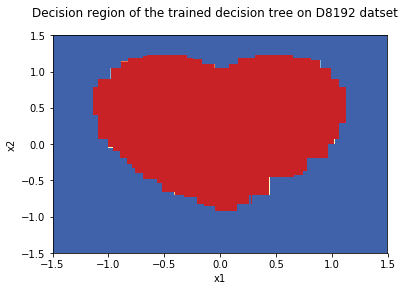

In [76]:
plot_step = 0.002
x_min, x_max = numpy_matrix[0:8192, 0].min() , numpy_matrix[0:8192, 0].max() 
y_min, y_max = numpy_matrix[0:8192, 1].min() , numpy_matrix[0:8192, 1].max() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
positions = np.vstack([xx.ravel(), yy.ravel()])
Z = test_accuracy1(tree8192, xx.ravel(), yy.ravel())
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)


cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel('x1')
plt.ylabel('x2')

plt.suptitle("Decision region of the trained decision tree on D8192 datset")
#plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")

#labels = ['blue = label 1', 'red = label 0']

#plt.legend(loc='upper right', labels)
#plt.legend(labels)
plt.savefig('f3_d8192_1.png')
plt.show()

Text(0.5,1,'Question 2.7: Learning curve')

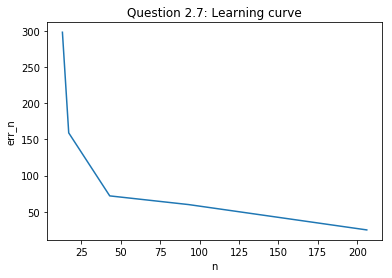

In [64]:
#p2.7 learning curve plot
plt.plot([13, 17, 43, 93, 206],[298,159,72,60,25])
plt.xlabel("n")
plt.ylabel("err_n")
plt.title("Question 2.7: Learning curve")


Text(0.5,1,'Question 3: Learning curve')

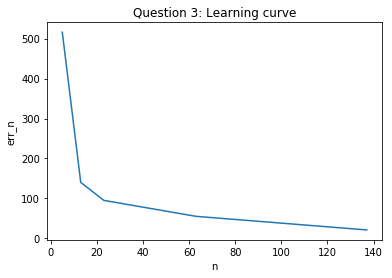

In [65]:
#p2 WEKA learning curve plot
plt.plot([5, 13, 23, 63, 137],[516,140,95,55,21])
plt.xlabel("n")
plt.ylabel("err_n")
plt.title("Question 3: Learning curve")